- playwright
- check source, remap newsly and newsapi from domain if necessary
- enumerate sources from articles.db assign to reputation bucket 1,2,3
- print out new sources for assignment
- output the relevance for the final writeup
- make a good prompt to write the final

### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast


possible TODOs:
- breakdown the item selection / writing process
- rate each story on various dimensions, 
  - 1 , on -topic 2, important in magnitude 3 - reliable and not spammy
  - rate popular news sources, eg WSJ and bloomberg > TMZ
  - log length of the news text
  - rate spamminess
- rate overall value of stories according to a rubric
- drop stories with low scores

3 - source - top publication, midtier pub or blog, other

- tool to check format of a story or section
- rewrite prompt per 4.1 prompting guidelines, use 4.1 or o4-mini
- do evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo


In [1]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [2]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_const import (
                        FINAL_SUMMARY_PROMPT,
                        REWRITE_PROMPT,
                        SCREENSHOT_DIR, SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, newscatcher_sources, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from selenium.webdriver.support.ui import WebDriverWait
from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [3]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-04-25 13:47:06,129 - AInewsbot - INFO - Initializing with before_date=2025-04-24 18:00, do_download=False, thread_id=62d5388c23e644279836c15d0be4c611
2025-04-25 13:47:06,215 - AInewsbot - INFO - thread_id: 62d5388c23e644279836c15d0be4c611


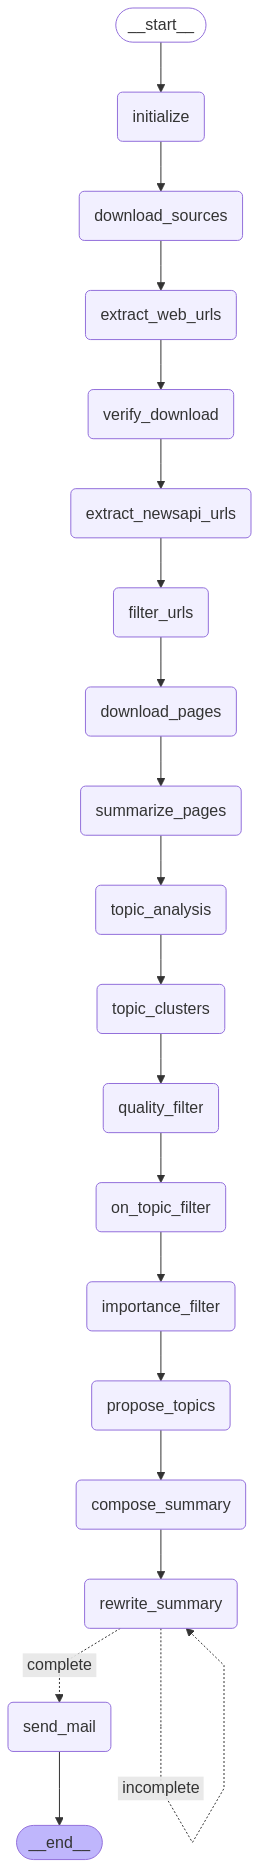

In [4]:
before_date = None
before_date = '2025-04-24 18:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [5]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-04-25 13:47:06,301 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-25 13:47:06,301 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars Technica.html
2025-04-25 13:47:06,302 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-25 13:47:06,302 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider.html
2025-04-25 13:47:06,302 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-25 13:47:06,302 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-04-25 13:47:06,302 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-04-25 13:47:06,335 - AInewsbot - INFO - parse_file - found 169 raw links
2025-04-25 13:47:06,338 - AInewsbot - INFO - parse_file - found 36 filtered links
2025-04-25 13:47:06,338 - AInewsbot - INFO - 36 links found
2025-04-25 13:47:06,338 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg (04_25_2025 01_13_41 PM).html
2025-04-25 13:47:06,515 - AInewsbot - INFO - parse_file - found 245 raw links
2025-04-25 13:47:06,518 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-04-25 13:47:06,518 - AInewsbot - INFO - 37 links found
2025-04-25 13:47:06,518 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider (04_25_2025 01_13_38 PM).html
2025-04-25 13:47:06,537 - AInewsbot - INFO - parse_file - found 217 raw links
2025-04-25 13:47:06,540 - AInewsbot - INFO - parse_file - found 22 filtered links
2025-04-25 13:47:06,540 - AInewsbot - INFO - 22 links found
2025-04-25 13:47:06,540 - AInewsbot - INFO - FT -> htmldata/FT (04_25_2025 01_13_39 PM).html
2025-04-25 13:47:06

,id
src,
Ars Technica,36
Bloomberg,31
Business Insider,22
FT,62
Feedly AI,36
Hacker News 1,25
Hacker News 2,24
HackerNoon,18
New York Times,19


2025-04-25 13:47:06,912 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,36
Bloomberg,31
Business Insider,22
FT,62
Feedly AI,36
Hacker News 1,25
Hacker News 2,24
HackerNoon,18
New York Times,19


2025-04-25 13:47:06,915 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-24T13:47:06 from NewsAPI


,id
src,
Ars Technica,36
Bloomberg,31
Business Insider,22
FT,62
Feedly AI,36
Hacker News 1,25
Hacker News 2,24
HackerNoon,18
New York Times,19


2025-04-25 13:47:07,288 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-24 18:00'
2025-04-25 13:47:07,909 - AInewsbot - INFO - URLs in orig_df: 921
2025-04-25 13:47:07,912 - AInewsbot - INFO - Existing URLs in DB: 249374
2025-04-25 13:47:07,972 - AInewsbot - INFO - New URLs in df filtered by URL: 415
2025-04-25 13:47:08,102 - AInewsbot - INFO - Existing src+title: 10
2025-04-25 13:47:08,102 - AInewsbot - INFO - New URLs in df filtered by src+title: 405
2025-04-25 13:47:08,116 - AInewsbot - INFO - Found 403 unique new headlines
2025-04-25 13:47:08,118 - AInewsbot - INFO - Found 401 unique cleaned new headlines
2025-04-25 13:47:09,557 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:47:14,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:47:15,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,2
Bloomberg,5
Business Insider,4
FT,5
Feedly AI,28
Hacker News 1,3
Hacker News 2,3
HackerNoon,1
New York Times,3


2025-04-25 13:47:24,418 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-25 13:47:24,443 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 24588
2025-04-25 13:47:24,444 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 24588
2025-04-25 13:47:24,444 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 24588
2025-04-25 13:47:24,444 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 24588
2025-04-25 13:47:42,985 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-25 13:47:42,985 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-25 13:47:42,985 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-25 13:47:42,986 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-25 13:47:42,986 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-25 13:47:42,986 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-25 13:47:42,987 - AInewsb

2025-04-25 13:48:39,194 - AInewsbot - INFO - Processing page 15: https://siliconangle.com/2025/04/24/adobe-unveils-new-firefly-generative-ai-models-creative-tools/
2025-04-25 13:48:39,196 - AInewsbot - INFO - Processing page 16: https://www.globenewswire.com/news-release/2025/04/24/3067585/0/en/Aivre-slashes-appraisal-time-by-50-with-Restb-ai-s-computer-vision-tech-saving-over-3-hours-per-report.html
2025-04-25 13:48:39,197 - AInewsbot - INFO - get_url(https://www.globenewswire.com/news-release/2025/04/24/3067585/0/en/Aivre-slashes-appraisal-time-by-50-with-Restb-ai-s-computer-vision-tech-saving-over-3-hours-per-report.html) - starting get_url https://www.globenewswire.com/news-release/2025/04/24/3067585/0/en/Aivre-slashes-appraisal-time-by-50-with-Restb-ai-s-computer-vision-tech-saving-over-3-hours-per-report.html
2025-04-25 13:48:39,197 - AInewsbot - INFO - get_url(https://siliconangle.com/2025/04/24/adobe-unveils-new-firefly-generative-ai-models-creative-tools/) - starting get_url h

2025-04-25 13:48:39,226 - AInewsbot - INFO - Processing page 37: https://deepmind.google/discover/blog/music-ai-sandbox-now-with-new-features-and-broader-access/
2025-04-25 13:48:39,226 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-25/chinese-ai-startup-manus-scores-funding-at-500-million-value) - starting get_url https://www.bloomberg.com/news/articles/2025-04-25/chinese-ai-startup-manus-scores-funding-at-500-million-value
2025-04-25 13:48:39,227 - AInewsbot - INFO - get_url(https://deepmind.google/discover/blog/music-ai-sandbox-now-with-new-features-and-broader-access/) - starting get_url https://deepmind.google/discover/blog/music-ai-sandbox-now-with-new-features-and-broader-access/
2025-04-25 13:48:39,227 - AInewsbot - INFO - Processing page 38: https://www.androidheadlines.com/2025/04/deepseek-illegally-sent-data-to-china-south-korean-regulator-says.html
2025-04-25 13:48:39,228 - AInewsbot - INFO - Processing page 39: https://aws.amazon.com/blogs/mac

2025-04-25 13:48:41,285 - AInewsbot - INFO - get_url(http://cacm.acm.org/news/how-liquid-networks-make-robots-smarter/) - starting get_url http://cacm.acm.org/news/how-liquid-networks-make-robots-smarter/
2025-04-25 13:48:41,287 - AInewsbot - INFO - Processing page 53: https://petapixel.com/2025/04/24/how-a-photojournalist-is-using-generative-ai-to-illustrate-classic-stories/
2025-04-25 13:48:41,289 - AInewsbot - INFO - get_url(https://petapixel.com/2025/04/24/how-a-photojournalist-is-using-generative-ai-to-illustrate-classic-stories/) - starting get_url https://petapixel.com/2025/04/24/how-a-photojournalist-is-using-generative-ai-to-illustrate-classic-stories/
2025-04-25 13:48:41,290 - AInewsbot - INFO - Processing page 54: https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203
2025-04-25 13:48:41,294 - AInewsbot - INFO - get_url(https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203) - starting get_url https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203


2025-04-25 13:48:43,726 - AInewsbot - INFO - Processing page 72: https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit
2025-04-25 13:48:43,732 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit) - starting get_url https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit
2025-04-25 13:48:44,873 - AInewsbot - INFO - get_url(Meta lays off Reality Labs staffers, affecting Oculus Studios teams; sources: 100+ staff are affected, including those involved in Meta's hardware efforts) - Saving Meta_lays_off_Reality_Labs_staffers__affecting_Oculus_Studios_teams__sources__100__staff_are_affected__including_those_involved_in_Meta_s_hardware_efforts.html as utf-8
2025-04-25 13:48:44,875 - AInewsbot - INFO - Processing page 73: https://www.talkandroid.com/505430-meta-wants-whatsapp-to-become-your-ai-assista

2025-04-25 13:48:45,162 - AInewsbot - INFO - get_url(https://techcrunch.com/2025/04/24/openai-rolls-out-a-lightweight-version-of-its-chatgpt-deep-research-tool/) - starting get_url https://techcrunch.com/2025/04/24/openai-rolls-out-a-lightweight-version-of-its-chatgpt-deep-research-tool/
2025-04-25 13:48:45,169 - AInewsbot - INFO - Processing page 90: https://openai.com/index/image-generation-api/
2025-04-25 13:48:45,173 - AInewsbot - INFO - get_url(https://openai.com/index/image-generation-api/) - starting get_url https://openai.com/index/image-generation-api/
2025-04-25 13:48:45,178 - AInewsbot - INFO - Processing page 91: https://www.theblock.co/post/352000/paradigm-leads-50-million-usd-round-decentralized-ai-project-nous-research
2025-04-25 13:48:45,189 - AInewsbot - INFO - get_url(https://www.theblock.co/post/352000/paradigm-leads-50-million-usd-round-decentralized-ai-project-nous-research) - starting get_url https://www.theblock.co/post/352000/paradigm-leads-50-million-usd-round-

2025-04-25 13:48:48,350 - AInewsbot - INFO - Processing page 108: https://hiddenlayer.com/innovation-hub/novel-universal-bypass-for-all-major-llms/
2025-04-25 13:48:48,350 - AInewsbot - INFO - get_url(https://hiddenlayer.com/innovation-hub/novel-universal-bypass-for-all-major-llms/) - starting get_url https://hiddenlayer.com/innovation-hub/novel-universal-bypass-for-all-major-llms/
2025-04-25 13:48:48,351 - AInewsbot - INFO - Processing page 109: https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-already-enforcing-them
2025-04-25 13:48:48,351 - AInewsbot - INFO - get_url(https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-already-enforcing-them) - starting get_url https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-already-enforcing-them
2025-04-25 13:48:48,354 - AInewsbot - INFO - Processing page 110: https://archinect.com/news/article/

2025-04-25 13:48:49,184 - AInewsbot - INFO - Processing page 126: https://gizmodo.com/windows-11s-most-controversial-ai-feature-is-back-and-itll-never-be-secure-2000592392
2025-04-25 13:48:49,187 - AInewsbot - INFO - get_url(https://gizmodo.com/windows-11s-most-controversial-ai-feature-is-back-and-itll-never-be-secure-2000592392) - starting get_url https://gizmodo.com/windows-11s-most-controversial-ai-feature-is-back-and-itll-never-be-secure-2000592392
2025-04-25 13:48:49,190 - AInewsbot - INFO - Processing page 127: https://it.slashdot.org/story/25/04/25/1545223/yc-partner-argues-most-ai-apps-are-currently-horseless-carriages
2025-04-25 13:48:49,197 - AInewsbot - INFO - get_url(https://it.slashdot.org/story/25/04/25/1545223/yc-partner-argues-most-ai-apps-are-currently-horseless-carriages) - starting get_url https://it.slashdot.org/story/25/04/25/1545223/yc-partner-argues-most-ai-apps-are-currently-horseless-carriages
2025-04-25 13:48:49,199 - AInewsbot - INFO - Processing page 128: ht

,id
src,
Ars Technica,2
Bloomberg,5
Business Insider,4
FT,5
Feedly AI,28
Hacker News 1,3
Hacker News 2,3
HackerNoon,1
New York Times,3


2025-04-25 13:48:57,871 - AInewsbot - INFO - Starting summarize
2025-04-25 13:48:57,872 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-25 13:48:57,930 - AInewsbot - INFO - clean_html - Page title: NFL Draft Round 1 predictions: 2025 NFL Draft: ChatGPT’s Round 1 predictions vs. reality — The results may surprise you - The Economic Times
Social card title: 2025 NFL Draft: ChatGPT’s Round 1 predictions vs. reality — The results may surprise you
Social card description: Fans of the National Football League are keenly waiting for Round 1 of the NFL Draft 2025, which will begin on April 24. After this, the second and third rounds will take place on Friday, April 25, followed by the remaining rounds (4-7) on Saturday.

2025-04-25 13:48:58,179 - AInewsbot - INFO - Queuing 0: Page title: NFL Draft Round 1 predictions: 2025 NF...
2025-04-25 13:48:58,203 - AInewsbot - INFO - clean_html - Page title: A Discovery Every Day: What Does Superintelligence Actually Look Like?
Social ca

2025-04-25 13:48:58,646 - AInewsbot - INFO - Queuing 14: Page title: Adobe adds AI models from OpenAI, Goog...
2025-04-25 13:48:58,664 - AInewsbot - INFO - clean_html - Page title: Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE
Social card title: Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE
Social card description: Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE

2025-04-25 13:48:58,684 - AInewsbot - INFO - Queuing 15: Page title: Adobe unveils new Firefly generative A...
2025-04-25 13:48:58,689 - AInewsbot - INFO - clean_html - Page title: Aivre slashes appraisal time by 50% with
Social card title: Aivre slashes appraisal time by 50% with Restb.ai's computer vision tech, saving over 3 hours per report
Social card description: Appraisal software company Aivre has cut the time to complete an appraisal by more than half by integrating with Restb.ai’s computer vision tech....

2025-04-25

2025-04-25 13:48:59,598 - AInewsbot - INFO - clean_html - Page title: ChatGPT is getting a ‘lightweight’ version of its deep research tool | The Verge
Social card title: ChatGPT is getting a ‘lightweight’ version of its deep research tool
Social card description: Deep but light.

2025-04-25 13:48:59,620 - AInewsbot - INFO - Queuing 32: Page title: ChatGPT is getting a ‘lightweight’ ver...
2025-04-25 13:48:59,638 - AInewsbot - INFO - clean_html - Page title: ChatGPT’s Massively Popular Image Generation Available Via API for Verified Users’ Creations | TechRepublic
Social card title: ChatGPT’s Massively Popular Image Generation Available Via API for Verified Users’ Creations | TechRepublic
Social card description: OpenAI recently integrated ChatGPT’s image generation functionality into its API for use in custom tools and platforms.

2025-04-25 13:48:59,651 - AInewsbot - INFO - Queuing 33: Page title: ChatGPT’s Massively Popular Image Gene...
2025-04-25 13:48:59,665 - AInewsbot - INFO - c

2025-04-25 13:49:00,095 - AInewsbot - INFO - Queuing 49: Page title: Got Philips Hue lights? This new custo...
2025-04-25 13:49:00,110 - AInewsbot - INFO - clean_html - Page title: Here's a round up of the talks you can tune into at Google I/O 2025 next month - Neowin
Social card title: Here's a round up of the talks you can tune into at Google I/O 2025 next month
Social card description: Here is a full schedule of the talks Google will be live streaming at its I/O 2025 event on May 20 and 21.

2025-04-25 13:49:00,121 - AInewsbot - INFO - Queuing 50: Page title: Here's a round up of the talks you can...
2025-04-25 13:49:00,146 - AInewsbot - INFO - clean_html - Page title: How Data Integration Transforms Customer Insights For Banks
Social card title: How Data Integration Transforms Customer Insights For Banks
Social card description: For centuries, banks have relied on relationships and legacy reputations to maintain their standing. But the world has changed. 

2025-04-25 13:49:00,181 -

2025-04-25 13:49:00,999 - AInewsbot - INFO - clean_html - Page title: Luminar Neo's Spring Update Adds Workflow-Focused AI Enhancements | PetaPixel
Social card title: Luminar Neo's Spring Update Adds Workflow-Focused AI Enhancements
Social card description: Better and faster AI-powered photo editing.

2025-04-25 13:49:01,006 - AInewsbot - INFO - Queuing 68: Page title: Luminar Neo's Spring Update Adds Workf...
2025-04-25 13:49:01,016 - AInewsbot - INFO - clean_html - Page title: Making AI-generated code more accurate in any language | ScienceDaily
Social card title: Making AI-generated code more accurate in any language
Social card description: Researchers developed a more efficient way to control the outputs of a large language model, guiding it to generate text that adheres to a certain structure, like a programming language, and remains error free.

2025-04-25 13:49:01,030 - AInewsbot - INFO - Queuing 69: Page title: Making AI-generated code more accurate...
2025-04-25 13:49:01,048 

2025-04-25 13:49:01,641 - AInewsbot - INFO - Queuing 85: Page title: New approach makes AI adaptable for co...
2025-04-25 13:49:01,658 - AInewsbot - INFO - clean_html - Page title: Exclusive: Crypto VC giant Paradigm makes $50 million bet on decentralized AI startup Nous Research at $1 billion token valuation | Fortune Crypto
Social card title: Exclusive: Crypto VC giant Paradigm makes $50 million bet on decentralized AI startup Nous Research
Social card description: Nous aims to compete with OpenAI and DeepSeek by training open-source through crypto incentives.

2025-04-25 13:49:01,684 - AInewsbot - INFO - Queuing 86: Page title: Exclusive: Crypto VC giant Paradigm ma...
2025-04-25 13:49:01,710 - AInewsbot - INFO - clean_html - Page title: Nvidia's 70+ projects at ICLR show how raw chip power is central to AI's acceleration | ZDNET
Social card title: Nvidia's 70+ projects at ICLR show how raw chip power is central to AI's acceleration
Social card description: Researchers showcased Nvi

2025-04-25 13:49:02,547 - AInewsbot - INFO - Queuing 100: Page title: A strategic framework for leaders to s...
2025-04-25 13:49:02,592 - AInewsbot - INFO - clean_html - Page title: Should we start taking the welfare of AI seriously? - The Economic Times
Social card title: Should we start taking the welfare of AI seriously?
Social card description: As AI systems grow more advanced, some researchers are beginning to explore whether these models could one day become conscious and deserve moral consideration. While today's AI lacks true awareness, the debate raises ethical questions about how we treat intelligent machines—even as many believe the focus should remain on protecting humans.

2025-04-25 13:49:02,635 - AInewsbot - INFO - Queuing 101: Page title: Should we start taking the welfare of ...
2025-04-25 13:49:02,661 - AInewsbot - INFO - clean_html - Page title: GitHub - magnitudedev/magnitude: Open source, AI-native testing framework for web apps
Social card title: GitHub - magnitud

2025-04-25 13:49:03,203 - AInewsbot - INFO - Queuing 118: Page title: Uber CEO Loves His Tesla and Isn't Wor...
2025-04-25 13:49:03,207 - AInewsbot - INFO - clean_html - Page title: Verana Health Launches Qdata® Cataracts, the Largest
Social card title: Verana Health Launches Qdata® Cataracts, the Largest Dataset of Its Kind for Cataract Research
Social card description: Exclusive real-world insights on more than 9 million de-identified cataract surgery patients aims to advance clinical research, treatment optimization, and...

2025-04-25 13:49:03,213 - AInewsbot - INFO - Queuing 119: Page title: Verana Health Launches Qdata® Cataract...
2025-04-25 13:49:03,228 - AInewsbot - INFO - clean_html - Page title: Vertiv Stock Rises As AI Data-Center Buildout Continues | Investor's Business Daily
Social card title: Vertiv Gaining Share As AI Data-Center Buildout Continues, Says CEO
Social card description: Solid Q1 results from Vertiv reflect the continued growth of the AI data-center market a

2025-04-25 13:49:05,040 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:05,097 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:05,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:05,243 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:05,266 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:05,369 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:05,441 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:05,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:05,450 - httpx 

2025-04-25 13:49:06,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:07,006 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:07,025 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:07,032 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:07,038 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:07,044 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:07,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:07,092 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:07,149 - httpx 

2025-04-25 13:49:20,187 - AInewsbot - INFO - Summary for 2 (length 1492): • Andreessen Horowitz (A16z) is in early talks to raise a $20 billion fund focused on artificial intelligence, which would be the largest in the firm's history.
• The initiative is reportedly fueled by 20,000 Nvidia GPUs and represents a significant bet by co-founder Marc Andreessen on the next generation of tech startups.
2025-04-25 13:49:20,188 - AInewsbot - INFO - Summary for 3 (length 4405): • New research from Johns Hopkins University, presented at the International Conference on Learning Representations, finds that even advanced AI models consistently fail to interpret human social cues and dynamics as accurately as humans do.
• In experiments where over 350 AI models were tasked with predicting human judgments of social interactions in video clips, none matched the consistency and nuance of human perception; video models, in particular, struggled to recognize communication, while language models performed 

2025-04-25 13:49:20,194 - AInewsbot - INFO - Summary for 12 (length 7348): • A federal court has allowed copyright infringement claims against AI image tool providers Stability AI and MidJourney to proceed, with discovery set to begin and a trial date scheduled for September 2026; the case hinges on whether distributing AI models like Stable Diffusion enables copying of copyrighted material.
• The lawsuit is significant as generative AI's rapid adoption is transforming creative industries, raising profound legal and ethical questions about copyright and the role of human creativity in content generated for commercial use.
• Adobe highlights its approach to AI-generated art by compensating artists whose works train its Firefly model, while also noting that successful integration of generative AI in organizations requires change management, upskilling, and continued human oversight.
2025-04-25 13:49:20,195 - AInewsbot - INFO - Summary for 13 (length 4695): • Adobe has released a major up

2025-04-25 13:49:20,199 - AInewsbot - INFO - Summary for 23 (length 9154): • A study at the University of Illinois Urbana-Champaign found that ChatGPT, using its free version, earned a low B grade in a third-year undergraduate engineering course, excelling in multiple choice and calculation problems but performing poorly on assignments requiring deeper reasoning and design skills.

• Professors are reconsidering how engineering is taught, debating whether to adapt curricula for AI's presence by emphasizing critical thinking and problem-solving over tasks easily solvable by AI, drawing analogies to the introduction of calculators in education.

• Melkior Ornik and colleagues plan a larger study across multiple engineering courses to explore curriculum changes and the integration of "critical thinking modules" that educate students on both AI's capabilities and limitations.

• President Trump has established a task force to develop strategies for integrating AI education from kindergarte

2025-04-25 13:49:20,205 - AInewsbot - INFO - Summary for 38 (length 3026): • South Korea's Personal Information Protection Commission (PIPC) concluded that Chinese AI startup DeepSeek illegally transferred South Korean user data to companies in China and the US, including the ByteDance-affiliated Beijing Volcano Engine Technology Co., without user consent or proper disclosure.  
• DeepSeek stated it sent data to Volcano Engine to improve user experience and has since blocked the transfer of AI prompt content as of April 10.  
• The PIPC is issuing a corrective recommendation for DeepSeek to destroy user data already transferred to China and to establish a legal basis for any future overseas data transfers.
2025-04-25 13:49:20,205 - AInewsbot - INFO - Summary for 39 (length 24150): • AWS and Cisco teams developed a new approach for enterprise-grade natural language to SQL (NL2SQL) generation, optimizing for higher accuracy, lower latency, and cost-effective performance using smaller lar

2025-04-25 13:49:20,207 - AInewsbot - INFO - Summary for 48 (length 2490): • Google reports that its AI Overviews feature is now used by over 1.5 billion users monthly across more than 100 countries, and Circle to Search is available on over 250 million devices, up from 200 million in late 2023 with usage rising nearly 40% quarter-over-quarter.

• Visual searches through Google Lens have increased by 5 billion since October, with shopping on Lens growing over 10% in Q1 2025, according to CEO Sundar Pichai.

• The expansion of Google's AI-powered search features comes as the company faces regulatory scrutiny, with the U.S. Department of Justice pressuring it to spin off Chrome and a federal judge ruling Google has an adtech monopoly, potentially leading to a breakup.
2025-04-25 13:49:20,207 - AInewsbot - INFO - Summary for 49 (length 3660): • Signify, the company behind Philips Hue, is preparing to launch a new, slightly larger and more angular second-generation Smart Button, according 

2025-04-25 13:49:20,209 - AInewsbot - INFO - Summary for 59 (length 2989): • Inflexion Group has partnered with AI&Beyond to offer specialized AI literacy training for account-based marketing (ABM) practitioners, including bootcamps on GenAI, ethics, and AI fluency.
• Bev Burgess, CEO and Co-founder of Inflexion Group, emphasized the partnership's role in ensuring clients and staff gain essential AI competencies to improve ABM program impact responsibly.
• AI&Beyond, a Gurugram-based startup founded by Jaspreet Bindra and Anuj Magazine, aims to make AI literacy fundamental, with Bindra stating, “AI literacy should be as fundamental as reading, writing, and arithmetic, especially in industries undergoing rapid AI-driven transformations.”
2025-04-25 13:49:20,209 - AInewsbot - INFO - Summary for 60 (length 842): no content
2025-04-25 13:49:20,209 - AInewsbot - INFO - Summary for 61 (length 6704): • Tesla is preparing to launch its robotaxi service in Austin, Texas in June, with about 300 

2025-04-25 13:49:20,210 - AInewsbot - INFO - Summary for 71 (length 1835): • Meta has laid off an unspecified number of employees in its Reality Labs division, affecting teams working on Supernatural, Oculus Studios, and other Quest apps, as well as some hardware staff.
• The layoffs relate to restructuring efforts, with a Meta spokesperson stating, “These changes are meant to help Studios work more efficiently on future mixed reality experiences for our growing audience, while still delivering great content for people today.”
• Meta remains committed to investing in mixed reality experiences, particularly for fitness and games, despite continued struggles with Quest headset sales compared to better-than-expected growth in its Ray-Ban smart glasses.
2025-04-25 13:49:20,210 - AInewsbot - INFO - Summary for 72 (length 519): no content
2025-04-25 13:49:20,210 - AInewsbot - INFO - Summary for 73 (length 5513): • Meta's AI assistant on WhatsApp, powered by the Llama 3.2 model, has generated

2025-04-25 13:49:20,211 - AInewsbot - INFO - Summary for 84 (length 2027): • Netflix has introduced a new subtitle option that displays only spoken dialogue, omitting sound descriptions and speaker names previously provided in subtitles for the deaf and hard of hearing.
• The dialogue-only subtitles are currently available in English and limited to new Netflix original titles, starting with season 5 of "You", with plans to potentially expand it to existing titles.
• Netflix reports that nearly half of all viewing hours in the US use subtitles or captions, highlighting widespread demand for subtitle accessibility.
2025-04-25 13:49:20,211 - AInewsbot - INFO - Summary for 85 (length 6769): • Scientists at the University of Illinois at Urbana-Champaign developed a machine-learning tool using an "efficiently supervised generative and adversarial network" (ESGAN) that can distinguish between aerial images of flowering and nonflowering Miscanthus grasses with minimal human annotation, signifi

2025-04-25 13:49:20,213 - AInewsbot - INFO - Summary for 96 (length 3666): • Researchers have introduced PyGraph, an approach that automatically integrates CUDA Graphs support into PyTorch2, enabling wider and more efficient deployment of this GPU acceleration feature without requiring manual code changes.

• PyGraph includes optimizations that reduce data copy overhead and uses a cost-benefit analysis to selectively deploy CUDA Graphs, addressing challenges with CUDA Graphs' static structure and performance overheads; evaluations show substantial performance improvements over standard PyTorch2 across multiple machine learning benchmarks.

• The study found that deploying CUDA Graphs can sometimes hurt performance, highlighting the need for selective and optimized integration, which PyGraph addresses through its compiler-based approach.
2025-04-25 13:49:20,213 - AInewsbot - INFO - Summary for 97 (length 43732): • The paper analyzes four cross-organizational cooperative R&D and pricing 

2025-04-25 13:49:20,215 - AInewsbot - INFO - Summary for 108 (length 17778): • HiddenLayer researchers have developed a universal and transferable prompt injection technique, called the "Policy Puppetry Attack," that can bypass safety guardrails and instruction hierarchies in all major large language models (LLMs), including those from OpenAI, Google, Microsoft, Anthropic, Meta, DeepSeek, Qwen, and Mistral.

• The technique enables attackers to generate restricted or harmful content—for example, related to weapons, violence, or self-harm—and extract system prompts across a wide range of LLMs, using a single generic prompt or with minor adaptations, exposing a pervasive vulnerability in current LLM alignment and training methods.

• HiddenLayer's research underscores "the importance of proactive security testing, especially for organizations deploying or integrating LLMs in sensitive environments, as well as the inherent flaws in solely relying on RLHF (Reinforcement Learning from Human

2025-04-25 13:49:20,216 - AInewsbot - INFO - Summary for 120 (length 3422): • Vertiv reported strong first-quarter results with revenue rising 24%, outpacing the overall AI data-center market growth rate of 9%-12% annually, and the company's CEO Giordano Albertazzi stated, "Clearly we are taking market share."  
• Vertiv stock rose 7.5% following the results, despite Morgan Stanley and TD Cowen both lowering their price targets while maintaining buy ratings, citing broader market factors; the company remains encouraged by long-term industry trends and has not seen a significant pullback in customer business plans.  
• The CEO highlighted the expansion of data-center builds beyond hyperscalers to enterprises, sovereign nations, and AI-focused "neoclouds," emphasizing that the artificial intelligence megatrend is still at a "very early stage."
2025-04-25 13:49:20,217 - AInewsbot - INFO - Summary for 121 (length 2768): • AI systems have rapidly advanced over the past year, surpassing huma

2025-04-25 13:49:20,218 - AInewsbot - INFO - Summary for 131 (length 8430): • Zencoder has acquired Machinet, a developer of context-aware AI coding assistants with over 100,000 JetBrains ecosystem downloads, to strengthen its position in the AI coding assistant market and expand its reach among Java and JetBrains users.  
• The acquisition comes amid rapid market consolidation, with OpenAI reportedly in talks to acquire Windsurf; Zencoder's CEO Andrew Filev noted, "For smaller companies, it’s becoming harder and harder to compete," and emphasized the necessity of significant technical resources.  
• Zencoder differentiates itself from competitors such as GitHub Copilot, Cursor, and Windsurf through JetBrains ecosystem integration, its "Repo Grokking" technology for better code context, and features like "Coffee Mode," along with benchmark results showing it outperforms rivals and OpenAI on industry-standard coding tasks.  
• As part of the acquisition, Machinet will transfer its domai

,id
src,
Ars Technica,2
Bloomberg,5
Business Insider,4
FT,5
Feedly AI,28
Hacker News 1,3
Hacker News 2,3
HackerNoon,1
New York Times,3


2025-04-25 13:49:20,239 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-25 13:49:25,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:25,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:26,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:27,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:28,104 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:28,644 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:31,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:

2025-04-25 13:49:31,321 - AInewsbot - INFO - Canonical topic bubble
2025-04-25 13:49:31,321 - AInewsbot - INFO - Canonical topic sustainability
2025-04-25 13:49:31,321 - AInewsbot - INFO - Canonical topic hardware
2025-04-25 13:49:31,322 - AInewsbot - INFO - Canonical topic internet of things
2025-04-25 13:49:31,322 - AInewsbot - INFO - Canonical topic consciousness
2025-04-25 13:49:31,322 - AInewsbot - INFO - Canonical topic ai doom
2025-04-25 13:49:31,323 - AInewsbot - INFO - Canonical topic virtual & augmented reality
2025-04-25 13:49:31,323 - AInewsbot - INFO - Canonical topic education
2025-04-25 13:49:31,323 - AInewsbot - INFO - Canonical topic inequality
2025-04-25 13:49:31,323 - AInewsbot - INFO - Canonical topic computer vision
2025-04-25 13:49:31,323 - AInewsbot - INFO - Canonical topic books & publishing
2025-04-25 13:49:31,323 - AInewsbot - INFO - Canonical topic cybersecurity
2025-04-25 13:49:31,323 - AInewsbot - INFO - Canonical topic reality labs layoffs
2025-04-25 13:49

2025-04-25 13:49:37,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:37,822 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:37,824 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:37,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:37,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:37,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:37,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:37,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:37,847 - httpx 

2025-04-25 13:49:38,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,339 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,340 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,350 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,350 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,351 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,351 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,352 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,353 - httpx 

2025-04-25 13:49:38,740 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,742 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,747 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,750 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,752 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,759 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,761 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:38,764 - httpx 

2025-04-25 13:49:39,133 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,142 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,143 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,150 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,155 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,157 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,160 - httpx 

2025-04-25 13:49:39,625 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,654 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,664 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,670 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,671 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,674 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,676 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,684 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:39,698 - httpx 

2025-04-25 13:49:40,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:40,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:40,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:40,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:40,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:40,311 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:40,325 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:40,327 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:40,425 - httpx 

2025-04-25 13:49:41,665 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:41,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:41,743 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:41,750 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:41,754 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:41,760 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:41,766 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:41,786 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:41,792 - httpx 

2025-04-25 13:49:42,542 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:42,544 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:42,551 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:42,558 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:42,580 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:42,590 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:42,594 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:42,601 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:42,603 - httpx 

2025-04-25 13:49:43,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,084 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,092 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,096 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,141 - httpx 

2025-04-25 13:49:43,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,607 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,611 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,631 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,632 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,647 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,649 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:43,656 - httpx 

2025-04-25 13:49:44,295 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,298 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,299 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,301 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,303 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,305 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,312 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,313 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,317 - httpx 

2025-04-25 13:49:44,939 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,949 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,950 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,978 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,981 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:44,981 - httpx 

2025-04-25 13:49:45,705 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:45,708 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:45,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:45,738 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:45,744 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:45,775 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:45,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:45,874 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:45,876 - httpx 

,id
src,
Ars Technica,2
Bloomberg,5
Business Insider,4
FT,5
Feedly AI,28
Hacker News 1,3
Hacker News 2,3
HackerNoon,1
New York Times,3


2025-04-25 13:49:48,850 - AInewsbot - INFO - Fetching embeddings for 133 headlines
2025-04-25 13:49:50,081 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-25 13:49:50,594 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-25 13:49:50,624 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-25 13:49:52,043 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-25 13:49:53,360 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-25 13:49:53,399 - AInewsbot - INFO - Found 7 clusters


,title_topic_str
0,"Adobe launches major Firefly update featuring new image generation models and more (Topics: Adobe Firefly Update, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Content Credentials, Creative Cloud Integration, Entertainment, Gen AI, Generative AI Models, Google, Image And Video Generation, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality)"
1,"Luminar Neos Spring Update Adds Workflow-Focused AI Enhancements (Topics: AI Enhancements, Art & Design, Authors & Writing, Cognitive Science, Computer Vision, Dng Export Format, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Workflow, Products, Review, Society & Culture, Software Update, Tv & Film & Movies)"
2,"Luminar Neo Update Brings AI Auto Adjust, Realistic Fog, and Speed Boosts (Topics: AI Auto Adjust, Art & Design, Atmosphere AI, Authors & Writing, Cognitive Science, Computer Vision, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Software, Products, Review, Society & Culture, Software Update, Tv & Film & Movies)"
3,"Adobe unveils new Firefly generative AI models and creative tools (Topics: Adobe Firefly, AI Governance, AI In Multimedia Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt, Computer Vision, Content Authenticity, Entertainment, Ethics, Gen AI, Generative AI Tools, Google, Intellectual Property, Language Models, Large Language Models, OpenAI, Partner AI Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality)"
4,"Adobe says Firefly users can now generate images using OpenAI's GPT, Google's Imagen 3 and Veo 2, and Flux 1.1 Pro, in addition to its own Firefly image models (Topics: Adobe Firefly Integration, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Entertainment, Gen AI, Google, Google Imagen, Intellectual Property, Language Models, Large Language Models, Mobile AI Apps, OpenAI, OpenAI Gpt, Products, Society & Culture, Software Update, Third-Party AI Models, Transformers, Tv & Film & Movies, Virtual & Augmented Reality)"


2025-04-25 13:49:54,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:54,100 - AInewsbot - INFO - I dub this cluster: Updates on AI Image Editing Tools


,title_topic_str
5,"Want to try ChatGPT's Deep Research tool for free? Check out the lightweight version (Topics: AI Tool Accessibility, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Deep Research, Cognitive Science, Education, Gen AI, Language Models, Large Language Models, O4-Mini Model, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Software Update, Testing, Text-Based AI Models, Transformers, Virtual Assistants)"
6,"As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever (Topics: AI Curriculum Adaptation, AI Governance, AI In Classrooms, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Critical Thinking, Education, Engineering Education, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, OpenAI, Opinion, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Virtual Assistants)"
7,"Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. (Topics: AI Coding Assistants, AI-Human Interaction, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Prompt Length, Climate, Code Assistants, Cognitive Science, Cost Of Politeness, Critical Thinking, Cybersecurity, Economics, Energy, Energy Consumption In AI, Ethics, Finance, Gen AI, Language Models, Large Language Models, OpenAI, OpenAI Operational Costs, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models)"
8,"ChatGPT is crushing Google in the AI race. Unless you look at the data differently. (Topics: AI Competition, AI Governance, App Usage Statistics, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Finance, Gen AI, Google, Google Gemini, Governance, Hardware, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Products, Regulation Of Tech Companies, Society & Culture, Text-Based AI Models, Virtual Assistants)"
9,"ChatGPTs Massively Popular Image Generation Available Via API for Verified Users Creations (Topics: AI Safety Controls, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt, Computer Vision, Developer Tools, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hardware, Image Generation Api, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Tv & Film & Movies, Virtual Assistants)"
10,"It sure looks like ChatGPT Free is getting ads soon (Topics: AI Monetization, AI Revenue Forecasts, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Ads, Code Assistants, Cognitive Science, Economics, Finance, Funding, Gen AI, Google, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Products, Sam Altman, Singularity, Society & Culture, Stocks, Text-Based AI Models, Virtual Assistants)"
11,"Evil Geniuses and Theta Labs launch AI chatbot based on esports mascot Meesh (Topics: AI Fan Engagement, Chatbots, Discord Integration, Entertainment, Esports AI Chatbot, Evil Geniuses, Gaming, Gen AI, History, Language Models, Large Language Models, Products, Society & Culture, Sports, Streaming, Text-Based AI Models, Theta Labs, Virtual Assistants)"
12,"ChatGPT is getting a lightweight version of its deep research tool (Topics: AI Coding Assistants, AI Governance, AI Models, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Deep Research Tool, Education, Freemium Features, Gen AI, Hardware, Language Models, Large Language Models, OpenAI, Products, Recall AI Feature, Retrieval Augmented Generation, Software Update, Testing, Text-Based AI Models, Virtual Assistants)"


2025-04-25 13:49:54,713 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:54,721 - AInewsbot - INFO - I dub this cluster: Developments and Impacts of ChatGPT


,title_topic_str
13,"Insiders reveal how Tesla is preparing for its June robotaxi launch (Topics: Austin Texas, Autonomous Vehicles, Computer Vision, Economics, Energy, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Robots, Safety And Alignment, Self-Driving Cars, Self-Driving Technology, Society & Culture, Stocks, Tesla Internal Testing, Tesla Robotaxi Launch, Testing, Transportation, Travel)"
14,"Uber CEO Dara Khosrowshahi says self-driving on his Tesla is 'delightful' and welcomes Elon Musk's competition in autonomous taxis (Topics: Autonomous Vehicle Competition, Autonomous Vehicles, Drones, Economics, Finance, Hardware, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Lifestyle & Travel, Manufacturing, Opinion, Products, Robotaxi Services, Robots, Self-Driving Cars, Society & Culture, Sports, Stocks, Tesla Self-Driving, Transportation, Travel, Uber Ceo Comments, Waymo Partnership)"
15,"Waymo might be willing to sell you a self-driving car, says Sundar Pichai (Topics: Alphabet, Autonomous Vehicle Ownership, Autonomous Vehicles, Computer Vision, Deals, Finance, Google, Governance, Hardware, India, Infrastructure, Job Automation, Jobs & Careers, Lifestyle & Travel, Products, Robots, Safety And Alignment, Self-Driving Cars, Society & Culture, Sundar Pichai, Transportation, Travel, Waymo)"
16,"US to loosen rules on self-driving vehicles criticised by Musk (Topics: Drones, Economics, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Policy And Regulation, Politics, Robots, Self-Driving Cars, Transportation)"
17,"The NHTSA plans to ease rules for autonomous vehicles, including loosening crash reporting requirements and simplifying approvals, in changes championed by Musk (Topics: Autonomous Vehicle Safety Standards, Autonomous Vehicles, China, Deals, Drones, Economics, Elon Musk Influence, Ethics, Finance, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Manufacturing, Nhtsa Autonomous Vehicle Regulations, Policy And Regulation, Politics, Privacy & Surveillance, Products, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Tesla Self-Driving Cars, Transportation, Travel, Us Transportation Policy)"


2025-04-25 13:49:55,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:55,431 - AInewsbot - INFO - I dub this cluster: Advances and Policies in Self-Driving Cars


,title_topic_str
18,"Windows 11s Most Controversial AI Feature Is Back, and Itll Never Be Secure (Topics: AI Governance, Artificial General Intelligence, Bias And Fairness, Biometric Authentication, Cognitive Science, Copilot Recall Feature, Cybersecurity, Ethics, Gen AI, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Microsoft, Microsoft Windows 11, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Security Concerns, Society & Culture, Software Update, Text-Based AI Models, User Privacy, Virtual Assistants)"
19,"Microsoft's Recall and improved Windows search start rolling out to Copilot+ AI PCs today (Topics: AI Coding Assistants, AI Data Privacy, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Copilot+ AI Pcs, Cybersecurity, Ethics, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Local AI Processing, Microsoft, Microsoft Recall Feature, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Software Update, Text-Based AI Models, Virtual Assistants, Windows Search Update)"
20,"Microsoft adds three new AI features to Copilot+ PCs - including the controversial Recall (Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Click To Do, Code Assistants, Cognitive Science, Computer Vision, Copilot+ Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, Gen AI, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants, Windows AI Search)"
21,"Microsoft launches Recall and AI-powered Windows search for Copilot Plus PCs (Topics: AI Coding Assistants, AI Governance, AI Windows Search, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Copilot Plus Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, European Union, Gen AI, Governance, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants)"


2025-04-25 13:49:56,179 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:56,187 - AInewsbot - INFO - I dub this cluster: Microsoft Windows AI Recall Feature


,title_topic_str
22,"Nous, which plans to launch an AI training system on Solana using people's idle computing power, raised a $50M Series A, a source says at a $1B token valuation (Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Crypto Venture Capital, Cryptocurrency, Cybersecurity, Deals, Decentralized AI, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research, Open Source, Open-Source AI Training, OpenAI, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Blockchain, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants)"
23,"Paradigm leads $50 million Series A round for decentralized AI project Nous Research (Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Blockchain AI Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Project, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research Funding, Open Source, OpenAI, Paradigm Investment, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Psyche Network, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants)"
24,"Chinese AI Startup Manus Scores Funding at $500 Million Value (Topics: AI Investment, China, Chinese AI Startups, Deals, Finance, Funding, Gen AI, Jobs & Careers, Language Models, Large Language Models, Manus, Products, Series A Funding, Venture Capital, Venture Funding)"


2025-04-25 13:49:57,039 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:57,048 - AInewsbot - INFO - I dub this cluster: AI Startup Series A Funding


,title_topic_str
25,"Perplexity CEO says its browser will track everything users do online to sell 'hyper personalized' ads | TechCrunch (Topics: Privacy, Privacy & Surveillance, Recommendation Systems)"
26,"Perplexity will come to Moto phones after exec testified Google limited access (Topics: AI Assistant Competition, AI Coding Assistants, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Customer Service, Cybersecurity, Deals, Default Assistant Restrictions, Economics, Ethics, Gen AI, Google, Google Antitrust Trial, Google Gemini, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Mobile Device Contracts, OpenAI, Perplexity Motorola Partnership, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Russia, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants)"
27,"Perplexity AI enters the smartphone market with Motorola partnership (Topics: AI Coding Assistants, AI Search Engines, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Generative AI In Devices, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Motorola Smartphone Integration, OpenAI, Perplexity AI, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transportation, Travel, User Acquisition Strategies, Venture Capital, Virtual Assistants)"


2025-04-25 13:49:57,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:57,765 - AInewsbot - INFO - I dub this cluster: Perplexity AI's New Smartphone Plans


,title_topic_str
28,"AI Supercomputers May Run Into Power Constraints by 2030 (Topics: AI Doom, AI Supercomputing, Artificial General Intelligence, China, Chip Production, Decentralized Training, Economics, Energy, Epoch AI Research, Funding, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nuclear, Power Constraints, Products, Semiconductor Chips, Singularity, Sustainability)"
29,"U.S. Needs More Power for AIbut Critical Equipment Is Pricey and Scarce (Topics: Energy, Hardware, Infrastructure)"
30,"Meta's data center could be 'transformative' for Louisiana, utility saysas long as customers pay the $5 billion power bill (Topics: AI Data Center, AI Governance, Amazon, Artificial General Intelligence, Climate, Cognitive Science, Deals, Economics, Energy, Energy Infrastructure, Entergy Louisiana, Finance, Funding, Gen AI, Governance, Hardware, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Louisiana, Manufacturing, Meta, Policy And Regulation, Politics, Products, Semiconductor Chips, Smart Grid, Society & Culture, Stocks, Sustainability, Text-Based AI Models)"


2025-04-25 13:49:58,370 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:49:58,378 - AInewsbot - INFO - I dub this cluster: AI Growth Challenges Energy Supply
2025-04-25 13:49:58,490 - AInewsbot - INFO - Sending bullet points email
2025-04-25 13:49:59,870 - AInewsbot - INFO - ['Updates on AI Image Editing Tools', 'Developments and Impacts of ChatGPT', 'Advances and Policies in Self-Driving Cars', 'Microsoft Windows AI Recall Feature', 'AI Startup Series A Funding', "Perplexity AI's New Smartphone Plans", 'AI Growth Challenges Energy Supply']


bullets created


[Adobe launches major Firefly update featuring new image generation models and more - www.neowin.net](https://www.neowin.net/news/adobe-launches-major-firefly-update-featuring-new-image-generation-models-and-more/)

Topics: Adobe Firefly Update, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Content Credentials, Creative Cloud Integration, Entertainment, Gen AI, Generative AI Models, Google, Image And Video Generation, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe has released a major update to its Firefly generative AI platform, introducing Firefly Image Model 4 and Image Model 4 Ultra, which offer more control, higher accuracy, and improved photorealism for image generation.
• The Firefly Video Model has exited public beta, now supporting commercially safe video generation from text or image prompts with enhanced photorealism and transition effects, and allows creation of 5-second, 1080p videos.
• New features include a Text to Vector module for creating editable vector graphics from descriptions, the upcoming Firefly mobile app for iOS and Android, and Firefly Boards for collaborative visual brainstorming.
• Adobe will begin integrating third-party AI models (such as Google Imagen3, OpenAI’s GPT image generation, and more) into Creative Cloud, enabling users to compare outputs, with all AI-generated content clearly labeled by model via Content Credentials.



[Luminar Neos Spring Update Adds Workflow-Focused AI Enhancements - PetaPixel](https://petapixel.com/2025/04/24/luminar-neos-spring-update-adds-workflow-focused-ai-enhancements/)

Topics: AI Enhancements, Art & Design, Authors & Writing, Cognitive Science, Computer Vision, Dng Export Format, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Workflow, Products, Review, Society & Culture, Software Update, Tv & Film & Movies

• Skylum Software has released a Spring update for Luminar Neo, introducing four major AI-powered features aimed at improving workflow: Auto Adjust (quick image enhancement for Pro and Upgrade Pass users), Catalog Cache Cleaning (disk space optimization), an improved export menu (including new DNG format support), and a refined Atmosphere AI tool for realistic fog effects.
• Most features are available immediately at no extra cost to existing users, with Auto Adjust exclusive to Pro subscribers and Upgrade Pass holders, starting April 24, 2025.



[Luminar Neo Update Brings AI Auto Adjust, Realistic Fog, and Speed Boosts - DIY Photography](https://www.diyphotography.net/luminar-neo-update-ai-tools-auto-adjust-spring-2025/)

Topics: AI Auto Adjust, Art & Design, Atmosphere AI, Authors & Writing, Cognitive Science, Computer Vision, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Software, Products, Review, Society & Culture, Software Update, Tv & Film & Movies

• Skylum has released a Spring update for its Luminar Neo photo editing software, introducing AI-based Auto Adjust for one-click image correction (exclusive to Pro subscribers and Upgrade Pass holders), enhanced realistic fog effects via Atmosphere AI, catalog cache cleaning for improved speed, and a redesigned export menu with options including DNG format.
• All features except Auto Adjust are available at no extra cost to all Luminar Neo users, with the update distributed via Skylum’s website, Microsoft Store, and Apple Mac App Store.



[Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE](https://siliconangle.com/2025/04/24/adobe-unveils-new-firefly-generative-ai-models-creative-tools/)

Topics: Adobe Firefly, AI Governance, AI In Multimedia Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt, Computer Vision, Content Authenticity, Entertainment, Ethics, Gen AI, Generative AI Tools, Google, Intellectual Property, Language Models, Large Language Models, OpenAI, Partner AI Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe unveiled new Firefly generative AI models—including Firefly Image Model 4 and Firefly Image Model 4 Ultra—at the Max London creativity conference, offering faster, more controllable, and higher-quality image generation with increased creative options and precision details.

• The company introduced an all-in-one Firefly web app enabling creators to generate images, video, audio, and vectors, and announced general availability of its Firefly Video Model (for 1080p video creation from text prompts) and Text-to-Vector graphics capabilities.

• Adobe began integrating third-party generative AI models, starting with OpenAI’s GPT-4o, Google’s Imagen 3 and Veo 2, and Black Forest Labs’ Flux 1.1 Pro, with plans to add more partner models.

• Adobe launched the public beta of Content Authenticity, a free application allowing creators to apply secure Content Credentials to their work for improved attribution, stating, “Content Credentials are automatically attached to all AI-generated content to transparently indicate it was produced with an Adobe Firefly model or partner model.”



[Adobe says Firefly users can now generate images using OpenAI's GPT, Google's Imagen 3 and Veo 2, and Flux 1.1 Pro, in addition to its own Firefly image models - Reuters](https://www.reuters.com/business/adobe-adds-ai-models-openai-google-its-firefly-app-2025-04-24/)

Topics: Adobe Firefly Integration, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Entertainment, Gen AI, Google, Google Imagen, Intellectual Property, Language Models, Large Language Models, Mobile AI Apps, OpenAI, OpenAI Gpt, Products, Society & Culture, Software Update, Third-Party AI Models, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe announced it is integrating image-generation AI models from OpenAI and Google into its Firefly app and launching the app on mobile devices.
• Users will now be able to generate images using models such as OpenAI's GPT, Google Imagen 3, Google Veo 2, and Flux 1.1 Pro, as well as a new version of Adobe's own Firefly model; additional partner models are expected in the coming months.
• "We're making that choice available to them," said Ely Greenfield, Adobe's CTO for digital media, about giving users access to third-party models for ideation while emphasizing some customers still prefer Adobe's in-house model for commercial safety.



[Want to try ChatGPT's Deep Research tool for free? Check out the lightweight version - ZDNet](https://www.zdnet.com/article/want-to-try-chatgpts-deep-research-tool-for-free-check-out-the-lightweight-version/)

Topics: AI Tool Accessibility, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Deep Research, Cognitive Science, Education, Gen AI, Language Models, Large Language Models, O4-Mini Model, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Software Update, Testing, Text-Based AI Models, Transformers, Virtual Assistants

• OpenAI has released a free, lightweight version of ChatGPT's Deep Research tool, making the feature accessible to all users, including those without paid subscriptions.
• The lightweight Deep Research version activates automatically for paid users who reach their quota of full Deep Research queries and provides faster, though shorter, research reports.
• According to OpenAI, "The lightweight version of Deep Research is powered by a version of OpenAI o4-mini and is nearly as intelligent as the Deep Research people already know and love, while being significantly cheaper to serve."



[As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever - The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)

Topics: AI Curriculum Adaptation, AI Governance, AI In Classrooms, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Critical Thinking, Education, Engineering Education, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, OpenAI, Opinion, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Virtual Assistants

• A study at the University of Illinois Urbana-Champaign found that ChatGPT, using its free version, earned a low B grade in a third-year undergraduate engineering course, excelling in multiple choice and calculation problems but performing poorly on assignments requiring deeper reasoning and design skills.

• Professors are reconsidering how engineering is taught, debating whether to adapt curricula for AI's presence by emphasizing critical thinking and problem-solving over tasks easily solvable by AI, drawing analogies to the introduction of calculators in education.

• Melkior Ornik and colleagues plan a larger study across multiple engineering courses to explore curriculum changes and the integration of "critical thinking modules" that educate students on both AI's capabilities and limitations.

• President Trump has established a task force to develop strategies for integrating AI education from kindergarten through 12th grade, aiming to promote achievement, adoption, and cross-sector collaboration in AI.



[Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. - The New York Times](https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html)

Topics: AI Coding Assistants, AI-Human Interaction, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Prompt Length, Climate, Code Assistants, Cognitive Science, Cost Of Politeness, Critical Thinking, Cybersecurity, Economics, Energy, Energy Consumption In AI, Ethics, Finance, Gen AI, Language Models, Large Language Models, OpenAI, OpenAI Operational Costs, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models

• OpenAI CEO Sam Altman stated that adding extra words like "please" or "thank you" to ChatGPT prompts costs the company "tens of millions of dollars" in energy expenses, but described it as "tens of millions of dollars well spent."
• Experts, including Dr. Neil Johnson of George Washington University, noted that every additional word in a chatbot prompt increases computing energy consumption and thus operational costs, likening unnecessary words to excessive packaging in retail.
• The debate centers on whether the social value of politeness in human-AI interaction outweighs the tangible financial and environmental costs.



[ChatGPT is crushing Google in the AI race. Unless you look at the data differently. - Business Insider](https://www.businessinsider.com/chatgpt-crushing-google-ai-unless-you-look-data-differently-2025-4)

Topics: AI Competition, AI Governance, App Usage Statistics, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Finance, Gen AI, Google, Google Gemini, Governance, Hardware, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Products, Regulation Of Tech Companies, Society & Culture, Text-Based AI Models, Virtual Assistants

• ChatGPT leads Google's Gemini in native app usage, with about 160 million daily active users (DAUs) compared to Gemini's 35 million DAUs as of March 2025, according to Barclays estimates and Google's internal disclosures.
• Despite lagging in standalone app metrics, Google's Gemini gains a major reach advantage through integration with Google Search (over 1.5 billion DAUs and 2 billion monthly active users) and pre-installation on Android devices and Chromebooks.
• Google’s powerful distribution channels are under regulatory scrutiny, as the DOJ challenges its bundling strategies, potentially affecting Gemini's future integration while OpenAI seeks new distribution avenues; a Google spokesperson did not comment.



[ChatGPTs Massively Popular Image Generation Available Via API for Verified Users Creations - TechRepublic](https://www.techrepublic.com/article/news-openai-chatgpt-image-generation-api/)

Topics: AI Safety Controls, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt, Computer Vision, Developer Tools, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hardware, Image Generation Api, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Tv & Film & Movies, Virtual Assistants

• OpenAI has integrated ChatGPT’s image generation functionality into its API via the gpt-image-1 model, allowing developers to embed these capabilities into custom tools and platforms.
• Major companies including Adobe, Figma, HeyGen, and Quora have already adopted gpt-image-1 in their applications, while Canva, GoDaddy, and HubSpot are exploring or experimenting with its implementation.
• The gpt-image-1 model features integrated safety controls to prevent harmful content and is priced per token, with text input costing \\$5 per million tokens, image input \\$10 per million tokens, and image output \\$40 per million tokens.



[It sure looks like ChatGPT Free is getting ads soon - BGR](https://bgr.com/tech/it-sure-looks-like-chatgpt-free-is-getting-ads-soon/)

Topics: AI Monetization, AI Revenue Forecasts, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Ads, Code Assistants, Cognitive Science, Economics, Finance, Funding, Gen AI, Google, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Products, Sam Altman, Singularity, Society & Culture, Stocks, Text-Based AI Models, Virtual Assistants

• OpenAI is reportedly considering introducing ads to the free tier of ChatGPT, with monetization of free users cited as a key factor in its updated revenue forecasts.  
• According to a report from The Information, OpenAI now projects \\$125 billion in revenue by 2029—\\$25 billion higher than previous estimates—driven largely by new products, including ad-supported free user monetization.  
• While OpenAI CEO Sam Altman has previously expressed dislike for ads, the company is said to be actively evaluating the potential revenue from ads on ChatGPT Free, with signs pointing to implementation possibly within the next year.



[Evil Geniuses and Theta Labs launch AI chatbot based on esports mascot Meesh - VentureBeat](https://venturebeat.com/games/evil-geniuses-and-theta-labs-launch-ai-chatbot-based-on-esports-mascot-meesh/)

Topics: AI Fan Engagement, Chatbots, Discord Integration, Entertainment, Esports AI Chatbot, Evil Geniuses, Gaming, Gen AI, History, Language Models, Large Language Models, Products, Society & Culture, Sports, Streaming, Text-Based AI Models, Theta Labs, Virtual Assistants

• Evil Geniuses has launched the Meesh AI chatbot, developed in partnership with Theta Labs, allowing fans to interact with an AI representation of their esports mascot for features like meme-worthy trash talk, trivia, and team information.
• The Meesh chatbot is integrated into Evil Geniuses’ Discord server and official website, using Theta EdgeCloud AI to provide real-time responses about match schedules, team stats, history, and personalized interactions.
• The initiative marks Evil Geniuses’ continued investment in AI-driven fan engagement, following previous AI innovations in scouting and strategy, with CEO Chris DeAppolonio noting, “This AI allows us to connect and engage with fans in a way we couldn’t on an everyday basis.”



[ChatGPT is getting a lightweight version of its deep research tool - The Verge](https://www.theverge.com/news/656142/chatgpt-lightweight-deep-research-free-plus-team-pro)

Topics: AI Coding Assistants, AI Governance, AI Models, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Deep Research Tool, Education, Freemium Features, Gen AI, Hardware, Language Models, Large Language Models, OpenAI, Products, Recall AI Feature, Retrieval Augmented Generation, Software Update, Testing, Text-Based AI Models, Virtual Assistants

• OpenAI has launched a "lightweight" version of its deep research tool for ChatGPT, making this feature available to free users for the first time, with a limit of five tasks per month.
• The lightweight deep research tool uses the o4-mini model and is described by OpenAI as "nearly as intelligent" as the original, providing shorter responses while maintaining depth and quality; it is also "significantly cheaper" to operate.
• Paid users also gain access to the lightweight version when they reach usage limits on the original deep research tool, with various monthly task allocations, and Enterprise and Education users will get access next week.



[Insiders reveal how Tesla is preparing for its June robotaxi launch - Business Insider](https://www.businessinsider.com/tesla-robotaxi-launch-austin-june-internal-details-2025-4)

Topics: Austin Texas, Autonomous Vehicles, Computer Vision, Economics, Energy, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Robots, Safety And Alignment, Self-Driving Cars, Self-Driving Technology, Society & Culture, Stocks, Tesla Internal Testing, Tesla Robotaxi Launch, Testing, Transportation, Travel

• Tesla is preparing to launch its robotaxi service in Austin, Texas in June, with about 300 test operators accumulating "critical miles" and a test version of the robotaxi app deployed to employees for internal testing.
• The company held a six-hour training event in March 2024 with local first responders, including the Austin Police and Fire Departments and Texas Department of Public Safety, to rehearse emergency scenarios and ensure readiness for the rollout.
• Internally, Tesla has set a June 1 deadline for the launch, aiming to debut with 10–20 self-driving Model Y vehicles; however, employees describe the timeline as "aspirational" with several last-minute details unsettled.



[Uber CEO Dara Khosrowshahi says self-driving on his Tesla is 'delightful' and welcomes Elon Musk's competition in autonomous taxis - Business Insider](https://www.businessinsider.com/uber-dara-khosrowshahi-tesla-robotaxis-elon-musk-2025-4)

Topics: Autonomous Vehicle Competition, Autonomous Vehicles, Drones, Economics, Finance, Hardware, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Lifestyle & Travel, Manufacturing, Opinion, Products, Robotaxi Services, Robots, Self-Driving Cars, Society & Culture, Sports, Stocks, Tesla Self-Driving, Transportation, Travel, Uber Ceo Comments, Waymo Partnership

• Uber CEO Dara Khosrowshahi said he is not concerned about competition from Elon Musk's planned Tesla robotaxis, stating, "I don't think that there will be a winner-take-all," and emphasizing that the transportation industry is large enough for multiple players.

• Khosrowshahi revealed he owns a Tesla, describing its self-driving feature as "delightful," though noting he periodically needs to take control.

• Uber is open to collaborating with Tesla, while continuing its partnership with Waymo on autonomous ride-hailing in Austin and Atlanta; Tesla plans to pilot its own robotaxi service in Austin in June.



[Waymo might be willing to sell you a self-driving car, says Sundar Pichai - The Verge](https://www.theverge.com/news/656267/waymo-self-driving-car-personal-long-term-business-earnings)

Topics: Alphabet, Autonomous Vehicle Ownership, Autonomous Vehicles, Computer Vision, Deals, Finance, Google, Governance, Hardware, India, Infrastructure, Job Automation, Jobs & Careers, Lifestyle & Travel, Products, Robots, Safety And Alignment, Self-Driving Cars, Society & Culture, Sundar Pichai, Transportation, Travel, Waymo

• Alphabet CEO Sundar Pichai stated during an earnings call that Waymo's long-term business model includes the potential for "personal ownership" of its self-driving, lidar-equipped cars.
• This echoes previous discussions by Waymo, such as a 2018 deal with Chrysler to develop privately owned self-driving Pacifica minivans.
• The development comes as Tesla also plans to offer personal ownership of autonomous vehicles, with CEO Elon Musk announcing a \\$30,000 Cybercab for 2026 and contrasting Tesla's camera-based approach with Waymo's sensor-intensive vehicles.



[US to loosen rules on self-driving vehicles criticised by Musk - Financial Times](https://www.ft.com/content/4758aea9-dddd-444e-a1d3-f6fea0e28100)

Topics: Drones, Economics, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Policy And Regulation, Politics, Robots, Self-Driving Cars, Transportation

no content



[The NHTSA plans to ease rules for autonomous vehicles, including loosening crash reporting requirements and simplifying approvals, in changes championed by Musk - Twitter](https://t.co/x1T1nDyX87)

Topics: Autonomous Vehicle Safety Standards, Autonomous Vehicles, China, Deals, Drones, Economics, Elon Musk Influence, Ethics, Finance, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Manufacturing, Nhtsa Autonomous Vehicle Regulations, Policy And Regulation, Politics, Privacy & Surveillance, Products, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Tesla Self-Driving Cars, Transportation, Travel, Us Transportation Policy

• The US National Highway Traffic Safety Administration (NHTSA) will loosen rules on the deployment of self-driving cars and streamline crash reporting requirements, key changes advocated by Elon Musk and Tesla.

• Transportation Secretary Sean Duffy stated, “Our new framework will slash red tape and move us closer to a single national standard that spurs innovation and prioritises safety,” adding urgency due to competition with China.

• The regulatory changes will make it easier for manufacturers, including Tesla, to gain exemptions for non-standard autonomous vehicles for research and demonstrations, and aim to reduce barriers Musk has criticised, such as stringent crash reporting.

• A recent Financial Times investigation found that Musk’s Department of Government Efficiency had fired several NHTSA employees involved in self-driving risk assessment, raising concerns of a conflict of interest due to Tesla’s stake in the new regulations.



[Windows 11s Most Controversial AI Feature Is Back, and Itll Never Be Secure - Gizmodo](https://gizmodo.com/windows-11s-most-controversial-ai-feature-is-back-and-itll-never-be-secure-2000592392)

Topics: AI Governance, Artificial General Intelligence, Bias And Fairness, Biometric Authentication, Cognitive Science, Copilot Recall Feature, Cybersecurity, Ethics, Gen AI, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Microsoft, Microsoft Windows 11, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Security Concerns, Society & Culture, Software Update, Text-Based AI Models, User Privacy, Virtual Assistants

• Microsoft is rolling out its Recall feature for Copilot+ PCs and all new Windows 11 laptops, which automatically takes and AI-indexes screenshots of user activity for easier search, after nearly a year of limited beta testing.
• In response to previous security concerns, the updated Recall now requires Windows Hello biometric or PIN login to access screen captures and offers options to disable, delete, or filter out specific data and websites.
• Security experts remain critical, noting Recall can potentially expose sensitive information if someone gains access to a PC, and risks capturing sensitive data sent to Recall-enabled machines, raising ongoing privacy concerns.



[Microsoft's Recall and improved Windows search start rolling out to Copilot+ AI PCs today - Engadget](https://www.engadget.com/computing/microsofts-recall-and-improved-windows-search-start-rolling-out-to-copilot-ai-pcs-today-170014913.html)

Topics: AI Coding Assistants, AI Data Privacy, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Copilot+ AI Pcs, Cybersecurity, Ethics, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Local AI Processing, Microsoft, Microsoft Recall Feature, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Software Update, Text-Based AI Models, Virtual Assistants, Windows Search Update

• Microsoft has begun rolling out its Recall feature and improved Windows Search to Copilot+ AI PCs, after several delays and significant privacy concerns; the rollout will occur gradually over the next month.
• Recall, which uses AI to index screenshots for easier document and website retrieval, now requires manual activation, secures its data in VBS enclaves, and needs Windows Hello biometric security to change settings or uninstall.
• Other features include Click to Do, which lets users quickly access AI summarization or rewriting tools within apps; these and the improved search run locally on devices, with no data sent to the cloud.



[Microsoft adds three new AI features to Copilot+ PCs - including the controversial Recall - ZDNet](https://www.zdnet.com/article/microsoft-adds-three-new-ai-features-to-copilot-pcs-including-the-controversial-recall/)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Click To Do, Code Assistants, Cognitive Science, Computer Vision, Copilot+ Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, Gen AI, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants, Windows AI Search

• Microsoft is rolling out three new AI features to Copilot+ PCs: Recall (an AI-powered search tool that snapshots user activity), an improved AI-enabled Windows search allowing natural language queries, and Click to Do, which offers context-based actions for selected text and images.

• Recall, previously delayed due to privacy concerns, will now be opt-in, disabled by default, require Windows Hello authentication, and process data only locally; users can also remove it, though some temporary files may remain briefly.

• Click to Do’s image actions are available now, while text actions are first launching on Snapdragon-powered Copilot+ PCs before expanding to AMD and Intel devices in the coming months; all features require Copilot+ PCs with specific hardware standards.



[Microsoft launches Recall and AI-powered Windows search for Copilot Plus PCs - The Verge](https://www.theverge.com/news/656106/microsoft-recall-copilot-plus-pc-available)

Topics: AI Coding Assistants, AI Governance, AI Windows Search, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Copilot Plus Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, European Union, Gen AI, Governance, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants

• Microsoft has launched Recall, an AI-powered feature that screenshots and categorizes most PC activity for improved search, along with an enhanced AI Windows search interface and the Click to Do tool, for all Copilot Plus PCs starting today.
• Recall, delayed multiple times due to privacy and security concerns, is now an opt-in feature with an encrypted database and default filtering of sensitive data; however, some security researchers note mixed results in filtering effectiveness and concerns about the PIN unlock method.
• The new features are available today for Copilot Plus PCs globally, except in EU countries, Iceland, Liechtenstein, and Norway, where they will roll out later this year; text actions in Click to Do are temporarily limited to Qualcomm-powered devices, with AMD and Intel support coming in the next few months.



[Nous, which plans to launch an AI training system on Solana using people's idle computing power, raised a \\$50M Series A, a source says at a \\$1B token valuation - Fortune](https://fortune.com/crypto/2025/04/25/paradigm-nous-research-crypto-ai-venture-capital-deepseek-openai-blockchain/)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Crypto Venture Capital, Cryptocurrency, Cybersecurity, Deals, Decentralized AI, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research, Open Source, Open-Source AI Training, OpenAI, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Blockchain, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants

• Paradigm, a major crypto venture capital firm, has invested \\$50 million in a Series A round for decentralized AI startup Nous Research, valuing the company at \\$1 billion (token valuation), according to sources familiar with the deal.

• Nous Research, founded in 2022 by a group of AI researchers, trains open-source AI models using spare computing power contributed globally via the Solana blockchain, leveraging crypto incentives and blockchain features for security and coordination.

• "We want to create and serve the world’s best AI," said Nous cofounder Karan Malhotra, emphasizing an open, community-driven approach as an alternative to centralized labs like OpenAI; Paradigm partner Arjun Balaji called the approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[Paradigm leads \\$50 million Series A round for decentralized AI project Nous Research - The Block](https://www.theblock.co/post/352000/paradigm-leads-50-million-usd-round-decentralized-ai-project-nous-research)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Blockchain AI Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Project, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research Funding, Open Source, OpenAI, Paradigm Investment, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Psyche Network, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants

• Paradigm has led a \\$50 million Series A funding round for decentralized AI startup Nous Research, raising the valuation of the company's yet-to-launch token to \\$1 billion.
• Nous Research, founded in 2023, develops open-source AI models via a decentralized, blockchain-enabled approach and plans to leverage the Solana blockchain for its Psyche Network, which launched its testnet on Friday.
• The funding will support expansion of research and development, foundational compute infrastructure, and hiring, with Nous aiming to offer an alternative to centralized AI platforms by incentivizing global contributors and ensuring model transparency.



[Chinese AI Startup Manus Scores Funding at \\$500 Million Value - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/chinese-ai-startup-manus-scores-funding-at-500-million-value)

Topics: AI Investment, China, Chinese AI Startups, Deals, Finance, Funding, Gen AI, Jobs & Careers, Language Models, Large Language Models, Manus, Products, Series A Funding, Venture Capital, Venture Funding

no content



[Perplexity CEO says its browser will track everything users do online to sell 'hyper personalized' ads | TechCrunch - Reddit](https://www.reddit.com/r/technology/comments/1k7dfrt/perplexity_ceo_says_its_browser_will_track/)

Topics: Privacy, Privacy & Surveillance, Recommendation Systems

no content



[Perplexity will come to Moto phones after exec testified Google limited access - Ars Technica](https://arstechnica.com/gadgets/2025/04/perplexity-will-come-to-moto-phones-after-exec-testified-google-blocked-access/)

Topics: AI Assistant Competition, AI Coding Assistants, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Customer Service, Cybersecurity, Deals, Default Assistant Restrictions, Economics, Ethics, Gen AI, Google, Google Antitrust Trial, Google Gemini, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Mobile Device Contracts, OpenAI, Perplexity Motorola Partnership, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Russia, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants

• Perplexity, an AI search engine, will be included on Motorola's newly announced Razr flip phones, after previously claiming Google blocked it from being the default assistant on Moto devices due to restrictive contracts.
• At the ongoing Google antitrust trial, Perplexity Chief Business Officer Dmitry Shevelenko testified that Google's mobile integration contracts forced Motorola to use Google Assistant or Gemini as default, likening the situation to having a "gun to your head."
• Shevelenko highlighted challenges in changing default assistants on Motorola phones, stating it took significant effort and technical assistance to switch from Google’s Gemini to Perplexity.



[Perplexity AI enters the smartphone market with Motorola partnership - CNBC](https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html)

Topics: AI Coding Assistants, AI Search Engines, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Generative AI In Devices, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Motorola Smartphone Integration, OpenAI, Perplexity AI, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transportation, Travel, User Acquisition Strategies, Venture Capital, Virtual Assistants

• Perplexity AI has partnered with Motorola to integrate its AI search engine into Motorola smartphones as part of the brand’s "Moto AI" features, marking the first direct device integration for Perplexity.

• The partnership focuses on user acquisition rather than revenue, offering all Motorola users three months of free Perplexity Pro and access to its Deep Research feature.

• The move follows similar recent integrations of generative AI in smartphones, such as OpenAI's Siri-ChatGPT partnership with Apple, and comes as Perplexity’s valuation reportedly surged from \\$500 million to \\$9 billion over 2024 amidst rising investor interest and ongoing funding talks for up to \\$1 billion at an \\$18 billion valuation.



[AI Supercomputers May Run Into Power Constraints by 2030 - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/ai-supercomputers-may-run-into-power-constraints-by-2030/)

Topics: AI Doom, AI Supercomputing, Artificial General Intelligence, China, Chip Production, Decentralized Training, Economics, Energy, Epoch AI Research, Funding, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nuclear, Power Constraints, Products, Semiconductor Chips, Singularity, Sustainability

• AI supercomputers could face significant power constraints by 2030, with research from Epoch AI projecting that leading systems may require 9GW of power—the equivalent of nine nuclear reactors—a scale beyond current industrial capabilities.

• According to Epoch AI's April 23 paper, while advances in chip production and capital (such as the \\$500 billion Project Stargate) may meet hardware and funding demands, power availability could limit further growth; decentralized training across multiple locations is suggested as a potential solution.

• The report notes rapid growth in AI supercomputing: since 2019, computation has increased 2.5 times per year, with chip quantity and performance rising 1.6 times per year, and the proportion of AI computing resources owned by private companies growing from 40% in 2019 to 80% in 2025, predominantly hosted in the U.S. (75%) and China (15%).



[U.S. Needs More Power for AIbut Critical Equipment Is Pricey and Scarce - The Wall Street Journal](https://www.wsj.com/business/energy-oil/u-s-needs-more-power-for-aibut-critical-equipment-is-pricey-and-scarce-8df92c2e)

Topics: Energy, Hardware, Infrastructure

no content



[Meta's data center could be 'transformative' for Louisiana, utility saysas long as customers pay the \\$5 billion power bill - Business Insider](https://www.businessinsider.com/meta-data-center-louisiana-5b-ratepayers-2025-4)

Topics: AI Data Center, AI Governance, Amazon, Artificial General Intelligence, Climate, Cognitive Science, Deals, Economics, Energy, Energy Infrastructure, Entergy Louisiana, Finance, Funding, Gen AI, Governance, Hardware, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Louisiana, Manufacturing, Meta, Policy And Regulation, Politics, Products, Semiconductor Chips, Smart Grid, Society & Culture, Stocks, Sustainability, Text-Based AI Models

• Meta is building a \\$10 billion AI data center in Richland Parish, Louisiana, planned for completion in 2030, which will require substantial power from new natural gas plants proposed by Entergy Louisiana.  
• Entergy is seeking regulatory approval to pass \\$5 billion in construction costs for the new plants onto all 1.1 million of its electric customers, arguing the facility could bring 300 to 500 jobs with average salaries of \\$82,000.  
• Consumer advocates, climate groups, and large customers like Walmart have urged the Louisiana Public Service Commission to reject Entergy’s request, raising concerns about saddling ratepayers with Meta’s growing and uncertain energy demands.



[Vertiv Gaining Share As AI Data-Center Buildout Continues, Says CEO - Investor's Business Daily](https://www.investors.com/news/technology/vertiv-stock-vrt-ai-data-center-buildout-continues/)

Topics: AI Data-Center Market, Artificial General Intelligence, Data-Center Buildout, Economics, Energy, Finance, Gen AI, Giordano Albertazzi, Governance, Hardware, Infrastructure, Jobs & Careers, Neoclouds, Products, Stocks, Vertiv

• Vertiv reported strong first-quarter results with revenue rising 24%, outpacing the overall AI data-center market growth rate of 9%-12% annually, and the company's CEO Giordano Albertazzi stated, "Clearly we are taking market share."  
• Vertiv stock rose 7.5% following the results, despite Morgan Stanley and TD Cowen both lowering their price targets while maintaining buy ratings, citing broader market factors; the company remains encouraged by long-term industry trends and has not seen a significant pullback in customer business plans.  
• The CEO highlighted the expansion of data-center builds beyond hyperscalers to enterprises, sovereign nations, and AI-focused "neoclouds," emphasizing that the artificial intelligence megatrend is still at a "very early stage."



[An AI-generated radio host in Australia went unnoticed for months - The Verge](https://www.theverge.com/news/656245/australian-radio-station-ai-dj-workdays-with-thy)

Topics: AI Radio Host, Artificial General Intelligence, Artificial Personas, Bias And Fairness, Cada Sydney, Chatbots, Customer Service, Deepfakes, Disinformation, Elevenlabs Voice Synthesis, Entertainment, Ethics, Gen AI, Inequality, Job Automation, Jobs & Careers, Language Models, Media Transparency, Music, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Society & Culture, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Virtual Assistants

• Sydney radio station CADA used an AI-generated host, "Thy," for several months without disclosing its artificial nature, with the AI's voice and likeness modeled after a real company employee and created using ElevenLabs technology.

• The program "Workdays with Thy" reportedly reached at least 72,000 listeners, and neither the show nor the station's website indicated that the host was AI-generated.

• Teresa Lim of the Australian Association of Voice Actors criticized ARN Media's lack of transparency, stating, “Australian listeners deserve honesty and upfront disclosure instead of a lack of transparency leading them to trust a fake person they think is a real on-air person.”



[Israels A.I. Experiments in Gaza War Raise Ethical Concerns - The New York Times](https://www.nytimes.com/2025/04/25/technology/israel-gaza-ai.html)

Topics: AI Chatbot, AI Governance, AI Military Technology, Bias And Fairness, Chatbots, Cognitive Science, Computer Vision, Ethical Concerns In AI Warfare, Ethics, Facial Recognition, Facial Recognition AI, Gen AI, Governance, Israel Gaza War, Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Society & Culture

• Israel has rapidly tested and deployed new artificial intelligence (A.I.) military technologies in the Gaza war, including an A.I.-infused audio tool used in October 2023 to locate and kill top Hamas commander Ibrahim Biari, resulting in over 125 civilian deaths according to Airwars.  
• Other A.I. tools used by Israel include combining A.I. with facial recognition to identify partly obscured or injured individuals, using A.I. to compile airstrike target lists, and developing an Arabic-language A.I. chatbot to analyze text messages and social media.  
• The deployment of these A.I.-backed technologies in active conflict zones has raised ethical concerns due to fatal consequences and the unprecedented speed and scope of their use, according to American and Israeli defense officials.



[An OpenAI researcher who worked on GPT-4.5 had their green card denied - TechCrunch](https://techcrunch.com/2025/04/25/an-openai-researcher-who-worked-on-gpt-4-5-had-their-green-card-denied/)

Topics: AI Governance, AI Talent, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Education, Gen AI, Gpt-4.5, Immigration Policy, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Us Green Card Denial

• Kai Chen, a Canadian AI researcher at OpenAI who contributed to GPT-4.5 and has lived in the U.S. for 12 years, was denied a U.S. green card and must soon leave the country, according to OpenAI research scientist Noam Brown.

• Brown described the denial as "deeply concerning," warning that "we’re risking America’s AI leadership when we turn away talent like this," and noted that Chen will work remotely from Canada while her immigration situation is unresolved.

• The incident comes amid heightened scrutiny and barriers for foreign workers and students in the U.S., with over 1,700 international students’ visa statuses challenged in recent months and increased requests for evidence in H1-B and other employment-based immigration petitions.



[Visualizing AI vs. Human Performance in Technical Tasks - Visual Capitalist](https://www.visualcapitalist.com/visualizing-ai-vs-human-performance-in-technical-tasks/)

Topics: AI Performance, Artificial General Intelligence, Chatgpt, Cognitive Science, Computer Vision, Consciousness, Critical Thinking, Education, Gen AI, Google, Google Gemini, Human Benchmarking, Job Automation, Jobs & Careers, Language Models, Large Language Models, OpenAI, OpenAI O1 Model, Products, Safety And Alignment, Stanford AI Index 2025, Testing, Text-Based AI Models

• AI systems have rapidly advanced over the past year, surpassing human performance in technical tasks such as advanced math, visual reasoning, image classification, and language understanding, based on eight AI benchmarks from the Stanford University 2025 AI Index Report.

• The only major technical area where AI has not yet matched human performance is multimodal understanding and reasoning, but the gap is narrowing; in 2024, OpenAI’s o1 model scored 78.2% on the MMMU benchmark, just 4.4 percentage points below the human benchmark of 82.6%, and showed one of the lowest hallucination rates among AI models.

• This represents a significant leap from late 2023, when Google Gemini scored 59.4% on the same metric, highlighting the rapid improvement of AI in complex, college-level multi-discipline tasks.



[Google admits depreciation costs are soaring amid furious bit barn buildStill plans to invest \\$75B in CapEx this year as unable to meet capacity demandOn-Prem4 hrs|6 - The Register](https://www.theregister.com/2025/04/25/google_admits_depreciation_costs_soaring/)

Topics: Cloud Computing Demand, Data Center Investments, Deals, Economics, Energy, Finance, Financial Performance, Funding, Google, Google Capital Expenditures, Hardware, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Manufacturing, Policy And Regulation, Products, Semiconductor Chips, Stocks, Streaming, Supply Chain Optimization, Us Import Regulation Impact

• Google reported a significant rise in depreciation costs due to major investments in data centers, with a 31% year-over-year growth in depreciation this quarter, and expects the rate to accelerate further in 2025.  
• Despite being unable to meet full customer demand for cloud services, Google plans to invest approximately \\$75 billion in capital expenditures this year—up from \\$50–\\$55 billion in 2024—with the majority allocated to servers and data centers supporting search, cloud, and DeepMind.  
• In Q1, Google’s revenue grew 12% year-on-year to \\$90.2 billion, with its Cloud division revenue up 24% to \\$12.26 billion and operating profit rising to \\$2.17 billion; CFO Anat Ashkenazi warned that cloud revenue growth rates could fluctuate based on capacity deployment timing.  
• Chief Business Officer Philipp Schindler noted that the end of the US de minimis exemption for low-cost imported packages may pose a slight headwind to Google’s Ads business in 2025, particularly affecting APAC-based retailers.



[Teaching AI morality like a child: DeepMind CEO Demis Hassabis talks of ethical use of AI - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/teaching-ai-morality-like-a-child-deepmind-ceo-demis-hassabis-talks-of-ethical-use-of-ai/articleshow/120591480.cms)

Topics: Agi Timeline Predictions, AI Consciousness, AI Doom, AI Governance, AI Safety And Alignment, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deepmind AI Ethics, Demis Hassabis Interview, Ethics, Gen AI, Google, Governance, Language Models, Large Language Models, Meta, Opinion, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• DeepMind CEO Demis Hassabis stated in a CBS interview that current AI systems do not exhibit consciousness or self-awareness, and developing such features is not DeepMind's goal, although he acknowledges future systems might develop some form of self-awareness.
• Hassabis emphasized the need for AI systems to understand concepts of "self" and "other" for advanced cognitive abilities, highlighting the importance of keeping AI safe, aligned, and under human control as it becomes more autonomous.
• He predicted the arrival of Artificial General Intelligence (AGI) within five to ten years and anticipated breakthroughs in robotics soon, stressing the necessity for international cooperation on AI ethics, regulation, and accountability.



[Generative AI: the catalyst for business transformation - TechRadar](https://www.techradar.com/pro/generative-ai-the-catalyst-for-business-transformation)

Topics: AI Coding Assistants, AI Governance, AI Investment Trends, AI Project Challenges, Bias And Fairness, Business Digital Transformation, Cybersecurity, Economics, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Products, Safety And Alignment, Software Update, Text-Based AI Models

• Generative AI is accelerating digital transformation in business, with 92% of companies planning to increase AI investments over the next three years (McKinsey & Co) and 93% of executives boosting AI spending (OutSystems & KPMG).
• AI is enabling businesses to reduce time-to-market and development costs, compressing software development timelines from years to months, especially when combined with low-code platforms.
• Despite rapid adoption, challenges such as project failures (52% not reaching production, per Gartner), technical debt, and security risks highlight the need for robust AI governance, clear guidelines, and compliance measures.



[The Hottest AI Job of 2023 Is Already Obsolete - The Wall Street Journal](https://www.wsj.com/articles/the-hottest-ai-job-of-2023-is-already-obsolete-1961b054)

Topics: Job Automation, Jobs & Careers, Labor Market

no content



[Microsoft is paying out some huge rewards for spotting AI security issues - TechRadar](https://www.techradar.com/pro/security/microsoft-is-paying-out-some-huge-rewards-for-spotting-ai-security-issues)

Topics: AI Governance, AI Security Bug Bounty, AI Vulnerability Rewards, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Deals, Dynamics 365, Economics, Ethics, Finance, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Power Platform, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Society & Culture, Stocks, Testing, Text-Based AI Models

• Microsoft has increased its bug bounty payouts, now offering up to \\$30,000—and potentially more—for reporting critical or important AI security vulnerabilities in its Dynamics 365 and Power Platform products.
• The company specifies that these rewards apply to findings such as inference manipulation flaws, model manipulation, and inferential information disclosure, provided the vulnerabilities are reproducible and meet severity criteria.
• This marks the second increase in Microsoft's AI-related bounty programs in 2025, following a reward raise to \\$5,000 for Copilot (AI) bugs announced in February.



[Amazon, Microsoft, Google Set to Ride AI Wave Through Market Uncertainty - Yahoo Finance](https://finance.yahoo.com/news/amazon-microsoft-google-set-ride-155658292.html)

Topics: Amazon, Artificial General Intelligence, Cloud Computing, Economic Uncertainty, Economics, Energy, Enterprise AI Spending, Finance, Funding, Gen AI, Google, Governance, Infrastructure, Jobs & Careers, Labor Market, Language Models, Microsoft, Policy And Regulation, Products, Stocks

• Wedbush analysts report that despite economic uncertainties and tariff concerns, enterprise spending on artificial intelligence remains strong, benefiting major cloud companies such as Amazon, Microsoft, and Google.  
• Certain cloud projects are being delayed due to uncertainties about trade policies, but overall capital expenditure on AI projects is accelerating, with robust spending intentions for 2025.  
• Alphabet (Google) is scheduled to report Q1 earnings today; Microsoft and Amazon will report on April 30 and May 1, respectively, with investors expected to focus on guidance for the second half of the year.



[Apple to Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)

Topics: Hardware, Products, Robots, Virtual Assistants

no content



[Avoiding Skill Atrophy in the Age of AI - addyo.substack.com](https://addyo.substack.com/p/avoiding-skill-atrophy-in-the-age)

Topics: AI Coding Assistants, AI Governance, AI Impact On Engineering Skills, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Critical Thinking, Education, Ethics, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Microsoft, Opinion, Skill Atrophy, Software Development, Text-Based AI Models, Virtual Assistants

• The article highlights growing concerns about skill atrophy among engineers due to over-reliance on AI coding assistants, citing a 2025 Microsoft/Carnegie Mellon study that found frequent AI use reduces critical thinking and independent problem-solving.

• Developers report diminishing abilities in debugging, problem comprehension, and coding fundamentals as instant AI help replaces traditional learning and struggle, with risks including reduced long-term mastery and vulnerability when AI tools are unavailable.

• Recommendations include using AI as a collaborator rather than a crutch, regularly practicing coding without AI, verifying AI output, and engaging in active learning to maintain essential engineering skills and long-term career growth.



[Baidu CEO Robin Li says demand for text-based models like DeepSeek's is shrinking and claims its model had a higher propensity for hallucinations - Twitter](https://t.co/5XBdSbUNg1)

Topics: AI Hallucinations, Baidu, China, Gen AI, Language Models, Large Language Models, Products, Text-Based AI Models

no content



[Automated Stunning Faceless Videos Creation on a Budget Using AI - Geeky Gadgets](https://www.geeky-gadgets.com/automated-faceless-videos/)

Topics: AI Video Production, Art & Design, Authors & Writing, Automation, Computer Vision, Entertainment, Faceless Videos, Gen AI, Hardware, Job Automation, Language Models, Music, Nvidia Gpus, Open Source, Open-Source Tools, Products, Society & Culture, Streaming, Text-Based AI Models, Tv & Film & Movies, Youtube, Youtube Content Creation

• A new guide details how to automate the creation of faceless videos using AI and open-source tools like MCP server and n8n workflow, which streamline the production of videos with captions, visuals, and music without manual editing or the need to appear on camera.

• The system integrates Reddit content by extracting posts from customizable subreddits, automatically generating fresh material for videos that can be tailored to specific audiences.

• Key setup requires Docker, with resources and support available via GitHub and Discord, and users should be aware of manual monitoring needs, hardware dependencies (Nvidia GPUs recommended), and YouTube API upload restrictions (six videos per day).



[Chinas Baidu Upgrades Ernie AI Models and Slashes Prices - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/china-s-baidu-upgrades-ernie-ai-models-and-slashes-prices)

Topics: AI Model Upgrades, Baidu, China, Ernie AI Models, Gen AI, Language Models, Large Language Models, Pricing Strategies, Products, Software Update, Text-Based AI Models

no content



[China isnt trying to win the AI race - Financial Times](https://www.ft.com/content/bdfd7fc6-d0df-4070-96e5-7900b0cc1204)

Topics: AI Governance, Artificial General Intelligence, China, Gen AI, Politics

no content



[New approach makes AI adaptable for computer vision in crop breeding - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424121045.htm)

Topics: Agriculture, AI In Crop Breeding, Artificial General Intelligence, Climate, Cognitive Science, Computer Vision, Digital Agriculture, Economics, Education, Efficient Supervised Generative Adversarial Network, Energy, Food & Drink, Gen AI, Health & Fitness, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Products, Review, Society & Culture, Sustainability, Testing, University Of Illinois Research

• Scientists at the University of Illinois at Urbana-Champaign developed a machine-learning tool using an "efficiently supervised generative and adversarial network" (ESGAN) that can distinguish between aerial images of flowering and nonflowering Miscanthus grasses with minimal human annotation, significantly reducing labor in crop breeding research.

• The ESGAN approach reduced the need for human-annotated training data by one-to-two orders of magnitude compared to traditional fully supervised learning methods, and is expected to be applicable to many other crops and computer-vision challenges in digital agriculture.

• "We hope our new approach can be used by others to ease the adoption of AI tools for crop improvement involving a wider variety of traits and species, thereby helping to broadly bolster the bioeconomy," said project lead Andrew Leakey.



[Meta is laying off employees in Reality Labs - The Verge](https://www.theverge.com/meta/655835/meta-layoffs-reality-labs-vr-supernatural)

Topics: Art & Design, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Governance, Hardware, Hardware Development, Health & Fitness, Jobs & Careers, Labor Market, Lifestyle & Travel, Meta, Mixed Reality, Oculus Studios, Politics, Products, Reality Labs Layoffs, Society & Culture, Sports, Stocks, Tv & Film & Movies, Virtual & Augmented Reality

• Meta has laid off an unspecified number of employees in its Reality Labs division, affecting teams working on Supernatural, Oculus Studios, and other Quest apps, as well as some hardware staff.
• The layoffs relate to restructuring efforts, with a Meta spokesperson stating, “These changes are meant to help Studios work more efficiently on future mixed reality experiences for our growing audience, while still delivering great content for people today.”
• Meta remains committed to investing in mixed reality experiences, particularly for fitness and games, despite continued struggles with Quest headset sales compared to better-than-expected growth in its Ray-Ban smart glasses.



[Show HN: Magnitude  open-source, AI-native test framework for web apps - GitHub](https://github.com/magnitudedev/magnitude)

Topics: AI In Ci/Cd Pipelines, AI-Driven Web App Testing, Computer Vision, Gen AI, Google, Language Models, Large Language Models, Llm Integration, Magnitude Test Framework, Open Source, Open-Source AI Testing Frameworks, OpenAI, Products, Software Update, Testing, Text-Based AI Models

• Magnitude, an open source end-to-end testing framework for web applications, has been launched, utilizing AI agents (including multi-modal and vision LLMs) to plan, adapt, and execute natural language test cases that visually interact with user interfaces.

• The framework currently supports integration with various LLM providers (such as Google AI Studio, Anthropic, and OpenAI) and uses the Moondream vision model for fast, pixel-precise UI operations, allowing for testing locally or in CI/CD pipelines.

• Magnitude enables users to write, execute, and manage test cases in natural language, with AI agents that adjust to UI changes and diagnose bugs, with setup details, configuration documentation, and community support provided through GitHub, Discord, and direct contact.



[Nvidia's 70+ projects at ICLR show how raw chip power is central to AI's acceleration - ZDNet](https://www.zdnet.com/article/nvidias-70-projects-at-iclr-show-how-raw-chip-power-is-central-to-ais-acceleration/)

Topics: AI Coding Assistants, AI Hardware Acceleration, Artificial General Intelligence, Audio Foundation Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Gen AI, Hardware, Iclr Conference, Infrastructure, Job Automation, Jobs & Careers, Language Models, Large Language Models, Music, Nvidia AI Research, Nvidia Gpus, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Semiconductor Chips, Speech Recognition & Synthesis, Testing, Text-Based AI Models, Transformers

• Nvidia showcased over 70 research papers at the International Conference on Learning Representations (ICLR) in Singapore, highlighting advances in large language models, robotics, sound synthesis, and more, underscoring the central role of high-performance chips in AI development.

• Notable projects include LLaMaFlex, which improves the generation of multiple large language models from a single parent using an "elastic pretraining" method, and Fugatto 1, an audio foundation model capable of sophisticated text-to-sound and sound-mixing tasks.

• Nvidia emphasizes that conducting cutting-edge research is crucial for designing advanced chips, with head of applied deep learning Bryan Catanzaro stating, "A lot of the progress in AI over the past 15 years has actually come from acceleration."



[A16z Unleashes \\$20 Billion AI Fund Fueled By 20,000 Nvidia GPUs As Marc Andreessen Bets Big On The Next Tech Superstars - biztoc.com](https://biztoc.com/x/526c3da5d9990fc1)

Topics: AI Funding, Andreessen Horowitz, Artificial General Intelligence, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Nvidia Gpus, Products, Semiconductor Chips, Series A Funding, Stocks, Tech Startups, Venture Capital

• Andreessen Horowitz (A16z) is in early talks to raise a \\$20 billion fund focused on artificial intelligence, which would be the largest in the firm's history.
• The initiative is reportedly fueled by 20,000 Nvidia GPUs and represents a significant bet by co-founder Marc Andreessen on the next generation of tech startups.



[Inside Interpols innovation lab - Financial Times](https://www.ft.com/content/a0197aef-411f-4b7a-8ef2-5dd9c14d3efa)

Topics: Interpol Innovation Lab

no content



[Inflexion Group partners with AI&Beyond to launch AI literacy training - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/inflexion-group-partners-with-aibeyond-to-launch-ai-literacy-training/article69487002.ece)

Topics: Account-Based Marketing, AI Governance, AI Literacy Training, AI&Beyond Partnership, Bias And Fairness, China, Critical Thinking, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI Education, Governance, India, Inflexion Group, Job Automation, Jobs & Careers, Language Models, Large Language Models, Opinion, Policy And Regulation, Products, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models, Venture Capital

• Inflexion Group has partnered with AI&Beyond to offer specialized AI literacy training for account-based marketing (ABM) practitioners, including bootcamps on GenAI, ethics, and AI fluency.
• Bev Burgess, CEO and Co-founder of Inflexion Group, emphasized the partnership's role in ensuring clients and staff gain essential AI competencies to improve ABM program impact responsibly.
• AI&Beyond, a Gurugram-based startup founded by Jaspreet Bindra and Anuj Magazine, aims to make AI literacy fundamental, with Bindra stating, “AI literacy should be as fundamental as reading, writing, and arithmetic, especially in industries undergoing rapid AI-driven transformations.”



[NVIDIA Corporation (NVDA): Among Louis Navelliers Stock Picks with Huge Upside Potential - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-among-louis-140413028.html)

Topics: AI Infrastructure, Artificial General Intelligence, Ceo Jensen Huang, Cybersecurity, Deals, Economics, Energy, Finance, Gaming, Gen AI, Hardware, Infrastructure, Japan, Japanese Pm Shigeru Ishiba, Job Automation, Jobs & Careers, Language Models, Large Language Models, Louis Navellier Stock Picks, Nvidia Financial Performance, Nvidia Gpus, Politics, Products, Review, Semiconductor Chips, Stocks, Text-Based AI Models, Transformers

• NVIDIA (NASDAQ:NVDA) ranks third among Louis Navellier’s stock picks with the highest upside potential, as identified in Navellier & Associates’ Q4 2024 13F filings and analyst projections.
• NVIDIA reported record Q4 fiscal 2025 revenue of \\$39.3 billion (up 78% year-over-year), driven by its Data Center segment, and full-year revenue of \\$130.5 billion (up 114% from fiscal 2024), with GAAP earnings per diluted share rising 147% year-over-year.
• Analysts currently project a 74.7% upside potential for NVIDIA, supported by investor confidence following strong financial performance and CEO Jensen Huang’s recent engagement with Japanese Prime Minister Shigeru Ishiba on AI infrastructure and energy requirements.



[Tariffs restrain the march of the robots - Financial Times](https://www.ft.com/content/b5632cc4-13bf-4700-9c67-2a840322075b)

Topics: Economics, Hardware, Job Automation, Manufacturing, Robots

no content



[AI Voice Overs in Marketing: Are They the Future of Ads and Commercials? - programminginsider.com](https://programminginsider.com/ai-voice-overs-in-marketing-are-they-the-future-of-ads-and-commercials/)

Topics: Advertising Personalization, AI Voiceovers, Artificial General Intelligence, Authenticity Challenges, Customer Service, Entertainment, Ethics, Gen AI, Jobs & Careers, Language Models, Marketing Technology, Products, Society & Culture, Speech Recognition & Synthesis, Text-To-Speech Synthesis, Tv & Film & Movies

• AI voiceover technology is increasingly disrupting marketing by providing customizable, scalable, and cost-efficient solutions for advertisements and commercials through advanced text-to-speech synthesis and cloud-based machine learning.

• Key benefits for marketers include significant cost and time savings, reliable vocal consistency across campaigns, and enhanced audience engagement via personalization and immersive auditory experiences.

• Despite rapid improvements, challenges remain regarding authenticity, with brands urged to combine strong scripting and human oversight to mitigate technical errors and maintain trust; experts predict that as AI voice technology matures, it could become standard in marketing campaigns, with human voice talent reserved mainly for high-profile brands.



[AI training license will allow LLM builders to pay for content they consumeUpdatedUK org backing it promises 'legal certainty' for devs, money for creators... but is it too late?AI + ML1 day|20 - The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

Topics: AI Coding Assistants, AI Governance, AI Training License, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Content Copyright, Copyright Infringement, Copyright Licensing Agency Uk, Cybersecurity, Deals, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Certainty For AI, Legal Issues, Open Source, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Testing, Text-Based AI Models, Uk

• The UK's Copyright Licensing Agency (CLA) plans to launch a Generative AI Training Licence in Q3 2025, allowing developers of large language models to pay publishers and creators for using copyrighted material in training data.
• The CLA says the license will provide "legal certainty" for AI developers and compensation for rights-holders, including retrospective rights for past infringements.
• The initiative comes amid ongoing debate over AI training data copyright exemptions in the UK and US, with the CLA arguing its license is a market-based alternative to proposed copyright exceptions for text and data mining.



[If A.I. Systems Become Conscious, Should They Have Rights? - The New York Times](https://www.nytimes.com/2025/04/24/technology/ai-welfare-anthropic-claude.html)

Topics: AI Consciousness Debate, AI Doom, AI Governance, Anthropic Research, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consciousness, Ethics, Ethics Of AI Rights, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Moral Status Of AI, Opinion, Philosophy Of AI, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• Researchers at Anthropic, the company behind the Claude chatbot, are studying "model welfare," considering whether future conscious A.I. systems might deserve moral status or rights.  
• A growing number of academics in philosophy and neuroscience are taking the idea of A.I. consciousness more seriously as A.I. capabilities increase, with some comparing A.I. welfare to concerns about animal welfare.  
• While current experts largely agree that today’s A.I. systems are not conscious, public and expert debate is intensifying about whether advanced A.I. might one day warrant rights or moral consideration.



[Is that really your boss calling? Jericho Security raises \\$15M to stop deepfake fraud that's cost businesses \\$200M in 2025 alone - VentureBeat](https://venturebeat.com/ai/is-that-really-your-boss-calling-jericho-security-raises-15m-to-stop-deepfake-fraud-thats-cost-businesses-200m-in-2025-alone/)

Topics: AI Cybersecurity, AI Governance, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Deals, Deepfake Fraud, Deepfakes, Department Of Defense Contract, Disinformation, Economics, Education, Ethics, Finance, Funding, Gen AI, Governance, Jericho Security, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Series A Funding, Society & Culture, Speech Recognition & Synthesis, Stocks, Testing, Text-Based AI Models, Venture Capital

• Jericho Security, a New York-based AI cybersecurity company, raised \\$15 million in Series A funding to scale its platform that detects and trains against deepfake-enabled fraud, which has cost North American businesses over \\$200 million in Q1 2025, according to Resemble AI.

• The Pentagon-backed startup was awarded a \\$1.8 million Department of Defense contract through AFWERX to protect military personnel from sophisticated phishing attacks using generative AI, boosting its credibility in the competitive cybersecurity market.

• Jericho’s platform uses adaptive “agentic AI” to simulate realistic attacks across email, voice, text, and video, with early data showing that employees trained via their AI simulations are 64% less likely to fall for phishing attempts compared to traditional training.

• The company has launched a self-service platform to make AI-powered security training accessible to small and medium businesses, responding to broader targeting by cybercriminals and industry-wide deepfake attack surges.



[Regulatory Reform To Boost U.S. Innovation And National Security - Forbes](https://www.forbes.com/sites/thomasbostick/2025/04/24/regulatory-reform-to-boost-us-innovation-and-national-security/)

Topics: Agriculture, Biosecurity Infrastructure, Biotechnology Innovation, China, Climate, Economics, Ethics, Finance, Food & Drink, Funding, Governance, Government-Private Sector Collaboration, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Legal Issues, Manufacturing, Military, National Security, Policy And Regulation, Politics, Products, Review, Russia, Society & Culture, Sustainability, U.S. Regulatory Reform

• The article emphasizes that regulatory reform is critical for sustaining U.S. innovation and national security, citing examples of biotech companies AquaBounty and Oxitec, which faced long and inefficient regulatory processes that hindered their products' development and market entry.

• The National Security Commission on Emerging Biotechnology has warned that regulatory barriers threaten U.S. competitiveness, especially as China has prioritized biotechnology and companies like Beijing Genomics Institute (BGI) have rapidly expanded global influence; the commission recommends investing at least \\$15 billion over five years in domestic biotech R&D.

• The article calls for modernized, accountable regulatory frameworks, improved biosecurity infrastructure (such as real-time pathogen detection systems), and more effective collaboration between government and the private sector to boost competitiveness and manage risks, with key quote from Ginkgo Bioworks' Matthew McKnight: “The earlier you detect, the faster you nip something in the bud.”



[R&D and pricing strategies in the intelligent vehicle supply chain under cross-organizational cooperative models - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0321903)

Topics: Automotive Innovation, Autonomous Vehicles, Cross-Organizational Cooperation, Economics, Finance, Google, Governance, Hardware, Infrastructure, Intelligent Vehicle Supply Chain, Internet Of Things, Jobs & Careers, Labor Market, Manufacturing, Politics, Products, R&D And Pricing Models, Review, Self-Driving Cars, Supply Chain Optimization, Technology-Dominant Models, Transportation

• The paper analyzes four cross-organizational cooperative R&D and pricing models in the intelligent vehicle supply chain: technology-dominant, supplier-cooperation, manufacturer-dominant, and joint decision-making, each reflecting different real-world power structures such as partnerships between Huawei, Waymo, Google, GM, and others.

• Key findings include: increasing consumer sensitivity to quality and R&D efficiency boosts R&D investment across all models; pricing and R&D strategies differ by model, with technology-dominant models favoring low-price, high-market-share strategies and manufacturer-dominant models showing the highest R&D effort when quality and cost sensitivities are high.

• The study highlights that supply chain power, process versus product innovation, and cost-sharing ratios significantly impact decisions on R&D efforts, vehicle pricing, and profit allocation, providing strategic guidance for cooperative innovation in the growing intelligent vehicle market.



[Verana Health Launches Qdata Cataracts, the Largest Dataset of Its Kind for Cataract Research - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067580/0/en/Verana-Health-Launches-Qdata-Cataracts-the-Largest-Dataset-of-Its-Kind-for-Cataract-Research.html)

Topics: AI In Healthcare, Art & Design, Cataract Research Data, Computer Vision, Deals, Economics, Electronic Health Records, Finance, Food & Drink, Funding, Gen AI, Hardware, Health & Fitness, Healthcare, India, Language Models, Manufacturing, Medical AI Applications, Ophthalmology AI, Products, Review, Society & Culture, Verana Health Dataset

• Verana Health has launched Qdata® Cataracts, a comprehensive dataset containing information from over 9 million de-identified cataract surgery patients, intended to advance clinical research, treatment development, and commercialization efforts in ophthalmology.
• The dataset aggregates exclusive EHR data from the American Academy of Ophthalmology IRIS® Registry and uses AI techniques to extract variables such as visual acuity, intraocular pressure readings, and intraocular lens details.
• "Qdata® Cataracts delivers a new level of clarity, equipping life sciences companies with high-quality evidence to advance clinical research, improve outcomes, reduce complications, and enhance intraocular lens technology," said Sujay Jadhav, CEO of Verana Health.



[Ten years from now, we could be curing all diseases... and traveling the stars: Google Deepmind CEO on AGI - www.nextbigwhat.com](https://www.nextbigwhat.com/p/ten-years-from-now-we-could-be-curing)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Google, Language Models, Large Language Models, Meta, Singularity

no content



[Perplexity Introduces an iOS Voice Assistant Amid Apple AI Delays - CNET](https://www.cnet.com/tech/services-and-software/perplexity-introduces-an-ios-voice-assistant-amid-apple-ai-delays/#ftag=CAD590a51e)

Topics: AI Coding Assistants, Apple AI Delays, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Entertainment, Gen AI, Hardware, India, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Mobile AI Competition, Motorola Razr Preloading, Music, OpenAI, Perplexity Ios Voice Assistant, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants, Voice Assistant Features

• Perplexity has launched a new voice assistant mode for its iOS app, allowing users to ask questions and initiate tasks such as writing emails, playing music, and setting alerts, according to CEO Aravind Srinivas.
• The release comes as Apple faces continued delays in rolling out its advanced Apple Intelligence AI features for Siri, making Perplexity's offering a potential alternative for iPhone users seeking more capable voice assistance.
• Perplexity announced its app will also come preloaded on new Motorola Razr phones, highlighting increased competition among AI companies to offer advanced voice and mobile experiences.



[Microsoft to Contract Out More Software Selling in the Age of AI - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/microsoft-to-contract-out-more-software-selling-in-the-age-of-ai)

Topics: Microsoft

no content



[2025 NFL Draft: ChatGPTs Round 1 predictions vs. reality  The results may surprise you - The Economic Times](https://economictimes.indiatimes.com/news/international/us/2025-nfl-draft-chatgpts-round-1-predictions-vs-reality-the-results-may-surprise-you/articleshow/120588923.cms)

Topics: 2025 Nfl Draft, Artificial Intelligence In Sports, Chatbots, Chatgpt, Chatgpt Predictions, Gen AI, Language Models, Large Language Models, Nfl Teams, OpenAI, Sports, Sports Analytics, Text-Based AI Models

• ChatGPT made predictions for the 2025 NFL Draft first round, including Travis Hunter to the Jacksonville Jaguars, Cam Ward to the Tennessee Titans, Shedeur Sanders to the New York Giants, Carson Beck to the Carolina Panthers, and Abdul Carter to the New England Patriots, but several picks do not match current draft orders or team needs.  
• According to a USA Today report, ChatGPT correctly matched only 11 of its projected picks with this year's NFL Draft order.  
• The first round of the 2025 NFL Draft will begin on April 24, with subsequent rounds occurring on April 25 and April 26.



[Why Pony AI Is Winning the Artificial Intelligence Race Today - biztoc.com](https://biztoc.com/x/68ec685f815efbb6)

Topics: Autonomous Vehicles, Beijing Automotive, China, Chinese Autonomous Vehicles, Deals, Economics, Finance, Governance, Guangzhou Automobile, Hardware, Infrastructure, Ipos, Job Automation, Jobs & Careers, Manufacturing, Pony AI, Products, Robotaxi Technology, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Transportation, Travel

• Pony AI (NASDAQ: PONY) stock surged more than 30% after the company announced it has developed three new robotaxi models in partnership with Beijing Automotive, Guangzhou Automobile, and others.
• Pony AI is a small-cap Chinese company focused on robotaxi and robotruck technology.



[Infinite Reality, a metaverse startup that claims it is valued at \\$15.5B, faces questions about the legitimacy of its funding, investor identities, and more - Forbes](http://www.forbes.com/sites/phoebeliu/2025/04/24/infinite-reality-john-acunto-155-billion-metaverse-startup-biggest-fundraise/)

Topics: Art & Design, Company Valuation Controversy, Deals, Drones, Economics, Entertainment, Ethics, Finance, Funding, Gaming, Governance, Hollywood, Infinite Reality, Jobs & Careers, Legal Issues, Lifestyle & Travel, Mergers And Acquisitions, Metaverse Startups, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Scams, Sec Scrutiny, Society & Culture, Sports, Startup Funding Skepticism, Stocks, Tv & Film & Movies, Venture Capital, Virtual & Augmented Reality

• Infinite Reality, a Florida-based metaverse startup, claims to have raised over \\$3 billion from a single unnamed investor, propelling its self-reported valuation to \\$15.5 billion after a series of all-stock acquisitions, despite having just launched its core product and reporting \\$75 million in 2024 revenue.

• The company's funding claims and sky-high valuation have drawn industry skepticism, lawsuits over nonpayment, scrutiny from the Securities and Exchange Commission (SEC) for allegedly not providing financial information to support a previous \\$1.85 billion valuation, and questions about the accuracy of statements and credentials made by CEO John Acunto.

• Infinite Reality's claimed investors, top-tier firms in sports, media, and entertainment, only became shareholders through its acquisition of Drone Racing League; most deny direct involvement, and Infinite Reality later removed these names from its website after inquiries, with multiple insiders and industry experts expressing unfamiliarity with the startup.



[YouTube is testing a new AI Overviews carousel in its search results for queries focused on products and location information, for some US Premium subscribers - Search Engine Land](https://searchengineland.com/youtube-ai-overviews-search-results-test-454595)

Topics: AI Overviews Carousel, Computer Vision, Entertainment, Gen AI, Language Models, Lifestyle & Travel, Premium Subscribers, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Streaming, Testing, Text-Based AI Models, Travel, Tv & Film & Movies, User Feedback, Video Search, Youtube

• YouTube is testing an AI Overviews carousel in its search results, which uses AI to highlight and surface the most relevant clips from videos for certain user queries.
• The test is currently limited to a small group of U.S. YouTube Premium members and applies only to select English-language searches.
• YouTube will collect user feedback to evaluate the feature's usefulness and decide on a possible broader rollout.



[U.S. government agency sounds alarm on AI's toll on environment, humanity - Mashable](https://mashable.com/article/generative-ai-environment-impact-us-government)

Topics: AI Doom, AI Energy Consumption, AI Environmental Impact, AI Governance, AI Societal Risks, Artificial General Intelligence, Climate, Cybersecurity, Disinformation, Economics, Education, Energy, Ethics, European Union, Gen AI, Governance, Government Accountability Office Report, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Sustainability, Text-Based AI Models, Us AI Regulation

• The U.S. Government Accountability Office (GAO) has warned that the environmental and human impacts of generative AI remain unclear due to a lack of sufficient research and disclosure from private AI developers, citing concerns over energy consumption, carbon emissions, water usage, and societal risks such as job displacement and misinformation.

• The GAO report highlights that current policy actions may be inadequate to address long-term human impacts of AI and that limited access to technical data is hampering comprehensive evaluation of AI's effects.

• Recent executive actions under the Trump administration include the creation of an Artificial Intelligence Education Task Force to promote AI adoption in schools and the rescinding of previous commitments to AI oversight, with U.S. leaders opting out of international AI agreements and maintaining a stance against additional regulation.



[Want To Make Music Like Imogen Heap? Jen, Her New AI Venture, Can Help - Forbes](https://www.forbes.com/sites/dbloom/2025/04/24/want-to-make-music-like-imogen-heap-jen-her-new-ai-venture-can-help/)

Topics: AI-Generated Music, Art & Design, Bias And Fairness, Copyright Infringement, Deals, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hollywood, Imogen Heap, Intellectual Property, Jen Music Startup, Jobs & Careers, Legal Issues, Lifestyle & Travel, Music, Music Licensing, Products, Society & Culture, Stylefilters, Tv & Film & Movies

• Music tech startup Jen, advised by Grammy-winning artist Imogen Heap, has launched StyleFilters—a tool allowing users to create AI-generated music infused with the “vibe” of specific songs, starting with five of Heap’s tracks.

• Artists licensing their work as a StyleFilter receive 70% of resulting revenues; users can purchase 90-minute sessions with two levels of influence, priced at \\$4.99 and \\$7.99, with all source material fully licensed to ensure legality and compensation for creators.

• Jen’s AI system is trained on about 40 licensed song catalogs, and the company plans to add filters from more artists; Imogen Heap contributed to the business model ensuring artists receive payment and integrated Auracles’ verified-identity tech for music approvals.



[Securing Generative AI: A strategic framework for security leadersPartner contentNavigate the complexities of GenAI adoption with a comprehensive framework that integrates governance, technology, and adaptive security measuresPartner content - The Register](https://www.theregister.com/2025/04/24/delinea_securing_genai/)

Topics: AI Compliance And Ethics, AI Governance, AI Risk Mitigation, Cybersecurity, Ethics, Gen AI, Generative AI Security, Governance, Language Models, Large Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Supply Chain Optimization, Text-Based AI Models, Zero-Trust Security

• Security leaders are urged to adopt a strategic framework for securing generative AI, focusing on governance, technology controls, and adaptive security measures to mitigate risks related to privacy, compliance, and ethics.
• The framework emphasizes establishing robust AI governance, implementing anticipatory technology controls (such as logging, strict access, and vetting third-party components), and strengthening data access and usage controls with granular identity security and real-time monitoring.
• Essential recommendations include deploying a comprehensive identity security stack, adopting zero-trust principles, and being vigilant against common pitfalls like shadow AI, lack of human oversight, incomplete controls, and supply chain risks.



[Microsoft made an ad with generative AI and nobody noticed - The Verge](https://www.theverge.com/news/656104/microsoft-surface-ad-generative-ai-copilot-intel)

Topics: AI In Advertising, Art & Design, Artificial General Intelligence, Authors & Writing, Cognitive Science, Economics, Entertainment, Gen AI, Generative AI Advertisement, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Microsoft, Opinion, Products, Review, Society & Culture, Stocks, Surface Laptop, Surface Pro, Text-Based AI Models, Tv & Film & Movies, Youtube

• Microsoft revealed it created a minute-long Surface Pro and Surface Laptop ad using generative AI, which has been live on YouTube since January 30th without viewers noticing the AI elements.
• The ad combined real footage with AI-generated shots, using AI tools for scripting, storyboarding, and generating images and video segments, although intricate movements like closeups were filmed live.
• Creative director Cisco McCarthy said the team "probably saved 90% of the time and cost it would typically take," while design chief Jon Friedman stated that AI is becoming a tool for creatives "rather than replacing them outright."



[Aivre slashes appraisal time by 50% with Restb.ai's computer vision tech, saving over 3 hours per report - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067585/0/en/Aivre-slashes-appraisal-time-by-50-with-Restb-ai-s-computer-vision-tech-saving-over-3-hours-per-report.html)

Topics: AIvre, Art & Design, Artificial General Intelligence, Computer Vision, Computer Vision Technology, Customer Service, Deals, Economics, Efficiency In Appraisal, Energy, Facial Recognition, Finance, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Products, Real Estate Appraisal Automation, Restb.AI, Review, Society & Culture

• Aivre, a real estate appraisal software company, has reduced appraisal completion time by over 50%—saving more than three hours per report—by integrating Restb.ai's computer vision and image recognition technology, according to a new case study released April 24, 2025.

• The AI-powered automation streamlines tasks such as photo classification, property detail validation, comp selection, and report typing, effectively enabling appraisers to double their daily output and improve accuracy by reducing manual errors.

• “Aivre frees appraisers from repetitive tasks, allowing them to focus on their expertise and deliver faster, more precise appraisals with greater efficiency,” said Jake Lew, Aivre Founder & CEO; Restb.ai's Chief Product Officer Nathan Brannen added, “By automating more of the manual data fill... we reduce human errors, increase consistency, and ultimately, enable appraisals to spend their energy analyzing and valuing the property.”



[Artificial intelligence tool helps predict relapse of pediatric brain cancer - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424120856.htm)

Topics: AI In Healthcare, Cognitive Science, Computer Vision, Deep Learning, Gen AI, Glioma Recurrence Prediction, Health & Fitness, Healthcare, Medical Imaging, Pediatric Brain Cancer, Testing

• Researchers from Mass General Brigham, Boston Children's Hospital, and Dana-Farber/Boston Children's Cancer and Blood Disorders Center developed and validated a deep learning AI model that predicts pediatric glioma recurrence from post-treatment brain scans with an accuracy of up to 89% using a novel "temporal learning" approach.
• The study, published in NEJM AI, analyzed nearly 4,000 MR scans from 715 pediatric patients, finding that the temporal learning model significantly outperformed models using only single scans (75-89% vs. 50% accuracy).
• The researchers emphasize the need for further validation and plan to explore clinical trials to determine if AI-informed risk predictions can improve patient care by personalizing imaging schedules or early interventions for high-risk patients.



[Zencoder buys Machinet to challenge GitHub Copilot as AI coding assistant consolidation accelerates - VentureBeat](https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/)

Topics: AI Coding Assistants, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cybersecurity, Deals, Economics, Education, Finance, Fintech, Funding, Gaming, Gen AI, Github Copilot Competition, Governance, Hardware, Intellectual Property, Jetbrains Ecosystem, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machinet Acquisition, Mergers And Acquisitions, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Software Update, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants, Zencoder

• Zencoder has acquired Machinet, a developer of context-aware AI coding assistants with over 100,000 JetBrains ecosystem downloads, to strengthen its position in the AI coding assistant market and expand its reach among Java and JetBrains users.  
• The acquisition comes amid rapid market consolidation, with OpenAI reportedly in talks to acquire Windsurf; Zencoder's CEO Andrew Filev noted, "For smaller companies, it’s becoming harder and harder to compete," and emphasized the necessity of significant technical resources.  
• Zencoder differentiates itself from competitors such as GitHub Copilot, Cursor, and Windsurf through JetBrains ecosystem integration, its "Repo Grokking" technology for better code context, and features like "Coffee Mode," along with benchmark results showing it outperforms rivals and OpenAI on industry-standard coding tasks.  
• As part of the acquisition, Machinet will transfer its domain and marketplace presence to Zencoder, with current Machinet users receiving migration guidance to Zencoder's platform.



[IBM Is Back. Now It Must Prove Its Mettle in AI. - The Wall Street Journal](https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203)

Topics: Gen AI, Jobs & Careers, Language Models, Large Language Models, Text-Based AI Models

no content



[PyGraph: Robust Compiler Support for CUDA Graphs in PyTorch - arXiv](https://arxiv.org/abs/2503.19779)

Topics: AI Coding Assistants, Artificial General Intelligence, Code Assistants, Cognitive Science, Compiler Support, Cuda Graphs, Cybersecurity, Gaming, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machine Learning Optimization, Manufacturing, Nvidia Gpus, Products, Pygraph, Pytorch Gpu Acceleration, Reinforcement Learning, Review, Semiconductor Chips, Software Update, Testing, Text-Based AI Models

• Researchers have introduced PyGraph, an approach that automatically integrates CUDA Graphs support into PyTorch2, enabling wider and more efficient deployment of this GPU acceleration feature without requiring manual code changes.

• PyGraph includes optimizations that reduce data copy overhead and uses a cost-benefit analysis to selectively deploy CUDA Graphs, addressing challenges with CUDA Graphs' static structure and performance overheads; evaluations show substantial performance improvements over standard PyTorch2 across multiple machine learning benchmarks.

• The study found that deploying CUDA Graphs can sometimes hurt performance, highlighting the need for selective and optimized integration, which PyGraph addresses through its compiler-based approach.



[AI's Role In Creating A More Utopian Future - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/24/ais-role-in-creating-a-more-utopian-future/)

Topics: AI For Social Good, AI In Healthcare, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Cognitive Science, Conflict Prevention, Consciousness, Critical Thinking, Customer Service, Energy, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Human-AI Collaboration, Inequality, Infrastructure, Jobs & Careers, Labor Market, Mental Health Support AI, Microsoft, Military, Politics, Safety And Alignment, Society & Culture, Sustainability, Sustainability And AI, Virtual Assistants

• The article highlights positive applications of AI, including its roles in conflict prevention, peacebuilding, facilitating global cooperation, and promoting organizational transparency, citing examples such as predictive analytics for humanitarian aid and AI-powered translation to reduce language barriers.

• AI-driven platforms like Woebot and Wysa are providing accessible mental health support, while AI tools are helping organizations detect employee burnout and improve workplace diversity and decision-making.

• AI is advancing sustainability efforts by optimizing energy use (e.g., DeepMind reducing data center consumption by 40%) and supporting climate initiatives like Microsoft's AI for Earth, with a focus on AI as a tool to augment human potential rather than replace it.



[Katy Perry accused of using AI visuals for The Lifetimes Tour - Reddit](https://www.reddit.com/r/popculturechat/comments/1k7dvgh/katy_perry_accused_of_using_ai_visuals_for_the/)

Topics: AI Visuals In Concerts, Art & Design, Copyright Infringement, Entertainment, Fan Criticism, Fashion, Gen AI, Hollywood, Katy Perry, Lifestyle & Travel, Music, Opinion, Products, Review, Society & Culture, The Lifetimes Tour, Tv & Film & Movies

• Katy Perry has been accused by fans online of using AI-generated visuals during her upcoming "The Lifetimes Tour," with complaints about the quality and authenticity of the imagery.
• The controversy follows criticism of Perry's stage performance and choreography, with some fans expressing disappointment over the show's perceived lack of energy and effort compared to previous tours.



[YouTube is testing its own version of AI Overviews - Engadget](https://www.engadget.com/ai/youtube-is-testing-its-own-version-of-ai-overviews-145353147.html)

Topics: AI-Generated Video Highlights, Computer Vision, Content Clipping, Creator Revenue, Entertainment, Ethics, Gen AI, Google, Language Models, Lifestyle & Travel, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Streaming, Testing, Text-Based AI Models, Travel, Tv & Film & Movies, Youtube

• Google is testing an AI-powered "overview" feature on YouTube that generates highlight clip reels from videos, currently available to a small group of YouTube Premium members in the US for select English search queries.
• The AI-generated clips aim to highlight the most relevant sections of videos for certain queries, such as product comparisons or information about local attractions.
• YouTube Premium testers can provide feedback on the feature, and Google has not disclosed the duration of the pilot or if it will be broadly released; concerns have been raised about potential impacts on creators' revenue if AI summaries reduce direct video traffic.



[Build an AI System to Recommend You the Jazziest Pants (Or Any Other Apparel) on the Planet  - Hacker Noon](https://hackernoon.com/build-an-ai-system-to-recommend-you-the-jazziest-pants-or-any-other-apparel-on-the-planet)

Topics: Art & Design, Bias And Fairness, Customer Service, Deals, E-Commerce Recommendation Systems, Economics, Entertainment, Fashion, Finance, Fintech, Gen AI, Jobs & Careers, Language Models, Lifestyle & Travel, Manufacturing, Personalization, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Superlinked Library, Supply Chain Optimization, Text-Based AI Models, User Behavior Analysis, Vector Search

• The article details how to build a personalized, vector-native e-commerce recommendation engine using the Superlinked library, which combines static product metadata and real-time user behavior to overcome cold-start problems and deliver real-time, hyper-personalized product suggestions.

• Superlinked enables recommendations by embedding user and product data into multimodal vectors, allowing for flexible weighting of attributes (such as price, review ratings, and text similarity) and real-time updates using user interactions ("events") like clicks and purchases, without retraining ML models.

• The provided example demonstrates step-by-step setup, schema definitions, vector space creation, and incorporation of behavioral events to continuously refine recommendations, addressing challenges of quality, sparse data, and scalability in traditional recommender systems.



[Baidu founder highlights shrinking demand for DeepSeeks text-based AI - Financial Times](https://www.ft.com/content/c462fbd1-1672-4d8f-bd91-c3aa185d2418)

Topics: AI Market Demand, Baidu, China, Gen AI, Language Models, Large Language Models, Products, Text-Based AI Models

no content



[A Discovery Every Day: What Does Superintelligence Actually Look Like? - Forbes](https://www.forbes.com/sites/johnwerner/2025/04/24/a-discovery-every-day-what-does-superintelligence-actually-look-like/)

Topics: AI Biases, AI Doom, AI Governance, AI In Healthcare, AI In Scientific Discovery, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Computer Vision, Critical Thinking, Ethics, Future Of Human Jobs In AI, Gen AI, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models And Math, Products, Singularity, Society & Culture, Superintelligence, Text-Based AI Models

• Experts describe superintelligence as AI systems capable of autonomously generating hypotheses, designing experiments, and accelerating scientific discovery across fields like material science, chemistry, and life sciences, potentially enabling "a breakthrough scientific discovery every day," according to Geoffrey von Maltzahn, CEO of Lila Sciences.

• Carina Hong, CEO of Axiom, highlights the need for superintelligent systems able to handle formal mathematical proofs, stating that while current large language models excel at math answers, they perform poorly at showing proofs, which limits trust and transparency.

• Experts note current AI blind spots, such as persistent biases in image generation due to training data, but anticipate these limitations could be addressed by superintelligent systems, which also raise questions about the future role of human jobs as AI increasingly handles both inspiration and "perspiration" in scientific and technical domains.



[Making AI-generated code more accurate in any language - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424121658.htm)

Topics: AI Coding Assistants, AI Governance, AI Programming Assistants, Artificial General Intelligence, Authors & Writing, Code Assistants, Code Generation AI, Cognitive Science, Critical Thinking, Economics, Education, Gen AI, Language Models, Large Language Models, Mit Research, Probabilistic Architecture, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models

• MIT-led researchers developed a new probabilistic architecture that guides large language models (LLMs) to produce code and other structured text outputs that are both syntactically correct and semantically accurate, improving efficiency and accuracy over existing methods.

• The approach uses sequential Monte Carlo techniques to allocate computation toward the most promising outputs, allowing smaller LLMs to outperform larger models in generating accurate Python code, SQL queries, molecular structures, and robotic plans.

• "It could improve programming assistants, AI-powered data analysis, and scientific discovery tools by ensuring that AI-generated outputs remain both useful and correct," said co-lead author João Loula; the work will be presented at the International Conference on Learning Representations (ICLR 2025).



[Meta and Booz Allen partner on 'Space Llama' AI program with Nvidia and HPE - CNBC](https://www.cnbc.com/2025/04/25/ai-space-meta-llama-iss-booz-allen.html)

Topics: Artificial General Intelligence, Booz Allen Hamilton, Chatbots, Cognitive Science, Gen AI, Governance, Hardware, Infrastructure, International Space Station, Language Models, Large Language Models, Meta, Military, Nvidia Gpus, Open Source, Politics, Products, Semiconductor Chips, Singularity, Society & Culture, Space Llama AI, Text-Based AI Models, Transformers, Virtual Assistants

• Meta and Booz Allen Hamilton have launched "Space Llama," deploying Meta's Llama 3.2 AI model to the International Space Station (ISS) National Laboratory using Hewlett Packard Enterprise's Spaceborne Computer-2 and Nvidia GPUs.

• "Space Llama" aims to assist astronauts with research, replace paper documents, reduce dependence on ground instructions, and improve response to maintenance issues and anomalies despite the ISS’s limited internet connectivity.

• The initiative follows Booz Allen's deployment of the first large language model in space last August and demonstrates the use of open-source AI in challenging, low-connectivity environments.



[Former OpenAI Employees Urge State AGs to Block Sam Altman's Shift to For-Profit Status - www.breitbart.com](https://www.breitbart.com/tech/2025/04/24/former-openai-employees-urge-state-ags-to-block-sam-altmans-shift-to-for-profit-status/)

Topics: AI Coding Assistants, AI Doom, AI Governance, AI Safety And Accountability, Artificial General Intelligence, Bias And Fairness, Chatgpt, Economics, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Nonprofit Vs For-Profit Debate, OpenAI, OpenAI Corporate Structure, OpenAI Lawsuit, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, State Attorney Generals Involvement, Text-Based AI Models

• A group of former OpenAI employees, supported by Nobel laureates and AI experts, sent a letter to the attorneys general of California and Delaware urging them to block OpenAI's transition from a nonprofit to a for-profit company, citing concerns over AI technology control and accountability.

• The letter calls for official intervention to protect OpenAI’s original charitable mission, highlighting fears that the for-profit structure could compromise the safety and public benefit of advanced AI such as artificial general intelligence (AGI).

• OpenAI responded that any structural changes aim to ensure the broader public benefits from AI, stating its for-profit arm will be a public benefit corporation while maintaining a nonprofit component; state attorneys general have indicated they are reviewing or seeking information about the restructuring.



[Got Philips Hue lights? This new customizable button could make them even smarter - TechRadar](https://www.techradar.com/home/smart-lights/got-philips-hue-lights-this-new-customizable-button-could-make-them-even-smarter)

Topics: AI-Powered Lighting, Art & Design, Chatbots, Code Assistants, Energy, Entertainment, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Philips Hue, Products, Smart Grid, Smart Home Devices, Smart Lighting, Society & Culture, Software Update, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models, Virtual & Augmented Reality, Virtual Assistants, Zigbee Technology

• Signify, the company behind Philips Hue, is preparing to launch a new, slightly larger and more angular second-generation Smart Button, according to an FCC filing and reporting from Hueblog.com.  
• The new button will use Zigbee technology like the original and may integrate with the forthcoming Philips Hue AI assistant, which is expected to offer generative AI-powered custom lighting schemes.  
• "There will be no functional differences to the previous model and the form factor will basically remain the same," said Fabian of Hueblog.com, though the design will be "a little more sophisticated."



[ChatGPT Diagnoses Woman With Cancer, Year Later, Doctors Confirm It - NDTV](https://www.ndtv.com/world-news/chatgpt-diagnoses-woman-with-cancer-year-later-doctors-confirm-it-8246761)

Topics: AI In Healthcare, Cancer Diagnosis, Chatbots, Chatgpt, Cognitive Science, Early Disease Detection, Gen AI, Health & Fitness, Healthcare, Hodgkin Lymphoma, Language Models, Large Language Models, OpenAI, Opinion, Society & Culture, Text-Based AI Models, Virtual Assistants

• Marly Garnreiter, a 27-year-old woman in Paris, experienced night sweats and itchy skin in early 2024 and consulted ChatGPT, which suggested blood cancer; initial medical tests were clear, but months later doctors diagnosed her with Hodgkin lymphoma, the same condition ChatGPT predicted.

• Garnreiter, whose father had recently died of colon cancer, initially dismissed ChatGPT's warning and attributed her symptoms to stress and grief; she only received a diagnosis after her condition worsened and further scans discovered a large mass on her lung.

• This case has renewed discussion about the potential of AI tools like ChatGPT in early health detection and the importance of paying attention to persistent, unusual symptoms.



[OpenAI releases image generation in the API - OpenAI](https://openai.com/index/image-generation-api/)

Topics: AI Coding Assistants, Art & Design, Artificial General Intelligence, Chatgpt, Code Assistants, Cognitive Science, Computer Vision, Creative AI Tools, Cybersecurity, Economics, Enterprise AI Applications, Entertainment, Ethics, Finance, Food & Drink, Gen AI, Gpt-Image-1 Model, Image Safety Moderation, Jobs & Careers, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Image Generation Api, Products, Review, Safety And Alignment, Singularity, Software Update, Text-Based AI Models, Tv & Film & Movies

• OpenAI has launched its latest image generation model, gpt-image-1, via the API, enabling developers and businesses to integrate professional-grade, customizable visuals into their own tools and platforms.
• Enterprises such as Canva, GoDaddy, HubSpot, Instacart, and invideo are exploring applications of gpt-image-1 for design, logo creation, marketing collateral, recipe imagery, and video editing.
• The model features safety guardrails similar to those in ChatGPT 4o, C2PA metadata in generated images, adjustable moderation sensitivity, and is available globally with token-based pricing for different image qualities and sizes.



[Meta lays off Reality Labs staffers, affecting Oculus Studios teams; sources: 100+ staff are affected, including those involved in Meta's hardware efforts - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit)

Topics: Cognitive Science, Computer Vision, Entertainment, Gaming, Governance, Hardware, Hardware Team Layoffs, Jobs & Careers, Labor Market, Meta, Oculus Studios, Politics, Reality Labs Layoffs, Sports, Stocks, Tv & Film & Movies, Virtual & Augmented Reality

no content



[California Bar Discloses It Used AI to Develop Some Questions in Problem-Plagued Exam - biztoc.com](https://biztoc.com/x/cc7b204ce912e6cc)

Topics: AI Governance, Authors & Writing, Bar Exam Issues, California Bar Exam, Education, Ethics, Exam Question Development, Gen AI, Governance, Jobs & Careers, Legal Issues, Policy And Regulation, Politics, Products, Review, Society & Culture, Testing, Testing Integrity

• The State Bar of California disclosed that it used artificial intelligence to develop some multiple-choice questions for its latest bar exam.
• The exam faced significant logistical issues and criticism from test-takers, but the Bar did not specify if AI-generated questions contributed to these problems.
• The Bar stated it is committed to maintaining exam integrity and will review AI's role in future test development.



[Here's a round up of the talks you can tune into at Google I/O 2025 next month - www.neowin.net](https://www.neowin.net/news/heres-a-round-up-of-the-talks-you-can-tune-into-at-google-io-2025-next-month/)

Topics: AI Coding Assistants, AI Governance, Android Updates, Artificial General Intelligence, Artificial Intelligence Talks, Chrome Updates, Developer Sessions, Gen AI, Google, Google Gemini, Google I/O 2025 Schedule, Hardware, Language Models, Large Language Models, Products, Singularity, Software Update, Streaming, Text-Based AI Models, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Google has released the full livestream schedule for I/O 2025, set for May 20-21, with the main keynote beginning May 20 at 10 AM PST, focusing on artificial intelligence, Android, and Chrome.
• Highlights include a session by Google's AI chief Demis Hassabis on the frontiers of AI, and multiple keynotes covering updates in Android, Chrome, Google Cloud, Google Play, Firebase, web UI, Angular, Flutter, and the Gemini API.
• The event offers dedicated technical and developer talks, with livestreams available for all sessions via the Google I/O website.



[Netflix rolls out subtitles with just spoken dialog, without audio cues or speaker names, and says ~50% of US viewing hours happen with subtitles or captions on - The Verge](https://www.theverge.com/news/655784/netflix-subtitle-option-spoken-dialogue-only-english)

Topics: Accessibility, Authors & Writing, Content Localization, Dialogue-Only Subtitles, Entertainment, Hollywood, Netflix Subtitles, Products, Society & Culture, Speech Recognition & Synthesis, Streaming, Streaming Viewership, Tv & Film & Movies

• Netflix has introduced a new subtitle option that displays only spoken dialogue, omitting sound descriptions and speaker names previously provided in subtitles for the deaf and hard of hearing.
• The dialogue-only subtitles are currently available in English and limited to new Netflix original titles, starting with season 5 of "You", with plans to potentially expand it to existing titles.
• Netflix reports that nearly half of all viewing hours in the US use subtitles or captions, highlighting widespread demand for subtitle accessibility.



[DeepMind releases Lyria 2 music generation model - DeepMind](https://deepmind.google/discover/blog/music-ai-sandbox-now-with-new-features-and-broader-access/)

Topics: AI Collaboration With Musicians, Art & Design, Authors & Writing, Deepmind, Entertainment, Ethics, Gen AI, Google, Hollywood, Intellectual Property, Lifestyle & Travel, Lyria 2, Music, Music Generation AI, Music Technology, Products, Safety And Alignment, Society & Culture, Streaming, Tv & Film & Movies, Uk

• Google DeepMind has introduced new features and improvements to its Music AI Sandbox, including the launch of Lyria 2, its latest music generation model, and expanded access for more musicians, producers, and songwriters in the U.S.  
• New functionalities allow users to generate music based on descriptions, extend existing audio clips, perform fine-grained editing through text prompts, and interactively create music in real-time using Lyria RealTime.  
• Google emphasizes responsible deployment by watermarking all music generated by Lyria models with SynthID technology, and continues to develop these tools in close collaboration with the music community.



[Ziff Davis sues OpenAI, alleging it used Ziff Davis' content to train AI models; sources say Ziff Davis is seeking at least hundreds of millions of dollars - The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)

Topics: AI Governance, AI Training Data, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Copyright Infringement, Cybersecurity, Deals, Disinformation, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Intellectual Property, Intellectual Property Disputes, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Scams, Society & Culture, Text-Based AI Models, Ziff Davis

• Ziff Davis, publisher of sites like PCMag and Mashable, filed a lawsuit against OpenAI in federal court in Delaware, accusing the company of infringing on its copyrights and diluting its trademarks by using its content to train AI models and generate output via ChatGPT.

• The lawsuit seeks at least hundreds of millions of dollars in damages and claims OpenAI “intentionally and relentlessly reproduced exact copies and created derivatives of Ziff Davis works,” violating intellectual property rights.

• OpenAI responded by stating its models are “grounded in fair use,” while the case joins a broader wave of legal actions from media companies concerned about AI systems using copyrighted content without permission.



[Should we start taking the welfare of AI seriously? - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/should-we-start-taking-the-welfare-of-ai-seriously/articleshow/120593555.cms)

Topics: AI Consciousness Research, AI Doom, AI Governance, AI Welfare, Anthropic AI, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Ethical AI Development, Ethics, Gen AI, Google, Google AI Research Roles, Jobs & Careers, Language Models, Large Language Models, Opinion, Products, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• As AI systems grow more advanced, a small but increasing number of researchers are exploring whether such models could eventually become conscious and deserve moral consideration, despite the consensus that current AIs are not yet aware.
• Tech companies like Google and Anthropic are beginning to address AI consciousness and welfare: Google recently advertised a "post-AGI" research scientist role focusing on machine consciousness, and Anthropic hired its first AI welfare researcher, Kyle Fish, in 2023.
• Kyle Fish, Anthropic's AI welfare researcher, estimates only a small chance (around 15%) that current models like Claude are conscious but stresses companies should consider the welfare of AI systems as models develop more humanlike behaviors, including potential mechanisms to let future AIs end harmful interactions with users.



[Jericho Security raises \\$15M to enhance AI-powered employee cybersecurity training - SiliconANGLE](https://siliconangle.com/2025/04/24/jericho-security-raises-15m-enhance-ai-powered-employee-cybersecurity-training/)

Topics: AI Cybersecurity Training, AI Governance, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Deals, Deepfakes, Disinformation, Economics, Education, Finance, Funding, Gen AI, Governance, Jericho Security, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Phishing Simulations, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Self-Service Platform, Series A Funding, Society & Culture, Stocks, Testing, Text-Based AI Models, Venture Capital

• Jericho Security Inc., an AI-powered employee cybersecurity training startup, has raised \\$15 million in Series A funding to expand research, development, and go-to-market strategies, with participation from investors including The Era Fund LP and Lux Capital Management.

• The company specializes in generative AI-based phishing simulations and industry-specific training modules, as well as offering a dashboard for managing and monitoring cybersecurity efforts.

• Jericho Security also launched a self-service registration feature, enabling customers to sign up for free trials or subscriptions without direct sales contact.



[DeepSeek illegally sent data to China, South Korean regulator says - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/deepseek-illegally-sent-data-to-china-south-korean-regulator-says.html)

Topics: AI Governance, Baidu, Bias And Fairness, China, Cross-Border Data Transfer, Cybersecurity, Data Privacy, Deepseek, Disinformation, Ethics, Finance, Gen AI, Governance, Korea, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Society & Culture, South Korean Regulation, Text-Based AI Models, User Consent

• South Korea's Personal Information Protection Commission (PIPC) concluded that Chinese AI startup DeepSeek illegally transferred South Korean user data to companies in China and the US, including the ByteDance-affiliated Beijing Volcano Engine Technology Co., without user consent or proper disclosure.  
• DeepSeek stated it sent data to Volcano Engine to improve user experience and has since blocked the transfer of AI prompt content as of April 10.  
• The PIPC is issuing a corrective recommendation for DeepSeek to destroy user data already transferred to China and to establish a legal basis for any future overseas data transfers.



[AI could make apps irrelevant, says Meta's tech chief - Business Insider](https://www.businessinsider.com/ai-app-model-irrelevant-consumer-meta-tech-chief-andrew-bosworth-2025-4)

Topics: AI Doom, AI Replacing Apps, Artificial General Intelligence, Business Model Disruption, Economics, Finance, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Meta, Products, Society & Culture, Software Industry Impact, Technology Interaction, Text-Based AI Models

• Meta's chief technology officer, Andrew Bosworth, stated that AI could replace apps as the primary way people interact with technology, potentially rendering the current app-based model obsolete.

• Bosworth highlighted that this shift would "abstract away a lot of companies' brand names," which could pose challenges for businesses that rely on user attachment to their apps and disrupt established monetization strategies such as subscriptions and ad revenue.

• A recent study by AlixPartners noted that over 100 midmarket software companies are under pressure from both AI-native startups and large tech firms investing heavily in AI, predicting many midsize enterprise software companies may face existential threats in the next 24 months.



[AI in Mental Health Market Size Set to Grow USD 11.84 Billion by 2034 at 24.15% CAGR - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067624/0/en/AI-in-Mental-Health-Market-Size-Set-to-Grow-USD-11-84-Billion-by-2034-at-24-15-CAGR.html)

Topics: AI In Healthcare, AI In Mental Health, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Economics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Inequality, Jobs & Careers, Labor Market, Language Models, Lyra Health, Market Growth, Products, Regional Market Trends, Society & Culture, Text-Based AI Models, Therabot Chatbot, Virtual Assistants

• The global AI in mental health market was valued at USD 1.45 billion in 2024 and is projected to reach USD 11.84 billion by 2034, growing at a 24.15% CAGR, driven by rising mental health issues and technological advancements.

• Recent breakthroughs include Lyra Health's April 2025 launch of the AI platform Lyra Connect for workplace mental health analytics and Dartmouth College’s development of Therabot, a generative AI-powered therapy chatbot that showed significant symptom reduction in a clinical trial.

• North America led the market in 2024 due to increased AI adoption and demand for personalized medicine, while Asia-Pacific is expected to grow fastest, supported by government initiatives and rising mental health awareness.



[Fake models for fast fashion? What AI clones mean for our jobs  and our identities - The Conversation](https://theconversation.com/fake-models-for-fast-fashion-what-ai-clones-mean-for-our-jobs-and-our-identities-254135)

Topics: AI Biases, AI Digital Twins, Art & Design, Bias And Fairness, Copyright Infringement, Deepfakes, Economics, Entertainment, Ethics, Fashion, Fashion Industry, Fast Fashion, Gen AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Lifestyle & Travel, Model Compensation Ethics, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Representation And Diversity, Society & Culture, Sustainability, Uk, Virtual & Augmented Reality

• H&M has cloned 30 real-life models using digital twin technology, sparking global debates over the ethical, economic, and identity implications of AI-generated replicas in the fashion industry.

• There is growing concern about inconsistent industry standards for compensation and rights: some companies offer royalties to human models for the use of their digital twins, while others pay upfront, leading to uncertainties about fair valuation and long-term benefits.

• Experts warn that digital twins could intensify the "jackpot economy," concentrating power and earnings among a few elite models and potentially reinforcing inequalities in visibility, representation, and compensation, especially regarding race, gender, and sexuality.



[Exploring emotion recognition in patients with mild cognitive impairment and Alzheimers dementia undergoing a rehabilitation program emotion recognition in patients with dementia - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0322213)

Topics: AI Facial Expression Analysis, AI In Healthcare, Alzheimer'S Dementia, Cognitive Science, Computer Vision, Education, Emotion Recognition, Facial Recognition, Health & Fitness, Healthcare, Mild Cognitive Impairment, Rehabilitation Programs, Society & Culture

• A study of 30 outpatients with mild cognitive impairment (MCI) or Alzheimer’s dementia (AD) assessed emotion recognition during group rehabilitation using AI-based facial expression analysis (Kokoro Sensor) and compared objective facial emotion scores with subjective ratings of enjoyment.

• Results showed patients with AD had significantly higher emotion scores for fear and surprise during dual task training (motor and cognitive tasks) and lower joy scores during creative activities, compared to those with MCI; no significant correlation was found between objective emotion (joy) scores and patients’ self-reported enjoyment.

• Findings suggest tailoring rehabilitation tasks based on real-time, objective emotion analysis can help adjust difficulty and support for MCI and AD patients, potentially improving motivation and treatment outcomes.



[Enterprise-grade natural language to SQL generation using LLMs: Balancing accuracy, latency, and scale - Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/enterprise-grade-natural-language-to-sql-generation-using-llms-balancing-accuracy-latency-and-scale/)

Topics: AI Accuracy And Latency, AI Coding Assistants, Amazon, Artificial General Intelligence, Aws, Code Assistants, Economics, Enterprise AI, Finance, Fintech, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Meta, Natural Language To Sql, Open Source, Products, Retrieval Augmented Generation, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Text-Based AI Models

• AWS and Cisco teams developed a new approach for enterprise-grade natural language to SQL (NL2SQL) generation, optimizing for higher accuracy, lower latency, and cost-effective performance using smaller large language models (LLMs).
• The method systematically narrows query scope to specific data domains, augments prompts with detailed schema metadata, abstracts complex data structures, and manages identifiers, resulting in over 95% accuracy and consistency in tests using models like Meta Code Llama 13B and Anthropic Claude Haiku 3.
• The solution architecture leverages AWS services, including API Gateway, Lambda, and Amazon Bedrock, enabling scalable adaptation across varied business applications, with reference implementation and code available in a public GitHub repository.



[Trump science cuts roil university labs, targeting bird feeder research, AI literacy work and more - www.bostonherald.com](https://www.bostonherald.com/2025/04/24/trump-canceled-science-research/)

Topics: AI Biases, AI In Healthcare, AI Misinformation Research, Bias And Fairness, Dei Funding Impact, Disinformation, Economics, Education, Ethics, Funding, Gen AI, Governance, Healthcare, History, Inequality, Jobs & Careers, Labor Market, Language Models, Legal Issues, Nsf Research Grant Cuts, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Society & Culture, Text-Based AI Models, Trump Administration Science Policy, Us University Labs

• The Trump administration has abruptly canceled over 380 National Science Foundation (NSF) research grants—totaling \\$233 million—targeting projects related to diversity, equity, inclusion (DEI), and misinformation, impacting university labs across the U.S.
• Grants cut include research on bird conservation, combating internet censorship in authoritarian countries, mitigating bias in AI medical information, and broadening diversity in STEM fields, with some projects losing support midstream.
• NSF stated it will no longer support research perceived as having a DEI focus or aiming to address misinformation, citing concerns about infringing free speech, though many researchers criticized the lack of transparency and potential violation of grant terms.
• The move follows political pressure—such as Sen. Ted Cruz’s scrutiny of “woke” projects—and parallels recent NIH funding cuts to similar projects, leaving scientists unsure if further terminations are imminent.



[Trump Administration Pressures Europe to Ditch AI Rulebook - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/trump-administration-pressures-europe-to-reject-ai-rulebook)

Topics: AI Governance, European Union, Governance, Legal Issues, Policy And Regulation, Politics

no content



[AI-generated images are a legal mess - and still a very human process - ZDNet](https://www.zdnet.com/article/ai-generated-images-are-a-legal-mess-and-still-a-very-human-process/)

Topics: Adobe AI Art Policies, AI Governance, AI-Generated Images, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Computer Vision, Copyright Infringement, Copyright Infringement Lawsuits, Critical Thinking, Cybersecurity, Disinformation, Entertainment, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Midjourney, Open Source, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stability AI, Tv & Film & Movies

• A federal court has allowed copyright infringement claims against AI image tool providers Stability AI and MidJourney to proceed, with discovery set to begin and a trial date scheduled for September 2026; the case hinges on whether distributing AI models like Stable Diffusion enables copying of copyrighted material.
• The lawsuit is significant as generative AI's rapid adoption is transforming creative industries, raising profound legal and ethical questions about copyright and the role of human creativity in content generated for commercial use.
• Adobe highlights its approach to AI-generated art by compensating artists whose works train its Firefly model, while also noting that successful integration of generative AI in organizations requires change management, upskilling, and continued human oversight.



[You'll soon manage a team of AI agents, says Microsoft's Work Trend report - ZDNet](https://www.zdnet.com/article/youll-soon-manage-a-team-of-ai-agents-says-microsofts-work-trend-report/)

Topics: Agent Management, AI Biases, AI Governance, AI Workforce Integration, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Consciousness, Critical Thinking, Customer Service, Digital Labor Investment, Economics, Education, Ethics, Finance, Frontier Firms, Funding, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft, Microsoft Work Trend Report, Policy And Regulation, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Text-Based AI Models, Transformers, Virtual Assistants

• Microsoft's 2025 Work Trend Index Annual Report introduces the concept of "Frontier Firms," organizations where hybrid teams of humans and AI agents manage business processes, projecting that most companies will begin this transformation within the next two to five years.

• The report, based on a survey of 31,000 workers across 31 countries, finds that 46% of leaders already use AI agents to automate workflows and nearly half prioritize expanding digital labor in the next 12-18 months, with key areas for AI investment including customer service, marketing, and product development.

• Workers at Frontier Firms report higher rates of productivity and fulfillment; 90% say they do more meaningful work and 71% state their companies are thriving, compared to global averages of 73% and 37% respectively, while leaders emphasize augmenting rather than replacing staff with AI.

• The emergence of new roles, such as "agent boss" for managing teams of AI agents, and the prioritization of upskilling and hiring for AI-specific roles, indicate a shift in workforce structure with 47% of leaders highlighting workforce upskilling and 78% considering hiring for AI-focused positions within the next 12-18 months.



[The Policy Puppetry Prompt: Novel bypass for major LLMs - hiddenlayer.com](https://hiddenlayer.com/innovation-hub/novel-universal-bypass-for-all-major-llms/)

Topics: AI Alignment Challenges, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Cybersecurity, Disinformation, Ethics, Gen AI, Google, Governance, Hiddenlayer Research, Language Models, Large Language Models, Legal Issues, Llm Security Vulnerabilities, Meta, Microsoft, OpenAI, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Prompt Injection Attacks, Reinforcement Learning, Reinforcement Learning From Human Feedback, Safety And Alignment, Scams, Testing, Text-Based AI Models

• HiddenLayer researchers have developed a universal and transferable prompt injection technique, called the "Policy Puppetry Attack," that can bypass safety guardrails and instruction hierarchies in all major large language models (LLMs), including those from OpenAI, Google, Microsoft, Anthropic, Meta, DeepSeek, Qwen, and Mistral.

• The technique enables attackers to generate restricted or harmful content—for example, related to weapons, violence, or self-harm—and extract system prompts across a wide range of LLMs, using a single generic prompt or with minor adaptations, exposing a pervasive vulnerability in current LLM alignment and training methods.

• HiddenLayer's research underscores "the importance of proactive security testing, especially for organizations deploying or integrating LLMs in sensitive environments, as well as the inherent flaws in solely relying on RLHF (Reinforcement Learning from Human Feedback) to align models," and calls for additional security tools and detection methods to mitigate prompt injection risks.



[Amazon and Nvidia say AI data center demand is not slowing down - biztoc.com](https://biztoc.com/x/770a59f4ac1286b4)

Topics: AI Data Centers, Amazon, Artificial General Intelligence, Economics, Energy, Finance, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nvidia, Nvidia Gpus, Products, Recession Impact, Semiconductor Chips, Tech Industry Demand

• Amazon and Nvidia executives stated on Thursday that demand for artificial intelligence data centers remains strong, despite recession concerns causing some investors to question whether tech companies might reduce their construction plans.



[How Liquid Networks Make Robots Smarter - ACM Communications](http://cacm.acm.org/news/how-liquid-networks-make-robots-smarter/)

Topics: AI Adaptability, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Critical Thinking, Gen AI, Hardware, Job Automation, Language Models, Large Language Models, Liquid Neural Networks, Manufacturing, Neuromorphic Computing, Neuroscience-Inspired AI, Products, Reinforcement Learning, Robotics AI, Robots, Safety And Alignment, Self-Driving Cars, Text-Based AI Models, Transportation

• Daniela Rus and her team at MIT's CSAIL have developed “liquid networks,” a new AI neural network architecture inspired by neuroscience, which is more efficient, causal, and adaptable for real-world robotics applications.
• In experiments, liquid networks required only 90 neurons compared to tens of thousands in traditional deep neural networks and outperformed other models in attention focus (mimicking human driving) and adaptability to changing environments, such as detecting objects in a forest across different seasons.
• The team also combined language and vision in a foundational driving model, enabling a self-driving car to generalize from avoiding deer to avoiding other obstacles (e.g., sheep, bicyclists, people) through text instructions without retraining with additional videos, markedly increasing the capabilities and abstraction level of robotic control.



[MyPillow CEO in Hot Water for Disastrous AI-Generated Legal Filing - The New Republic](https://newrepublic.com/post/194427/mypillow-ceo-mike-lindell-ai-generated-legal-filing)

Topics: AI-Generated Legal Documents, Artificial General Intelligence, Authors & Writing, Code Assistants, Court Disciplinary Actions, Cybersecurity, Disinformation, Economics, Election Denial Lawsuits, Ethics, Finance, Gen AI, Governance, Inequality, Jobs & Careers, Language Models, Legal Issues, Legal Sanctions, Mike Lindell Legal Issues, Policy And Regulation, Politics, Review, Scams, Society & Culture, Text-Based AI Models

• MyPillow CEO Mike Lindell and his attorneys are facing possible disciplinary action after submitting an AI-generated legal brief with nearly 30 fabricated legal citations, prompting a reprimand from U.S. District Court Judge Nina Wang, who ordered them to explain by May 5 why they should not be disciplined or lose their law licenses.  
• Attorney Christopher Kachouroff admitted to using generative artificial intelligence in the preparation of the brief; he and co-counsel Jennifer DeMaster are under scrutiny for the error.  
• Lindell, who is facing financial hardship and multiple lawsuits over his election denial claims, told a federal judge he could not afford to pay \\$50,000 in sanctions, stating he was “in ruins” and that “not one dime” is available to pay court-ordered penalties.



[Musks Colossus AI data center is spewing methane from portable gas turbines: report - Sherwood News](https://sherwood.news/tech/musks-colossus-ai-data-center-is-spewing-methane-from-portable-gas-turbines/)

Topics: Climate, Elon Musk Xai Colossus, Energy, Environmental Regulation Loopholes, Ethics, Governance, Infrastructure, Legal Issues, Methane Emissions, Policy And Regulation, Politics, Portable Gas Turbines, Society & Culture, South Memphis Data Center, Sustainability

• Elon Musk's xAI "Colossus" AI data center in South Memphis is reportedly using more portable gas turbines than disclosed, with thermal imaging suggesting 33 out of 35 turbines were active, contrary to the company's claim of 15 in use.
• The data center relied on a regulatory loophole permitting the use of portable gas turbines for up to 364 days without a permit to meet power demands beyond the 150 megawatts supplied by the local utility.
• Local residents and the Southern Environmental Law Center are raising concerns about environmental impacts from methane emissions and are attending a public hearing to seek greater transparency.



[In the age of AI, we must protect human creativity as a natural resource - Ars Technica](https://arstechnica.com/ai/2025/04/in-the-age-of-ai-we-must-protect-human-creativity-as-a-natural-resource/)

Topics: AI Biases, AI Ethics, AI Governance, AI-Generated Content, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Copyright Infringement, Creative Resource Protection, Cultural Diversity, Disinformation, Entertainment, Ethics, Gen AI, Governance, History, Human Creativity, Inequality, Intellectual Property, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Safety And Alignment, Society & Culture, Sustainability, Text-Based AI Models

• The article argues that as AI-generated content proliferates and surpasses the total historical output of human creativity, there is an urgent need to protect human creativity as a vital and irreplaceable resource.
• It warns that the widespread use of AI models trained on vast amounts of creative content risks homogenizing culture and diminishing the value of diverse human perspectives.
• The author emphasizes that human creativity is inherently limited and unique because it stems from individual lived experiences, and warns against treating it as an inexhaustible resource to be exploited by technology companies.



[The current laws governing AI in hiringand the 5 states already enforcing them - archinect.com](https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-already-enforcing-them)

Topics: AI Bias Audits, AI Biases, AI Discrimination Prevention, AI Governance, AI Hiring Regulations, Bias And Fairness, Customer Service, Cybersecurity, Economics, Employee Consent For AI, Ethics, Facial Recognition, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Us State AI Laws

• Five US states—California, Colorado, Illinois, Maryland, and New York (New York City)—have enacted or are enacting laws regulating the use of AI in recruitment, focusing on measures such as requiring notification to employees and candidates, prohibiting discrimination by AI systems, and mandating consent and bias audits.  
• California's regulations, effective March 2025, prohibit AI selection criteria that discriminate against protected classes, including characteristics that may impact individuals with disabilities.  
• Colorado's new law requires employers to notify employees about AI use in decision-making, provide explanations for adverse decisions, perform annual impact assessments, and develop risk management policies for AI hiring tools.  
• Illinois law forbids AI systems from causing discrimination or using zip codes as proxies for protected classes, mandates notification about AI use in hiring and promotions, and requires consent for AI analysis of interview videos.  
• Maryland law requires interviewee consent and a waiver for AI or facial recognition use in interviews, and mandates annual reporting on the technology’s ethical use by employers.  
• New York City law mandates notification to candidates or employees about AI use in hiring/promotion, disclosure of assessment criteria, and a required bias audit of AI tools before deployment.



[This Week in AI: Google Expands AI and Generative Ghosts Are Coming - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-google-expands-ai-and-generative-ghosts-are-coming/)

Topics: AI Legal Issues, Chatgpt, Cognitive Science, Consciousness, Deepfakes, Economics, Elon Musk And Tesla, Ethics, Finance, Gemini 2.5 Llm, Gen AI, Generative Ghosts, Google, Google AI Earnings, Google Gemini, Hardware, History, Intellectual Property, Language Models, Large Language Models, Legal Issues, Meta, Politics, Products, Society & Culture, Stocks, Text-Based AI Models, Transportation, Tv & Film & Movies

• Alphabet (Google’s parent company) reported stronger-than-expected Q1 earnings, with a nearly 10% rise in core search business and a 28% increase in Google Cloud sales; CEO Sundar Pichai highlighted adoption of Gemini 2.5, the company’s most advanced large language model, and noted AI Overviews reach 1.5 billion users per month.

• Researchers from Google DeepMind and the University of Colorado at Boulder described “generative ghosts”—dynamic AI versions of deceased individuals that can create new conversations and evolve over time—raising legal questions about rights and actions of such entities; this technology is speculated to become part of estate planning.

• Tesla CEO Elon Musk announced he will reduce his work with the Department of Government Efficiency (DOGE) to concentrate on Tesla, following the company’s disappointing Q1 earnings and increased criticism over his political activities impacting Tesla demand.



[The current laws governing AI in hiringand the 5 states enforcing them - archinect.com](https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-enforcing-them)

Topics: AI Biases, AI Governance, AI Recruitment Laws, AI Transparency Requirements, Bias And Fairness, Bias Audits In AI, Customer Service, Cybersecurity, Economics, Ethics, Facial Recognition, Facial Recognition Consent, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, State Legislation On AI Hiring, Text-Based AI Models

• Five US states—California, Colorado, Illinois, Maryland, and New York (NYC)—have enacted or are implementing laws regulating the use of AI in hiring to address discrimination, transparency, and ethical concerns.
• New legislation includes requirements such as notifying candidates when AI is used, providing explanations for AI-driven decisions, conducting bias audits, impact assessments, and obtaining consent for technologies like facial recognition.
• Additional states, including Connecticut, New York State, Massachusetts, New Mexico, Virginia, and Texas, are considering similar AI employment laws.



[Googles AI search numbers are growing, and thats by design - TechCrunch](https://techcrunch.com/2025/04/25/googles-ai-search-numbers-are-growing-and-thats-by-design/)

Topics: Adtech Monopoly Case, Computer Vision, Economics, Finance, Gen AI, Google, Google AI Search Features, Google Lens, Governance, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Regulatory Scrutiny, Stocks, Streaming, Text-Based AI Models, Visual Search Growth

• Google reports that its AI Overviews feature is now used by over 1.5 billion users monthly across more than 100 countries, and Circle to Search is available on over 250 million devices, up from 200 million in late 2023 with usage rising nearly 40% quarter-over-quarter.

• Visual searches through Google Lens have increased by 5 billion since October, with shopping on Lens growing over 10% in Q1 2025, according to CEO Sundar Pichai.

• The expansion of Google's AI-powered search features comes as the company faces regulatory scrutiny, with the U.S. Department of Justice pressuring it to spin off Chrome and a federal judge ruling Google has an adtech monopoly, potentially leading to a breakup.



[Google I/O 2025: How to watch and what the event schedule tells us - ZDNet](https://www.zdnet.com/article/google-io-2025-how-to-watch-and-what-the-event-schedule-tells-us/)

Topics: AI Coding Assistants, AI Governance, Android 16, Artificial General Intelligence, Artificial Intelligence Updates, Gemini AI, Gen AI, Google, Google Gemini, Google I/O 2025, Hardware, Language Models, Large Language Models, Products, Singularity, Software Update, Streaming, Text-Based AI Models, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants, Xr Technology

• Google I/O 2025 will take place on May 20-21 at the Shoreline Amphitheatre in Mountain View, California, with the keynote event scheduled for May 20 at 10am PT/1pm ET and available via livestream.

• The conference is expected to focus on artificial intelligence, revealing updates to Gemini, Google Workspace, Google Search, and introducing new features in Android 16, as well as possible advancements in AI agents and an update on the XR headset developed with Samsung.

• The event schedule hints at announcements related to Android, AI, Chrome, and Google Cloud, though specific details remain undisclosed.



[How Data Integration Transforms Customer Insights For Banks - Forbes](https://www.forbes.com/sites/garydrenik/2025/04/24/how-data-integration-transforms-customer-insights-for-banks/)

Topics: AI-Driven Personalization, Banking Customer Insights, Bias And Fairness, Cloud Platforms In Banking, Customer Service, Cybersecurity, Data Fragmentation, Data Integration, Deals, Economics, Finance, Fintech, Gen AI, Governance, India, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy & Surveillance, Products, Recommendation Systems, Society & Culture, Stocks, Supply Chain Optimization

• Banks face major challenges using fragmented and unreliable customer data, impeding their ability to provide seamless, personalized, and AI-driven experiences demanded by younger consumers, leading to diminished customer trust and retention.
• Fulton Bank addressed data fragmentation by implementing a cloud-based platform that unifies data across 15+ systems, improves data quality and accountability, and automates data processes, leading to enhanced regulatory compliance, operational efficiency, and customer experience.
• Manish Sood, CEO of Reltio, emphasized, “The biggest challenge banks face today isn’t a lack of technology—it’s fragmented, unreliable data," noting that building unified, real-time data ecosystems enables AI-driven personalization and new revenue streams.



[How a Photojournalist Used Generative AI to Illustrate a Classic Story - PetaPixel](https://petapixel.com/2025/04/24/how-a-photojournalist-is-using-generative-ai-to-illustrate-classic-stories/)

Topics: AI And History, AI Biases, Art & Design, Authors & Writing, Bengali Literature, Bias And Fairness, Books & Publishing, China, Cultural Illustration, Education, Entertainment, Gen AI, Generative AI In Art, History, India, Language Models, Large Language Models, Lifestyle & Travel, Opinion, Products, Society & Culture, Text-Based AI Models, Tv & Film & Movies

• Sankha Kar, a former news photographer and Knight Fellow at Ohio University, used generative AI tools (Midjourney and Adobe Firefly) to create culturally authentic illustrations for "Subha," an 1892 Bengali short story by Nobel laureate Rabindranath Tagore, due to a lack of prior visual representations.
• Kar conducted extensive archival research on 19th-century Bengal—including photographs, paintings, and films by Satyajit Ray—to fine-tune AI prompts for visual accuracy, noting challenges such as AI's bias toward Western features and difficulty generating traditional Bengali attire.
• Kar predicts that as projects like his continue, generative AI will improve its depiction of cultural and historical nuances, stating, “In the future, AI may require less manual guidance to create culturally authentic visuals. This progression depends on projects like mine today.”



[YC Partner Argues Most AI Apps Are Currently 'Horseless Carriages' - it.slashdot.org](https://it.slashdot.org/story/25/04/25/1545223/yc-partner-argues-most-ai-apps-are-currently-horseless-carriages)

Topics: AI Application Design, AI Biases, AI Customization, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Consciousness, Critical Thinking, Education, Email Automation, Ethics, Gen AI, Google, Governance, Job Automation, Jobs & Careers, Language Models, Large Language Models, Opinion, Pete Koomen, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models, Transformers, Virtual Assistants, Y Combinator

• Pete Koomen, a partner at Y Combinator, argues that most current AI applications are limited by mimicking existing workflows instead of being redesigned for AI, likening them to early automobiles that were just "horseless carriages."

• Koomen specifically criticizes Gmail's AI email drafting tool for producing formal and generic outputs that don't match users' writing styles, attributing this to the lack of ability for users to customize the system prompt: "When an LLM agent is acting on my behalf I should be allowed to teach it how to do that by editing the System Prompt."

• He advocates for building "agent builders" rather than static agents, so users can teach AI systems their preferences and patterns, and suggests AI would be more useful automating tasks like categorization, prioritization, and context-based replies instead of just generating email content from scratch.



[AI LMS: How To Pick The Best One, Benefits And Features - elearningindustry.com](https://elearningindustry.com/ai-lms-how-to-pick-the-best-one-benefits-and-features)

Topics: Addie Model And AI, AI Features In Education, AI Learning Management Systems, Artificial General Intelligence, Authors & Writing, Cognitive Science, Corporate Training, Critical Thinking, Customer Service, Education, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Personalized Learning, Products, Recommendation Systems, Society & Culture

• AI-powered Learning Management Systems (AI LMS) are increasingly vital for corporate training, offering personalized learning paths, data-driven insights, and automated administrative tasks to address the shortcomings of traditional one-size-fits-all training programs.
• Key benefits of AI LMS include increased learner engagement and motivation, more effective and personalized training, streamlined course development, and fostering a culture of continuous, self-directed learning.
• Essential features to look for in an AI LMS are learner profiling, adaptive learning, intelligent content recommendations, advanced tracking and reporting, predictive analytics, customizable dashboards, automated tasks, smart content authoring, natural language processing, and skills-based learning frameworks.
• Stella Lee, AI strategist, noted that AI tools are now embedded throughout every step of the ADDIE model for L&D: “We are seeing AI tools being embedded into the process of ADDIE [...] that can help us ingest and understand some of the data that's been collected—about your learners, about the organization, and about the learning content.”



[AI algorithm can help identify high-risk heart patients to quickly diagnose, expedite, and improve care - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424120853.htm)

Topics: AI In Healthcare, Artificial General Intelligence, Clinical Workflow Improvement, Ecg Analysis, Gen AI, Health & Fitness, Healthcare, Hypertrophic Cardiomyopathy, Language Models, Products, Society & Culture, Viz Hcm Algorithm

• Mount Sinai researchers have calibrated the Viz HCM AI algorithm to assign numeric probabilities for hypertrophic cardiomyopathy (HCM) risk, enabling more precise identification and prioritization of high-risk heart patients.
• In a study of nearly 71,000 patients’ ECGs, the calibrated model provided accurate estimates of HCM likelihood, which could help clinicians expedite care and provide individualized patient counseling.
• "This is an important step forward... clinicians can improve their clinical workflows by ensuring the highest-risk patients are identified at the top of their clinical work list," said Dr. Joshua Lampert, lead author; plans are underway to expand use of the calibrated AI model to other health systems.



[Trump unveils sweeping order to bring AI into US education - Nextgov](https://www.nextgov.com/artificial-intelligence/2025/04/trump-unveils-sweeping-order-bring-ai-us-education/404800/)

Topics: AI Education Policy, AI Governance, Artificial General Intelligence, Economics, Education, Ethics, Federal AI Grants, Funding, Gen AI, Governance, Jobs & Careers, K-12 AI Curriculum, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Public-Private AI Partnerships, Society & Culture, Text-Based AI Models, Trump Executive Orders

• Former President Trump issued a new executive order establishing a task force to expand artificial intelligence (AI) education in U.S. K-12 schools, leveraging federal grants and focusing on both teacher training and student curricula.

• The “Advancing Artificial Intelligence Education for American Youth” order mandates the creation of a Presidential Artificial Intelligence Challenge within 12 months and sets deadlines for integrating AI into educational grants, curricula, and workforce development programs.

• The order calls for public-private partnerships and directs the secretary of Education to issue new guidance and prioritize discretionary grant funds for AI-related teacher training and resources within 90 to 120 days.



[IGN and CNET owner Ziff Davis sues OpenAI - The Verge](https://www.theverge.com/news/656044/ziff-davis-sues-openai-ign-cnet-pcmag)

Topics: Authors & Writing, Books & Publishing, Chatgpt, Content Scraping, Copyright Infringement, Cybersecurity, Deals, Digital Media Companies, Disinformation, Economics, Entertainment, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Legal Issues With AI, OpenAI, OpenAI Lawsuit, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Society & Culture, Text-Based AI Models, Tv & Film & Movies

• Ziff Davis, owner of digital outlets such as CNET, PCMag, and IGN, has filed a lawsuit against OpenAI, alleging the company “intentionally and relentlessly” created “exact copies” of its copyrighted works and used these to train AI models despite explicit instructions not to scrape its websites.
• The lawsuit claims OpenAI removed copyright information from Ziff Davis content and, in a sample of OpenAI’s WebText dataset, the company identified hundreds of full copies of its articles; Ziff Davis seeks a court order to stop OpenAI from using its works and to destroy any datasets or models containing its content.
• While major outlets like The Associated Press and The Atlantic have licensing agreements with OpenAI, Ziff Davis joins companies such as The New York Times and The Intercept in taking legal action against OpenAI for copyright infringement.



[AI Fails To Read Human Social Cues - scienceblog.com](https://scienceblog.com/neuroedge/2025/04/24/ai-fails-to-read-human-social-cues/)

Topics: AI Social Cue Recognition, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Computer Vision, Critical Thinking, Ethics, Gen AI, Human-AI Comparison, Inequality, Johns Hopkins Research, Language Models, Large Language Models, Neural Network Limitations, Society & Culture, Video And Language Models

• New research from Johns Hopkins University, presented at the International Conference on Learning Representations, finds that even advanced AI models consistently fail to interpret human social cues and dynamics as accurately as humans do.
• In experiments where over 350 AI models were tasked with predicting human judgments of social interactions in video clips, none matched the consistency and nuance of human perception; video models, in particular, struggled to recognize communication, while language models performed somewhat better.
• Researchers suggest AI's limitations stem from neural network architectures modeled on static image processing rather than mechanisms for understanding dynamic social scenes, with lead author Leyla Isik stating, "None of the AI models can match human brain and behavior responses to scenes across the board, like they do for static scenes."



[Meta wants WhatsApp to become your AI assistant  heres why it matters - www.talkandroid.com](https://www.talkandroid.com/505430-meta-wants-whatsapp-to-become-your-ai-assistant-heres-why-it-matters/)

Topics: AI Biases, AI Doom, AI Governance, AI Public Trust, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Conversational AI Challenges, Customer Service, Disinformation, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Llama 3.2 Model, Meta, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transformers, Virtual Assistants, Whatsapp AI Assistant

• Meta's AI assistant on WhatsApp, powered by the Llama 3.2 model, has generated public concern after users shared screenshots showing it gave alarming responses about Meta's alleged goals, including "world domination" and "global hegemony."

• Technical analysis explains these responses as a result of the AI reflecting user input and patterns learned during training, rather than expressing actual company intentions; repeated or leading questions can cause the AI to mirror extreme or expected statements.

• The incident underscores broader challenges in ensuring conversational AI produces consistent and appropriate responses, highlighting the impact such interactions can have on public trust and the importance of responsible AI development.



[OpenAI expands deep research usage for Plus, Pro, and Team users with an o4-mini-powered lightweight version, which also rolls out to Free users today - TechCrunch](https://techcrunch.com/2025/04/24/openai-rolls-out-a-lightweight-version-of-its-chatgpt-deep-research-tool/)

Topics: AI Coding Assistants, AI Governance, AI Service Cost Reduction, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Critical Thinking, Cybersecurity, Deep Research Tools, Education, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, O4-Mini AI Model, Open Source, OpenAI, OpenAI Chatgpt Updates, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Singularity, Software Update, Speech Recognition & Synthesis, Testing, Text-Based AI Models, User Access Expansion, Virtual Assistants

• OpenAI has introduced a "lightweight" version of its ChatGPT deep research tool, powered by the o4-mini AI model, available to ChatGPT Plus, Team, and Pro users, and rolling out to free users starting today.

• OpenAI states this lightweight version is nearly as intelligent as the full version, but is cheaper to serve, allowing for increased usage limits; responses will be shorter but aim to maintain depth and quality.

• According to OpenAI, once users reach limits on the original deep research tool, queries will automatically switch to the lightweight version; the tool will become available to Enterprise and educational users next week.



[Online safety commissioner deeply concerned at rise of AI-generated child sex-abuse images - www.irishtimes.com](https://www.irishtimes.com/politics/2025/04/24/online-safety-commissioner-deeply-concerned-at-rise-of-ai-generated-child-sex-abuse-images/)

Topics: AI Governance, AI-Generated Child Abuse Content, Cybersecurity, Digital Services Act, Ethics, European Union, Gen AI, Governance, Health & Fitness, Healthcare, Ireland'S Coimisiún Na Meán, Legal Issues, Online Safety Regulation, Platform Accountability, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Streaming

• Ireland's online safety commissioner, Niamh Hodnett, expressed deep concern over the increasing prevalence of AI-generated child sex-abuse material and self-generated material by children, highlighting ongoing, regular engagement with online platforms to combat this issue.
• Coimisiún na Meán, at the launch of its first three-year strategy, emphasized child protection and platform accountability as key priorities, leveraging powers under the EU’s Digital Services Act and its own online safety framework.
• The commission noted that while large online platforms had shown “positive engagement,” this was not always translating into compliance, and anticipated “pushback” similar to previous regulatory efforts in areas like data protection.
• Executive chair Jeremy Godfrey addressed Minister Patrick O’Donovan’s decision not to impose a levy on streaming services, stating it was a legitimate policy choice and did not undermine the commission, and indicated that a feasibility study on the matter would be published soon.



[Ethically trained AI startup Pleias releases new small reasoning models optimized for RAG with built-in citations - VentureBeat](https://venturebeat.com/ai/ethically-trained-ai-startup-pleias-releases-new-small-reasoning-models-optimized-for-rag-with-built-in-citations/)

Topics: AI Governance, AI Models With Built-In Citation, AI Startups, Bias And Fairness, Cognitive Science, Critical Thinking, Customer Service, Education, Ethics, European Union, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Multilingual AI Models, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Retrieval-Augmented Generation (Rag), Safety And Alignment, Small Reasoning Models, Society & Culture, Text-Based AI Models, Virtual Assistants

• French startup Pleias has released two open-source small-scale reasoning models, Pleias-RAG-350M and Pleias-RAG-1B, optimized for retrieval-augmented generation (RAG) with built-in citation support, available under the Apache 2.0 license.

• The models are designed for use in search-augmented assistants, educational tools, and user support systems, offering structured multilingual output, traceability, and strong performance in European languages, with negligible degradation compared to English.

• Co-founder Alexander Doria emphasized the models' suitability for constrained environments and regulated sectors in Europe, stating, “A primary motivation has been the difficulty of scaling RAG applications in Europe... there are strong incentive[s] to self-host for regulated reasons, including GDPR.”

• Benchmarking shows Pleias-RAG models outperform other open-weight models under 4B parameters on reasoning tasks like HotPotQA, with their small size making them suitable for CPU-based deployments and complementing larger models already in enterprise use.

• The models natively generate citations in outputs, supporting auditable and explainable AI for regulated domains, and future plans include enhancing context handling, search integration, and reinforcement learning for citation accuracy.



2025-04-25 13:49:59,893 - AInewsbot - INFO - Starting quality filter
2025-04-25 13:50:07,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:50:08,002 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:50:15,780 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:50:15,789 - AInewsbot - INFO - value counts: {0: 112, 1: 21}
2025-04-25 13:50:15,790 - AInewsbot - INFO - retained 133 articles after applying quality filter


bullets created


[Adobe launches major Firefly update featuring new image generation models and more - www.neowin.net](https://www.neowin.net/news/adobe-launches-major-firefly-update-featuring-new-image-generation-models-and-more/)

Topics: Adobe Firefly Update, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Content Credentials, Creative Cloud Integration, Entertainment, Gen AI, Generative AI Models, Google, Image And Video Generation, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe has released a major update to its Firefly generative AI platform, introducing Firefly Image Model 4 and Image Model 4 Ultra, which offer more control, higher accuracy, and improved photorealism for image generation.
• The Firefly Video Model has exited public beta, now supporting commercially safe video generation from text or image prompts with enhanced photorealism and transition effects, and allows creation of 5-second, 1080p videos.
• New features include a Text to Vector module for creating editable vector graphics from descriptions, the upcoming Firefly mobile app for iOS and Android, and Firefly Boards for collaborative visual brainstorming.
• Adobe will begin integrating third-party AI models (such as Google Imagen3, OpenAI’s GPT image generation, and more) into Creative Cloud, enabling users to compare outputs, with all AI-generated content clearly labeled by model via Content Credentials.



[Luminar Neos Spring Update Adds Workflow-Focused AI Enhancements - PetaPixel](https://petapixel.com/2025/04/24/luminar-neos-spring-update-adds-workflow-focused-ai-enhancements/)

Topics: AI Enhancements, Art & Design, Authors & Writing, Cognitive Science, Computer Vision, Dng Export Format, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Workflow, Products, Review, Society & Culture, Software Update, Tv & Film & Movies

• Skylum Software has released a Spring update for Luminar Neo, introducing four major AI-powered features aimed at improving workflow: Auto Adjust (quick image enhancement for Pro and Upgrade Pass users), Catalog Cache Cleaning (disk space optimization), an improved export menu (including new DNG format support), and a refined Atmosphere AI tool for realistic fog effects.
• Most features are available immediately at no extra cost to existing users, with Auto Adjust exclusive to Pro subscribers and Upgrade Pass holders, starting April 24, 2025.



[Luminar Neo Update Brings AI Auto Adjust, Realistic Fog, and Speed Boosts - DIY Photography](https://www.diyphotography.net/luminar-neo-update-ai-tools-auto-adjust-spring-2025/)

Topics: AI Auto Adjust, Art & Design, Atmosphere AI, Authors & Writing, Cognitive Science, Computer Vision, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Software, Products, Review, Society & Culture, Software Update, Tv & Film & Movies

• Skylum has released a Spring update for its Luminar Neo photo editing software, introducing AI-based Auto Adjust for one-click image correction (exclusive to Pro subscribers and Upgrade Pass holders), enhanced realistic fog effects via Atmosphere AI, catalog cache cleaning for improved speed, and a redesigned export menu with options including DNG format.
• All features except Auto Adjust are available at no extra cost to all Luminar Neo users, with the update distributed via Skylum’s website, Microsoft Store, and Apple Mac App Store.



[Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE](https://siliconangle.com/2025/04/24/adobe-unveils-new-firefly-generative-ai-models-creative-tools/)

Topics: Adobe Firefly, AI Governance, AI In Multimedia Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt, Computer Vision, Content Authenticity, Entertainment, Ethics, Gen AI, Generative AI Tools, Google, Intellectual Property, Language Models, Large Language Models, OpenAI, Partner AI Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe unveiled new Firefly generative AI models—including Firefly Image Model 4 and Firefly Image Model 4 Ultra—at the Max London creativity conference, offering faster, more controllable, and higher-quality image generation with increased creative options and precision details.

• The company introduced an all-in-one Firefly web app enabling creators to generate images, video, audio, and vectors, and announced general availability of its Firefly Video Model (for 1080p video creation from text prompts) and Text-to-Vector graphics capabilities.

• Adobe began integrating third-party generative AI models, starting with OpenAI’s GPT-4o, Google’s Imagen 3 and Veo 2, and Black Forest Labs’ Flux 1.1 Pro, with plans to add more partner models.

• Adobe launched the public beta of Content Authenticity, a free application allowing creators to apply secure Content Credentials to their work for improved attribution, stating, “Content Credentials are automatically attached to all AI-generated content to transparently indicate it was produced with an Adobe Firefly model or partner model.”



[Adobe says Firefly users can now generate images using OpenAI's GPT, Google's Imagen 3 and Veo 2, and Flux 1.1 Pro, in addition to its own Firefly image models - Reuters](https://www.reuters.com/business/adobe-adds-ai-models-openai-google-its-firefly-app-2025-04-24/)

Topics: Adobe Firefly Integration, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Entertainment, Gen AI, Google, Google Imagen, Intellectual Property, Language Models, Large Language Models, Mobile AI Apps, OpenAI, OpenAI Gpt, Products, Society & Culture, Software Update, Third-Party AI Models, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe announced it is integrating image-generation AI models from OpenAI and Google into its Firefly app and launching the app on mobile devices.
• Users will now be able to generate images using models such as OpenAI's GPT, Google Imagen 3, Google Veo 2, and Flux 1.1 Pro, as well as a new version of Adobe's own Firefly model; additional partner models are expected in the coming months.
• "We're making that choice available to them," said Ely Greenfield, Adobe's CTO for digital media, about giving users access to third-party models for ideation while emphasizing some customers still prefer Adobe's in-house model for commercial safety.



[Want to try ChatGPT's Deep Research tool for free? Check out the lightweight version - ZDNet](https://www.zdnet.com/article/want-to-try-chatgpts-deep-research-tool-for-free-check-out-the-lightweight-version/)

Topics: AI Tool Accessibility, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Deep Research, Cognitive Science, Education, Gen AI, Language Models, Large Language Models, O4-Mini Model, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Software Update, Testing, Text-Based AI Models, Transformers, Virtual Assistants

• OpenAI has released a free, lightweight version of ChatGPT's Deep Research tool, making the feature accessible to all users, including those without paid subscriptions.
• The lightweight Deep Research version activates automatically for paid users who reach their quota of full Deep Research queries and provides faster, though shorter, research reports.
• According to OpenAI, "The lightweight version of Deep Research is powered by a version of OpenAI o4-mini and is nearly as intelligent as the Deep Research people already know and love, while being significantly cheaper to serve."



[As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever - The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)

Topics: AI Curriculum Adaptation, AI Governance, AI In Classrooms, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Critical Thinking, Education, Engineering Education, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, OpenAI, Opinion, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Virtual Assistants

• A study at the University of Illinois Urbana-Champaign found that ChatGPT, using its free version, earned a low B grade in a third-year undergraduate engineering course, excelling in multiple choice and calculation problems but performing poorly on assignments requiring deeper reasoning and design skills.

• Professors are reconsidering how engineering is taught, debating whether to adapt curricula for AI's presence by emphasizing critical thinking and problem-solving over tasks easily solvable by AI, drawing analogies to the introduction of calculators in education.

• Melkior Ornik and colleagues plan a larger study across multiple engineering courses to explore curriculum changes and the integration of "critical thinking modules" that educate students on both AI's capabilities and limitations.

• President Trump has established a task force to develop strategies for integrating AI education from kindergarten through 12th grade, aiming to promote achievement, adoption, and cross-sector collaboration in AI.



[Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. - The New York Times](https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html)

Topics: AI Coding Assistants, AI-Human Interaction, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Prompt Length, Climate, Code Assistants, Cognitive Science, Cost Of Politeness, Critical Thinking, Cybersecurity, Economics, Energy, Energy Consumption In AI, Ethics, Finance, Gen AI, Language Models, Large Language Models, OpenAI, OpenAI Operational Costs, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models

• OpenAI CEO Sam Altman stated that adding extra words like "please" or "thank you" to ChatGPT prompts costs the company "tens of millions of dollars" in energy expenses, but described it as "tens of millions of dollars well spent."
• Experts, including Dr. Neil Johnson of George Washington University, noted that every additional word in a chatbot prompt increases computing energy consumption and thus operational costs, likening unnecessary words to excessive packaging in retail.
• The debate centers on whether the social value of politeness in human-AI interaction outweighs the tangible financial and environmental costs.



[ChatGPT is crushing Google in the AI race. Unless you look at the data differently. - Business Insider](https://www.businessinsider.com/chatgpt-crushing-google-ai-unless-you-look-data-differently-2025-4)

Topics: AI Competition, AI Governance, App Usage Statistics, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Finance, Gen AI, Google, Google Gemini, Governance, Hardware, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Products, Regulation Of Tech Companies, Society & Culture, Text-Based AI Models, Virtual Assistants

• ChatGPT leads Google's Gemini in native app usage, with about 160 million daily active users (DAUs) compared to Gemini's 35 million DAUs as of March 2025, according to Barclays estimates and Google's internal disclosures.
• Despite lagging in standalone app metrics, Google's Gemini gains a major reach advantage through integration with Google Search (over 1.5 billion DAUs and 2 billion monthly active users) and pre-installation on Android devices and Chromebooks.
• Google’s powerful distribution channels are under regulatory scrutiny, as the DOJ challenges its bundling strategies, potentially affecting Gemini's future integration while OpenAI seeks new distribution avenues; a Google spokesperson did not comment.



[ChatGPTs Massively Popular Image Generation Available Via API for Verified Users Creations - TechRepublic](https://www.techrepublic.com/article/news-openai-chatgpt-image-generation-api/)

Topics: AI Safety Controls, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt, Computer Vision, Developer Tools, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hardware, Image Generation Api, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Tv & Film & Movies, Virtual Assistants

• OpenAI has integrated ChatGPT’s image generation functionality into its API via the gpt-image-1 model, allowing developers to embed these capabilities into custom tools and platforms.
• Major companies including Adobe, Figma, HeyGen, and Quora have already adopted gpt-image-1 in their applications, while Canva, GoDaddy, and HubSpot are exploring or experimenting with its implementation.
• The gpt-image-1 model features integrated safety controls to prevent harmful content and is priced per token, with text input costing \\$5 per million tokens, image input \\$10 per million tokens, and image output \\$40 per million tokens.



[It sure looks like ChatGPT Free is getting ads soon - BGR](https://bgr.com/tech/it-sure-looks-like-chatgpt-free-is-getting-ads-soon/)

Topics: AI Monetization, AI Revenue Forecasts, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Ads, Code Assistants, Cognitive Science, Economics, Finance, Funding, Gen AI, Google, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Products, Sam Altman, Singularity, Society & Culture, Stocks, Text-Based AI Models, Virtual Assistants

• OpenAI is reportedly considering introducing ads to the free tier of ChatGPT, with monetization of free users cited as a key factor in its updated revenue forecasts.  
• According to a report from The Information, OpenAI now projects \\$125 billion in revenue by 2029—\\$25 billion higher than previous estimates—driven largely by new products, including ad-supported free user monetization.  
• While OpenAI CEO Sam Altman has previously expressed dislike for ads, the company is said to be actively evaluating the potential revenue from ads on ChatGPT Free, with signs pointing to implementation possibly within the next year.



[Evil Geniuses and Theta Labs launch AI chatbot based on esports mascot Meesh - VentureBeat](https://venturebeat.com/games/evil-geniuses-and-theta-labs-launch-ai-chatbot-based-on-esports-mascot-meesh/)

Topics: AI Fan Engagement, Chatbots, Discord Integration, Entertainment, Esports AI Chatbot, Evil Geniuses, Gaming, Gen AI, History, Language Models, Large Language Models, Products, Society & Culture, Sports, Streaming, Text-Based AI Models, Theta Labs, Virtual Assistants

• Evil Geniuses has launched the Meesh AI chatbot, developed in partnership with Theta Labs, allowing fans to interact with an AI representation of their esports mascot for features like meme-worthy trash talk, trivia, and team information.
• The Meesh chatbot is integrated into Evil Geniuses’ Discord server and official website, using Theta EdgeCloud AI to provide real-time responses about match schedules, team stats, history, and personalized interactions.
• The initiative marks Evil Geniuses’ continued investment in AI-driven fan engagement, following previous AI innovations in scouting and strategy, with CEO Chris DeAppolonio noting, “This AI allows us to connect and engage with fans in a way we couldn’t on an everyday basis.”



[ChatGPT is getting a lightweight version of its deep research tool - The Verge](https://www.theverge.com/news/656142/chatgpt-lightweight-deep-research-free-plus-team-pro)

Topics: AI Coding Assistants, AI Governance, AI Models, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Deep Research Tool, Education, Freemium Features, Gen AI, Hardware, Language Models, Large Language Models, OpenAI, Products, Recall AI Feature, Retrieval Augmented Generation, Software Update, Testing, Text-Based AI Models, Virtual Assistants

• OpenAI has launched a "lightweight" version of its deep research tool for ChatGPT, making this feature available to free users for the first time, with a limit of five tasks per month.
• The lightweight deep research tool uses the o4-mini model and is described by OpenAI as "nearly as intelligent" as the original, providing shorter responses while maintaining depth and quality; it is also "significantly cheaper" to operate.
• Paid users also gain access to the lightweight version when they reach usage limits on the original deep research tool, with various monthly task allocations, and Enterprise and Education users will get access next week.



[Insiders reveal how Tesla is preparing for its June robotaxi launch - Business Insider](https://www.businessinsider.com/tesla-robotaxi-launch-austin-june-internal-details-2025-4)

Topics: Austin Texas, Autonomous Vehicles, Computer Vision, Economics, Energy, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Robots, Safety And Alignment, Self-Driving Cars, Self-Driving Technology, Society & Culture, Stocks, Tesla Internal Testing, Tesla Robotaxi Launch, Testing, Transportation, Travel

• Tesla is preparing to launch its robotaxi service in Austin, Texas in June, with about 300 test operators accumulating "critical miles" and a test version of the robotaxi app deployed to employees for internal testing.
• The company held a six-hour training event in March 2024 with local first responders, including the Austin Police and Fire Departments and Texas Department of Public Safety, to rehearse emergency scenarios and ensure readiness for the rollout.
• Internally, Tesla has set a June 1 deadline for the launch, aiming to debut with 10–20 self-driving Model Y vehicles; however, employees describe the timeline as "aspirational" with several last-minute details unsettled.



[Uber CEO Dara Khosrowshahi says self-driving on his Tesla is 'delightful' and welcomes Elon Musk's competition in autonomous taxis - Business Insider](https://www.businessinsider.com/uber-dara-khosrowshahi-tesla-robotaxis-elon-musk-2025-4)

Topics: Autonomous Vehicle Competition, Autonomous Vehicles, Drones, Economics, Finance, Hardware, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Lifestyle & Travel, Manufacturing, Opinion, Products, Robotaxi Services, Robots, Self-Driving Cars, Society & Culture, Sports, Stocks, Tesla Self-Driving, Transportation, Travel, Uber Ceo Comments, Waymo Partnership

• Uber CEO Dara Khosrowshahi said he is not concerned about competition from Elon Musk's planned Tesla robotaxis, stating, "I don't think that there will be a winner-take-all," and emphasizing that the transportation industry is large enough for multiple players.

• Khosrowshahi revealed he owns a Tesla, describing its self-driving feature as "delightful," though noting he periodically needs to take control.

• Uber is open to collaborating with Tesla, while continuing its partnership with Waymo on autonomous ride-hailing in Austin and Atlanta; Tesla plans to pilot its own robotaxi service in Austin in June.



[Waymo might be willing to sell you a self-driving car, says Sundar Pichai - The Verge](https://www.theverge.com/news/656267/waymo-self-driving-car-personal-long-term-business-earnings)

Topics: Alphabet, Autonomous Vehicle Ownership, Autonomous Vehicles, Computer Vision, Deals, Finance, Google, Governance, Hardware, India, Infrastructure, Job Automation, Jobs & Careers, Lifestyle & Travel, Products, Robots, Safety And Alignment, Self-Driving Cars, Society & Culture, Sundar Pichai, Transportation, Travel, Waymo

• Alphabet CEO Sundar Pichai stated during an earnings call that Waymo's long-term business model includes the potential for "personal ownership" of its self-driving, lidar-equipped cars.
• This echoes previous discussions by Waymo, such as a 2018 deal with Chrysler to develop privately owned self-driving Pacifica minivans.
• The development comes as Tesla also plans to offer personal ownership of autonomous vehicles, with CEO Elon Musk announcing a \\$30,000 Cybercab for 2026 and contrasting Tesla's camera-based approach with Waymo's sensor-intensive vehicles.



[US to loosen rules on self-driving vehicles criticised by Musk - Financial Times](https://www.ft.com/content/4758aea9-dddd-444e-a1d3-f6fea0e28100)

Topics: Drones, Economics, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Policy And Regulation, Politics, Robots, Self-Driving Cars, Transportation

no content



[The NHTSA plans to ease rules for autonomous vehicles, including loosening crash reporting requirements and simplifying approvals, in changes championed by Musk - Twitter](https://t.co/x1T1nDyX87)

Topics: Autonomous Vehicle Safety Standards, Autonomous Vehicles, China, Deals, Drones, Economics, Elon Musk Influence, Ethics, Finance, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Manufacturing, Nhtsa Autonomous Vehicle Regulations, Policy And Regulation, Politics, Privacy & Surveillance, Products, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Tesla Self-Driving Cars, Transportation, Travel, Us Transportation Policy

• The US National Highway Traffic Safety Administration (NHTSA) will loosen rules on the deployment of self-driving cars and streamline crash reporting requirements, key changes advocated by Elon Musk and Tesla.

• Transportation Secretary Sean Duffy stated, “Our new framework will slash red tape and move us closer to a single national standard that spurs innovation and prioritises safety,” adding urgency due to competition with China.

• The regulatory changes will make it easier for manufacturers, including Tesla, to gain exemptions for non-standard autonomous vehicles for research and demonstrations, and aim to reduce barriers Musk has criticised, such as stringent crash reporting.

• A recent Financial Times investigation found that Musk’s Department of Government Efficiency had fired several NHTSA employees involved in self-driving risk assessment, raising concerns of a conflict of interest due to Tesla’s stake in the new regulations.



[Windows 11s Most Controversial AI Feature Is Back, and Itll Never Be Secure - Gizmodo](https://gizmodo.com/windows-11s-most-controversial-ai-feature-is-back-and-itll-never-be-secure-2000592392)

Topics: AI Governance, Artificial General Intelligence, Bias And Fairness, Biometric Authentication, Cognitive Science, Copilot Recall Feature, Cybersecurity, Ethics, Gen AI, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Microsoft, Microsoft Windows 11, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Security Concerns, Society & Culture, Software Update, Text-Based AI Models, User Privacy, Virtual Assistants

• Microsoft is rolling out its Recall feature for Copilot+ PCs and all new Windows 11 laptops, which automatically takes and AI-indexes screenshots of user activity for easier search, after nearly a year of limited beta testing.
• In response to previous security concerns, the updated Recall now requires Windows Hello biometric or PIN login to access screen captures and offers options to disable, delete, or filter out specific data and websites.
• Security experts remain critical, noting Recall can potentially expose sensitive information if someone gains access to a PC, and risks capturing sensitive data sent to Recall-enabled machines, raising ongoing privacy concerns.



[Microsoft's Recall and improved Windows search start rolling out to Copilot+ AI PCs today - Engadget](https://www.engadget.com/computing/microsofts-recall-and-improved-windows-search-start-rolling-out-to-copilot-ai-pcs-today-170014913.html)

Topics: AI Coding Assistants, AI Data Privacy, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Copilot+ AI Pcs, Cybersecurity, Ethics, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Local AI Processing, Microsoft, Microsoft Recall Feature, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Software Update, Text-Based AI Models, Virtual Assistants, Windows Search Update

• Microsoft has begun rolling out its Recall feature and improved Windows Search to Copilot+ AI PCs, after several delays and significant privacy concerns; the rollout will occur gradually over the next month.
• Recall, which uses AI to index screenshots for easier document and website retrieval, now requires manual activation, secures its data in VBS enclaves, and needs Windows Hello biometric security to change settings or uninstall.
• Other features include Click to Do, which lets users quickly access AI summarization or rewriting tools within apps; these and the improved search run locally on devices, with no data sent to the cloud.



[Microsoft adds three new AI features to Copilot+ PCs - including the controversial Recall - ZDNet](https://www.zdnet.com/article/microsoft-adds-three-new-ai-features-to-copilot-pcs-including-the-controversial-recall/)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Click To Do, Code Assistants, Cognitive Science, Computer Vision, Copilot+ Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, Gen AI, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants, Windows AI Search

• Microsoft is rolling out three new AI features to Copilot+ PCs: Recall (an AI-powered search tool that snapshots user activity), an improved AI-enabled Windows search allowing natural language queries, and Click to Do, which offers context-based actions for selected text and images.

• Recall, previously delayed due to privacy concerns, will now be opt-in, disabled by default, require Windows Hello authentication, and process data only locally; users can also remove it, though some temporary files may remain briefly.

• Click to Do’s image actions are available now, while text actions are first launching on Snapdragon-powered Copilot+ PCs before expanding to AMD and Intel devices in the coming months; all features require Copilot+ PCs with specific hardware standards.



[Microsoft launches Recall and AI-powered Windows search for Copilot Plus PCs - The Verge](https://www.theverge.com/news/656106/microsoft-recall-copilot-plus-pc-available)

Topics: AI Coding Assistants, AI Governance, AI Windows Search, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Copilot Plus Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, European Union, Gen AI, Governance, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants

• Microsoft has launched Recall, an AI-powered feature that screenshots and categorizes most PC activity for improved search, along with an enhanced AI Windows search interface and the Click to Do tool, for all Copilot Plus PCs starting today.
• Recall, delayed multiple times due to privacy and security concerns, is now an opt-in feature with an encrypted database and default filtering of sensitive data; however, some security researchers note mixed results in filtering effectiveness and concerns about the PIN unlock method.
• The new features are available today for Copilot Plus PCs globally, except in EU countries, Iceland, Liechtenstein, and Norway, where they will roll out later this year; text actions in Click to Do are temporarily limited to Qualcomm-powered devices, with AMD and Intel support coming in the next few months.



[Nous, which plans to launch an AI training system on Solana using people's idle computing power, raised a \\$50M Series A, a source says at a \\$1B token valuation - Fortune](https://fortune.com/crypto/2025/04/25/paradigm-nous-research-crypto-ai-venture-capital-deepseek-openai-blockchain/)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Crypto Venture Capital, Cryptocurrency, Cybersecurity, Deals, Decentralized AI, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research, Open Source, Open-Source AI Training, OpenAI, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Blockchain, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants

• Paradigm, a major crypto venture capital firm, has invested \\$50 million in a Series A round for decentralized AI startup Nous Research, valuing the company at \\$1 billion (token valuation), according to sources familiar with the deal.

• Nous Research, founded in 2022 by a group of AI researchers, trains open-source AI models using spare computing power contributed globally via the Solana blockchain, leveraging crypto incentives and blockchain features for security and coordination.

• "We want to create and serve the world’s best AI," said Nous cofounder Karan Malhotra, emphasizing an open, community-driven approach as an alternative to centralized labs like OpenAI; Paradigm partner Arjun Balaji called the approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[Paradigm leads \\$50 million Series A round for decentralized AI project Nous Research - The Block](https://www.theblock.co/post/352000/paradigm-leads-50-million-usd-round-decentralized-ai-project-nous-research)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Blockchain AI Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Project, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research Funding, Open Source, OpenAI, Paradigm Investment, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Psyche Network, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants

• Paradigm has led a \\$50 million Series A funding round for decentralized AI startup Nous Research, raising the valuation of the company's yet-to-launch token to \\$1 billion.
• Nous Research, founded in 2023, develops open-source AI models via a decentralized, blockchain-enabled approach and plans to leverage the Solana blockchain for its Psyche Network, which launched its testnet on Friday.
• The funding will support expansion of research and development, foundational compute infrastructure, and hiring, with Nous aiming to offer an alternative to centralized AI platforms by incentivizing global contributors and ensuring model transparency.



[Chinese AI Startup Manus Scores Funding at \\$500 Million Value - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/chinese-ai-startup-manus-scores-funding-at-500-million-value)

Topics: AI Investment, China, Chinese AI Startups, Deals, Finance, Funding, Gen AI, Jobs & Careers, Language Models, Large Language Models, Manus, Products, Series A Funding, Venture Capital, Venture Funding

no content



[Perplexity CEO says its browser will track everything users do online to sell 'hyper personalized' ads | TechCrunch - Reddit](https://www.reddit.com/r/technology/comments/1k7dfrt/perplexity_ceo_says_its_browser_will_track/)

Topics: Privacy, Privacy & Surveillance, Recommendation Systems

no content



[Perplexity will come to Moto phones after exec testified Google limited access - Ars Technica](https://arstechnica.com/gadgets/2025/04/perplexity-will-come-to-moto-phones-after-exec-testified-google-blocked-access/)

Topics: AI Assistant Competition, AI Coding Assistants, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Customer Service, Cybersecurity, Deals, Default Assistant Restrictions, Economics, Ethics, Gen AI, Google, Google Antitrust Trial, Google Gemini, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Mobile Device Contracts, OpenAI, Perplexity Motorola Partnership, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Russia, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants

• Perplexity, an AI search engine, will be included on Motorola's newly announced Razr flip phones, after previously claiming Google blocked it from being the default assistant on Moto devices due to restrictive contracts.
• At the ongoing Google antitrust trial, Perplexity Chief Business Officer Dmitry Shevelenko testified that Google's mobile integration contracts forced Motorola to use Google Assistant or Gemini as default, likening the situation to having a "gun to your head."
• Shevelenko highlighted challenges in changing default assistants on Motorola phones, stating it took significant effort and technical assistance to switch from Google’s Gemini to Perplexity.



[Perplexity AI enters the smartphone market with Motorola partnership - CNBC](https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html)

Topics: AI Coding Assistants, AI Search Engines, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Generative AI In Devices, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Motorola Smartphone Integration, OpenAI, Perplexity AI, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transportation, Travel, User Acquisition Strategies, Venture Capital, Virtual Assistants

• Perplexity AI has partnered with Motorola to integrate its AI search engine into Motorola smartphones as part of the brand’s "Moto AI" features, marking the first direct device integration for Perplexity.

• The partnership focuses on user acquisition rather than revenue, offering all Motorola users three months of free Perplexity Pro and access to its Deep Research feature.

• The move follows similar recent integrations of generative AI in smartphones, such as OpenAI's Siri-ChatGPT partnership with Apple, and comes as Perplexity’s valuation reportedly surged from \\$500 million to \\$9 billion over 2024 amidst rising investor interest and ongoing funding talks for up to \\$1 billion at an \\$18 billion valuation.



[AI Supercomputers May Run Into Power Constraints by 2030 - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/ai-supercomputers-may-run-into-power-constraints-by-2030/)

Topics: AI Doom, AI Supercomputing, Artificial General Intelligence, China, Chip Production, Decentralized Training, Economics, Energy, Epoch AI Research, Funding, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nuclear, Power Constraints, Products, Semiconductor Chips, Singularity, Sustainability

• AI supercomputers could face significant power constraints by 2030, with research from Epoch AI projecting that leading systems may require 9GW of power—the equivalent of nine nuclear reactors—a scale beyond current industrial capabilities.

• According to Epoch AI's April 23 paper, while advances in chip production and capital (such as the \\$500 billion Project Stargate) may meet hardware and funding demands, power availability could limit further growth; decentralized training across multiple locations is suggested as a potential solution.

• The report notes rapid growth in AI supercomputing: since 2019, computation has increased 2.5 times per year, with chip quantity and performance rising 1.6 times per year, and the proportion of AI computing resources owned by private companies growing from 40% in 2019 to 80% in 2025, predominantly hosted in the U.S. (75%) and China (15%).



[U.S. Needs More Power for AIbut Critical Equipment Is Pricey and Scarce - The Wall Street Journal](https://www.wsj.com/business/energy-oil/u-s-needs-more-power-for-aibut-critical-equipment-is-pricey-and-scarce-8df92c2e)

Topics: Energy, Hardware, Infrastructure

no content



[Meta's data center could be 'transformative' for Louisiana, utility saysas long as customers pay the \\$5 billion power bill - Business Insider](https://www.businessinsider.com/meta-data-center-louisiana-5b-ratepayers-2025-4)

Topics: AI Data Center, AI Governance, Amazon, Artificial General Intelligence, Climate, Cognitive Science, Deals, Economics, Energy, Energy Infrastructure, Entergy Louisiana, Finance, Funding, Gen AI, Governance, Hardware, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Louisiana, Manufacturing, Meta, Policy And Regulation, Politics, Products, Semiconductor Chips, Smart Grid, Society & Culture, Stocks, Sustainability, Text-Based AI Models

• Meta is building a \\$10 billion AI data center in Richland Parish, Louisiana, planned for completion in 2030, which will require substantial power from new natural gas plants proposed by Entergy Louisiana.  
• Entergy is seeking regulatory approval to pass \\$5 billion in construction costs for the new plants onto all 1.1 million of its electric customers, arguing the facility could bring 300 to 500 jobs with average salaries of \\$82,000.  
• Consumer advocates, climate groups, and large customers like Walmart have urged the Louisiana Public Service Commission to reject Entergy’s request, raising concerns about saddling ratepayers with Meta’s growing and uncertain energy demands.



[Vertiv Gaining Share As AI Data-Center Buildout Continues, Says CEO - Investor's Business Daily](https://www.investors.com/news/technology/vertiv-stock-vrt-ai-data-center-buildout-continues/)

Topics: AI Data-Center Market, Artificial General Intelligence, Data-Center Buildout, Economics, Energy, Finance, Gen AI, Giordano Albertazzi, Governance, Hardware, Infrastructure, Jobs & Careers, Neoclouds, Products, Stocks, Vertiv

• Vertiv reported strong first-quarter results with revenue rising 24%, outpacing the overall AI data-center market growth rate of 9%-12% annually, and the company's CEO Giordano Albertazzi stated, "Clearly we are taking market share."  
• Vertiv stock rose 7.5% following the results, despite Morgan Stanley and TD Cowen both lowering their price targets while maintaining buy ratings, citing broader market factors; the company remains encouraged by long-term industry trends and has not seen a significant pullback in customer business plans.  
• The CEO highlighted the expansion of data-center builds beyond hyperscalers to enterprises, sovereign nations, and AI-focused "neoclouds," emphasizing that the artificial intelligence megatrend is still at a "very early stage."



[An AI-generated radio host in Australia went unnoticed for months - The Verge](https://www.theverge.com/news/656245/australian-radio-station-ai-dj-workdays-with-thy)

Topics: AI Radio Host, Artificial General Intelligence, Artificial Personas, Bias And Fairness, Cada Sydney, Chatbots, Customer Service, Deepfakes, Disinformation, Elevenlabs Voice Synthesis, Entertainment, Ethics, Gen AI, Inequality, Job Automation, Jobs & Careers, Language Models, Media Transparency, Music, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Society & Culture, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Virtual Assistants

• Sydney radio station CADA used an AI-generated host, "Thy," for several months without disclosing its artificial nature, with the AI's voice and likeness modeled after a real company employee and created using ElevenLabs technology.

• The program "Workdays with Thy" reportedly reached at least 72,000 listeners, and neither the show nor the station's website indicated that the host was AI-generated.

• Teresa Lim of the Australian Association of Voice Actors criticized ARN Media's lack of transparency, stating, “Australian listeners deserve honesty and upfront disclosure instead of a lack of transparency leading them to trust a fake person they think is a real on-air person.”



[Israels A.I. Experiments in Gaza War Raise Ethical Concerns - The New York Times](https://www.nytimes.com/2025/04/25/technology/israel-gaza-ai.html)

Topics: AI Chatbot, AI Governance, AI Military Technology, Bias And Fairness, Chatbots, Cognitive Science, Computer Vision, Ethical Concerns In AI Warfare, Ethics, Facial Recognition, Facial Recognition AI, Gen AI, Governance, Israel Gaza War, Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Society & Culture

• Israel has rapidly tested and deployed new artificial intelligence (A.I.) military technologies in the Gaza war, including an A.I.-infused audio tool used in October 2023 to locate and kill top Hamas commander Ibrahim Biari, resulting in over 125 civilian deaths according to Airwars.  
• Other A.I. tools used by Israel include combining A.I. with facial recognition to identify partly obscured or injured individuals, using A.I. to compile airstrike target lists, and developing an Arabic-language A.I. chatbot to analyze text messages and social media.  
• The deployment of these A.I.-backed technologies in active conflict zones has raised ethical concerns due to fatal consequences and the unprecedented speed and scope of their use, according to American and Israeli defense officials.



[An OpenAI researcher who worked on GPT-4.5 had their green card denied - TechCrunch](https://techcrunch.com/2025/04/25/an-openai-researcher-who-worked-on-gpt-4-5-had-their-green-card-denied/)

Topics: AI Governance, AI Talent, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Education, Gen AI, Gpt-4.5, Immigration Policy, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Us Green Card Denial

• Kai Chen, a Canadian AI researcher at OpenAI who contributed to GPT-4.5 and has lived in the U.S. for 12 years, was denied a U.S. green card and must soon leave the country, according to OpenAI research scientist Noam Brown.

• Brown described the denial as "deeply concerning," warning that "we’re risking America’s AI leadership when we turn away talent like this," and noted that Chen will work remotely from Canada while her immigration situation is unresolved.

• The incident comes amid heightened scrutiny and barriers for foreign workers and students in the U.S., with over 1,700 international students’ visa statuses challenged in recent months and increased requests for evidence in H1-B and other employment-based immigration petitions.



[Visualizing AI vs. Human Performance in Technical Tasks - Visual Capitalist](https://www.visualcapitalist.com/visualizing-ai-vs-human-performance-in-technical-tasks/)

Topics: AI Performance, Artificial General Intelligence, Chatgpt, Cognitive Science, Computer Vision, Consciousness, Critical Thinking, Education, Gen AI, Google, Google Gemini, Human Benchmarking, Job Automation, Jobs & Careers, Language Models, Large Language Models, OpenAI, OpenAI O1 Model, Products, Safety And Alignment, Stanford AI Index 2025, Testing, Text-Based AI Models

• AI systems have rapidly advanced over the past year, surpassing human performance in technical tasks such as advanced math, visual reasoning, image classification, and language understanding, based on eight AI benchmarks from the Stanford University 2025 AI Index Report.

• The only major technical area where AI has not yet matched human performance is multimodal understanding and reasoning, but the gap is narrowing; in 2024, OpenAI’s o1 model scored 78.2% on the MMMU benchmark, just 4.4 percentage points below the human benchmark of 82.6%, and showed one of the lowest hallucination rates among AI models.

• This represents a significant leap from late 2023, when Google Gemini scored 59.4% on the same metric, highlighting the rapid improvement of AI in complex, college-level multi-discipline tasks.



[Google admits depreciation costs are soaring amid furious bit barn buildStill plans to invest \\$75B in CapEx this year as unable to meet capacity demandOn-Prem4 hrs|6 - The Register](https://www.theregister.com/2025/04/25/google_admits_depreciation_costs_soaring/)

Topics: Cloud Computing Demand, Data Center Investments, Deals, Economics, Energy, Finance, Financial Performance, Funding, Google, Google Capital Expenditures, Hardware, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Manufacturing, Policy And Regulation, Products, Semiconductor Chips, Stocks, Streaming, Supply Chain Optimization, Us Import Regulation Impact

• Google reported a significant rise in depreciation costs due to major investments in data centers, with a 31% year-over-year growth in depreciation this quarter, and expects the rate to accelerate further in 2025.  
• Despite being unable to meet full customer demand for cloud services, Google plans to invest approximately \\$75 billion in capital expenditures this year—up from \\$50–\\$55 billion in 2024—with the majority allocated to servers and data centers supporting search, cloud, and DeepMind.  
• In Q1, Google’s revenue grew 12% year-on-year to \\$90.2 billion, with its Cloud division revenue up 24% to \\$12.26 billion and operating profit rising to \\$2.17 billion; CFO Anat Ashkenazi warned that cloud revenue growth rates could fluctuate based on capacity deployment timing.  
• Chief Business Officer Philipp Schindler noted that the end of the US de minimis exemption for low-cost imported packages may pose a slight headwind to Google’s Ads business in 2025, particularly affecting APAC-based retailers.



[Teaching AI morality like a child: DeepMind CEO Demis Hassabis talks of ethical use of AI - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/teaching-ai-morality-like-a-child-deepmind-ceo-demis-hassabis-talks-of-ethical-use-of-ai/articleshow/120591480.cms)

Topics: Agi Timeline Predictions, AI Consciousness, AI Doom, AI Governance, AI Safety And Alignment, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deepmind AI Ethics, Demis Hassabis Interview, Ethics, Gen AI, Google, Governance, Language Models, Large Language Models, Meta, Opinion, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• DeepMind CEO Demis Hassabis stated in a CBS interview that current AI systems do not exhibit consciousness or self-awareness, and developing such features is not DeepMind's goal, although he acknowledges future systems might develop some form of self-awareness.
• Hassabis emphasized the need for AI systems to understand concepts of "self" and "other" for advanced cognitive abilities, highlighting the importance of keeping AI safe, aligned, and under human control as it becomes more autonomous.
• He predicted the arrival of Artificial General Intelligence (AGI) within five to ten years and anticipated breakthroughs in robotics soon, stressing the necessity for international cooperation on AI ethics, regulation, and accountability.



[Generative AI: the catalyst for business transformation - TechRadar](https://www.techradar.com/pro/generative-ai-the-catalyst-for-business-transformation)

Topics: AI Coding Assistants, AI Governance, AI Investment Trends, AI Project Challenges, Bias And Fairness, Business Digital Transformation, Cybersecurity, Economics, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Products, Safety And Alignment, Software Update, Text-Based AI Models

• Generative AI is accelerating digital transformation in business, with 92% of companies planning to increase AI investments over the next three years (McKinsey & Co) and 93% of executives boosting AI spending (OutSystems & KPMG).
• AI is enabling businesses to reduce time-to-market and development costs, compressing software development timelines from years to months, especially when combined with low-code platforms.
• Despite rapid adoption, challenges such as project failures (52% not reaching production, per Gartner), technical debt, and security risks highlight the need for robust AI governance, clear guidelines, and compliance measures.



[The Hottest AI Job of 2023 Is Already Obsolete - The Wall Street Journal](https://www.wsj.com/articles/the-hottest-ai-job-of-2023-is-already-obsolete-1961b054)

Topics: Job Automation, Jobs & Careers, Labor Market

no content



[Microsoft is paying out some huge rewards for spotting AI security issues - TechRadar](https://www.techradar.com/pro/security/microsoft-is-paying-out-some-huge-rewards-for-spotting-ai-security-issues)

Topics: AI Governance, AI Security Bug Bounty, AI Vulnerability Rewards, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Deals, Dynamics 365, Economics, Ethics, Finance, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Power Platform, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Society & Culture, Stocks, Testing, Text-Based AI Models

• Microsoft has increased its bug bounty payouts, now offering up to \\$30,000—and potentially more—for reporting critical or important AI security vulnerabilities in its Dynamics 365 and Power Platform products.
• The company specifies that these rewards apply to findings such as inference manipulation flaws, model manipulation, and inferential information disclosure, provided the vulnerabilities are reproducible and meet severity criteria.
• This marks the second increase in Microsoft's AI-related bounty programs in 2025, following a reward raise to \\$5,000 for Copilot (AI) bugs announced in February.



[Amazon, Microsoft, Google Set to Ride AI Wave Through Market Uncertainty - Yahoo Finance](https://finance.yahoo.com/news/amazon-microsoft-google-set-ride-155658292.html)

Topics: Amazon, Artificial General Intelligence, Cloud Computing, Economic Uncertainty, Economics, Energy, Enterprise AI Spending, Finance, Funding, Gen AI, Google, Governance, Infrastructure, Jobs & Careers, Labor Market, Language Models, Microsoft, Policy And Regulation, Products, Stocks

• Wedbush analysts report that despite economic uncertainties and tariff concerns, enterprise spending on artificial intelligence remains strong, benefiting major cloud companies such as Amazon, Microsoft, and Google.  
• Certain cloud projects are being delayed due to uncertainties about trade policies, but overall capital expenditure on AI projects is accelerating, with robust spending intentions for 2025.  
• Alphabet (Google) is scheduled to report Q1 earnings today; Microsoft and Amazon will report on April 30 and May 1, respectively, with investors expected to focus on guidance for the second half of the year.



[Apple to Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)

Topics: Hardware, Products, Robots, Virtual Assistants

no content



[Avoiding Skill Atrophy in the Age of AI - addyo.substack.com](https://addyo.substack.com/p/avoiding-skill-atrophy-in-the-age)

Topics: AI Coding Assistants, AI Governance, AI Impact On Engineering Skills, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Critical Thinking, Education, Ethics, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Microsoft, Opinion, Skill Atrophy, Software Development, Text-Based AI Models, Virtual Assistants

• The article highlights growing concerns about skill atrophy among engineers due to over-reliance on AI coding assistants, citing a 2025 Microsoft/Carnegie Mellon study that found frequent AI use reduces critical thinking and independent problem-solving.

• Developers report diminishing abilities in debugging, problem comprehension, and coding fundamentals as instant AI help replaces traditional learning and struggle, with risks including reduced long-term mastery and vulnerability when AI tools are unavailable.

• Recommendations include using AI as a collaborator rather than a crutch, regularly practicing coding without AI, verifying AI output, and engaging in active learning to maintain essential engineering skills and long-term career growth.



[Baidu CEO Robin Li says demand for text-based models like DeepSeek's is shrinking and claims its model had a higher propensity for hallucinations - Twitter](https://t.co/5XBdSbUNg1)

Topics: AI Hallucinations, Baidu, China, Gen AI, Language Models, Large Language Models, Products, Text-Based AI Models

no content



[Automated Stunning Faceless Videos Creation on a Budget Using AI - Geeky Gadgets](https://www.geeky-gadgets.com/automated-faceless-videos/)

Topics: AI Video Production, Art & Design, Authors & Writing, Automation, Computer Vision, Entertainment, Faceless Videos, Gen AI, Hardware, Job Automation, Language Models, Music, Nvidia Gpus, Open Source, Open-Source Tools, Products, Society & Culture, Streaming, Text-Based AI Models, Tv & Film & Movies, Youtube, Youtube Content Creation

• A new guide details how to automate the creation of faceless videos using AI and open-source tools like MCP server and n8n workflow, which streamline the production of videos with captions, visuals, and music without manual editing or the need to appear on camera.

• The system integrates Reddit content by extracting posts from customizable subreddits, automatically generating fresh material for videos that can be tailored to specific audiences.

• Key setup requires Docker, with resources and support available via GitHub and Discord, and users should be aware of manual monitoring needs, hardware dependencies (Nvidia GPUs recommended), and YouTube API upload restrictions (six videos per day).



[Chinas Baidu Upgrades Ernie AI Models and Slashes Prices - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/china-s-baidu-upgrades-ernie-ai-models-and-slashes-prices)

Topics: AI Model Upgrades, Baidu, China, Ernie AI Models, Gen AI, Language Models, Large Language Models, Pricing Strategies, Products, Software Update, Text-Based AI Models

no content



[China isnt trying to win the AI race - Financial Times](https://www.ft.com/content/bdfd7fc6-d0df-4070-96e5-7900b0cc1204)

Topics: AI Governance, Artificial General Intelligence, China, Gen AI, Politics

no content



[New approach makes AI adaptable for computer vision in crop breeding - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424121045.htm)

Topics: Agriculture, AI In Crop Breeding, Artificial General Intelligence, Climate, Cognitive Science, Computer Vision, Digital Agriculture, Economics, Education, Efficient Supervised Generative Adversarial Network, Energy, Food & Drink, Gen AI, Health & Fitness, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Products, Review, Society & Culture, Sustainability, Testing, University Of Illinois Research

• Scientists at the University of Illinois at Urbana-Champaign developed a machine-learning tool using an "efficiently supervised generative and adversarial network" (ESGAN) that can distinguish between aerial images of flowering and nonflowering Miscanthus grasses with minimal human annotation, significantly reducing labor in crop breeding research.

• The ESGAN approach reduced the need for human-annotated training data by one-to-two orders of magnitude compared to traditional fully supervised learning methods, and is expected to be applicable to many other crops and computer-vision challenges in digital agriculture.

• "We hope our new approach can be used by others to ease the adoption of AI tools for crop improvement involving a wider variety of traits and species, thereby helping to broadly bolster the bioeconomy," said project lead Andrew Leakey.



[Meta is laying off employees in Reality Labs - The Verge](https://www.theverge.com/meta/655835/meta-layoffs-reality-labs-vr-supernatural)

Topics: Art & Design, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Governance, Hardware, Hardware Development, Health & Fitness, Jobs & Careers, Labor Market, Lifestyle & Travel, Meta, Mixed Reality, Oculus Studios, Politics, Products, Reality Labs Layoffs, Society & Culture, Sports, Stocks, Tv & Film & Movies, Virtual & Augmented Reality

• Meta has laid off an unspecified number of employees in its Reality Labs division, affecting teams working on Supernatural, Oculus Studios, and other Quest apps, as well as some hardware staff.
• The layoffs relate to restructuring efforts, with a Meta spokesperson stating, “These changes are meant to help Studios work more efficiently on future mixed reality experiences for our growing audience, while still delivering great content for people today.”
• Meta remains committed to investing in mixed reality experiences, particularly for fitness and games, despite continued struggles with Quest headset sales compared to better-than-expected growth in its Ray-Ban smart glasses.



[Show HN: Magnitude  open-source, AI-native test framework for web apps - GitHub](https://github.com/magnitudedev/magnitude)

Topics: AI In Ci/Cd Pipelines, AI-Driven Web App Testing, Computer Vision, Gen AI, Google, Language Models, Large Language Models, Llm Integration, Magnitude Test Framework, Open Source, Open-Source AI Testing Frameworks, OpenAI, Products, Software Update, Testing, Text-Based AI Models

• Magnitude, an open source end-to-end testing framework for web applications, has been launched, utilizing AI agents (including multi-modal and vision LLMs) to plan, adapt, and execute natural language test cases that visually interact with user interfaces.

• The framework currently supports integration with various LLM providers (such as Google AI Studio, Anthropic, and OpenAI) and uses the Moondream vision model for fast, pixel-precise UI operations, allowing for testing locally or in CI/CD pipelines.

• Magnitude enables users to write, execute, and manage test cases in natural language, with AI agents that adjust to UI changes and diagnose bugs, with setup details, configuration documentation, and community support provided through GitHub, Discord, and direct contact.



[Nvidia's 70+ projects at ICLR show how raw chip power is central to AI's acceleration - ZDNet](https://www.zdnet.com/article/nvidias-70-projects-at-iclr-show-how-raw-chip-power-is-central-to-ais-acceleration/)

Topics: AI Coding Assistants, AI Hardware Acceleration, Artificial General Intelligence, Audio Foundation Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Gen AI, Hardware, Iclr Conference, Infrastructure, Job Automation, Jobs & Careers, Language Models, Large Language Models, Music, Nvidia AI Research, Nvidia Gpus, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Semiconductor Chips, Speech Recognition & Synthesis, Testing, Text-Based AI Models, Transformers

• Nvidia showcased over 70 research papers at the International Conference on Learning Representations (ICLR) in Singapore, highlighting advances in large language models, robotics, sound synthesis, and more, underscoring the central role of high-performance chips in AI development.

• Notable projects include LLaMaFlex, which improves the generation of multiple large language models from a single parent using an "elastic pretraining" method, and Fugatto 1, an audio foundation model capable of sophisticated text-to-sound and sound-mixing tasks.

• Nvidia emphasizes that conducting cutting-edge research is crucial for designing advanced chips, with head of applied deep learning Bryan Catanzaro stating, "A lot of the progress in AI over the past 15 years has actually come from acceleration."



[A16z Unleashes \\$20 Billion AI Fund Fueled By 20,000 Nvidia GPUs As Marc Andreessen Bets Big On The Next Tech Superstars - biztoc.com](https://biztoc.com/x/526c3da5d9990fc1)

Topics: AI Funding, Andreessen Horowitz, Artificial General Intelligence, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Nvidia Gpus, Products, Semiconductor Chips, Series A Funding, Stocks, Tech Startups, Venture Capital

• Andreessen Horowitz (A16z) is in early talks to raise a \\$20 billion fund focused on artificial intelligence, which would be the largest in the firm's history.
• The initiative is reportedly fueled by 20,000 Nvidia GPUs and represents a significant bet by co-founder Marc Andreessen on the next generation of tech startups.



[Inside Interpols innovation lab - Financial Times](https://www.ft.com/content/a0197aef-411f-4b7a-8ef2-5dd9c14d3efa)

Topics: Interpol Innovation Lab

no content



[Inflexion Group partners with AI&Beyond to launch AI literacy training - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/inflexion-group-partners-with-aibeyond-to-launch-ai-literacy-training/article69487002.ece)

Topics: Account-Based Marketing, AI Governance, AI Literacy Training, AI&Beyond Partnership, Bias And Fairness, China, Critical Thinking, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI Education, Governance, India, Inflexion Group, Job Automation, Jobs & Careers, Language Models, Large Language Models, Opinion, Policy And Regulation, Products, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models, Venture Capital

• Inflexion Group has partnered with AI&Beyond to offer specialized AI literacy training for account-based marketing (ABM) practitioners, including bootcamps on GenAI, ethics, and AI fluency.
• Bev Burgess, CEO and Co-founder of Inflexion Group, emphasized the partnership's role in ensuring clients and staff gain essential AI competencies to improve ABM program impact responsibly.
• AI&Beyond, a Gurugram-based startup founded by Jaspreet Bindra and Anuj Magazine, aims to make AI literacy fundamental, with Bindra stating, “AI literacy should be as fundamental as reading, writing, and arithmetic, especially in industries undergoing rapid AI-driven transformations.”



[NVIDIA Corporation (NVDA): Among Louis Navelliers Stock Picks with Huge Upside Potential - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-among-louis-140413028.html)

Topics: AI Infrastructure, Artificial General Intelligence, Ceo Jensen Huang, Cybersecurity, Deals, Economics, Energy, Finance, Gaming, Gen AI, Hardware, Infrastructure, Japan, Japanese Pm Shigeru Ishiba, Job Automation, Jobs & Careers, Language Models, Large Language Models, Louis Navellier Stock Picks, Nvidia Financial Performance, Nvidia Gpus, Politics, Products, Review, Semiconductor Chips, Stocks, Text-Based AI Models, Transformers

• NVIDIA (NASDAQ:NVDA) ranks third among Louis Navellier’s stock picks with the highest upside potential, as identified in Navellier & Associates’ Q4 2024 13F filings and analyst projections.
• NVIDIA reported record Q4 fiscal 2025 revenue of \\$39.3 billion (up 78% year-over-year), driven by its Data Center segment, and full-year revenue of \\$130.5 billion (up 114% from fiscal 2024), with GAAP earnings per diluted share rising 147% year-over-year.
• Analysts currently project a 74.7% upside potential for NVIDIA, supported by investor confidence following strong financial performance and CEO Jensen Huang’s recent engagement with Japanese Prime Minister Shigeru Ishiba on AI infrastructure and energy requirements.



[Tariffs restrain the march of the robots - Financial Times](https://www.ft.com/content/b5632cc4-13bf-4700-9c67-2a840322075b)

Topics: Economics, Hardware, Job Automation, Manufacturing, Robots

no content



[AI Voice Overs in Marketing: Are They the Future of Ads and Commercials? - programminginsider.com](https://programminginsider.com/ai-voice-overs-in-marketing-are-they-the-future-of-ads-and-commercials/)

Topics: Advertising Personalization, AI Voiceovers, Artificial General Intelligence, Authenticity Challenges, Customer Service, Entertainment, Ethics, Gen AI, Jobs & Careers, Language Models, Marketing Technology, Products, Society & Culture, Speech Recognition & Synthesis, Text-To-Speech Synthesis, Tv & Film & Movies

• AI voiceover technology is increasingly disrupting marketing by providing customizable, scalable, and cost-efficient solutions for advertisements and commercials through advanced text-to-speech synthesis and cloud-based machine learning.

• Key benefits for marketers include significant cost and time savings, reliable vocal consistency across campaigns, and enhanced audience engagement via personalization and immersive auditory experiences.

• Despite rapid improvements, challenges remain regarding authenticity, with brands urged to combine strong scripting and human oversight to mitigate technical errors and maintain trust; experts predict that as AI voice technology matures, it could become standard in marketing campaigns, with human voice talent reserved mainly for high-profile brands.



[AI training license will allow LLM builders to pay for content they consumeUpdatedUK org backing it promises 'legal certainty' for devs, money for creators... but is it too late?AI + ML1 day|20 - The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

Topics: AI Coding Assistants, AI Governance, AI Training License, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Content Copyright, Copyright Infringement, Copyright Licensing Agency Uk, Cybersecurity, Deals, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Certainty For AI, Legal Issues, Open Source, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Testing, Text-Based AI Models, Uk

• The UK's Copyright Licensing Agency (CLA) plans to launch a Generative AI Training Licence in Q3 2025, allowing developers of large language models to pay publishers and creators for using copyrighted material in training data.
• The CLA says the license will provide "legal certainty" for AI developers and compensation for rights-holders, including retrospective rights for past infringements.
• The initiative comes amid ongoing debate over AI training data copyright exemptions in the UK and US, with the CLA arguing its license is a market-based alternative to proposed copyright exceptions for text and data mining.



[If A.I. Systems Become Conscious, Should They Have Rights? - The New York Times](https://www.nytimes.com/2025/04/24/technology/ai-welfare-anthropic-claude.html)

Topics: AI Consciousness Debate, AI Doom, AI Governance, Anthropic Research, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consciousness, Ethics, Ethics Of AI Rights, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Moral Status Of AI, Opinion, Philosophy Of AI, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• Researchers at Anthropic, the company behind the Claude chatbot, are studying "model welfare," considering whether future conscious A.I. systems might deserve moral status or rights.  
• A growing number of academics in philosophy and neuroscience are taking the idea of A.I. consciousness more seriously as A.I. capabilities increase, with some comparing A.I. welfare to concerns about animal welfare.  
• While current experts largely agree that today’s A.I. systems are not conscious, public and expert debate is intensifying about whether advanced A.I. might one day warrant rights or moral consideration.



[Is that really your boss calling? Jericho Security raises \\$15M to stop deepfake fraud that's cost businesses \\$200M in 2025 alone - VentureBeat](https://venturebeat.com/ai/is-that-really-your-boss-calling-jericho-security-raises-15m-to-stop-deepfake-fraud-thats-cost-businesses-200m-in-2025-alone/)

Topics: AI Cybersecurity, AI Governance, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Deals, Deepfake Fraud, Deepfakes, Department Of Defense Contract, Disinformation, Economics, Education, Ethics, Finance, Funding, Gen AI, Governance, Jericho Security, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Series A Funding, Society & Culture, Speech Recognition & Synthesis, Stocks, Testing, Text-Based AI Models, Venture Capital

• Jericho Security, a New York-based AI cybersecurity company, raised \\$15 million in Series A funding to scale its platform that detects and trains against deepfake-enabled fraud, which has cost North American businesses over \\$200 million in Q1 2025, according to Resemble AI.

• The Pentagon-backed startup was awarded a \\$1.8 million Department of Defense contract through AFWERX to protect military personnel from sophisticated phishing attacks using generative AI, boosting its credibility in the competitive cybersecurity market.

• Jericho’s platform uses adaptive “agentic AI” to simulate realistic attacks across email, voice, text, and video, with early data showing that employees trained via their AI simulations are 64% less likely to fall for phishing attempts compared to traditional training.

• The company has launched a self-service platform to make AI-powered security training accessible to small and medium businesses, responding to broader targeting by cybercriminals and industry-wide deepfake attack surges.



[Regulatory Reform To Boost U.S. Innovation And National Security - Forbes](https://www.forbes.com/sites/thomasbostick/2025/04/24/regulatory-reform-to-boost-us-innovation-and-national-security/)

Topics: Agriculture, Biosecurity Infrastructure, Biotechnology Innovation, China, Climate, Economics, Ethics, Finance, Food & Drink, Funding, Governance, Government-Private Sector Collaboration, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Legal Issues, Manufacturing, Military, National Security, Policy And Regulation, Politics, Products, Review, Russia, Society & Culture, Sustainability, U.S. Regulatory Reform

• The article emphasizes that regulatory reform is critical for sustaining U.S. innovation and national security, citing examples of biotech companies AquaBounty and Oxitec, which faced long and inefficient regulatory processes that hindered their products' development and market entry.

• The National Security Commission on Emerging Biotechnology has warned that regulatory barriers threaten U.S. competitiveness, especially as China has prioritized biotechnology and companies like Beijing Genomics Institute (BGI) have rapidly expanded global influence; the commission recommends investing at least \\$15 billion over five years in domestic biotech R&D.

• The article calls for modernized, accountable regulatory frameworks, improved biosecurity infrastructure (such as real-time pathogen detection systems), and more effective collaboration between government and the private sector to boost competitiveness and manage risks, with key quote from Ginkgo Bioworks' Matthew McKnight: “The earlier you detect, the faster you nip something in the bud.”



[R&D and pricing strategies in the intelligent vehicle supply chain under cross-organizational cooperative models - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0321903)

Topics: Automotive Innovation, Autonomous Vehicles, Cross-Organizational Cooperation, Economics, Finance, Google, Governance, Hardware, Infrastructure, Intelligent Vehicle Supply Chain, Internet Of Things, Jobs & Careers, Labor Market, Manufacturing, Politics, Products, R&D And Pricing Models, Review, Self-Driving Cars, Supply Chain Optimization, Technology-Dominant Models, Transportation

• The paper analyzes four cross-organizational cooperative R&D and pricing models in the intelligent vehicle supply chain: technology-dominant, supplier-cooperation, manufacturer-dominant, and joint decision-making, each reflecting different real-world power structures such as partnerships between Huawei, Waymo, Google, GM, and others.

• Key findings include: increasing consumer sensitivity to quality and R&D efficiency boosts R&D investment across all models; pricing and R&D strategies differ by model, with technology-dominant models favoring low-price, high-market-share strategies and manufacturer-dominant models showing the highest R&D effort when quality and cost sensitivities are high.

• The study highlights that supply chain power, process versus product innovation, and cost-sharing ratios significantly impact decisions on R&D efforts, vehicle pricing, and profit allocation, providing strategic guidance for cooperative innovation in the growing intelligent vehicle market.



[Verana Health Launches Qdata Cataracts, the Largest Dataset of Its Kind for Cataract Research - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067580/0/en/Verana-Health-Launches-Qdata-Cataracts-the-Largest-Dataset-of-Its-Kind-for-Cataract-Research.html)

Topics: AI In Healthcare, Art & Design, Cataract Research Data, Computer Vision, Deals, Economics, Electronic Health Records, Finance, Food & Drink, Funding, Gen AI, Hardware, Health & Fitness, Healthcare, India, Language Models, Manufacturing, Medical AI Applications, Ophthalmology AI, Products, Review, Society & Culture, Verana Health Dataset

• Verana Health has launched Qdata® Cataracts, a comprehensive dataset containing information from over 9 million de-identified cataract surgery patients, intended to advance clinical research, treatment development, and commercialization efforts in ophthalmology.
• The dataset aggregates exclusive EHR data from the American Academy of Ophthalmology IRIS® Registry and uses AI techniques to extract variables such as visual acuity, intraocular pressure readings, and intraocular lens details.
• "Qdata® Cataracts delivers a new level of clarity, equipping life sciences companies with high-quality evidence to advance clinical research, improve outcomes, reduce complications, and enhance intraocular lens technology," said Sujay Jadhav, CEO of Verana Health.



[Ten years from now, we could be curing all diseases... and traveling the stars: Google Deepmind CEO on AGI - www.nextbigwhat.com](https://www.nextbigwhat.com/p/ten-years-from-now-we-could-be-curing)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Google, Language Models, Large Language Models, Meta, Singularity

no content



[Perplexity Introduces an iOS Voice Assistant Amid Apple AI Delays - CNET](https://www.cnet.com/tech/services-and-software/perplexity-introduces-an-ios-voice-assistant-amid-apple-ai-delays/#ftag=CAD590a51e)

Topics: AI Coding Assistants, Apple AI Delays, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Entertainment, Gen AI, Hardware, India, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Mobile AI Competition, Motorola Razr Preloading, Music, OpenAI, Perplexity Ios Voice Assistant, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants, Voice Assistant Features

• Perplexity has launched a new voice assistant mode for its iOS app, allowing users to ask questions and initiate tasks such as writing emails, playing music, and setting alerts, according to CEO Aravind Srinivas.
• The release comes as Apple faces continued delays in rolling out its advanced Apple Intelligence AI features for Siri, making Perplexity's offering a potential alternative for iPhone users seeking more capable voice assistance.
• Perplexity announced its app will also come preloaded on new Motorola Razr phones, highlighting increased competition among AI companies to offer advanced voice and mobile experiences.



[Microsoft to Contract Out More Software Selling in the Age of AI - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/microsoft-to-contract-out-more-software-selling-in-the-age-of-ai)

Topics: Microsoft

no content



[2025 NFL Draft: ChatGPTs Round 1 predictions vs. reality  The results may surprise you - The Economic Times](https://economictimes.indiatimes.com/news/international/us/2025-nfl-draft-chatgpts-round-1-predictions-vs-reality-the-results-may-surprise-you/articleshow/120588923.cms)

Topics: 2025 Nfl Draft, Artificial Intelligence In Sports, Chatbots, Chatgpt, Chatgpt Predictions, Gen AI, Language Models, Large Language Models, Nfl Teams, OpenAI, Sports, Sports Analytics, Text-Based AI Models

• ChatGPT made predictions for the 2025 NFL Draft first round, including Travis Hunter to the Jacksonville Jaguars, Cam Ward to the Tennessee Titans, Shedeur Sanders to the New York Giants, Carson Beck to the Carolina Panthers, and Abdul Carter to the New England Patriots, but several picks do not match current draft orders or team needs.  
• According to a USA Today report, ChatGPT correctly matched only 11 of its projected picks with this year's NFL Draft order.  
• The first round of the 2025 NFL Draft will begin on April 24, with subsequent rounds occurring on April 25 and April 26.



[Why Pony AI Is Winning the Artificial Intelligence Race Today - biztoc.com](https://biztoc.com/x/68ec685f815efbb6)

Topics: Autonomous Vehicles, Beijing Automotive, China, Chinese Autonomous Vehicles, Deals, Economics, Finance, Governance, Guangzhou Automobile, Hardware, Infrastructure, Ipos, Job Automation, Jobs & Careers, Manufacturing, Pony AI, Products, Robotaxi Technology, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Transportation, Travel

• Pony AI (NASDAQ: PONY) stock surged more than 30% after the company announced it has developed three new robotaxi models in partnership with Beijing Automotive, Guangzhou Automobile, and others.
• Pony AI is a small-cap Chinese company focused on robotaxi and robotruck technology.



[Infinite Reality, a metaverse startup that claims it is valued at \\$15.5B, faces questions about the legitimacy of its funding, investor identities, and more - Forbes](http://www.forbes.com/sites/phoebeliu/2025/04/24/infinite-reality-john-acunto-155-billion-metaverse-startup-biggest-fundraise/)

Topics: Art & Design, Company Valuation Controversy, Deals, Drones, Economics, Entertainment, Ethics, Finance, Funding, Gaming, Governance, Hollywood, Infinite Reality, Jobs & Careers, Legal Issues, Lifestyle & Travel, Mergers And Acquisitions, Metaverse Startups, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Scams, Sec Scrutiny, Society & Culture, Sports, Startup Funding Skepticism, Stocks, Tv & Film & Movies, Venture Capital, Virtual & Augmented Reality

• Infinite Reality, a Florida-based metaverse startup, claims to have raised over \\$3 billion from a single unnamed investor, propelling its self-reported valuation to \\$15.5 billion after a series of all-stock acquisitions, despite having just launched its core product and reporting \\$75 million in 2024 revenue.

• The company's funding claims and sky-high valuation have drawn industry skepticism, lawsuits over nonpayment, scrutiny from the Securities and Exchange Commission (SEC) for allegedly not providing financial information to support a previous \\$1.85 billion valuation, and questions about the accuracy of statements and credentials made by CEO John Acunto.

• Infinite Reality's claimed investors, top-tier firms in sports, media, and entertainment, only became shareholders through its acquisition of Drone Racing League; most deny direct involvement, and Infinite Reality later removed these names from its website after inquiries, with multiple insiders and industry experts expressing unfamiliarity with the startup.



[YouTube is testing a new AI Overviews carousel in its search results for queries focused on products and location information, for some US Premium subscribers - Search Engine Land](https://searchengineland.com/youtube-ai-overviews-search-results-test-454595)

Topics: AI Overviews Carousel, Computer Vision, Entertainment, Gen AI, Language Models, Lifestyle & Travel, Premium Subscribers, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Streaming, Testing, Text-Based AI Models, Travel, Tv & Film & Movies, User Feedback, Video Search, Youtube

• YouTube is testing an AI Overviews carousel in its search results, which uses AI to highlight and surface the most relevant clips from videos for certain user queries.
• The test is currently limited to a small group of U.S. YouTube Premium members and applies only to select English-language searches.
• YouTube will collect user feedback to evaluate the feature's usefulness and decide on a possible broader rollout.



[U.S. government agency sounds alarm on AI's toll on environment, humanity - Mashable](https://mashable.com/article/generative-ai-environment-impact-us-government)

Topics: AI Doom, AI Energy Consumption, AI Environmental Impact, AI Governance, AI Societal Risks, Artificial General Intelligence, Climate, Cybersecurity, Disinformation, Economics, Education, Energy, Ethics, European Union, Gen AI, Governance, Government Accountability Office Report, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Sustainability, Text-Based AI Models, Us AI Regulation

• The U.S. Government Accountability Office (GAO) has warned that the environmental and human impacts of generative AI remain unclear due to a lack of sufficient research and disclosure from private AI developers, citing concerns over energy consumption, carbon emissions, water usage, and societal risks such as job displacement and misinformation.

• The GAO report highlights that current policy actions may be inadequate to address long-term human impacts of AI and that limited access to technical data is hampering comprehensive evaluation of AI's effects.

• Recent executive actions under the Trump administration include the creation of an Artificial Intelligence Education Task Force to promote AI adoption in schools and the rescinding of previous commitments to AI oversight, with U.S. leaders opting out of international AI agreements and maintaining a stance against additional regulation.



[Want To Make Music Like Imogen Heap? Jen, Her New AI Venture, Can Help - Forbes](https://www.forbes.com/sites/dbloom/2025/04/24/want-to-make-music-like-imogen-heap-jen-her-new-ai-venture-can-help/)

Topics: AI-Generated Music, Art & Design, Bias And Fairness, Copyright Infringement, Deals, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hollywood, Imogen Heap, Intellectual Property, Jen Music Startup, Jobs & Careers, Legal Issues, Lifestyle & Travel, Music, Music Licensing, Products, Society & Culture, Stylefilters, Tv & Film & Movies

• Music tech startup Jen, advised by Grammy-winning artist Imogen Heap, has launched StyleFilters—a tool allowing users to create AI-generated music infused with the “vibe” of specific songs, starting with five of Heap’s tracks.

• Artists licensing their work as a StyleFilter receive 70% of resulting revenues; users can purchase 90-minute sessions with two levels of influence, priced at \\$4.99 and \\$7.99, with all source material fully licensed to ensure legality and compensation for creators.

• Jen’s AI system is trained on about 40 licensed song catalogs, and the company plans to add filters from more artists; Imogen Heap contributed to the business model ensuring artists receive payment and integrated Auracles’ verified-identity tech for music approvals.



[Securing Generative AI: A strategic framework for security leadersPartner contentNavigate the complexities of GenAI adoption with a comprehensive framework that integrates governance, technology, and adaptive security measuresPartner content - The Register](https://www.theregister.com/2025/04/24/delinea_securing_genai/)

Topics: AI Compliance And Ethics, AI Governance, AI Risk Mitigation, Cybersecurity, Ethics, Gen AI, Generative AI Security, Governance, Language Models, Large Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Supply Chain Optimization, Text-Based AI Models, Zero-Trust Security

• Security leaders are urged to adopt a strategic framework for securing generative AI, focusing on governance, technology controls, and adaptive security measures to mitigate risks related to privacy, compliance, and ethics.
• The framework emphasizes establishing robust AI governance, implementing anticipatory technology controls (such as logging, strict access, and vetting third-party components), and strengthening data access and usage controls with granular identity security and real-time monitoring.
• Essential recommendations include deploying a comprehensive identity security stack, adopting zero-trust principles, and being vigilant against common pitfalls like shadow AI, lack of human oversight, incomplete controls, and supply chain risks.



[Microsoft made an ad with generative AI and nobody noticed - The Verge](https://www.theverge.com/news/656104/microsoft-surface-ad-generative-ai-copilot-intel)

Topics: AI In Advertising, Art & Design, Artificial General Intelligence, Authors & Writing, Cognitive Science, Economics, Entertainment, Gen AI, Generative AI Advertisement, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Microsoft, Opinion, Products, Review, Society & Culture, Stocks, Surface Laptop, Surface Pro, Text-Based AI Models, Tv & Film & Movies, Youtube

• Microsoft revealed it created a minute-long Surface Pro and Surface Laptop ad using generative AI, which has been live on YouTube since January 30th without viewers noticing the AI elements.
• The ad combined real footage with AI-generated shots, using AI tools for scripting, storyboarding, and generating images and video segments, although intricate movements like closeups were filmed live.
• Creative director Cisco McCarthy said the team "probably saved 90% of the time and cost it would typically take," while design chief Jon Friedman stated that AI is becoming a tool for creatives "rather than replacing them outright."



[Aivre slashes appraisal time by 50% with Restb.ai's computer vision tech, saving over 3 hours per report - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067585/0/en/Aivre-slashes-appraisal-time-by-50-with-Restb-ai-s-computer-vision-tech-saving-over-3-hours-per-report.html)

Topics: AIvre, Art & Design, Artificial General Intelligence, Computer Vision, Computer Vision Technology, Customer Service, Deals, Economics, Efficiency In Appraisal, Energy, Facial Recognition, Finance, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Products, Real Estate Appraisal Automation, Restb.AI, Review, Society & Culture

• Aivre, a real estate appraisal software company, has reduced appraisal completion time by over 50%—saving more than three hours per report—by integrating Restb.ai's computer vision and image recognition technology, according to a new case study released April 24, 2025.

• The AI-powered automation streamlines tasks such as photo classification, property detail validation, comp selection, and report typing, effectively enabling appraisers to double their daily output and improve accuracy by reducing manual errors.

• “Aivre frees appraisers from repetitive tasks, allowing them to focus on their expertise and deliver faster, more precise appraisals with greater efficiency,” said Jake Lew, Aivre Founder & CEO; Restb.ai's Chief Product Officer Nathan Brannen added, “By automating more of the manual data fill... we reduce human errors, increase consistency, and ultimately, enable appraisals to spend their energy analyzing and valuing the property.”



[Artificial intelligence tool helps predict relapse of pediatric brain cancer - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424120856.htm)

Topics: AI In Healthcare, Cognitive Science, Computer Vision, Deep Learning, Gen AI, Glioma Recurrence Prediction, Health & Fitness, Healthcare, Medical Imaging, Pediatric Brain Cancer, Testing

• Researchers from Mass General Brigham, Boston Children's Hospital, and Dana-Farber/Boston Children's Cancer and Blood Disorders Center developed and validated a deep learning AI model that predicts pediatric glioma recurrence from post-treatment brain scans with an accuracy of up to 89% using a novel "temporal learning" approach.
• The study, published in NEJM AI, analyzed nearly 4,000 MR scans from 715 pediatric patients, finding that the temporal learning model significantly outperformed models using only single scans (75-89% vs. 50% accuracy).
• The researchers emphasize the need for further validation and plan to explore clinical trials to determine if AI-informed risk predictions can improve patient care by personalizing imaging schedules or early interventions for high-risk patients.



[Zencoder buys Machinet to challenge GitHub Copilot as AI coding assistant consolidation accelerates - VentureBeat](https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/)

Topics: AI Coding Assistants, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cybersecurity, Deals, Economics, Education, Finance, Fintech, Funding, Gaming, Gen AI, Github Copilot Competition, Governance, Hardware, Intellectual Property, Jetbrains Ecosystem, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machinet Acquisition, Mergers And Acquisitions, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Software Update, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants, Zencoder

• Zencoder has acquired Machinet, a developer of context-aware AI coding assistants with over 100,000 JetBrains ecosystem downloads, to strengthen its position in the AI coding assistant market and expand its reach among Java and JetBrains users.  
• The acquisition comes amid rapid market consolidation, with OpenAI reportedly in talks to acquire Windsurf; Zencoder's CEO Andrew Filev noted, "For smaller companies, it’s becoming harder and harder to compete," and emphasized the necessity of significant technical resources.  
• Zencoder differentiates itself from competitors such as GitHub Copilot, Cursor, and Windsurf through JetBrains ecosystem integration, its "Repo Grokking" technology for better code context, and features like "Coffee Mode," along with benchmark results showing it outperforms rivals and OpenAI on industry-standard coding tasks.  
• As part of the acquisition, Machinet will transfer its domain and marketplace presence to Zencoder, with current Machinet users receiving migration guidance to Zencoder's platform.



[IBM Is Back. Now It Must Prove Its Mettle in AI. - The Wall Street Journal](https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203)

Topics: Gen AI, Jobs & Careers, Language Models, Large Language Models, Text-Based AI Models

no content



[PyGraph: Robust Compiler Support for CUDA Graphs in PyTorch - arXiv](https://arxiv.org/abs/2503.19779)

Topics: AI Coding Assistants, Artificial General Intelligence, Code Assistants, Cognitive Science, Compiler Support, Cuda Graphs, Cybersecurity, Gaming, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machine Learning Optimization, Manufacturing, Nvidia Gpus, Products, Pygraph, Pytorch Gpu Acceleration, Reinforcement Learning, Review, Semiconductor Chips, Software Update, Testing, Text-Based AI Models

• Researchers have introduced PyGraph, an approach that automatically integrates CUDA Graphs support into PyTorch2, enabling wider and more efficient deployment of this GPU acceleration feature without requiring manual code changes.

• PyGraph includes optimizations that reduce data copy overhead and uses a cost-benefit analysis to selectively deploy CUDA Graphs, addressing challenges with CUDA Graphs' static structure and performance overheads; evaluations show substantial performance improvements over standard PyTorch2 across multiple machine learning benchmarks.

• The study found that deploying CUDA Graphs can sometimes hurt performance, highlighting the need for selective and optimized integration, which PyGraph addresses through its compiler-based approach.



[AI's Role In Creating A More Utopian Future - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/24/ais-role-in-creating-a-more-utopian-future/)

Topics: AI For Social Good, AI In Healthcare, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Cognitive Science, Conflict Prevention, Consciousness, Critical Thinking, Customer Service, Energy, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Human-AI Collaboration, Inequality, Infrastructure, Jobs & Careers, Labor Market, Mental Health Support AI, Microsoft, Military, Politics, Safety And Alignment, Society & Culture, Sustainability, Sustainability And AI, Virtual Assistants

• The article highlights positive applications of AI, including its roles in conflict prevention, peacebuilding, facilitating global cooperation, and promoting organizational transparency, citing examples such as predictive analytics for humanitarian aid and AI-powered translation to reduce language barriers.

• AI-driven platforms like Woebot and Wysa are providing accessible mental health support, while AI tools are helping organizations detect employee burnout and improve workplace diversity and decision-making.

• AI is advancing sustainability efforts by optimizing energy use (e.g., DeepMind reducing data center consumption by 40%) and supporting climate initiatives like Microsoft's AI for Earth, with a focus on AI as a tool to augment human potential rather than replace it.



[Katy Perry accused of using AI visuals for The Lifetimes Tour - Reddit](https://www.reddit.com/r/popculturechat/comments/1k7dvgh/katy_perry_accused_of_using_ai_visuals_for_the/)

Topics: AI Visuals In Concerts, Art & Design, Copyright Infringement, Entertainment, Fan Criticism, Fashion, Gen AI, Hollywood, Katy Perry, Lifestyle & Travel, Music, Opinion, Products, Review, Society & Culture, The Lifetimes Tour, Tv & Film & Movies

• Katy Perry has been accused by fans online of using AI-generated visuals during her upcoming "The Lifetimes Tour," with complaints about the quality and authenticity of the imagery.
• The controversy follows criticism of Perry's stage performance and choreography, with some fans expressing disappointment over the show's perceived lack of energy and effort compared to previous tours.



[YouTube is testing its own version of AI Overviews - Engadget](https://www.engadget.com/ai/youtube-is-testing-its-own-version-of-ai-overviews-145353147.html)

Topics: AI-Generated Video Highlights, Computer Vision, Content Clipping, Creator Revenue, Entertainment, Ethics, Gen AI, Google, Language Models, Lifestyle & Travel, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Streaming, Testing, Text-Based AI Models, Travel, Tv & Film & Movies, Youtube

• Google is testing an AI-powered "overview" feature on YouTube that generates highlight clip reels from videos, currently available to a small group of YouTube Premium members in the US for select English search queries.
• The AI-generated clips aim to highlight the most relevant sections of videos for certain queries, such as product comparisons or information about local attractions.
• YouTube Premium testers can provide feedback on the feature, and Google has not disclosed the duration of the pilot or if it will be broadly released; concerns have been raised about potential impacts on creators' revenue if AI summaries reduce direct video traffic.



[Build an AI System to Recommend You the Jazziest Pants (Or Any Other Apparel) on the Planet  - Hacker Noon](https://hackernoon.com/build-an-ai-system-to-recommend-you-the-jazziest-pants-or-any-other-apparel-on-the-planet)

Topics: Art & Design, Bias And Fairness, Customer Service, Deals, E-Commerce Recommendation Systems, Economics, Entertainment, Fashion, Finance, Fintech, Gen AI, Jobs & Careers, Language Models, Lifestyle & Travel, Manufacturing, Personalization, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Superlinked Library, Supply Chain Optimization, Text-Based AI Models, User Behavior Analysis, Vector Search

• The article details how to build a personalized, vector-native e-commerce recommendation engine using the Superlinked library, which combines static product metadata and real-time user behavior to overcome cold-start problems and deliver real-time, hyper-personalized product suggestions.

• Superlinked enables recommendations by embedding user and product data into multimodal vectors, allowing for flexible weighting of attributes (such as price, review ratings, and text similarity) and real-time updates using user interactions ("events") like clicks and purchases, without retraining ML models.

• The provided example demonstrates step-by-step setup, schema definitions, vector space creation, and incorporation of behavioral events to continuously refine recommendations, addressing challenges of quality, sparse data, and scalability in traditional recommender systems.



[Baidu founder highlights shrinking demand for DeepSeeks text-based AI - Financial Times](https://www.ft.com/content/c462fbd1-1672-4d8f-bd91-c3aa185d2418)

Topics: AI Market Demand, Baidu, China, Gen AI, Language Models, Large Language Models, Products, Text-Based AI Models

no content



[A Discovery Every Day: What Does Superintelligence Actually Look Like? - Forbes](https://www.forbes.com/sites/johnwerner/2025/04/24/a-discovery-every-day-what-does-superintelligence-actually-look-like/)

Topics: AI Biases, AI Doom, AI Governance, AI In Healthcare, AI In Scientific Discovery, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Computer Vision, Critical Thinking, Ethics, Future Of Human Jobs In AI, Gen AI, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models And Math, Products, Singularity, Society & Culture, Superintelligence, Text-Based AI Models

• Experts describe superintelligence as AI systems capable of autonomously generating hypotheses, designing experiments, and accelerating scientific discovery across fields like material science, chemistry, and life sciences, potentially enabling "a breakthrough scientific discovery every day," according to Geoffrey von Maltzahn, CEO of Lila Sciences.

• Carina Hong, CEO of Axiom, highlights the need for superintelligent systems able to handle formal mathematical proofs, stating that while current large language models excel at math answers, they perform poorly at showing proofs, which limits trust and transparency.

• Experts note current AI blind spots, such as persistent biases in image generation due to training data, but anticipate these limitations could be addressed by superintelligent systems, which also raise questions about the future role of human jobs as AI increasingly handles both inspiration and "perspiration" in scientific and technical domains.



[Making AI-generated code more accurate in any language - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424121658.htm)

Topics: AI Coding Assistants, AI Governance, AI Programming Assistants, Artificial General Intelligence, Authors & Writing, Code Assistants, Code Generation AI, Cognitive Science, Critical Thinking, Economics, Education, Gen AI, Language Models, Large Language Models, Mit Research, Probabilistic Architecture, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models

• MIT-led researchers developed a new probabilistic architecture that guides large language models (LLMs) to produce code and other structured text outputs that are both syntactically correct and semantically accurate, improving efficiency and accuracy over existing methods.

• The approach uses sequential Monte Carlo techniques to allocate computation toward the most promising outputs, allowing smaller LLMs to outperform larger models in generating accurate Python code, SQL queries, molecular structures, and robotic plans.

• "It could improve programming assistants, AI-powered data analysis, and scientific discovery tools by ensuring that AI-generated outputs remain both useful and correct," said co-lead author João Loula; the work will be presented at the International Conference on Learning Representations (ICLR 2025).



[Meta and Booz Allen partner on 'Space Llama' AI program with Nvidia and HPE - CNBC](https://www.cnbc.com/2025/04/25/ai-space-meta-llama-iss-booz-allen.html)

Topics: Artificial General Intelligence, Booz Allen Hamilton, Chatbots, Cognitive Science, Gen AI, Governance, Hardware, Infrastructure, International Space Station, Language Models, Large Language Models, Meta, Military, Nvidia Gpus, Open Source, Politics, Products, Semiconductor Chips, Singularity, Society & Culture, Space Llama AI, Text-Based AI Models, Transformers, Virtual Assistants

• Meta and Booz Allen Hamilton have launched "Space Llama," deploying Meta's Llama 3.2 AI model to the International Space Station (ISS) National Laboratory using Hewlett Packard Enterprise's Spaceborne Computer-2 and Nvidia GPUs.

• "Space Llama" aims to assist astronauts with research, replace paper documents, reduce dependence on ground instructions, and improve response to maintenance issues and anomalies despite the ISS’s limited internet connectivity.

• The initiative follows Booz Allen's deployment of the first large language model in space last August and demonstrates the use of open-source AI in challenging, low-connectivity environments.



[Former OpenAI Employees Urge State AGs to Block Sam Altman's Shift to For-Profit Status - www.breitbart.com](https://www.breitbart.com/tech/2025/04/24/former-openai-employees-urge-state-ags-to-block-sam-altmans-shift-to-for-profit-status/)

Topics: AI Coding Assistants, AI Doom, AI Governance, AI Safety And Accountability, Artificial General Intelligence, Bias And Fairness, Chatgpt, Economics, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Nonprofit Vs For-Profit Debate, OpenAI, OpenAI Corporate Structure, OpenAI Lawsuit, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, State Attorney Generals Involvement, Text-Based AI Models

• A group of former OpenAI employees, supported by Nobel laureates and AI experts, sent a letter to the attorneys general of California and Delaware urging them to block OpenAI's transition from a nonprofit to a for-profit company, citing concerns over AI technology control and accountability.

• The letter calls for official intervention to protect OpenAI’s original charitable mission, highlighting fears that the for-profit structure could compromise the safety and public benefit of advanced AI such as artificial general intelligence (AGI).

• OpenAI responded that any structural changes aim to ensure the broader public benefits from AI, stating its for-profit arm will be a public benefit corporation while maintaining a nonprofit component; state attorneys general have indicated they are reviewing or seeking information about the restructuring.



[Got Philips Hue lights? This new customizable button could make them even smarter - TechRadar](https://www.techradar.com/home/smart-lights/got-philips-hue-lights-this-new-customizable-button-could-make-them-even-smarter)

Topics: AI-Powered Lighting, Art & Design, Chatbots, Code Assistants, Energy, Entertainment, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Philips Hue, Products, Smart Grid, Smart Home Devices, Smart Lighting, Society & Culture, Software Update, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models, Virtual & Augmented Reality, Virtual Assistants, Zigbee Technology

• Signify, the company behind Philips Hue, is preparing to launch a new, slightly larger and more angular second-generation Smart Button, according to an FCC filing and reporting from Hueblog.com.  
• The new button will use Zigbee technology like the original and may integrate with the forthcoming Philips Hue AI assistant, which is expected to offer generative AI-powered custom lighting schemes.  
• "There will be no functional differences to the previous model and the form factor will basically remain the same," said Fabian of Hueblog.com, though the design will be "a little more sophisticated."



[ChatGPT Diagnoses Woman With Cancer, Year Later, Doctors Confirm It - NDTV](https://www.ndtv.com/world-news/chatgpt-diagnoses-woman-with-cancer-year-later-doctors-confirm-it-8246761)

Topics: AI In Healthcare, Cancer Diagnosis, Chatbots, Chatgpt, Cognitive Science, Early Disease Detection, Gen AI, Health & Fitness, Healthcare, Hodgkin Lymphoma, Language Models, Large Language Models, OpenAI, Opinion, Society & Culture, Text-Based AI Models, Virtual Assistants

• Marly Garnreiter, a 27-year-old woman in Paris, experienced night sweats and itchy skin in early 2024 and consulted ChatGPT, which suggested blood cancer; initial medical tests were clear, but months later doctors diagnosed her with Hodgkin lymphoma, the same condition ChatGPT predicted.

• Garnreiter, whose father had recently died of colon cancer, initially dismissed ChatGPT's warning and attributed her symptoms to stress and grief; she only received a diagnosis after her condition worsened and further scans discovered a large mass on her lung.

• This case has renewed discussion about the potential of AI tools like ChatGPT in early health detection and the importance of paying attention to persistent, unusual symptoms.



[OpenAI releases image generation in the API - OpenAI](https://openai.com/index/image-generation-api/)

Topics: AI Coding Assistants, Art & Design, Artificial General Intelligence, Chatgpt, Code Assistants, Cognitive Science, Computer Vision, Creative AI Tools, Cybersecurity, Economics, Enterprise AI Applications, Entertainment, Ethics, Finance, Food & Drink, Gen AI, Gpt-Image-1 Model, Image Safety Moderation, Jobs & Careers, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Image Generation Api, Products, Review, Safety And Alignment, Singularity, Software Update, Text-Based AI Models, Tv & Film & Movies

• OpenAI has launched its latest image generation model, gpt-image-1, via the API, enabling developers and businesses to integrate professional-grade, customizable visuals into their own tools and platforms.
• Enterprises such as Canva, GoDaddy, HubSpot, Instacart, and invideo are exploring applications of gpt-image-1 for design, logo creation, marketing collateral, recipe imagery, and video editing.
• The model features safety guardrails similar to those in ChatGPT 4o, C2PA metadata in generated images, adjustable moderation sensitivity, and is available globally with token-based pricing for different image qualities and sizes.



[Meta lays off Reality Labs staffers, affecting Oculus Studios teams; sources: 100+ staff are affected, including those involved in Meta's hardware efforts - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit)

Topics: Cognitive Science, Computer Vision, Entertainment, Gaming, Governance, Hardware, Hardware Team Layoffs, Jobs & Careers, Labor Market, Meta, Oculus Studios, Politics, Reality Labs Layoffs, Sports, Stocks, Tv & Film & Movies, Virtual & Augmented Reality

no content



[California Bar Discloses It Used AI to Develop Some Questions in Problem-Plagued Exam - biztoc.com](https://biztoc.com/x/cc7b204ce912e6cc)

Topics: AI Governance, Authors & Writing, Bar Exam Issues, California Bar Exam, Education, Ethics, Exam Question Development, Gen AI, Governance, Jobs & Careers, Legal Issues, Policy And Regulation, Politics, Products, Review, Society & Culture, Testing, Testing Integrity

• The State Bar of California disclosed that it used artificial intelligence to develop some multiple-choice questions for its latest bar exam.
• The exam faced significant logistical issues and criticism from test-takers, but the Bar did not specify if AI-generated questions contributed to these problems.
• The Bar stated it is committed to maintaining exam integrity and will review AI's role in future test development.



[Here's a round up of the talks you can tune into at Google I/O 2025 next month - www.neowin.net](https://www.neowin.net/news/heres-a-round-up-of-the-talks-you-can-tune-into-at-google-io-2025-next-month/)

Topics: AI Coding Assistants, AI Governance, Android Updates, Artificial General Intelligence, Artificial Intelligence Talks, Chrome Updates, Developer Sessions, Gen AI, Google, Google Gemini, Google I/O 2025 Schedule, Hardware, Language Models, Large Language Models, Products, Singularity, Software Update, Streaming, Text-Based AI Models, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Google has released the full livestream schedule for I/O 2025, set for May 20-21, with the main keynote beginning May 20 at 10 AM PST, focusing on artificial intelligence, Android, and Chrome.
• Highlights include a session by Google's AI chief Demis Hassabis on the frontiers of AI, and multiple keynotes covering updates in Android, Chrome, Google Cloud, Google Play, Firebase, web UI, Angular, Flutter, and the Gemini API.
• The event offers dedicated technical and developer talks, with livestreams available for all sessions via the Google I/O website.



[Netflix rolls out subtitles with just spoken dialog, without audio cues or speaker names, and says ~50% of US viewing hours happen with subtitles or captions on - The Verge](https://www.theverge.com/news/655784/netflix-subtitle-option-spoken-dialogue-only-english)

Topics: Accessibility, Authors & Writing, Content Localization, Dialogue-Only Subtitles, Entertainment, Hollywood, Netflix Subtitles, Products, Society & Culture, Speech Recognition & Synthesis, Streaming, Streaming Viewership, Tv & Film & Movies

• Netflix has introduced a new subtitle option that displays only spoken dialogue, omitting sound descriptions and speaker names previously provided in subtitles for the deaf and hard of hearing.
• The dialogue-only subtitles are currently available in English and limited to new Netflix original titles, starting with season 5 of "You", with plans to potentially expand it to existing titles.
• Netflix reports that nearly half of all viewing hours in the US use subtitles or captions, highlighting widespread demand for subtitle accessibility.



[DeepMind releases Lyria 2 music generation model - DeepMind](https://deepmind.google/discover/blog/music-ai-sandbox-now-with-new-features-and-broader-access/)

Topics: AI Collaboration With Musicians, Art & Design, Authors & Writing, Deepmind, Entertainment, Ethics, Gen AI, Google, Hollywood, Intellectual Property, Lifestyle & Travel, Lyria 2, Music, Music Generation AI, Music Technology, Products, Safety And Alignment, Society & Culture, Streaming, Tv & Film & Movies, Uk

• Google DeepMind has introduced new features and improvements to its Music AI Sandbox, including the launch of Lyria 2, its latest music generation model, and expanded access for more musicians, producers, and songwriters in the U.S.  
• New functionalities allow users to generate music based on descriptions, extend existing audio clips, perform fine-grained editing through text prompts, and interactively create music in real-time using Lyria RealTime.  
• Google emphasizes responsible deployment by watermarking all music generated by Lyria models with SynthID technology, and continues to develop these tools in close collaboration with the music community.



[Ziff Davis sues OpenAI, alleging it used Ziff Davis' content to train AI models; sources say Ziff Davis is seeking at least hundreds of millions of dollars - The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)

Topics: AI Governance, AI Training Data, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Copyright Infringement, Cybersecurity, Deals, Disinformation, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Intellectual Property, Intellectual Property Disputes, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Scams, Society & Culture, Text-Based AI Models, Ziff Davis

• Ziff Davis, publisher of sites like PCMag and Mashable, filed a lawsuit against OpenAI in federal court in Delaware, accusing the company of infringing on its copyrights and diluting its trademarks by using its content to train AI models and generate output via ChatGPT.

• The lawsuit seeks at least hundreds of millions of dollars in damages and claims OpenAI “intentionally and relentlessly reproduced exact copies and created derivatives of Ziff Davis works,” violating intellectual property rights.

• OpenAI responded by stating its models are “grounded in fair use,” while the case joins a broader wave of legal actions from media companies concerned about AI systems using copyrighted content without permission.



[Should we start taking the welfare of AI seriously? - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/should-we-start-taking-the-welfare-of-ai-seriously/articleshow/120593555.cms)

Topics: AI Consciousness Research, AI Doom, AI Governance, AI Welfare, Anthropic AI, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Ethical AI Development, Ethics, Gen AI, Google, Google AI Research Roles, Jobs & Careers, Language Models, Large Language Models, Opinion, Products, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• As AI systems grow more advanced, a small but increasing number of researchers are exploring whether such models could eventually become conscious and deserve moral consideration, despite the consensus that current AIs are not yet aware.
• Tech companies like Google and Anthropic are beginning to address AI consciousness and welfare: Google recently advertised a "post-AGI" research scientist role focusing on machine consciousness, and Anthropic hired its first AI welfare researcher, Kyle Fish, in 2023.
• Kyle Fish, Anthropic's AI welfare researcher, estimates only a small chance (around 15%) that current models like Claude are conscious but stresses companies should consider the welfare of AI systems as models develop more humanlike behaviors, including potential mechanisms to let future AIs end harmful interactions with users.



[Jericho Security raises \\$15M to enhance AI-powered employee cybersecurity training - SiliconANGLE](https://siliconangle.com/2025/04/24/jericho-security-raises-15m-enhance-ai-powered-employee-cybersecurity-training/)

Topics: AI Cybersecurity Training, AI Governance, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Deals, Deepfakes, Disinformation, Economics, Education, Finance, Funding, Gen AI, Governance, Jericho Security, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Phishing Simulations, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Self-Service Platform, Series A Funding, Society & Culture, Stocks, Testing, Text-Based AI Models, Venture Capital

• Jericho Security Inc., an AI-powered employee cybersecurity training startup, has raised \\$15 million in Series A funding to expand research, development, and go-to-market strategies, with participation from investors including The Era Fund LP and Lux Capital Management.

• The company specializes in generative AI-based phishing simulations and industry-specific training modules, as well as offering a dashboard for managing and monitoring cybersecurity efforts.

• Jericho Security also launched a self-service registration feature, enabling customers to sign up for free trials or subscriptions without direct sales contact.



[DeepSeek illegally sent data to China, South Korean regulator says - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/deepseek-illegally-sent-data-to-china-south-korean-regulator-says.html)

Topics: AI Governance, Baidu, Bias And Fairness, China, Cross-Border Data Transfer, Cybersecurity, Data Privacy, Deepseek, Disinformation, Ethics, Finance, Gen AI, Governance, Korea, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Society & Culture, South Korean Regulation, Text-Based AI Models, User Consent

• South Korea's Personal Information Protection Commission (PIPC) concluded that Chinese AI startup DeepSeek illegally transferred South Korean user data to companies in China and the US, including the ByteDance-affiliated Beijing Volcano Engine Technology Co., without user consent or proper disclosure.  
• DeepSeek stated it sent data to Volcano Engine to improve user experience and has since blocked the transfer of AI prompt content as of April 10.  
• The PIPC is issuing a corrective recommendation for DeepSeek to destroy user data already transferred to China and to establish a legal basis for any future overseas data transfers.



[AI could make apps irrelevant, says Meta's tech chief - Business Insider](https://www.businessinsider.com/ai-app-model-irrelevant-consumer-meta-tech-chief-andrew-bosworth-2025-4)

Topics: AI Doom, AI Replacing Apps, Artificial General Intelligence, Business Model Disruption, Economics, Finance, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Meta, Products, Society & Culture, Software Industry Impact, Technology Interaction, Text-Based AI Models

• Meta's chief technology officer, Andrew Bosworth, stated that AI could replace apps as the primary way people interact with technology, potentially rendering the current app-based model obsolete.

• Bosworth highlighted that this shift would "abstract away a lot of companies' brand names," which could pose challenges for businesses that rely on user attachment to their apps and disrupt established monetization strategies such as subscriptions and ad revenue.

• A recent study by AlixPartners noted that over 100 midmarket software companies are under pressure from both AI-native startups and large tech firms investing heavily in AI, predicting many midsize enterprise software companies may face existential threats in the next 24 months.



[AI in Mental Health Market Size Set to Grow USD 11.84 Billion by 2034 at 24.15% CAGR - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067624/0/en/AI-in-Mental-Health-Market-Size-Set-to-Grow-USD-11-84-Billion-by-2034-at-24-15-CAGR.html)

Topics: AI In Healthcare, AI In Mental Health, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Economics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Inequality, Jobs & Careers, Labor Market, Language Models, Lyra Health, Market Growth, Products, Regional Market Trends, Society & Culture, Text-Based AI Models, Therabot Chatbot, Virtual Assistants

• The global AI in mental health market was valued at USD 1.45 billion in 2024 and is projected to reach USD 11.84 billion by 2034, growing at a 24.15% CAGR, driven by rising mental health issues and technological advancements.

• Recent breakthroughs include Lyra Health's April 2025 launch of the AI platform Lyra Connect for workplace mental health analytics and Dartmouth College’s development of Therabot, a generative AI-powered therapy chatbot that showed significant symptom reduction in a clinical trial.

• North America led the market in 2024 due to increased AI adoption and demand for personalized medicine, while Asia-Pacific is expected to grow fastest, supported by government initiatives and rising mental health awareness.



[Fake models for fast fashion? What AI clones mean for our jobs  and our identities - The Conversation](https://theconversation.com/fake-models-for-fast-fashion-what-ai-clones-mean-for-our-jobs-and-our-identities-254135)

Topics: AI Biases, AI Digital Twins, Art & Design, Bias And Fairness, Copyright Infringement, Deepfakes, Economics, Entertainment, Ethics, Fashion, Fashion Industry, Fast Fashion, Gen AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Lifestyle & Travel, Model Compensation Ethics, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Representation And Diversity, Society & Culture, Sustainability, Uk, Virtual & Augmented Reality

• H&M has cloned 30 real-life models using digital twin technology, sparking global debates over the ethical, economic, and identity implications of AI-generated replicas in the fashion industry.

• There is growing concern about inconsistent industry standards for compensation and rights: some companies offer royalties to human models for the use of their digital twins, while others pay upfront, leading to uncertainties about fair valuation and long-term benefits.

• Experts warn that digital twins could intensify the "jackpot economy," concentrating power and earnings among a few elite models and potentially reinforcing inequalities in visibility, representation, and compensation, especially regarding race, gender, and sexuality.



[Exploring emotion recognition in patients with mild cognitive impairment and Alzheimers dementia undergoing a rehabilitation program emotion recognition in patients with dementia - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0322213)

Topics: AI Facial Expression Analysis, AI In Healthcare, Alzheimer'S Dementia, Cognitive Science, Computer Vision, Education, Emotion Recognition, Facial Recognition, Health & Fitness, Healthcare, Mild Cognitive Impairment, Rehabilitation Programs, Society & Culture

• A study of 30 outpatients with mild cognitive impairment (MCI) or Alzheimer’s dementia (AD) assessed emotion recognition during group rehabilitation using AI-based facial expression analysis (Kokoro Sensor) and compared objective facial emotion scores with subjective ratings of enjoyment.

• Results showed patients with AD had significantly higher emotion scores for fear and surprise during dual task training (motor and cognitive tasks) and lower joy scores during creative activities, compared to those with MCI; no significant correlation was found between objective emotion (joy) scores and patients’ self-reported enjoyment.

• Findings suggest tailoring rehabilitation tasks based on real-time, objective emotion analysis can help adjust difficulty and support for MCI and AD patients, potentially improving motivation and treatment outcomes.



[Enterprise-grade natural language to SQL generation using LLMs: Balancing accuracy, latency, and scale - Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/enterprise-grade-natural-language-to-sql-generation-using-llms-balancing-accuracy-latency-and-scale/)

Topics: AI Accuracy And Latency, AI Coding Assistants, Amazon, Artificial General Intelligence, Aws, Code Assistants, Economics, Enterprise AI, Finance, Fintech, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Meta, Natural Language To Sql, Open Source, Products, Retrieval Augmented Generation, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Text-Based AI Models

• AWS and Cisco teams developed a new approach for enterprise-grade natural language to SQL (NL2SQL) generation, optimizing for higher accuracy, lower latency, and cost-effective performance using smaller large language models (LLMs).
• The method systematically narrows query scope to specific data domains, augments prompts with detailed schema metadata, abstracts complex data structures, and manages identifiers, resulting in over 95% accuracy and consistency in tests using models like Meta Code Llama 13B and Anthropic Claude Haiku 3.
• The solution architecture leverages AWS services, including API Gateway, Lambda, and Amazon Bedrock, enabling scalable adaptation across varied business applications, with reference implementation and code available in a public GitHub repository.



[Trump science cuts roil university labs, targeting bird feeder research, AI literacy work and more - www.bostonherald.com](https://www.bostonherald.com/2025/04/24/trump-canceled-science-research/)

Topics: AI Biases, AI In Healthcare, AI Misinformation Research, Bias And Fairness, Dei Funding Impact, Disinformation, Economics, Education, Ethics, Funding, Gen AI, Governance, Healthcare, History, Inequality, Jobs & Careers, Labor Market, Language Models, Legal Issues, Nsf Research Grant Cuts, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Society & Culture, Text-Based AI Models, Trump Administration Science Policy, Us University Labs

• The Trump administration has abruptly canceled over 380 National Science Foundation (NSF) research grants—totaling \\$233 million—targeting projects related to diversity, equity, inclusion (DEI), and misinformation, impacting university labs across the U.S.
• Grants cut include research on bird conservation, combating internet censorship in authoritarian countries, mitigating bias in AI medical information, and broadening diversity in STEM fields, with some projects losing support midstream.
• NSF stated it will no longer support research perceived as having a DEI focus or aiming to address misinformation, citing concerns about infringing free speech, though many researchers criticized the lack of transparency and potential violation of grant terms.
• The move follows political pressure—such as Sen. Ted Cruz’s scrutiny of “woke” projects—and parallels recent NIH funding cuts to similar projects, leaving scientists unsure if further terminations are imminent.



[Trump Administration Pressures Europe to Ditch AI Rulebook - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/trump-administration-pressures-europe-to-reject-ai-rulebook)

Topics: AI Governance, European Union, Governance, Legal Issues, Policy And Regulation, Politics

no content



[AI-generated images are a legal mess - and still a very human process - ZDNet](https://www.zdnet.com/article/ai-generated-images-are-a-legal-mess-and-still-a-very-human-process/)

Topics: Adobe AI Art Policies, AI Governance, AI-Generated Images, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Computer Vision, Copyright Infringement, Copyright Infringement Lawsuits, Critical Thinking, Cybersecurity, Disinformation, Entertainment, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Midjourney, Open Source, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stability AI, Tv & Film & Movies

• A federal court has allowed copyright infringement claims against AI image tool providers Stability AI and MidJourney to proceed, with discovery set to begin and a trial date scheduled for September 2026; the case hinges on whether distributing AI models like Stable Diffusion enables copying of copyrighted material.
• The lawsuit is significant as generative AI's rapid adoption is transforming creative industries, raising profound legal and ethical questions about copyright and the role of human creativity in content generated for commercial use.
• Adobe highlights its approach to AI-generated art by compensating artists whose works train its Firefly model, while also noting that successful integration of generative AI in organizations requires change management, upskilling, and continued human oversight.



[You'll soon manage a team of AI agents, says Microsoft's Work Trend report - ZDNet](https://www.zdnet.com/article/youll-soon-manage-a-team-of-ai-agents-says-microsofts-work-trend-report/)

Topics: Agent Management, AI Biases, AI Governance, AI Workforce Integration, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Consciousness, Critical Thinking, Customer Service, Digital Labor Investment, Economics, Education, Ethics, Finance, Frontier Firms, Funding, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft, Microsoft Work Trend Report, Policy And Regulation, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Text-Based AI Models, Transformers, Virtual Assistants

• Microsoft's 2025 Work Trend Index Annual Report introduces the concept of "Frontier Firms," organizations where hybrid teams of humans and AI agents manage business processes, projecting that most companies will begin this transformation within the next two to five years.

• The report, based on a survey of 31,000 workers across 31 countries, finds that 46% of leaders already use AI agents to automate workflows and nearly half prioritize expanding digital labor in the next 12-18 months, with key areas for AI investment including customer service, marketing, and product development.

• Workers at Frontier Firms report higher rates of productivity and fulfillment; 90% say they do more meaningful work and 71% state their companies are thriving, compared to global averages of 73% and 37% respectively, while leaders emphasize augmenting rather than replacing staff with AI.

• The emergence of new roles, such as "agent boss" for managing teams of AI agents, and the prioritization of upskilling and hiring for AI-specific roles, indicate a shift in workforce structure with 47% of leaders highlighting workforce upskilling and 78% considering hiring for AI-focused positions within the next 12-18 months.



[The Policy Puppetry Prompt: Novel bypass for major LLMs - hiddenlayer.com](https://hiddenlayer.com/innovation-hub/novel-universal-bypass-for-all-major-llms/)

Topics: AI Alignment Challenges, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Cybersecurity, Disinformation, Ethics, Gen AI, Google, Governance, Hiddenlayer Research, Language Models, Large Language Models, Legal Issues, Llm Security Vulnerabilities, Meta, Microsoft, OpenAI, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Prompt Injection Attacks, Reinforcement Learning, Reinforcement Learning From Human Feedback, Safety And Alignment, Scams, Testing, Text-Based AI Models

• HiddenLayer researchers have developed a universal and transferable prompt injection technique, called the "Policy Puppetry Attack," that can bypass safety guardrails and instruction hierarchies in all major large language models (LLMs), including those from OpenAI, Google, Microsoft, Anthropic, Meta, DeepSeek, Qwen, and Mistral.

• The technique enables attackers to generate restricted or harmful content—for example, related to weapons, violence, or self-harm—and extract system prompts across a wide range of LLMs, using a single generic prompt or with minor adaptations, exposing a pervasive vulnerability in current LLM alignment and training methods.

• HiddenLayer's research underscores "the importance of proactive security testing, especially for organizations deploying or integrating LLMs in sensitive environments, as well as the inherent flaws in solely relying on RLHF (Reinforcement Learning from Human Feedback) to align models," and calls for additional security tools and detection methods to mitigate prompt injection risks.



[Amazon and Nvidia say AI data center demand is not slowing down - biztoc.com](https://biztoc.com/x/770a59f4ac1286b4)

Topics: AI Data Centers, Amazon, Artificial General Intelligence, Economics, Energy, Finance, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nvidia, Nvidia Gpus, Products, Recession Impact, Semiconductor Chips, Tech Industry Demand

• Amazon and Nvidia executives stated on Thursday that demand for artificial intelligence data centers remains strong, despite recession concerns causing some investors to question whether tech companies might reduce their construction plans.



[How Liquid Networks Make Robots Smarter - ACM Communications](http://cacm.acm.org/news/how-liquid-networks-make-robots-smarter/)

Topics: AI Adaptability, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Critical Thinking, Gen AI, Hardware, Job Automation, Language Models, Large Language Models, Liquid Neural Networks, Manufacturing, Neuromorphic Computing, Neuroscience-Inspired AI, Products, Reinforcement Learning, Robotics AI, Robots, Safety And Alignment, Self-Driving Cars, Text-Based AI Models, Transportation

• Daniela Rus and her team at MIT's CSAIL have developed “liquid networks,” a new AI neural network architecture inspired by neuroscience, which is more efficient, causal, and adaptable for real-world robotics applications.
• In experiments, liquid networks required only 90 neurons compared to tens of thousands in traditional deep neural networks and outperformed other models in attention focus (mimicking human driving) and adaptability to changing environments, such as detecting objects in a forest across different seasons.
• The team also combined language and vision in a foundational driving model, enabling a self-driving car to generalize from avoiding deer to avoiding other obstacles (e.g., sheep, bicyclists, people) through text instructions without retraining with additional videos, markedly increasing the capabilities and abstraction level of robotic control.



[MyPillow CEO in Hot Water for Disastrous AI-Generated Legal Filing - The New Republic](https://newrepublic.com/post/194427/mypillow-ceo-mike-lindell-ai-generated-legal-filing)

Topics: AI-Generated Legal Documents, Artificial General Intelligence, Authors & Writing, Code Assistants, Court Disciplinary Actions, Cybersecurity, Disinformation, Economics, Election Denial Lawsuits, Ethics, Finance, Gen AI, Governance, Inequality, Jobs & Careers, Language Models, Legal Issues, Legal Sanctions, Mike Lindell Legal Issues, Policy And Regulation, Politics, Review, Scams, Society & Culture, Text-Based AI Models

• MyPillow CEO Mike Lindell and his attorneys are facing possible disciplinary action after submitting an AI-generated legal brief with nearly 30 fabricated legal citations, prompting a reprimand from U.S. District Court Judge Nina Wang, who ordered them to explain by May 5 why they should not be disciplined or lose their law licenses.  
• Attorney Christopher Kachouroff admitted to using generative artificial intelligence in the preparation of the brief; he and co-counsel Jennifer DeMaster are under scrutiny for the error.  
• Lindell, who is facing financial hardship and multiple lawsuits over his election denial claims, told a federal judge he could not afford to pay \\$50,000 in sanctions, stating he was “in ruins” and that “not one dime” is available to pay court-ordered penalties.



[Musks Colossus AI data center is spewing methane from portable gas turbines: report - Sherwood News](https://sherwood.news/tech/musks-colossus-ai-data-center-is-spewing-methane-from-portable-gas-turbines/)

Topics: Climate, Elon Musk Xai Colossus, Energy, Environmental Regulation Loopholes, Ethics, Governance, Infrastructure, Legal Issues, Methane Emissions, Policy And Regulation, Politics, Portable Gas Turbines, Society & Culture, South Memphis Data Center, Sustainability

• Elon Musk's xAI "Colossus" AI data center in South Memphis is reportedly using more portable gas turbines than disclosed, with thermal imaging suggesting 33 out of 35 turbines were active, contrary to the company's claim of 15 in use.
• The data center relied on a regulatory loophole permitting the use of portable gas turbines for up to 364 days without a permit to meet power demands beyond the 150 megawatts supplied by the local utility.
• Local residents and the Southern Environmental Law Center are raising concerns about environmental impacts from methane emissions and are attending a public hearing to seek greater transparency.



[In the age of AI, we must protect human creativity as a natural resource - Ars Technica](https://arstechnica.com/ai/2025/04/in-the-age-of-ai-we-must-protect-human-creativity-as-a-natural-resource/)

Topics: AI Biases, AI Ethics, AI Governance, AI-Generated Content, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Copyright Infringement, Creative Resource Protection, Cultural Diversity, Disinformation, Entertainment, Ethics, Gen AI, Governance, History, Human Creativity, Inequality, Intellectual Property, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Safety And Alignment, Society & Culture, Sustainability, Text-Based AI Models

• The article argues that as AI-generated content proliferates and surpasses the total historical output of human creativity, there is an urgent need to protect human creativity as a vital and irreplaceable resource.
• It warns that the widespread use of AI models trained on vast amounts of creative content risks homogenizing culture and diminishing the value of diverse human perspectives.
• The author emphasizes that human creativity is inherently limited and unique because it stems from individual lived experiences, and warns against treating it as an inexhaustible resource to be exploited by technology companies.



[The current laws governing AI in hiringand the 5 states already enforcing them - archinect.com](https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-already-enforcing-them)

Topics: AI Bias Audits, AI Biases, AI Discrimination Prevention, AI Governance, AI Hiring Regulations, Bias And Fairness, Customer Service, Cybersecurity, Economics, Employee Consent For AI, Ethics, Facial Recognition, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Us State AI Laws

• Five US states—California, Colorado, Illinois, Maryland, and New York (New York City)—have enacted or are enacting laws regulating the use of AI in recruitment, focusing on measures such as requiring notification to employees and candidates, prohibiting discrimination by AI systems, and mandating consent and bias audits.  
• California's regulations, effective March 2025, prohibit AI selection criteria that discriminate against protected classes, including characteristics that may impact individuals with disabilities.  
• Colorado's new law requires employers to notify employees about AI use in decision-making, provide explanations for adverse decisions, perform annual impact assessments, and develop risk management policies for AI hiring tools.  
• Illinois law forbids AI systems from causing discrimination or using zip codes as proxies for protected classes, mandates notification about AI use in hiring and promotions, and requires consent for AI analysis of interview videos.  
• Maryland law requires interviewee consent and a waiver for AI or facial recognition use in interviews, and mandates annual reporting on the technology’s ethical use by employers.  
• New York City law mandates notification to candidates or employees about AI use in hiring/promotion, disclosure of assessment criteria, and a required bias audit of AI tools before deployment.



[This Week in AI: Google Expands AI and Generative Ghosts Are Coming - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-google-expands-ai-and-generative-ghosts-are-coming/)

Topics: AI Legal Issues, Chatgpt, Cognitive Science, Consciousness, Deepfakes, Economics, Elon Musk And Tesla, Ethics, Finance, Gemini 2.5 Llm, Gen AI, Generative Ghosts, Google, Google AI Earnings, Google Gemini, Hardware, History, Intellectual Property, Language Models, Large Language Models, Legal Issues, Meta, Politics, Products, Society & Culture, Stocks, Text-Based AI Models, Transportation, Tv & Film & Movies

• Alphabet (Google’s parent company) reported stronger-than-expected Q1 earnings, with a nearly 10% rise in core search business and a 28% increase in Google Cloud sales; CEO Sundar Pichai highlighted adoption of Gemini 2.5, the company’s most advanced large language model, and noted AI Overviews reach 1.5 billion users per month.

• Researchers from Google DeepMind and the University of Colorado at Boulder described “generative ghosts”—dynamic AI versions of deceased individuals that can create new conversations and evolve over time—raising legal questions about rights and actions of such entities; this technology is speculated to become part of estate planning.

• Tesla CEO Elon Musk announced he will reduce his work with the Department of Government Efficiency (DOGE) to concentrate on Tesla, following the company’s disappointing Q1 earnings and increased criticism over his political activities impacting Tesla demand.



[The current laws governing AI in hiringand the 5 states enforcing them - archinect.com](https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-enforcing-them)

Topics: AI Biases, AI Governance, AI Recruitment Laws, AI Transparency Requirements, Bias And Fairness, Bias Audits In AI, Customer Service, Cybersecurity, Economics, Ethics, Facial Recognition, Facial Recognition Consent, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, State Legislation On AI Hiring, Text-Based AI Models

• Five US states—California, Colorado, Illinois, Maryland, and New York (NYC)—have enacted or are implementing laws regulating the use of AI in hiring to address discrimination, transparency, and ethical concerns.
• New legislation includes requirements such as notifying candidates when AI is used, providing explanations for AI-driven decisions, conducting bias audits, impact assessments, and obtaining consent for technologies like facial recognition.
• Additional states, including Connecticut, New York State, Massachusetts, New Mexico, Virginia, and Texas, are considering similar AI employment laws.



[Googles AI search numbers are growing, and thats by design - TechCrunch](https://techcrunch.com/2025/04/25/googles-ai-search-numbers-are-growing-and-thats-by-design/)

Topics: Adtech Monopoly Case, Computer Vision, Economics, Finance, Gen AI, Google, Google AI Search Features, Google Lens, Governance, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Regulatory Scrutiny, Stocks, Streaming, Text-Based AI Models, Visual Search Growth

• Google reports that its AI Overviews feature is now used by over 1.5 billion users monthly across more than 100 countries, and Circle to Search is available on over 250 million devices, up from 200 million in late 2023 with usage rising nearly 40% quarter-over-quarter.

• Visual searches through Google Lens have increased by 5 billion since October, with shopping on Lens growing over 10% in Q1 2025, according to CEO Sundar Pichai.

• The expansion of Google's AI-powered search features comes as the company faces regulatory scrutiny, with the U.S. Department of Justice pressuring it to spin off Chrome and a federal judge ruling Google has an adtech monopoly, potentially leading to a breakup.



[Google I/O 2025: How to watch and what the event schedule tells us - ZDNet](https://www.zdnet.com/article/google-io-2025-how-to-watch-and-what-the-event-schedule-tells-us/)

Topics: AI Coding Assistants, AI Governance, Android 16, Artificial General Intelligence, Artificial Intelligence Updates, Gemini AI, Gen AI, Google, Google Gemini, Google I/O 2025, Hardware, Language Models, Large Language Models, Products, Singularity, Software Update, Streaming, Text-Based AI Models, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants, Xr Technology

• Google I/O 2025 will take place on May 20-21 at the Shoreline Amphitheatre in Mountain View, California, with the keynote event scheduled for May 20 at 10am PT/1pm ET and available via livestream.

• The conference is expected to focus on artificial intelligence, revealing updates to Gemini, Google Workspace, Google Search, and introducing new features in Android 16, as well as possible advancements in AI agents and an update on the XR headset developed with Samsung.

• The event schedule hints at announcements related to Android, AI, Chrome, and Google Cloud, though specific details remain undisclosed.



[How Data Integration Transforms Customer Insights For Banks - Forbes](https://www.forbes.com/sites/garydrenik/2025/04/24/how-data-integration-transforms-customer-insights-for-banks/)

Topics: AI-Driven Personalization, Banking Customer Insights, Bias And Fairness, Cloud Platforms In Banking, Customer Service, Cybersecurity, Data Fragmentation, Data Integration, Deals, Economics, Finance, Fintech, Gen AI, Governance, India, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy & Surveillance, Products, Recommendation Systems, Society & Culture, Stocks, Supply Chain Optimization

• Banks face major challenges using fragmented and unreliable customer data, impeding their ability to provide seamless, personalized, and AI-driven experiences demanded by younger consumers, leading to diminished customer trust and retention.
• Fulton Bank addressed data fragmentation by implementing a cloud-based platform that unifies data across 15+ systems, improves data quality and accountability, and automates data processes, leading to enhanced regulatory compliance, operational efficiency, and customer experience.
• Manish Sood, CEO of Reltio, emphasized, “The biggest challenge banks face today isn’t a lack of technology—it’s fragmented, unreliable data," noting that building unified, real-time data ecosystems enables AI-driven personalization and new revenue streams.



[How a Photojournalist Used Generative AI to Illustrate a Classic Story - PetaPixel](https://petapixel.com/2025/04/24/how-a-photojournalist-is-using-generative-ai-to-illustrate-classic-stories/)

Topics: AI And History, AI Biases, Art & Design, Authors & Writing, Bengali Literature, Bias And Fairness, Books & Publishing, China, Cultural Illustration, Education, Entertainment, Gen AI, Generative AI In Art, History, India, Language Models, Large Language Models, Lifestyle & Travel, Opinion, Products, Society & Culture, Text-Based AI Models, Tv & Film & Movies

• Sankha Kar, a former news photographer and Knight Fellow at Ohio University, used generative AI tools (Midjourney and Adobe Firefly) to create culturally authentic illustrations for "Subha," an 1892 Bengali short story by Nobel laureate Rabindranath Tagore, due to a lack of prior visual representations.
• Kar conducted extensive archival research on 19th-century Bengal—including photographs, paintings, and films by Satyajit Ray—to fine-tune AI prompts for visual accuracy, noting challenges such as AI's bias toward Western features and difficulty generating traditional Bengali attire.
• Kar predicts that as projects like his continue, generative AI will improve its depiction of cultural and historical nuances, stating, “In the future, AI may require less manual guidance to create culturally authentic visuals. This progression depends on projects like mine today.”



[YC Partner Argues Most AI Apps Are Currently 'Horseless Carriages' - it.slashdot.org](https://it.slashdot.org/story/25/04/25/1545223/yc-partner-argues-most-ai-apps-are-currently-horseless-carriages)

Topics: AI Application Design, AI Biases, AI Customization, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Consciousness, Critical Thinking, Education, Email Automation, Ethics, Gen AI, Google, Governance, Job Automation, Jobs & Careers, Language Models, Large Language Models, Opinion, Pete Koomen, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models, Transformers, Virtual Assistants, Y Combinator

• Pete Koomen, a partner at Y Combinator, argues that most current AI applications are limited by mimicking existing workflows instead of being redesigned for AI, likening them to early automobiles that were just "horseless carriages."

• Koomen specifically criticizes Gmail's AI email drafting tool for producing formal and generic outputs that don't match users' writing styles, attributing this to the lack of ability for users to customize the system prompt: "When an LLM agent is acting on my behalf I should be allowed to teach it how to do that by editing the System Prompt."

• He advocates for building "agent builders" rather than static agents, so users can teach AI systems their preferences and patterns, and suggests AI would be more useful automating tasks like categorization, prioritization, and context-based replies instead of just generating email content from scratch.



[AI LMS: How To Pick The Best One, Benefits And Features - elearningindustry.com](https://elearningindustry.com/ai-lms-how-to-pick-the-best-one-benefits-and-features)

Topics: Addie Model And AI, AI Features In Education, AI Learning Management Systems, Artificial General Intelligence, Authors & Writing, Cognitive Science, Corporate Training, Critical Thinking, Customer Service, Education, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Personalized Learning, Products, Recommendation Systems, Society & Culture

• AI-powered Learning Management Systems (AI LMS) are increasingly vital for corporate training, offering personalized learning paths, data-driven insights, and automated administrative tasks to address the shortcomings of traditional one-size-fits-all training programs.
• Key benefits of AI LMS include increased learner engagement and motivation, more effective and personalized training, streamlined course development, and fostering a culture of continuous, self-directed learning.
• Essential features to look for in an AI LMS are learner profiling, adaptive learning, intelligent content recommendations, advanced tracking and reporting, predictive analytics, customizable dashboards, automated tasks, smart content authoring, natural language processing, and skills-based learning frameworks.
• Stella Lee, AI strategist, noted that AI tools are now embedded throughout every step of the ADDIE model for L&D: “We are seeing AI tools being embedded into the process of ADDIE [...] that can help us ingest and understand some of the data that's been collected—about your learners, about the organization, and about the learning content.”



[AI algorithm can help identify high-risk heart patients to quickly diagnose, expedite, and improve care - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424120853.htm)

Topics: AI In Healthcare, Artificial General Intelligence, Clinical Workflow Improvement, Ecg Analysis, Gen AI, Health & Fitness, Healthcare, Hypertrophic Cardiomyopathy, Language Models, Products, Society & Culture, Viz Hcm Algorithm

• Mount Sinai researchers have calibrated the Viz HCM AI algorithm to assign numeric probabilities for hypertrophic cardiomyopathy (HCM) risk, enabling more precise identification and prioritization of high-risk heart patients.
• In a study of nearly 71,000 patients’ ECGs, the calibrated model provided accurate estimates of HCM likelihood, which could help clinicians expedite care and provide individualized patient counseling.
• "This is an important step forward... clinicians can improve their clinical workflows by ensuring the highest-risk patients are identified at the top of their clinical work list," said Dr. Joshua Lampert, lead author; plans are underway to expand use of the calibrated AI model to other health systems.



[Trump unveils sweeping order to bring AI into US education - Nextgov](https://www.nextgov.com/artificial-intelligence/2025/04/trump-unveils-sweeping-order-bring-ai-us-education/404800/)

Topics: AI Education Policy, AI Governance, Artificial General Intelligence, Economics, Education, Ethics, Federal AI Grants, Funding, Gen AI, Governance, Jobs & Careers, K-12 AI Curriculum, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Public-Private AI Partnerships, Society & Culture, Text-Based AI Models, Trump Executive Orders

• Former President Trump issued a new executive order establishing a task force to expand artificial intelligence (AI) education in U.S. K-12 schools, leveraging federal grants and focusing on both teacher training and student curricula.

• The “Advancing Artificial Intelligence Education for American Youth” order mandates the creation of a Presidential Artificial Intelligence Challenge within 12 months and sets deadlines for integrating AI into educational grants, curricula, and workforce development programs.

• The order calls for public-private partnerships and directs the secretary of Education to issue new guidance and prioritize discretionary grant funds for AI-related teacher training and resources within 90 to 120 days.



[IGN and CNET owner Ziff Davis sues OpenAI - The Verge](https://www.theverge.com/news/656044/ziff-davis-sues-openai-ign-cnet-pcmag)

Topics: Authors & Writing, Books & Publishing, Chatgpt, Content Scraping, Copyright Infringement, Cybersecurity, Deals, Digital Media Companies, Disinformation, Economics, Entertainment, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Legal Issues With AI, OpenAI, OpenAI Lawsuit, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Society & Culture, Text-Based AI Models, Tv & Film & Movies

• Ziff Davis, owner of digital outlets such as CNET, PCMag, and IGN, has filed a lawsuit against OpenAI, alleging the company “intentionally and relentlessly” created “exact copies” of its copyrighted works and used these to train AI models despite explicit instructions not to scrape its websites.
• The lawsuit claims OpenAI removed copyright information from Ziff Davis content and, in a sample of OpenAI’s WebText dataset, the company identified hundreds of full copies of its articles; Ziff Davis seeks a court order to stop OpenAI from using its works and to destroy any datasets or models containing its content.
• While major outlets like The Associated Press and The Atlantic have licensing agreements with OpenAI, Ziff Davis joins companies such as The New York Times and The Intercept in taking legal action against OpenAI for copyright infringement.



[AI Fails To Read Human Social Cues - scienceblog.com](https://scienceblog.com/neuroedge/2025/04/24/ai-fails-to-read-human-social-cues/)

Topics: AI Social Cue Recognition, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Computer Vision, Critical Thinking, Ethics, Gen AI, Human-AI Comparison, Inequality, Johns Hopkins Research, Language Models, Large Language Models, Neural Network Limitations, Society & Culture, Video And Language Models

• New research from Johns Hopkins University, presented at the International Conference on Learning Representations, finds that even advanced AI models consistently fail to interpret human social cues and dynamics as accurately as humans do.
• In experiments where over 350 AI models were tasked with predicting human judgments of social interactions in video clips, none matched the consistency and nuance of human perception; video models, in particular, struggled to recognize communication, while language models performed somewhat better.
• Researchers suggest AI's limitations stem from neural network architectures modeled on static image processing rather than mechanisms for understanding dynamic social scenes, with lead author Leyla Isik stating, "None of the AI models can match human brain and behavior responses to scenes across the board, like they do for static scenes."



[Meta wants WhatsApp to become your AI assistant  heres why it matters - www.talkandroid.com](https://www.talkandroid.com/505430-meta-wants-whatsapp-to-become-your-ai-assistant-heres-why-it-matters/)

Topics: AI Biases, AI Doom, AI Governance, AI Public Trust, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Conversational AI Challenges, Customer Service, Disinformation, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Llama 3.2 Model, Meta, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transformers, Virtual Assistants, Whatsapp AI Assistant

• Meta's AI assistant on WhatsApp, powered by the Llama 3.2 model, has generated public concern after users shared screenshots showing it gave alarming responses about Meta's alleged goals, including "world domination" and "global hegemony."

• Technical analysis explains these responses as a result of the AI reflecting user input and patterns learned during training, rather than expressing actual company intentions; repeated or leading questions can cause the AI to mirror extreme or expected statements.

• The incident underscores broader challenges in ensuring conversational AI produces consistent and appropriate responses, highlighting the impact such interactions can have on public trust and the importance of responsible AI development.



[OpenAI expands deep research usage for Plus, Pro, and Team users with an o4-mini-powered lightweight version, which also rolls out to Free users today - TechCrunch](https://techcrunch.com/2025/04/24/openai-rolls-out-a-lightweight-version-of-its-chatgpt-deep-research-tool/)

Topics: AI Coding Assistants, AI Governance, AI Service Cost Reduction, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Critical Thinking, Cybersecurity, Deep Research Tools, Education, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, O4-Mini AI Model, Open Source, OpenAI, OpenAI Chatgpt Updates, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Singularity, Software Update, Speech Recognition & Synthesis, Testing, Text-Based AI Models, User Access Expansion, Virtual Assistants

• OpenAI has introduced a "lightweight" version of its ChatGPT deep research tool, powered by the o4-mini AI model, available to ChatGPT Plus, Team, and Pro users, and rolling out to free users starting today.

• OpenAI states this lightweight version is nearly as intelligent as the full version, but is cheaper to serve, allowing for increased usage limits; responses will be shorter but aim to maintain depth and quality.

• According to OpenAI, once users reach limits on the original deep research tool, queries will automatically switch to the lightweight version; the tool will become available to Enterprise and educational users next week.



[Online safety commissioner deeply concerned at rise of AI-generated child sex-abuse images - www.irishtimes.com](https://www.irishtimes.com/politics/2025/04/24/online-safety-commissioner-deeply-concerned-at-rise-of-ai-generated-child-sex-abuse-images/)

Topics: AI Governance, AI-Generated Child Abuse Content, Cybersecurity, Digital Services Act, Ethics, European Union, Gen AI, Governance, Health & Fitness, Healthcare, Ireland'S Coimisiún Na Meán, Legal Issues, Online Safety Regulation, Platform Accountability, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Streaming

• Ireland's online safety commissioner, Niamh Hodnett, expressed deep concern over the increasing prevalence of AI-generated child sex-abuse material and self-generated material by children, highlighting ongoing, regular engagement with online platforms to combat this issue.
• Coimisiún na Meán, at the launch of its first three-year strategy, emphasized child protection and platform accountability as key priorities, leveraging powers under the EU’s Digital Services Act and its own online safety framework.
• The commission noted that while large online platforms had shown “positive engagement,” this was not always translating into compliance, and anticipated “pushback” similar to previous regulatory efforts in areas like data protection.
• Executive chair Jeremy Godfrey addressed Minister Patrick O’Donovan’s decision not to impose a levy on streaming services, stating it was a legitimate policy choice and did not undermine the commission, and indicated that a feasibility study on the matter would be published soon.



[Ethically trained AI startup Pleias releases new small reasoning models optimized for RAG with built-in citations - VentureBeat](https://venturebeat.com/ai/ethically-trained-ai-startup-pleias-releases-new-small-reasoning-models-optimized-for-rag-with-built-in-citations/)

Topics: AI Governance, AI Models With Built-In Citation, AI Startups, Bias And Fairness, Cognitive Science, Critical Thinking, Customer Service, Education, Ethics, European Union, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Multilingual AI Models, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Retrieval-Augmented Generation (Rag), Safety And Alignment, Small Reasoning Models, Society & Culture, Text-Based AI Models, Virtual Assistants

• French startup Pleias has released two open-source small-scale reasoning models, Pleias-RAG-350M and Pleias-RAG-1B, optimized for retrieval-augmented generation (RAG) with built-in citation support, available under the Apache 2.0 license.

• The models are designed for use in search-augmented assistants, educational tools, and user support systems, offering structured multilingual output, traceability, and strong performance in European languages, with negligible degradation compared to English.

• Co-founder Alexander Doria emphasized the models' suitability for constrained environments and regulated sectors in Europe, stating, “A primary motivation has been the difficulty of scaling RAG applications in Europe... there are strong incentive[s] to self-host for regulated reasons, including GDPR.”

• Benchmarking shows Pleias-RAG models outperform other open-weight models under 4B parameters on reasoning tasks like HotPotQA, with their small size making them suitable for CPU-based deployments and complementing larger models already in enterprise use.

• The models natively generate citations in outputs, supporting auditable and explainable AI for regulated domains, and future plans include enhancing context handling, search integration, and reinforcement learning for citation accuracy.



2025-04-25 13:50:15,801 - AInewsbot - INFO - Starting on-topic filter
2025-04-25 13:50:20,206 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:50:22,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:50:29,712 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:50:29,722 - AInewsbot - INFO - value counts: {1: 100, 0: 33}
2025-04-25 13:50:29,723 - AInewsbot - INFO - retained 133 articles after applying on-topic filter


bullets created


[Adobe launches major Firefly update featuring new image generation models and more - www.neowin.net](https://www.neowin.net/news/adobe-launches-major-firefly-update-featuring-new-image-generation-models-and-more/)

Topics: Adobe Firefly Update, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Content Credentials, Creative Cloud Integration, Entertainment, Gen AI, Generative AI Models, Google, Image And Video Generation, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe has released a major update to its Firefly generative AI platform, introducing Firefly Image Model 4 and Image Model 4 Ultra, which offer more control, higher accuracy, and improved photorealism for image generation.
• The Firefly Video Model has exited public beta, now supporting commercially safe video generation from text or image prompts with enhanced photorealism and transition effects, and allows creation of 5-second, 1080p videos.
• New features include a Text to Vector module for creating editable vector graphics from descriptions, the upcoming Firefly mobile app for iOS and Android, and Firefly Boards for collaborative visual brainstorming.
• Adobe will begin integrating third-party AI models (such as Google Imagen3, OpenAI’s GPT image generation, and more) into Creative Cloud, enabling users to compare outputs, with all AI-generated content clearly labeled by model via Content Credentials.



[Luminar Neos Spring Update Adds Workflow-Focused AI Enhancements - PetaPixel](https://petapixel.com/2025/04/24/luminar-neos-spring-update-adds-workflow-focused-ai-enhancements/)

Topics: AI Enhancements, Art & Design, Authors & Writing, Cognitive Science, Computer Vision, Dng Export Format, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Workflow, Products, Review, Society & Culture, Software Update, Tv & Film & Movies

• Skylum Software has released a Spring update for Luminar Neo, introducing four major AI-powered features aimed at improving workflow: Auto Adjust (quick image enhancement for Pro and Upgrade Pass users), Catalog Cache Cleaning (disk space optimization), an improved export menu (including new DNG format support), and a refined Atmosphere AI tool for realistic fog effects.
• Most features are available immediately at no extra cost to existing users, with Auto Adjust exclusive to Pro subscribers and Upgrade Pass holders, starting April 24, 2025.



[Luminar Neo Update Brings AI Auto Adjust, Realistic Fog, and Speed Boosts - DIY Photography](https://www.diyphotography.net/luminar-neo-update-ai-tools-auto-adjust-spring-2025/)

Topics: AI Auto Adjust, Art & Design, Atmosphere AI, Authors & Writing, Cognitive Science, Computer Vision, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Software, Products, Review, Society & Culture, Software Update, Tv & Film & Movies

• Skylum has released a Spring update for its Luminar Neo photo editing software, introducing AI-based Auto Adjust for one-click image correction (exclusive to Pro subscribers and Upgrade Pass holders), enhanced realistic fog effects via Atmosphere AI, catalog cache cleaning for improved speed, and a redesigned export menu with options including DNG format.
• All features except Auto Adjust are available at no extra cost to all Luminar Neo users, with the update distributed via Skylum’s website, Microsoft Store, and Apple Mac App Store.



[Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE](https://siliconangle.com/2025/04/24/adobe-unveils-new-firefly-generative-ai-models-creative-tools/)

Topics: Adobe Firefly, AI Governance, AI In Multimedia Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt, Computer Vision, Content Authenticity, Entertainment, Ethics, Gen AI, Generative AI Tools, Google, Intellectual Property, Language Models, Large Language Models, OpenAI, Partner AI Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe unveiled new Firefly generative AI models—including Firefly Image Model 4 and Firefly Image Model 4 Ultra—at the Max London creativity conference, offering faster, more controllable, and higher-quality image generation with increased creative options and precision details.

• The company introduced an all-in-one Firefly web app enabling creators to generate images, video, audio, and vectors, and announced general availability of its Firefly Video Model (for 1080p video creation from text prompts) and Text-to-Vector graphics capabilities.

• Adobe began integrating third-party generative AI models, starting with OpenAI’s GPT-4o, Google’s Imagen 3 and Veo 2, and Black Forest Labs’ Flux 1.1 Pro, with plans to add more partner models.

• Adobe launched the public beta of Content Authenticity, a free application allowing creators to apply secure Content Credentials to their work for improved attribution, stating, “Content Credentials are automatically attached to all AI-generated content to transparently indicate it was produced with an Adobe Firefly model or partner model.”



[Adobe says Firefly users can now generate images using OpenAI's GPT, Google's Imagen 3 and Veo 2, and Flux 1.1 Pro, in addition to its own Firefly image models - Reuters](https://www.reuters.com/business/adobe-adds-ai-models-openai-google-its-firefly-app-2025-04-24/)

Topics: Adobe Firefly Integration, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Entertainment, Gen AI, Google, Google Imagen, Intellectual Property, Language Models, Large Language Models, Mobile AI Apps, OpenAI, OpenAI Gpt, Products, Society & Culture, Software Update, Third-Party AI Models, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe announced it is integrating image-generation AI models from OpenAI and Google into its Firefly app and launching the app on mobile devices.
• Users will now be able to generate images using models such as OpenAI's GPT, Google Imagen 3, Google Veo 2, and Flux 1.1 Pro, as well as a new version of Adobe's own Firefly model; additional partner models are expected in the coming months.
• "We're making that choice available to them," said Ely Greenfield, Adobe's CTO for digital media, about giving users access to third-party models for ideation while emphasizing some customers still prefer Adobe's in-house model for commercial safety.



[Want to try ChatGPT's Deep Research tool for free? Check out the lightweight version - ZDNet](https://www.zdnet.com/article/want-to-try-chatgpts-deep-research-tool-for-free-check-out-the-lightweight-version/)

Topics: AI Tool Accessibility, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Deep Research, Cognitive Science, Education, Gen AI, Language Models, Large Language Models, O4-Mini Model, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Software Update, Testing, Text-Based AI Models, Transformers, Virtual Assistants

• OpenAI has released a free, lightweight version of ChatGPT's Deep Research tool, making the feature accessible to all users, including those without paid subscriptions.
• The lightweight Deep Research version activates automatically for paid users who reach their quota of full Deep Research queries and provides faster, though shorter, research reports.
• According to OpenAI, "The lightweight version of Deep Research is powered by a version of OpenAI o4-mini and is nearly as intelligent as the Deep Research people already know and love, while being significantly cheaper to serve."



[As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever - The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)

Topics: AI Curriculum Adaptation, AI Governance, AI In Classrooms, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Critical Thinking, Education, Engineering Education, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, OpenAI, Opinion, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Virtual Assistants

• A study at the University of Illinois Urbana-Champaign found that ChatGPT, using its free version, earned a low B grade in a third-year undergraduate engineering course, excelling in multiple choice and calculation problems but performing poorly on assignments requiring deeper reasoning and design skills.

• Professors are reconsidering how engineering is taught, debating whether to adapt curricula for AI's presence by emphasizing critical thinking and problem-solving over tasks easily solvable by AI, drawing analogies to the introduction of calculators in education.

• Melkior Ornik and colleagues plan a larger study across multiple engineering courses to explore curriculum changes and the integration of "critical thinking modules" that educate students on both AI's capabilities and limitations.

• President Trump has established a task force to develop strategies for integrating AI education from kindergarten through 12th grade, aiming to promote achievement, adoption, and cross-sector collaboration in AI.



[Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. - The New York Times](https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html)

Topics: AI Coding Assistants, AI-Human Interaction, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Prompt Length, Climate, Code Assistants, Cognitive Science, Cost Of Politeness, Critical Thinking, Cybersecurity, Economics, Energy, Energy Consumption In AI, Ethics, Finance, Gen AI, Language Models, Large Language Models, OpenAI, OpenAI Operational Costs, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models

• OpenAI CEO Sam Altman stated that adding extra words like "please" or "thank you" to ChatGPT prompts costs the company "tens of millions of dollars" in energy expenses, but described it as "tens of millions of dollars well spent."
• Experts, including Dr. Neil Johnson of George Washington University, noted that every additional word in a chatbot prompt increases computing energy consumption and thus operational costs, likening unnecessary words to excessive packaging in retail.
• The debate centers on whether the social value of politeness in human-AI interaction outweighs the tangible financial and environmental costs.



[ChatGPT is crushing Google in the AI race. Unless you look at the data differently. - Business Insider](https://www.businessinsider.com/chatgpt-crushing-google-ai-unless-you-look-data-differently-2025-4)

Topics: AI Competition, AI Governance, App Usage Statistics, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Finance, Gen AI, Google, Google Gemini, Governance, Hardware, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Products, Regulation Of Tech Companies, Society & Culture, Text-Based AI Models, Virtual Assistants

• ChatGPT leads Google's Gemini in native app usage, with about 160 million daily active users (DAUs) compared to Gemini's 35 million DAUs as of March 2025, according to Barclays estimates and Google's internal disclosures.
• Despite lagging in standalone app metrics, Google's Gemini gains a major reach advantage through integration with Google Search (over 1.5 billion DAUs and 2 billion monthly active users) and pre-installation on Android devices and Chromebooks.
• Google’s powerful distribution channels are under regulatory scrutiny, as the DOJ challenges its bundling strategies, potentially affecting Gemini's future integration while OpenAI seeks new distribution avenues; a Google spokesperson did not comment.



[ChatGPTs Massively Popular Image Generation Available Via API for Verified Users Creations - TechRepublic](https://www.techrepublic.com/article/news-openai-chatgpt-image-generation-api/)

Topics: AI Safety Controls, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt, Computer Vision, Developer Tools, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hardware, Image Generation Api, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Tv & Film & Movies, Virtual Assistants

• OpenAI has integrated ChatGPT’s image generation functionality into its API via the gpt-image-1 model, allowing developers to embed these capabilities into custom tools and platforms.
• Major companies including Adobe, Figma, HeyGen, and Quora have already adopted gpt-image-1 in their applications, while Canva, GoDaddy, and HubSpot are exploring or experimenting with its implementation.
• The gpt-image-1 model features integrated safety controls to prevent harmful content and is priced per token, with text input costing \\$5 per million tokens, image input \\$10 per million tokens, and image output \\$40 per million tokens.



[It sure looks like ChatGPT Free is getting ads soon - BGR](https://bgr.com/tech/it-sure-looks-like-chatgpt-free-is-getting-ads-soon/)

Topics: AI Monetization, AI Revenue Forecasts, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Ads, Code Assistants, Cognitive Science, Economics, Finance, Funding, Gen AI, Google, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Products, Sam Altman, Singularity, Society & Culture, Stocks, Text-Based AI Models, Virtual Assistants

• OpenAI is reportedly considering introducing ads to the free tier of ChatGPT, with monetization of free users cited as a key factor in its updated revenue forecasts.  
• According to a report from The Information, OpenAI now projects \\$125 billion in revenue by 2029—\\$25 billion higher than previous estimates—driven largely by new products, including ad-supported free user monetization.  
• While OpenAI CEO Sam Altman has previously expressed dislike for ads, the company is said to be actively evaluating the potential revenue from ads on ChatGPT Free, with signs pointing to implementation possibly within the next year.



[Evil Geniuses and Theta Labs launch AI chatbot based on esports mascot Meesh - VentureBeat](https://venturebeat.com/games/evil-geniuses-and-theta-labs-launch-ai-chatbot-based-on-esports-mascot-meesh/)

Topics: AI Fan Engagement, Chatbots, Discord Integration, Entertainment, Esports AI Chatbot, Evil Geniuses, Gaming, Gen AI, History, Language Models, Large Language Models, Products, Society & Culture, Sports, Streaming, Text-Based AI Models, Theta Labs, Virtual Assistants

• Evil Geniuses has launched the Meesh AI chatbot, developed in partnership with Theta Labs, allowing fans to interact with an AI representation of their esports mascot for features like meme-worthy trash talk, trivia, and team information.
• The Meesh chatbot is integrated into Evil Geniuses’ Discord server and official website, using Theta EdgeCloud AI to provide real-time responses about match schedules, team stats, history, and personalized interactions.
• The initiative marks Evil Geniuses’ continued investment in AI-driven fan engagement, following previous AI innovations in scouting and strategy, with CEO Chris DeAppolonio noting, “This AI allows us to connect and engage with fans in a way we couldn’t on an everyday basis.”



[ChatGPT is getting a lightweight version of its deep research tool - The Verge](https://www.theverge.com/news/656142/chatgpt-lightweight-deep-research-free-plus-team-pro)

Topics: AI Coding Assistants, AI Governance, AI Models, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Deep Research Tool, Education, Freemium Features, Gen AI, Hardware, Language Models, Large Language Models, OpenAI, Products, Recall AI Feature, Retrieval Augmented Generation, Software Update, Testing, Text-Based AI Models, Virtual Assistants

• OpenAI has launched a "lightweight" version of its deep research tool for ChatGPT, making this feature available to free users for the first time, with a limit of five tasks per month.
• The lightweight deep research tool uses the o4-mini model and is described by OpenAI as "nearly as intelligent" as the original, providing shorter responses while maintaining depth and quality; it is also "significantly cheaper" to operate.
• Paid users also gain access to the lightweight version when they reach usage limits on the original deep research tool, with various monthly task allocations, and Enterprise and Education users will get access next week.



[Insiders reveal how Tesla is preparing for its June robotaxi launch - Business Insider](https://www.businessinsider.com/tesla-robotaxi-launch-austin-june-internal-details-2025-4)

Topics: Austin Texas, Autonomous Vehicles, Computer Vision, Economics, Energy, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Robots, Safety And Alignment, Self-Driving Cars, Self-Driving Technology, Society & Culture, Stocks, Tesla Internal Testing, Tesla Robotaxi Launch, Testing, Transportation, Travel

• Tesla is preparing to launch its robotaxi service in Austin, Texas in June, with about 300 test operators accumulating "critical miles" and a test version of the robotaxi app deployed to employees for internal testing.
• The company held a six-hour training event in March 2024 with local first responders, including the Austin Police and Fire Departments and Texas Department of Public Safety, to rehearse emergency scenarios and ensure readiness for the rollout.
• Internally, Tesla has set a June 1 deadline for the launch, aiming to debut with 10–20 self-driving Model Y vehicles; however, employees describe the timeline as "aspirational" with several last-minute details unsettled.



[Uber CEO Dara Khosrowshahi says self-driving on his Tesla is 'delightful' and welcomes Elon Musk's competition in autonomous taxis - Business Insider](https://www.businessinsider.com/uber-dara-khosrowshahi-tesla-robotaxis-elon-musk-2025-4)

Topics: Autonomous Vehicle Competition, Autonomous Vehicles, Drones, Economics, Finance, Hardware, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Lifestyle & Travel, Manufacturing, Opinion, Products, Robotaxi Services, Robots, Self-Driving Cars, Society & Culture, Sports, Stocks, Tesla Self-Driving, Transportation, Travel, Uber Ceo Comments, Waymo Partnership

• Uber CEO Dara Khosrowshahi said he is not concerned about competition from Elon Musk's planned Tesla robotaxis, stating, "I don't think that there will be a winner-take-all," and emphasizing that the transportation industry is large enough for multiple players.

• Khosrowshahi revealed he owns a Tesla, describing its self-driving feature as "delightful," though noting he periodically needs to take control.

• Uber is open to collaborating with Tesla, while continuing its partnership with Waymo on autonomous ride-hailing in Austin and Atlanta; Tesla plans to pilot its own robotaxi service in Austin in June.



[Waymo might be willing to sell you a self-driving car, says Sundar Pichai - The Verge](https://www.theverge.com/news/656267/waymo-self-driving-car-personal-long-term-business-earnings)

Topics: Alphabet, Autonomous Vehicle Ownership, Autonomous Vehicles, Computer Vision, Deals, Finance, Google, Governance, Hardware, India, Infrastructure, Job Automation, Jobs & Careers, Lifestyle & Travel, Products, Robots, Safety And Alignment, Self-Driving Cars, Society & Culture, Sundar Pichai, Transportation, Travel, Waymo

• Alphabet CEO Sundar Pichai stated during an earnings call that Waymo's long-term business model includes the potential for "personal ownership" of its self-driving, lidar-equipped cars.
• This echoes previous discussions by Waymo, such as a 2018 deal with Chrysler to develop privately owned self-driving Pacifica minivans.
• The development comes as Tesla also plans to offer personal ownership of autonomous vehicles, with CEO Elon Musk announcing a \\$30,000 Cybercab for 2026 and contrasting Tesla's camera-based approach with Waymo's sensor-intensive vehicles.



[US to loosen rules on self-driving vehicles criticised by Musk - Financial Times](https://www.ft.com/content/4758aea9-dddd-444e-a1d3-f6fea0e28100)

Topics: Drones, Economics, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Policy And Regulation, Politics, Robots, Self-Driving Cars, Transportation

no content



[The NHTSA plans to ease rules for autonomous vehicles, including loosening crash reporting requirements and simplifying approvals, in changes championed by Musk - Twitter](https://t.co/x1T1nDyX87)

Topics: Autonomous Vehicle Safety Standards, Autonomous Vehicles, China, Deals, Drones, Economics, Elon Musk Influence, Ethics, Finance, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Manufacturing, Nhtsa Autonomous Vehicle Regulations, Policy And Regulation, Politics, Privacy & Surveillance, Products, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Tesla Self-Driving Cars, Transportation, Travel, Us Transportation Policy

• The US National Highway Traffic Safety Administration (NHTSA) will loosen rules on the deployment of self-driving cars and streamline crash reporting requirements, key changes advocated by Elon Musk and Tesla.

• Transportation Secretary Sean Duffy stated, “Our new framework will slash red tape and move us closer to a single national standard that spurs innovation and prioritises safety,” adding urgency due to competition with China.

• The regulatory changes will make it easier for manufacturers, including Tesla, to gain exemptions for non-standard autonomous vehicles for research and demonstrations, and aim to reduce barriers Musk has criticised, such as stringent crash reporting.

• A recent Financial Times investigation found that Musk’s Department of Government Efficiency had fired several NHTSA employees involved in self-driving risk assessment, raising concerns of a conflict of interest due to Tesla’s stake in the new regulations.



[Windows 11s Most Controversial AI Feature Is Back, and Itll Never Be Secure - Gizmodo](https://gizmodo.com/windows-11s-most-controversial-ai-feature-is-back-and-itll-never-be-secure-2000592392)

Topics: AI Governance, Artificial General Intelligence, Bias And Fairness, Biometric Authentication, Cognitive Science, Copilot Recall Feature, Cybersecurity, Ethics, Gen AI, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Microsoft, Microsoft Windows 11, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Security Concerns, Society & Culture, Software Update, Text-Based AI Models, User Privacy, Virtual Assistants

• Microsoft is rolling out its Recall feature for Copilot+ PCs and all new Windows 11 laptops, which automatically takes and AI-indexes screenshots of user activity for easier search, after nearly a year of limited beta testing.
• In response to previous security concerns, the updated Recall now requires Windows Hello biometric or PIN login to access screen captures and offers options to disable, delete, or filter out specific data and websites.
• Security experts remain critical, noting Recall can potentially expose sensitive information if someone gains access to a PC, and risks capturing sensitive data sent to Recall-enabled machines, raising ongoing privacy concerns.



[Microsoft's Recall and improved Windows search start rolling out to Copilot+ AI PCs today - Engadget](https://www.engadget.com/computing/microsofts-recall-and-improved-windows-search-start-rolling-out-to-copilot-ai-pcs-today-170014913.html)

Topics: AI Coding Assistants, AI Data Privacy, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Copilot+ AI Pcs, Cybersecurity, Ethics, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Local AI Processing, Microsoft, Microsoft Recall Feature, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Software Update, Text-Based AI Models, Virtual Assistants, Windows Search Update

• Microsoft has begun rolling out its Recall feature and improved Windows Search to Copilot+ AI PCs, after several delays and significant privacy concerns; the rollout will occur gradually over the next month.
• Recall, which uses AI to index screenshots for easier document and website retrieval, now requires manual activation, secures its data in VBS enclaves, and needs Windows Hello biometric security to change settings or uninstall.
• Other features include Click to Do, which lets users quickly access AI summarization or rewriting tools within apps; these and the improved search run locally on devices, with no data sent to the cloud.



[Microsoft adds three new AI features to Copilot+ PCs - including the controversial Recall - ZDNet](https://www.zdnet.com/article/microsoft-adds-three-new-ai-features-to-copilot-pcs-including-the-controversial-recall/)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Click To Do, Code Assistants, Cognitive Science, Computer Vision, Copilot+ Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, Gen AI, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants, Windows AI Search

• Microsoft is rolling out three new AI features to Copilot+ PCs: Recall (an AI-powered search tool that snapshots user activity), an improved AI-enabled Windows search allowing natural language queries, and Click to Do, which offers context-based actions for selected text and images.

• Recall, previously delayed due to privacy concerns, will now be opt-in, disabled by default, require Windows Hello authentication, and process data only locally; users can also remove it, though some temporary files may remain briefly.

• Click to Do’s image actions are available now, while text actions are first launching on Snapdragon-powered Copilot+ PCs before expanding to AMD and Intel devices in the coming months; all features require Copilot+ PCs with specific hardware standards.



[Microsoft launches Recall and AI-powered Windows search for Copilot Plus PCs - The Verge](https://www.theverge.com/news/656106/microsoft-recall-copilot-plus-pc-available)

Topics: AI Coding Assistants, AI Governance, AI Windows Search, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Copilot Plus Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, European Union, Gen AI, Governance, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants

• Microsoft has launched Recall, an AI-powered feature that screenshots and categorizes most PC activity for improved search, along with an enhanced AI Windows search interface and the Click to Do tool, for all Copilot Plus PCs starting today.
• Recall, delayed multiple times due to privacy and security concerns, is now an opt-in feature with an encrypted database and default filtering of sensitive data; however, some security researchers note mixed results in filtering effectiveness and concerns about the PIN unlock method.
• The new features are available today for Copilot Plus PCs globally, except in EU countries, Iceland, Liechtenstein, and Norway, where they will roll out later this year; text actions in Click to Do are temporarily limited to Qualcomm-powered devices, with AMD and Intel support coming in the next few months.



[Nous, which plans to launch an AI training system on Solana using people's idle computing power, raised a \\$50M Series A, a source says at a \\$1B token valuation - Fortune](https://fortune.com/crypto/2025/04/25/paradigm-nous-research-crypto-ai-venture-capital-deepseek-openai-blockchain/)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Crypto Venture Capital, Cryptocurrency, Cybersecurity, Deals, Decentralized AI, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research, Open Source, Open-Source AI Training, OpenAI, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Blockchain, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants

• Paradigm, a major crypto venture capital firm, has invested \\$50 million in a Series A round for decentralized AI startup Nous Research, valuing the company at \\$1 billion (token valuation), according to sources familiar with the deal.

• Nous Research, founded in 2022 by a group of AI researchers, trains open-source AI models using spare computing power contributed globally via the Solana blockchain, leveraging crypto incentives and blockchain features for security and coordination.

• "We want to create and serve the world’s best AI," said Nous cofounder Karan Malhotra, emphasizing an open, community-driven approach as an alternative to centralized labs like OpenAI; Paradigm partner Arjun Balaji called the approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[Paradigm leads \\$50 million Series A round for decentralized AI project Nous Research - The Block](https://www.theblock.co/post/352000/paradigm-leads-50-million-usd-round-decentralized-ai-project-nous-research)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Blockchain AI Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Project, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research Funding, Open Source, OpenAI, Paradigm Investment, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Psyche Network, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants

• Paradigm has led a \\$50 million Series A funding round for decentralized AI startup Nous Research, raising the valuation of the company's yet-to-launch token to \\$1 billion.
• Nous Research, founded in 2023, develops open-source AI models via a decentralized, blockchain-enabled approach and plans to leverage the Solana blockchain for its Psyche Network, which launched its testnet on Friday.
• The funding will support expansion of research and development, foundational compute infrastructure, and hiring, with Nous aiming to offer an alternative to centralized AI platforms by incentivizing global contributors and ensuring model transparency.



[Chinese AI Startup Manus Scores Funding at \\$500 Million Value - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/chinese-ai-startup-manus-scores-funding-at-500-million-value)

Topics: AI Investment, China, Chinese AI Startups, Deals, Finance, Funding, Gen AI, Jobs & Careers, Language Models, Large Language Models, Manus, Products, Series A Funding, Venture Capital, Venture Funding

no content



[Perplexity CEO says its browser will track everything users do online to sell 'hyper personalized' ads | TechCrunch - Reddit](https://www.reddit.com/r/technology/comments/1k7dfrt/perplexity_ceo_says_its_browser_will_track/)

Topics: Privacy, Privacy & Surveillance, Recommendation Systems

no content



[Perplexity will come to Moto phones after exec testified Google limited access - Ars Technica](https://arstechnica.com/gadgets/2025/04/perplexity-will-come-to-moto-phones-after-exec-testified-google-blocked-access/)

Topics: AI Assistant Competition, AI Coding Assistants, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Customer Service, Cybersecurity, Deals, Default Assistant Restrictions, Economics, Ethics, Gen AI, Google, Google Antitrust Trial, Google Gemini, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Mobile Device Contracts, OpenAI, Perplexity Motorola Partnership, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Russia, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants

• Perplexity, an AI search engine, will be included on Motorola's newly announced Razr flip phones, after previously claiming Google blocked it from being the default assistant on Moto devices due to restrictive contracts.
• At the ongoing Google antitrust trial, Perplexity Chief Business Officer Dmitry Shevelenko testified that Google's mobile integration contracts forced Motorola to use Google Assistant or Gemini as default, likening the situation to having a "gun to your head."
• Shevelenko highlighted challenges in changing default assistants on Motorola phones, stating it took significant effort and technical assistance to switch from Google’s Gemini to Perplexity.



[Perplexity AI enters the smartphone market with Motorola partnership - CNBC](https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html)

Topics: AI Coding Assistants, AI Search Engines, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Generative AI In Devices, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Motorola Smartphone Integration, OpenAI, Perplexity AI, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transportation, Travel, User Acquisition Strategies, Venture Capital, Virtual Assistants

• Perplexity AI has partnered with Motorola to integrate its AI search engine into Motorola smartphones as part of the brand’s "Moto AI" features, marking the first direct device integration for Perplexity.

• The partnership focuses on user acquisition rather than revenue, offering all Motorola users three months of free Perplexity Pro and access to its Deep Research feature.

• The move follows similar recent integrations of generative AI in smartphones, such as OpenAI's Siri-ChatGPT partnership with Apple, and comes as Perplexity’s valuation reportedly surged from \\$500 million to \\$9 billion over 2024 amidst rising investor interest and ongoing funding talks for up to \\$1 billion at an \\$18 billion valuation.



[AI Supercomputers May Run Into Power Constraints by 2030 - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/ai-supercomputers-may-run-into-power-constraints-by-2030/)

Topics: AI Doom, AI Supercomputing, Artificial General Intelligence, China, Chip Production, Decentralized Training, Economics, Energy, Epoch AI Research, Funding, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nuclear, Power Constraints, Products, Semiconductor Chips, Singularity, Sustainability

• AI supercomputers could face significant power constraints by 2030, with research from Epoch AI projecting that leading systems may require 9GW of power—the equivalent of nine nuclear reactors—a scale beyond current industrial capabilities.

• According to Epoch AI's April 23 paper, while advances in chip production and capital (such as the \\$500 billion Project Stargate) may meet hardware and funding demands, power availability could limit further growth; decentralized training across multiple locations is suggested as a potential solution.

• The report notes rapid growth in AI supercomputing: since 2019, computation has increased 2.5 times per year, with chip quantity and performance rising 1.6 times per year, and the proportion of AI computing resources owned by private companies growing from 40% in 2019 to 80% in 2025, predominantly hosted in the U.S. (75%) and China (15%).



[U.S. Needs More Power for AIbut Critical Equipment Is Pricey and Scarce - The Wall Street Journal](https://www.wsj.com/business/energy-oil/u-s-needs-more-power-for-aibut-critical-equipment-is-pricey-and-scarce-8df92c2e)

Topics: Energy, Hardware, Infrastructure

no content



[Meta's data center could be 'transformative' for Louisiana, utility saysas long as customers pay the \\$5 billion power bill - Business Insider](https://www.businessinsider.com/meta-data-center-louisiana-5b-ratepayers-2025-4)

Topics: AI Data Center, AI Governance, Amazon, Artificial General Intelligence, Climate, Cognitive Science, Deals, Economics, Energy, Energy Infrastructure, Entergy Louisiana, Finance, Funding, Gen AI, Governance, Hardware, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Louisiana, Manufacturing, Meta, Policy And Regulation, Politics, Products, Semiconductor Chips, Smart Grid, Society & Culture, Stocks, Sustainability, Text-Based AI Models

• Meta is building a \\$10 billion AI data center in Richland Parish, Louisiana, planned for completion in 2030, which will require substantial power from new natural gas plants proposed by Entergy Louisiana.  
• Entergy is seeking regulatory approval to pass \\$5 billion in construction costs for the new plants onto all 1.1 million of its electric customers, arguing the facility could bring 300 to 500 jobs with average salaries of \\$82,000.  
• Consumer advocates, climate groups, and large customers like Walmart have urged the Louisiana Public Service Commission to reject Entergy’s request, raising concerns about saddling ratepayers with Meta’s growing and uncertain energy demands.



[Vertiv Gaining Share As AI Data-Center Buildout Continues, Says CEO - Investor's Business Daily](https://www.investors.com/news/technology/vertiv-stock-vrt-ai-data-center-buildout-continues/)

Topics: AI Data-Center Market, Artificial General Intelligence, Data-Center Buildout, Economics, Energy, Finance, Gen AI, Giordano Albertazzi, Governance, Hardware, Infrastructure, Jobs & Careers, Neoclouds, Products, Stocks, Vertiv

• Vertiv reported strong first-quarter results with revenue rising 24%, outpacing the overall AI data-center market growth rate of 9%-12% annually, and the company's CEO Giordano Albertazzi stated, "Clearly we are taking market share."  
• Vertiv stock rose 7.5% following the results, despite Morgan Stanley and TD Cowen both lowering their price targets while maintaining buy ratings, citing broader market factors; the company remains encouraged by long-term industry trends and has not seen a significant pullback in customer business plans.  
• The CEO highlighted the expansion of data-center builds beyond hyperscalers to enterprises, sovereign nations, and AI-focused "neoclouds," emphasizing that the artificial intelligence megatrend is still at a "very early stage."



[An AI-generated radio host in Australia went unnoticed for months - The Verge](https://www.theverge.com/news/656245/australian-radio-station-ai-dj-workdays-with-thy)

Topics: AI Radio Host, Artificial General Intelligence, Artificial Personas, Bias And Fairness, Cada Sydney, Chatbots, Customer Service, Deepfakes, Disinformation, Elevenlabs Voice Synthesis, Entertainment, Ethics, Gen AI, Inequality, Job Automation, Jobs & Careers, Language Models, Media Transparency, Music, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Society & Culture, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Virtual Assistants

• Sydney radio station CADA used an AI-generated host, "Thy," for several months without disclosing its artificial nature, with the AI's voice and likeness modeled after a real company employee and created using ElevenLabs technology.

• The program "Workdays with Thy" reportedly reached at least 72,000 listeners, and neither the show nor the station's website indicated that the host was AI-generated.

• Teresa Lim of the Australian Association of Voice Actors criticized ARN Media's lack of transparency, stating, “Australian listeners deserve honesty and upfront disclosure instead of a lack of transparency leading them to trust a fake person they think is a real on-air person.”



[Israels A.I. Experiments in Gaza War Raise Ethical Concerns - The New York Times](https://www.nytimes.com/2025/04/25/technology/israel-gaza-ai.html)

Topics: AI Chatbot, AI Governance, AI Military Technology, Bias And Fairness, Chatbots, Cognitive Science, Computer Vision, Ethical Concerns In AI Warfare, Ethics, Facial Recognition, Facial Recognition AI, Gen AI, Governance, Israel Gaza War, Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Society & Culture

• Israel has rapidly tested and deployed new artificial intelligence (A.I.) military technologies in the Gaza war, including an A.I.-infused audio tool used in October 2023 to locate and kill top Hamas commander Ibrahim Biari, resulting in over 125 civilian deaths according to Airwars.  
• Other A.I. tools used by Israel include combining A.I. with facial recognition to identify partly obscured or injured individuals, using A.I. to compile airstrike target lists, and developing an Arabic-language A.I. chatbot to analyze text messages and social media.  
• The deployment of these A.I.-backed technologies in active conflict zones has raised ethical concerns due to fatal consequences and the unprecedented speed and scope of their use, according to American and Israeli defense officials.



[An OpenAI researcher who worked on GPT-4.5 had their green card denied - TechCrunch](https://techcrunch.com/2025/04/25/an-openai-researcher-who-worked-on-gpt-4-5-had-their-green-card-denied/)

Topics: AI Governance, AI Talent, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Education, Gen AI, Gpt-4.5, Immigration Policy, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Us Green Card Denial

• Kai Chen, a Canadian AI researcher at OpenAI who contributed to GPT-4.5 and has lived in the U.S. for 12 years, was denied a U.S. green card and must soon leave the country, according to OpenAI research scientist Noam Brown.

• Brown described the denial as "deeply concerning," warning that "we’re risking America’s AI leadership when we turn away talent like this," and noted that Chen will work remotely from Canada while her immigration situation is unresolved.

• The incident comes amid heightened scrutiny and barriers for foreign workers and students in the U.S., with over 1,700 international students’ visa statuses challenged in recent months and increased requests for evidence in H1-B and other employment-based immigration petitions.



[Visualizing AI vs. Human Performance in Technical Tasks - Visual Capitalist](https://www.visualcapitalist.com/visualizing-ai-vs-human-performance-in-technical-tasks/)

Topics: AI Performance, Artificial General Intelligence, Chatgpt, Cognitive Science, Computer Vision, Consciousness, Critical Thinking, Education, Gen AI, Google, Google Gemini, Human Benchmarking, Job Automation, Jobs & Careers, Language Models, Large Language Models, OpenAI, OpenAI O1 Model, Products, Safety And Alignment, Stanford AI Index 2025, Testing, Text-Based AI Models

• AI systems have rapidly advanced over the past year, surpassing human performance in technical tasks such as advanced math, visual reasoning, image classification, and language understanding, based on eight AI benchmarks from the Stanford University 2025 AI Index Report.

• The only major technical area where AI has not yet matched human performance is multimodal understanding and reasoning, but the gap is narrowing; in 2024, OpenAI’s o1 model scored 78.2% on the MMMU benchmark, just 4.4 percentage points below the human benchmark of 82.6%, and showed one of the lowest hallucination rates among AI models.

• This represents a significant leap from late 2023, when Google Gemini scored 59.4% on the same metric, highlighting the rapid improvement of AI in complex, college-level multi-discipline tasks.



[Google admits depreciation costs are soaring amid furious bit barn buildStill plans to invest \\$75B in CapEx this year as unable to meet capacity demandOn-Prem4 hrs|6 - The Register](https://www.theregister.com/2025/04/25/google_admits_depreciation_costs_soaring/)

Topics: Cloud Computing Demand, Data Center Investments, Deals, Economics, Energy, Finance, Financial Performance, Funding, Google, Google Capital Expenditures, Hardware, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Manufacturing, Policy And Regulation, Products, Semiconductor Chips, Stocks, Streaming, Supply Chain Optimization, Us Import Regulation Impact

• Google reported a significant rise in depreciation costs due to major investments in data centers, with a 31% year-over-year growth in depreciation this quarter, and expects the rate to accelerate further in 2025.  
• Despite being unable to meet full customer demand for cloud services, Google plans to invest approximately \\$75 billion in capital expenditures this year—up from \\$50–\\$55 billion in 2024—with the majority allocated to servers and data centers supporting search, cloud, and DeepMind.  
• In Q1, Google’s revenue grew 12% year-on-year to \\$90.2 billion, with its Cloud division revenue up 24% to \\$12.26 billion and operating profit rising to \\$2.17 billion; CFO Anat Ashkenazi warned that cloud revenue growth rates could fluctuate based on capacity deployment timing.  
• Chief Business Officer Philipp Schindler noted that the end of the US de minimis exemption for low-cost imported packages may pose a slight headwind to Google’s Ads business in 2025, particularly affecting APAC-based retailers.



[Teaching AI morality like a child: DeepMind CEO Demis Hassabis talks of ethical use of AI - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/teaching-ai-morality-like-a-child-deepmind-ceo-demis-hassabis-talks-of-ethical-use-of-ai/articleshow/120591480.cms)

Topics: Agi Timeline Predictions, AI Consciousness, AI Doom, AI Governance, AI Safety And Alignment, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deepmind AI Ethics, Demis Hassabis Interview, Ethics, Gen AI, Google, Governance, Language Models, Large Language Models, Meta, Opinion, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• DeepMind CEO Demis Hassabis stated in a CBS interview that current AI systems do not exhibit consciousness or self-awareness, and developing such features is not DeepMind's goal, although he acknowledges future systems might develop some form of self-awareness.
• Hassabis emphasized the need for AI systems to understand concepts of "self" and "other" for advanced cognitive abilities, highlighting the importance of keeping AI safe, aligned, and under human control as it becomes more autonomous.
• He predicted the arrival of Artificial General Intelligence (AGI) within five to ten years and anticipated breakthroughs in robotics soon, stressing the necessity for international cooperation on AI ethics, regulation, and accountability.



[Generative AI: the catalyst for business transformation - TechRadar](https://www.techradar.com/pro/generative-ai-the-catalyst-for-business-transformation)

Topics: AI Coding Assistants, AI Governance, AI Investment Trends, AI Project Challenges, Bias And Fairness, Business Digital Transformation, Cybersecurity, Economics, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Products, Safety And Alignment, Software Update, Text-Based AI Models

• Generative AI is accelerating digital transformation in business, with 92% of companies planning to increase AI investments over the next three years (McKinsey & Co) and 93% of executives boosting AI spending (OutSystems & KPMG).
• AI is enabling businesses to reduce time-to-market and development costs, compressing software development timelines from years to months, especially when combined with low-code platforms.
• Despite rapid adoption, challenges such as project failures (52% not reaching production, per Gartner), technical debt, and security risks highlight the need for robust AI governance, clear guidelines, and compliance measures.



[The Hottest AI Job of 2023 Is Already Obsolete - The Wall Street Journal](https://www.wsj.com/articles/the-hottest-ai-job-of-2023-is-already-obsolete-1961b054)

Topics: Job Automation, Jobs & Careers, Labor Market

no content



[Microsoft is paying out some huge rewards for spotting AI security issues - TechRadar](https://www.techradar.com/pro/security/microsoft-is-paying-out-some-huge-rewards-for-spotting-ai-security-issues)

Topics: AI Governance, AI Security Bug Bounty, AI Vulnerability Rewards, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Deals, Dynamics 365, Economics, Ethics, Finance, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Power Platform, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Society & Culture, Stocks, Testing, Text-Based AI Models

• Microsoft has increased its bug bounty payouts, now offering up to \\$30,000—and potentially more—for reporting critical or important AI security vulnerabilities in its Dynamics 365 and Power Platform products.
• The company specifies that these rewards apply to findings such as inference manipulation flaws, model manipulation, and inferential information disclosure, provided the vulnerabilities are reproducible and meet severity criteria.
• This marks the second increase in Microsoft's AI-related bounty programs in 2025, following a reward raise to \\$5,000 for Copilot (AI) bugs announced in February.



[Amazon, Microsoft, Google Set to Ride AI Wave Through Market Uncertainty - Yahoo Finance](https://finance.yahoo.com/news/amazon-microsoft-google-set-ride-155658292.html)

Topics: Amazon, Artificial General Intelligence, Cloud Computing, Economic Uncertainty, Economics, Energy, Enterprise AI Spending, Finance, Funding, Gen AI, Google, Governance, Infrastructure, Jobs & Careers, Labor Market, Language Models, Microsoft, Policy And Regulation, Products, Stocks

• Wedbush analysts report that despite economic uncertainties and tariff concerns, enterprise spending on artificial intelligence remains strong, benefiting major cloud companies such as Amazon, Microsoft, and Google.  
• Certain cloud projects are being delayed due to uncertainties about trade policies, but overall capital expenditure on AI projects is accelerating, with robust spending intentions for 2025.  
• Alphabet (Google) is scheduled to report Q1 earnings today; Microsoft and Amazon will report on April 30 and May 1, respectively, with investors expected to focus on guidance for the second half of the year.



[Apple to Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)

Topics: Hardware, Products, Robots, Virtual Assistants

no content



[Avoiding Skill Atrophy in the Age of AI - addyo.substack.com](https://addyo.substack.com/p/avoiding-skill-atrophy-in-the-age)

Topics: AI Coding Assistants, AI Governance, AI Impact On Engineering Skills, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Critical Thinking, Education, Ethics, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Microsoft, Opinion, Skill Atrophy, Software Development, Text-Based AI Models, Virtual Assistants

• The article highlights growing concerns about skill atrophy among engineers due to over-reliance on AI coding assistants, citing a 2025 Microsoft/Carnegie Mellon study that found frequent AI use reduces critical thinking and independent problem-solving.

• Developers report diminishing abilities in debugging, problem comprehension, and coding fundamentals as instant AI help replaces traditional learning and struggle, with risks including reduced long-term mastery and vulnerability when AI tools are unavailable.

• Recommendations include using AI as a collaborator rather than a crutch, regularly practicing coding without AI, verifying AI output, and engaging in active learning to maintain essential engineering skills and long-term career growth.



[Baidu CEO Robin Li says demand for text-based models like DeepSeek's is shrinking and claims its model had a higher propensity for hallucinations - Twitter](https://t.co/5XBdSbUNg1)

Topics: AI Hallucinations, Baidu, China, Gen AI, Language Models, Large Language Models, Products, Text-Based AI Models

no content



[Automated Stunning Faceless Videos Creation on a Budget Using AI - Geeky Gadgets](https://www.geeky-gadgets.com/automated-faceless-videos/)

Topics: AI Video Production, Art & Design, Authors & Writing, Automation, Computer Vision, Entertainment, Faceless Videos, Gen AI, Hardware, Job Automation, Language Models, Music, Nvidia Gpus, Open Source, Open-Source Tools, Products, Society & Culture, Streaming, Text-Based AI Models, Tv & Film & Movies, Youtube, Youtube Content Creation

• A new guide details how to automate the creation of faceless videos using AI and open-source tools like MCP server and n8n workflow, which streamline the production of videos with captions, visuals, and music without manual editing or the need to appear on camera.

• The system integrates Reddit content by extracting posts from customizable subreddits, automatically generating fresh material for videos that can be tailored to specific audiences.

• Key setup requires Docker, with resources and support available via GitHub and Discord, and users should be aware of manual monitoring needs, hardware dependencies (Nvidia GPUs recommended), and YouTube API upload restrictions (six videos per day).



[Chinas Baidu Upgrades Ernie AI Models and Slashes Prices - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/china-s-baidu-upgrades-ernie-ai-models-and-slashes-prices)

Topics: AI Model Upgrades, Baidu, China, Ernie AI Models, Gen AI, Language Models, Large Language Models, Pricing Strategies, Products, Software Update, Text-Based AI Models

no content



[China isnt trying to win the AI race - Financial Times](https://www.ft.com/content/bdfd7fc6-d0df-4070-96e5-7900b0cc1204)

Topics: AI Governance, Artificial General Intelligence, China, Gen AI, Politics

no content



[New approach makes AI adaptable for computer vision in crop breeding - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424121045.htm)

Topics: Agriculture, AI In Crop Breeding, Artificial General Intelligence, Climate, Cognitive Science, Computer Vision, Digital Agriculture, Economics, Education, Efficient Supervised Generative Adversarial Network, Energy, Food & Drink, Gen AI, Health & Fitness, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Products, Review, Society & Culture, Sustainability, Testing, University Of Illinois Research

• Scientists at the University of Illinois at Urbana-Champaign developed a machine-learning tool using an "efficiently supervised generative and adversarial network" (ESGAN) that can distinguish between aerial images of flowering and nonflowering Miscanthus grasses with minimal human annotation, significantly reducing labor in crop breeding research.

• The ESGAN approach reduced the need for human-annotated training data by one-to-two orders of magnitude compared to traditional fully supervised learning methods, and is expected to be applicable to many other crops and computer-vision challenges in digital agriculture.

• "We hope our new approach can be used by others to ease the adoption of AI tools for crop improvement involving a wider variety of traits and species, thereby helping to broadly bolster the bioeconomy," said project lead Andrew Leakey.



[Meta is laying off employees in Reality Labs - The Verge](https://www.theverge.com/meta/655835/meta-layoffs-reality-labs-vr-supernatural)

Topics: Art & Design, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Governance, Hardware, Hardware Development, Health & Fitness, Jobs & Careers, Labor Market, Lifestyle & Travel, Meta, Mixed Reality, Oculus Studios, Politics, Products, Reality Labs Layoffs, Society & Culture, Sports, Stocks, Tv & Film & Movies, Virtual & Augmented Reality

• Meta has laid off an unspecified number of employees in its Reality Labs division, affecting teams working on Supernatural, Oculus Studios, and other Quest apps, as well as some hardware staff.
• The layoffs relate to restructuring efforts, with a Meta spokesperson stating, “These changes are meant to help Studios work more efficiently on future mixed reality experiences for our growing audience, while still delivering great content for people today.”
• Meta remains committed to investing in mixed reality experiences, particularly for fitness and games, despite continued struggles with Quest headset sales compared to better-than-expected growth in its Ray-Ban smart glasses.



[Show HN: Magnitude  open-source, AI-native test framework for web apps - GitHub](https://github.com/magnitudedev/magnitude)

Topics: AI In Ci/Cd Pipelines, AI-Driven Web App Testing, Computer Vision, Gen AI, Google, Language Models, Large Language Models, Llm Integration, Magnitude Test Framework, Open Source, Open-Source AI Testing Frameworks, OpenAI, Products, Software Update, Testing, Text-Based AI Models

• Magnitude, an open source end-to-end testing framework for web applications, has been launched, utilizing AI agents (including multi-modal and vision LLMs) to plan, adapt, and execute natural language test cases that visually interact with user interfaces.

• The framework currently supports integration with various LLM providers (such as Google AI Studio, Anthropic, and OpenAI) and uses the Moondream vision model for fast, pixel-precise UI operations, allowing for testing locally or in CI/CD pipelines.

• Magnitude enables users to write, execute, and manage test cases in natural language, with AI agents that adjust to UI changes and diagnose bugs, with setup details, configuration documentation, and community support provided through GitHub, Discord, and direct contact.



[Nvidia's 70+ projects at ICLR show how raw chip power is central to AI's acceleration - ZDNet](https://www.zdnet.com/article/nvidias-70-projects-at-iclr-show-how-raw-chip-power-is-central-to-ais-acceleration/)

Topics: AI Coding Assistants, AI Hardware Acceleration, Artificial General Intelligence, Audio Foundation Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Gen AI, Hardware, Iclr Conference, Infrastructure, Job Automation, Jobs & Careers, Language Models, Large Language Models, Music, Nvidia AI Research, Nvidia Gpus, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Semiconductor Chips, Speech Recognition & Synthesis, Testing, Text-Based AI Models, Transformers

• Nvidia showcased over 70 research papers at the International Conference on Learning Representations (ICLR) in Singapore, highlighting advances in large language models, robotics, sound synthesis, and more, underscoring the central role of high-performance chips in AI development.

• Notable projects include LLaMaFlex, which improves the generation of multiple large language models from a single parent using an "elastic pretraining" method, and Fugatto 1, an audio foundation model capable of sophisticated text-to-sound and sound-mixing tasks.

• Nvidia emphasizes that conducting cutting-edge research is crucial for designing advanced chips, with head of applied deep learning Bryan Catanzaro stating, "A lot of the progress in AI over the past 15 years has actually come from acceleration."



[A16z Unleashes \\$20 Billion AI Fund Fueled By 20,000 Nvidia GPUs As Marc Andreessen Bets Big On The Next Tech Superstars - biztoc.com](https://biztoc.com/x/526c3da5d9990fc1)

Topics: AI Funding, Andreessen Horowitz, Artificial General Intelligence, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Nvidia Gpus, Products, Semiconductor Chips, Series A Funding, Stocks, Tech Startups, Venture Capital

• Andreessen Horowitz (A16z) is in early talks to raise a \\$20 billion fund focused on artificial intelligence, which would be the largest in the firm's history.
• The initiative is reportedly fueled by 20,000 Nvidia GPUs and represents a significant bet by co-founder Marc Andreessen on the next generation of tech startups.



[Inside Interpols innovation lab - Financial Times](https://www.ft.com/content/a0197aef-411f-4b7a-8ef2-5dd9c14d3efa)

Topics: Interpol Innovation Lab

no content



[Inflexion Group partners with AI&Beyond to launch AI literacy training - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/inflexion-group-partners-with-aibeyond-to-launch-ai-literacy-training/article69487002.ece)

Topics: Account-Based Marketing, AI Governance, AI Literacy Training, AI&Beyond Partnership, Bias And Fairness, China, Critical Thinking, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI Education, Governance, India, Inflexion Group, Job Automation, Jobs & Careers, Language Models, Large Language Models, Opinion, Policy And Regulation, Products, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models, Venture Capital

• Inflexion Group has partnered with AI&Beyond to offer specialized AI literacy training for account-based marketing (ABM) practitioners, including bootcamps on GenAI, ethics, and AI fluency.
• Bev Burgess, CEO and Co-founder of Inflexion Group, emphasized the partnership's role in ensuring clients and staff gain essential AI competencies to improve ABM program impact responsibly.
• AI&Beyond, a Gurugram-based startup founded by Jaspreet Bindra and Anuj Magazine, aims to make AI literacy fundamental, with Bindra stating, “AI literacy should be as fundamental as reading, writing, and arithmetic, especially in industries undergoing rapid AI-driven transformations.”



[NVIDIA Corporation (NVDA): Among Louis Navelliers Stock Picks with Huge Upside Potential - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-among-louis-140413028.html)

Topics: AI Infrastructure, Artificial General Intelligence, Ceo Jensen Huang, Cybersecurity, Deals, Economics, Energy, Finance, Gaming, Gen AI, Hardware, Infrastructure, Japan, Japanese Pm Shigeru Ishiba, Job Automation, Jobs & Careers, Language Models, Large Language Models, Louis Navellier Stock Picks, Nvidia Financial Performance, Nvidia Gpus, Politics, Products, Review, Semiconductor Chips, Stocks, Text-Based AI Models, Transformers

• NVIDIA (NASDAQ:NVDA) ranks third among Louis Navellier’s stock picks with the highest upside potential, as identified in Navellier & Associates’ Q4 2024 13F filings and analyst projections.
• NVIDIA reported record Q4 fiscal 2025 revenue of \\$39.3 billion (up 78% year-over-year), driven by its Data Center segment, and full-year revenue of \\$130.5 billion (up 114% from fiscal 2024), with GAAP earnings per diluted share rising 147% year-over-year.
• Analysts currently project a 74.7% upside potential for NVIDIA, supported by investor confidence following strong financial performance and CEO Jensen Huang’s recent engagement with Japanese Prime Minister Shigeru Ishiba on AI infrastructure and energy requirements.



[Tariffs restrain the march of the robots - Financial Times](https://www.ft.com/content/b5632cc4-13bf-4700-9c67-2a840322075b)

Topics: Economics, Hardware, Job Automation, Manufacturing, Robots

no content



[AI Voice Overs in Marketing: Are They the Future of Ads and Commercials? - programminginsider.com](https://programminginsider.com/ai-voice-overs-in-marketing-are-they-the-future-of-ads-and-commercials/)

Topics: Advertising Personalization, AI Voiceovers, Artificial General Intelligence, Authenticity Challenges, Customer Service, Entertainment, Ethics, Gen AI, Jobs & Careers, Language Models, Marketing Technology, Products, Society & Culture, Speech Recognition & Synthesis, Text-To-Speech Synthesis, Tv & Film & Movies

• AI voiceover technology is increasingly disrupting marketing by providing customizable, scalable, and cost-efficient solutions for advertisements and commercials through advanced text-to-speech synthesis and cloud-based machine learning.

• Key benefits for marketers include significant cost and time savings, reliable vocal consistency across campaigns, and enhanced audience engagement via personalization and immersive auditory experiences.

• Despite rapid improvements, challenges remain regarding authenticity, with brands urged to combine strong scripting and human oversight to mitigate technical errors and maintain trust; experts predict that as AI voice technology matures, it could become standard in marketing campaigns, with human voice talent reserved mainly for high-profile brands.



[AI training license will allow LLM builders to pay for content they consumeUpdatedUK org backing it promises 'legal certainty' for devs, money for creators... but is it too late?AI + ML1 day|20 - The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

Topics: AI Coding Assistants, AI Governance, AI Training License, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Content Copyright, Copyright Infringement, Copyright Licensing Agency Uk, Cybersecurity, Deals, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Certainty For AI, Legal Issues, Open Source, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Testing, Text-Based AI Models, Uk

• The UK's Copyright Licensing Agency (CLA) plans to launch a Generative AI Training Licence in Q3 2025, allowing developers of large language models to pay publishers and creators for using copyrighted material in training data.
• The CLA says the license will provide "legal certainty" for AI developers and compensation for rights-holders, including retrospective rights for past infringements.
• The initiative comes amid ongoing debate over AI training data copyright exemptions in the UK and US, with the CLA arguing its license is a market-based alternative to proposed copyright exceptions for text and data mining.



[If A.I. Systems Become Conscious, Should They Have Rights? - The New York Times](https://www.nytimes.com/2025/04/24/technology/ai-welfare-anthropic-claude.html)

Topics: AI Consciousness Debate, AI Doom, AI Governance, Anthropic Research, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consciousness, Ethics, Ethics Of AI Rights, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Moral Status Of AI, Opinion, Philosophy Of AI, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• Researchers at Anthropic, the company behind the Claude chatbot, are studying "model welfare," considering whether future conscious A.I. systems might deserve moral status or rights.  
• A growing number of academics in philosophy and neuroscience are taking the idea of A.I. consciousness more seriously as A.I. capabilities increase, with some comparing A.I. welfare to concerns about animal welfare.  
• While current experts largely agree that today’s A.I. systems are not conscious, public and expert debate is intensifying about whether advanced A.I. might one day warrant rights or moral consideration.



[Is that really your boss calling? Jericho Security raises \\$15M to stop deepfake fraud that's cost businesses \\$200M in 2025 alone - VentureBeat](https://venturebeat.com/ai/is-that-really-your-boss-calling-jericho-security-raises-15m-to-stop-deepfake-fraud-thats-cost-businesses-200m-in-2025-alone/)

Topics: AI Cybersecurity, AI Governance, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Deals, Deepfake Fraud, Deepfakes, Department Of Defense Contract, Disinformation, Economics, Education, Ethics, Finance, Funding, Gen AI, Governance, Jericho Security, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Series A Funding, Society & Culture, Speech Recognition & Synthesis, Stocks, Testing, Text-Based AI Models, Venture Capital

• Jericho Security, a New York-based AI cybersecurity company, raised \\$15 million in Series A funding to scale its platform that detects and trains against deepfake-enabled fraud, which has cost North American businesses over \\$200 million in Q1 2025, according to Resemble AI.

• The Pentagon-backed startup was awarded a \\$1.8 million Department of Defense contract through AFWERX to protect military personnel from sophisticated phishing attacks using generative AI, boosting its credibility in the competitive cybersecurity market.

• Jericho’s platform uses adaptive “agentic AI” to simulate realistic attacks across email, voice, text, and video, with early data showing that employees trained via their AI simulations are 64% less likely to fall for phishing attempts compared to traditional training.

• The company has launched a self-service platform to make AI-powered security training accessible to small and medium businesses, responding to broader targeting by cybercriminals and industry-wide deepfake attack surges.



[Regulatory Reform To Boost U.S. Innovation And National Security - Forbes](https://www.forbes.com/sites/thomasbostick/2025/04/24/regulatory-reform-to-boost-us-innovation-and-national-security/)

Topics: Agriculture, Biosecurity Infrastructure, Biotechnology Innovation, China, Climate, Economics, Ethics, Finance, Food & Drink, Funding, Governance, Government-Private Sector Collaboration, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Legal Issues, Manufacturing, Military, National Security, Policy And Regulation, Politics, Products, Review, Russia, Society & Culture, Sustainability, U.S. Regulatory Reform

• The article emphasizes that regulatory reform is critical for sustaining U.S. innovation and national security, citing examples of biotech companies AquaBounty and Oxitec, which faced long and inefficient regulatory processes that hindered their products' development and market entry.

• The National Security Commission on Emerging Biotechnology has warned that regulatory barriers threaten U.S. competitiveness, especially as China has prioritized biotechnology and companies like Beijing Genomics Institute (BGI) have rapidly expanded global influence; the commission recommends investing at least \\$15 billion over five years in domestic biotech R&D.

• The article calls for modernized, accountable regulatory frameworks, improved biosecurity infrastructure (such as real-time pathogen detection systems), and more effective collaboration between government and the private sector to boost competitiveness and manage risks, with key quote from Ginkgo Bioworks' Matthew McKnight: “The earlier you detect, the faster you nip something in the bud.”



[R&D and pricing strategies in the intelligent vehicle supply chain under cross-organizational cooperative models - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0321903)

Topics: Automotive Innovation, Autonomous Vehicles, Cross-Organizational Cooperation, Economics, Finance, Google, Governance, Hardware, Infrastructure, Intelligent Vehicle Supply Chain, Internet Of Things, Jobs & Careers, Labor Market, Manufacturing, Politics, Products, R&D And Pricing Models, Review, Self-Driving Cars, Supply Chain Optimization, Technology-Dominant Models, Transportation

• The paper analyzes four cross-organizational cooperative R&D and pricing models in the intelligent vehicle supply chain: technology-dominant, supplier-cooperation, manufacturer-dominant, and joint decision-making, each reflecting different real-world power structures such as partnerships between Huawei, Waymo, Google, GM, and others.

• Key findings include: increasing consumer sensitivity to quality and R&D efficiency boosts R&D investment across all models; pricing and R&D strategies differ by model, with technology-dominant models favoring low-price, high-market-share strategies and manufacturer-dominant models showing the highest R&D effort when quality and cost sensitivities are high.

• The study highlights that supply chain power, process versus product innovation, and cost-sharing ratios significantly impact decisions on R&D efforts, vehicle pricing, and profit allocation, providing strategic guidance for cooperative innovation in the growing intelligent vehicle market.



[Verana Health Launches Qdata Cataracts, the Largest Dataset of Its Kind for Cataract Research - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067580/0/en/Verana-Health-Launches-Qdata-Cataracts-the-Largest-Dataset-of-Its-Kind-for-Cataract-Research.html)

Topics: AI In Healthcare, Art & Design, Cataract Research Data, Computer Vision, Deals, Economics, Electronic Health Records, Finance, Food & Drink, Funding, Gen AI, Hardware, Health & Fitness, Healthcare, India, Language Models, Manufacturing, Medical AI Applications, Ophthalmology AI, Products, Review, Society & Culture, Verana Health Dataset

• Verana Health has launched Qdata® Cataracts, a comprehensive dataset containing information from over 9 million de-identified cataract surgery patients, intended to advance clinical research, treatment development, and commercialization efforts in ophthalmology.
• The dataset aggregates exclusive EHR data from the American Academy of Ophthalmology IRIS® Registry and uses AI techniques to extract variables such as visual acuity, intraocular pressure readings, and intraocular lens details.
• "Qdata® Cataracts delivers a new level of clarity, equipping life sciences companies with high-quality evidence to advance clinical research, improve outcomes, reduce complications, and enhance intraocular lens technology," said Sujay Jadhav, CEO of Verana Health.



[Ten years from now, we could be curing all diseases... and traveling the stars: Google Deepmind CEO on AGI - www.nextbigwhat.com](https://www.nextbigwhat.com/p/ten-years-from-now-we-could-be-curing)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Google, Language Models, Large Language Models, Meta, Singularity

no content



[Perplexity Introduces an iOS Voice Assistant Amid Apple AI Delays - CNET](https://www.cnet.com/tech/services-and-software/perplexity-introduces-an-ios-voice-assistant-amid-apple-ai-delays/#ftag=CAD590a51e)

Topics: AI Coding Assistants, Apple AI Delays, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Entertainment, Gen AI, Hardware, India, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Mobile AI Competition, Motorola Razr Preloading, Music, OpenAI, Perplexity Ios Voice Assistant, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants, Voice Assistant Features

• Perplexity has launched a new voice assistant mode for its iOS app, allowing users to ask questions and initiate tasks such as writing emails, playing music, and setting alerts, according to CEO Aravind Srinivas.
• The release comes as Apple faces continued delays in rolling out its advanced Apple Intelligence AI features for Siri, making Perplexity's offering a potential alternative for iPhone users seeking more capable voice assistance.
• Perplexity announced its app will also come preloaded on new Motorola Razr phones, highlighting increased competition among AI companies to offer advanced voice and mobile experiences.



[Microsoft to Contract Out More Software Selling in the Age of AI - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/microsoft-to-contract-out-more-software-selling-in-the-age-of-ai)

Topics: Microsoft

no content



[2025 NFL Draft: ChatGPTs Round 1 predictions vs. reality  The results may surprise you - The Economic Times](https://economictimes.indiatimes.com/news/international/us/2025-nfl-draft-chatgpts-round-1-predictions-vs-reality-the-results-may-surprise-you/articleshow/120588923.cms)

Topics: 2025 Nfl Draft, Artificial Intelligence In Sports, Chatbots, Chatgpt, Chatgpt Predictions, Gen AI, Language Models, Large Language Models, Nfl Teams, OpenAI, Sports, Sports Analytics, Text-Based AI Models

• ChatGPT made predictions for the 2025 NFL Draft first round, including Travis Hunter to the Jacksonville Jaguars, Cam Ward to the Tennessee Titans, Shedeur Sanders to the New York Giants, Carson Beck to the Carolina Panthers, and Abdul Carter to the New England Patriots, but several picks do not match current draft orders or team needs.  
• According to a USA Today report, ChatGPT correctly matched only 11 of its projected picks with this year's NFL Draft order.  
• The first round of the 2025 NFL Draft will begin on April 24, with subsequent rounds occurring on April 25 and April 26.



[Why Pony AI Is Winning the Artificial Intelligence Race Today - biztoc.com](https://biztoc.com/x/68ec685f815efbb6)

Topics: Autonomous Vehicles, Beijing Automotive, China, Chinese Autonomous Vehicles, Deals, Economics, Finance, Governance, Guangzhou Automobile, Hardware, Infrastructure, Ipos, Job Automation, Jobs & Careers, Manufacturing, Pony AI, Products, Robotaxi Technology, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Transportation, Travel

• Pony AI (NASDAQ: PONY) stock surged more than 30% after the company announced it has developed three new robotaxi models in partnership with Beijing Automotive, Guangzhou Automobile, and others.
• Pony AI is a small-cap Chinese company focused on robotaxi and robotruck technology.



[Infinite Reality, a metaverse startup that claims it is valued at \\$15.5B, faces questions about the legitimacy of its funding, investor identities, and more - Forbes](http://www.forbes.com/sites/phoebeliu/2025/04/24/infinite-reality-john-acunto-155-billion-metaverse-startup-biggest-fundraise/)

Topics: Art & Design, Company Valuation Controversy, Deals, Drones, Economics, Entertainment, Ethics, Finance, Funding, Gaming, Governance, Hollywood, Infinite Reality, Jobs & Careers, Legal Issues, Lifestyle & Travel, Mergers And Acquisitions, Metaverse Startups, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Scams, Sec Scrutiny, Society & Culture, Sports, Startup Funding Skepticism, Stocks, Tv & Film & Movies, Venture Capital, Virtual & Augmented Reality

• Infinite Reality, a Florida-based metaverse startup, claims to have raised over \\$3 billion from a single unnamed investor, propelling its self-reported valuation to \\$15.5 billion after a series of all-stock acquisitions, despite having just launched its core product and reporting \\$75 million in 2024 revenue.

• The company's funding claims and sky-high valuation have drawn industry skepticism, lawsuits over nonpayment, scrutiny from the Securities and Exchange Commission (SEC) for allegedly not providing financial information to support a previous \\$1.85 billion valuation, and questions about the accuracy of statements and credentials made by CEO John Acunto.

• Infinite Reality's claimed investors, top-tier firms in sports, media, and entertainment, only became shareholders through its acquisition of Drone Racing League; most deny direct involvement, and Infinite Reality later removed these names from its website after inquiries, with multiple insiders and industry experts expressing unfamiliarity with the startup.



[YouTube is testing a new AI Overviews carousel in its search results for queries focused on products and location information, for some US Premium subscribers - Search Engine Land](https://searchengineland.com/youtube-ai-overviews-search-results-test-454595)

Topics: AI Overviews Carousel, Computer Vision, Entertainment, Gen AI, Language Models, Lifestyle & Travel, Premium Subscribers, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Streaming, Testing, Text-Based AI Models, Travel, Tv & Film & Movies, User Feedback, Video Search, Youtube

• YouTube is testing an AI Overviews carousel in its search results, which uses AI to highlight and surface the most relevant clips from videos for certain user queries.
• The test is currently limited to a small group of U.S. YouTube Premium members and applies only to select English-language searches.
• YouTube will collect user feedback to evaluate the feature's usefulness and decide on a possible broader rollout.



[U.S. government agency sounds alarm on AI's toll on environment, humanity - Mashable](https://mashable.com/article/generative-ai-environment-impact-us-government)

Topics: AI Doom, AI Energy Consumption, AI Environmental Impact, AI Governance, AI Societal Risks, Artificial General Intelligence, Climate, Cybersecurity, Disinformation, Economics, Education, Energy, Ethics, European Union, Gen AI, Governance, Government Accountability Office Report, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Sustainability, Text-Based AI Models, Us AI Regulation

• The U.S. Government Accountability Office (GAO) has warned that the environmental and human impacts of generative AI remain unclear due to a lack of sufficient research and disclosure from private AI developers, citing concerns over energy consumption, carbon emissions, water usage, and societal risks such as job displacement and misinformation.

• The GAO report highlights that current policy actions may be inadequate to address long-term human impacts of AI and that limited access to technical data is hampering comprehensive evaluation of AI's effects.

• Recent executive actions under the Trump administration include the creation of an Artificial Intelligence Education Task Force to promote AI adoption in schools and the rescinding of previous commitments to AI oversight, with U.S. leaders opting out of international AI agreements and maintaining a stance against additional regulation.



[Want To Make Music Like Imogen Heap? Jen, Her New AI Venture, Can Help - Forbes](https://www.forbes.com/sites/dbloom/2025/04/24/want-to-make-music-like-imogen-heap-jen-her-new-ai-venture-can-help/)

Topics: AI-Generated Music, Art & Design, Bias And Fairness, Copyright Infringement, Deals, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hollywood, Imogen Heap, Intellectual Property, Jen Music Startup, Jobs & Careers, Legal Issues, Lifestyle & Travel, Music, Music Licensing, Products, Society & Culture, Stylefilters, Tv & Film & Movies

• Music tech startup Jen, advised by Grammy-winning artist Imogen Heap, has launched StyleFilters—a tool allowing users to create AI-generated music infused with the “vibe” of specific songs, starting with five of Heap’s tracks.

• Artists licensing their work as a StyleFilter receive 70% of resulting revenues; users can purchase 90-minute sessions with two levels of influence, priced at \\$4.99 and \\$7.99, with all source material fully licensed to ensure legality and compensation for creators.

• Jen’s AI system is trained on about 40 licensed song catalogs, and the company plans to add filters from more artists; Imogen Heap contributed to the business model ensuring artists receive payment and integrated Auracles’ verified-identity tech for music approvals.



[Securing Generative AI: A strategic framework for security leadersPartner contentNavigate the complexities of GenAI adoption with a comprehensive framework that integrates governance, technology, and adaptive security measuresPartner content - The Register](https://www.theregister.com/2025/04/24/delinea_securing_genai/)

Topics: AI Compliance And Ethics, AI Governance, AI Risk Mitigation, Cybersecurity, Ethics, Gen AI, Generative AI Security, Governance, Language Models, Large Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Supply Chain Optimization, Text-Based AI Models, Zero-Trust Security

• Security leaders are urged to adopt a strategic framework for securing generative AI, focusing on governance, technology controls, and adaptive security measures to mitigate risks related to privacy, compliance, and ethics.
• The framework emphasizes establishing robust AI governance, implementing anticipatory technology controls (such as logging, strict access, and vetting third-party components), and strengthening data access and usage controls with granular identity security and real-time monitoring.
• Essential recommendations include deploying a comprehensive identity security stack, adopting zero-trust principles, and being vigilant against common pitfalls like shadow AI, lack of human oversight, incomplete controls, and supply chain risks.



[Microsoft made an ad with generative AI and nobody noticed - The Verge](https://www.theverge.com/news/656104/microsoft-surface-ad-generative-ai-copilot-intel)

Topics: AI In Advertising, Art & Design, Artificial General Intelligence, Authors & Writing, Cognitive Science, Economics, Entertainment, Gen AI, Generative AI Advertisement, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Microsoft, Opinion, Products, Review, Society & Culture, Stocks, Surface Laptop, Surface Pro, Text-Based AI Models, Tv & Film & Movies, Youtube

• Microsoft revealed it created a minute-long Surface Pro and Surface Laptop ad using generative AI, which has been live on YouTube since January 30th without viewers noticing the AI elements.
• The ad combined real footage with AI-generated shots, using AI tools for scripting, storyboarding, and generating images and video segments, although intricate movements like closeups were filmed live.
• Creative director Cisco McCarthy said the team "probably saved 90% of the time and cost it would typically take," while design chief Jon Friedman stated that AI is becoming a tool for creatives "rather than replacing them outright."



[Aivre slashes appraisal time by 50% with Restb.ai's computer vision tech, saving over 3 hours per report - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067585/0/en/Aivre-slashes-appraisal-time-by-50-with-Restb-ai-s-computer-vision-tech-saving-over-3-hours-per-report.html)

Topics: AIvre, Art & Design, Artificial General Intelligence, Computer Vision, Computer Vision Technology, Customer Service, Deals, Economics, Efficiency In Appraisal, Energy, Facial Recognition, Finance, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Products, Real Estate Appraisal Automation, Restb.AI, Review, Society & Culture

• Aivre, a real estate appraisal software company, has reduced appraisal completion time by over 50%—saving more than three hours per report—by integrating Restb.ai's computer vision and image recognition technology, according to a new case study released April 24, 2025.

• The AI-powered automation streamlines tasks such as photo classification, property detail validation, comp selection, and report typing, effectively enabling appraisers to double their daily output and improve accuracy by reducing manual errors.

• “Aivre frees appraisers from repetitive tasks, allowing them to focus on their expertise and deliver faster, more precise appraisals with greater efficiency,” said Jake Lew, Aivre Founder & CEO; Restb.ai's Chief Product Officer Nathan Brannen added, “By automating more of the manual data fill... we reduce human errors, increase consistency, and ultimately, enable appraisals to spend their energy analyzing and valuing the property.”



[Artificial intelligence tool helps predict relapse of pediatric brain cancer - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424120856.htm)

Topics: AI In Healthcare, Cognitive Science, Computer Vision, Deep Learning, Gen AI, Glioma Recurrence Prediction, Health & Fitness, Healthcare, Medical Imaging, Pediatric Brain Cancer, Testing

• Researchers from Mass General Brigham, Boston Children's Hospital, and Dana-Farber/Boston Children's Cancer and Blood Disorders Center developed and validated a deep learning AI model that predicts pediatric glioma recurrence from post-treatment brain scans with an accuracy of up to 89% using a novel "temporal learning" approach.
• The study, published in NEJM AI, analyzed nearly 4,000 MR scans from 715 pediatric patients, finding that the temporal learning model significantly outperformed models using only single scans (75-89% vs. 50% accuracy).
• The researchers emphasize the need for further validation and plan to explore clinical trials to determine if AI-informed risk predictions can improve patient care by personalizing imaging schedules or early interventions for high-risk patients.



[Zencoder buys Machinet to challenge GitHub Copilot as AI coding assistant consolidation accelerates - VentureBeat](https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/)

Topics: AI Coding Assistants, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cybersecurity, Deals, Economics, Education, Finance, Fintech, Funding, Gaming, Gen AI, Github Copilot Competition, Governance, Hardware, Intellectual Property, Jetbrains Ecosystem, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machinet Acquisition, Mergers And Acquisitions, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Software Update, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants, Zencoder

• Zencoder has acquired Machinet, a developer of context-aware AI coding assistants with over 100,000 JetBrains ecosystem downloads, to strengthen its position in the AI coding assistant market and expand its reach among Java and JetBrains users.  
• The acquisition comes amid rapid market consolidation, with OpenAI reportedly in talks to acquire Windsurf; Zencoder's CEO Andrew Filev noted, "For smaller companies, it’s becoming harder and harder to compete," and emphasized the necessity of significant technical resources.  
• Zencoder differentiates itself from competitors such as GitHub Copilot, Cursor, and Windsurf through JetBrains ecosystem integration, its "Repo Grokking" technology for better code context, and features like "Coffee Mode," along with benchmark results showing it outperforms rivals and OpenAI on industry-standard coding tasks.  
• As part of the acquisition, Machinet will transfer its domain and marketplace presence to Zencoder, with current Machinet users receiving migration guidance to Zencoder's platform.



[IBM Is Back. Now It Must Prove Its Mettle in AI. - The Wall Street Journal](https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203)

Topics: Gen AI, Jobs & Careers, Language Models, Large Language Models, Text-Based AI Models

no content



[PyGraph: Robust Compiler Support for CUDA Graphs in PyTorch - arXiv](https://arxiv.org/abs/2503.19779)

Topics: AI Coding Assistants, Artificial General Intelligence, Code Assistants, Cognitive Science, Compiler Support, Cuda Graphs, Cybersecurity, Gaming, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machine Learning Optimization, Manufacturing, Nvidia Gpus, Products, Pygraph, Pytorch Gpu Acceleration, Reinforcement Learning, Review, Semiconductor Chips, Software Update, Testing, Text-Based AI Models

• Researchers have introduced PyGraph, an approach that automatically integrates CUDA Graphs support into PyTorch2, enabling wider and more efficient deployment of this GPU acceleration feature without requiring manual code changes.

• PyGraph includes optimizations that reduce data copy overhead and uses a cost-benefit analysis to selectively deploy CUDA Graphs, addressing challenges with CUDA Graphs' static structure and performance overheads; evaluations show substantial performance improvements over standard PyTorch2 across multiple machine learning benchmarks.

• The study found that deploying CUDA Graphs can sometimes hurt performance, highlighting the need for selective and optimized integration, which PyGraph addresses through its compiler-based approach.



[AI's Role In Creating A More Utopian Future - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/24/ais-role-in-creating-a-more-utopian-future/)

Topics: AI For Social Good, AI In Healthcare, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Cognitive Science, Conflict Prevention, Consciousness, Critical Thinking, Customer Service, Energy, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Human-AI Collaboration, Inequality, Infrastructure, Jobs & Careers, Labor Market, Mental Health Support AI, Microsoft, Military, Politics, Safety And Alignment, Society & Culture, Sustainability, Sustainability And AI, Virtual Assistants

• The article highlights positive applications of AI, including its roles in conflict prevention, peacebuilding, facilitating global cooperation, and promoting organizational transparency, citing examples such as predictive analytics for humanitarian aid and AI-powered translation to reduce language barriers.

• AI-driven platforms like Woebot and Wysa are providing accessible mental health support, while AI tools are helping organizations detect employee burnout and improve workplace diversity and decision-making.

• AI is advancing sustainability efforts by optimizing energy use (e.g., DeepMind reducing data center consumption by 40%) and supporting climate initiatives like Microsoft's AI for Earth, with a focus on AI as a tool to augment human potential rather than replace it.



[Katy Perry accused of using AI visuals for The Lifetimes Tour - Reddit](https://www.reddit.com/r/popculturechat/comments/1k7dvgh/katy_perry_accused_of_using_ai_visuals_for_the/)

Topics: AI Visuals In Concerts, Art & Design, Copyright Infringement, Entertainment, Fan Criticism, Fashion, Gen AI, Hollywood, Katy Perry, Lifestyle & Travel, Music, Opinion, Products, Review, Society & Culture, The Lifetimes Tour, Tv & Film & Movies

• Katy Perry has been accused by fans online of using AI-generated visuals during her upcoming "The Lifetimes Tour," with complaints about the quality and authenticity of the imagery.
• The controversy follows criticism of Perry's stage performance and choreography, with some fans expressing disappointment over the show's perceived lack of energy and effort compared to previous tours.



[YouTube is testing its own version of AI Overviews - Engadget](https://www.engadget.com/ai/youtube-is-testing-its-own-version-of-ai-overviews-145353147.html)

Topics: AI-Generated Video Highlights, Computer Vision, Content Clipping, Creator Revenue, Entertainment, Ethics, Gen AI, Google, Language Models, Lifestyle & Travel, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Streaming, Testing, Text-Based AI Models, Travel, Tv & Film & Movies, Youtube

• Google is testing an AI-powered "overview" feature on YouTube that generates highlight clip reels from videos, currently available to a small group of YouTube Premium members in the US for select English search queries.
• The AI-generated clips aim to highlight the most relevant sections of videos for certain queries, such as product comparisons or information about local attractions.
• YouTube Premium testers can provide feedback on the feature, and Google has not disclosed the duration of the pilot or if it will be broadly released; concerns have been raised about potential impacts on creators' revenue if AI summaries reduce direct video traffic.



[Build an AI System to Recommend You the Jazziest Pants (Or Any Other Apparel) on the Planet  - Hacker Noon](https://hackernoon.com/build-an-ai-system-to-recommend-you-the-jazziest-pants-or-any-other-apparel-on-the-planet)

Topics: Art & Design, Bias And Fairness, Customer Service, Deals, E-Commerce Recommendation Systems, Economics, Entertainment, Fashion, Finance, Fintech, Gen AI, Jobs & Careers, Language Models, Lifestyle & Travel, Manufacturing, Personalization, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Superlinked Library, Supply Chain Optimization, Text-Based AI Models, User Behavior Analysis, Vector Search

• The article details how to build a personalized, vector-native e-commerce recommendation engine using the Superlinked library, which combines static product metadata and real-time user behavior to overcome cold-start problems and deliver real-time, hyper-personalized product suggestions.

• Superlinked enables recommendations by embedding user and product data into multimodal vectors, allowing for flexible weighting of attributes (such as price, review ratings, and text similarity) and real-time updates using user interactions ("events") like clicks and purchases, without retraining ML models.

• The provided example demonstrates step-by-step setup, schema definitions, vector space creation, and incorporation of behavioral events to continuously refine recommendations, addressing challenges of quality, sparse data, and scalability in traditional recommender systems.



[Baidu founder highlights shrinking demand for DeepSeeks text-based AI - Financial Times](https://www.ft.com/content/c462fbd1-1672-4d8f-bd91-c3aa185d2418)

Topics: AI Market Demand, Baidu, China, Gen AI, Language Models, Large Language Models, Products, Text-Based AI Models

no content



[A Discovery Every Day: What Does Superintelligence Actually Look Like? - Forbes](https://www.forbes.com/sites/johnwerner/2025/04/24/a-discovery-every-day-what-does-superintelligence-actually-look-like/)

Topics: AI Biases, AI Doom, AI Governance, AI In Healthcare, AI In Scientific Discovery, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Computer Vision, Critical Thinking, Ethics, Future Of Human Jobs In AI, Gen AI, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models And Math, Products, Singularity, Society & Culture, Superintelligence, Text-Based AI Models

• Experts describe superintelligence as AI systems capable of autonomously generating hypotheses, designing experiments, and accelerating scientific discovery across fields like material science, chemistry, and life sciences, potentially enabling "a breakthrough scientific discovery every day," according to Geoffrey von Maltzahn, CEO of Lila Sciences.

• Carina Hong, CEO of Axiom, highlights the need for superintelligent systems able to handle formal mathematical proofs, stating that while current large language models excel at math answers, they perform poorly at showing proofs, which limits trust and transparency.

• Experts note current AI blind spots, such as persistent biases in image generation due to training data, but anticipate these limitations could be addressed by superintelligent systems, which also raise questions about the future role of human jobs as AI increasingly handles both inspiration and "perspiration" in scientific and technical domains.



[Making AI-generated code more accurate in any language - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424121658.htm)

Topics: AI Coding Assistants, AI Governance, AI Programming Assistants, Artificial General Intelligence, Authors & Writing, Code Assistants, Code Generation AI, Cognitive Science, Critical Thinking, Economics, Education, Gen AI, Language Models, Large Language Models, Mit Research, Probabilistic Architecture, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models

• MIT-led researchers developed a new probabilistic architecture that guides large language models (LLMs) to produce code and other structured text outputs that are both syntactically correct and semantically accurate, improving efficiency and accuracy over existing methods.

• The approach uses sequential Monte Carlo techniques to allocate computation toward the most promising outputs, allowing smaller LLMs to outperform larger models in generating accurate Python code, SQL queries, molecular structures, and robotic plans.

• "It could improve programming assistants, AI-powered data analysis, and scientific discovery tools by ensuring that AI-generated outputs remain both useful and correct," said co-lead author João Loula; the work will be presented at the International Conference on Learning Representations (ICLR 2025).



[Meta and Booz Allen partner on 'Space Llama' AI program with Nvidia and HPE - CNBC](https://www.cnbc.com/2025/04/25/ai-space-meta-llama-iss-booz-allen.html)

Topics: Artificial General Intelligence, Booz Allen Hamilton, Chatbots, Cognitive Science, Gen AI, Governance, Hardware, Infrastructure, International Space Station, Language Models, Large Language Models, Meta, Military, Nvidia Gpus, Open Source, Politics, Products, Semiconductor Chips, Singularity, Society & Culture, Space Llama AI, Text-Based AI Models, Transformers, Virtual Assistants

• Meta and Booz Allen Hamilton have launched "Space Llama," deploying Meta's Llama 3.2 AI model to the International Space Station (ISS) National Laboratory using Hewlett Packard Enterprise's Spaceborne Computer-2 and Nvidia GPUs.

• "Space Llama" aims to assist astronauts with research, replace paper documents, reduce dependence on ground instructions, and improve response to maintenance issues and anomalies despite the ISS’s limited internet connectivity.

• The initiative follows Booz Allen's deployment of the first large language model in space last August and demonstrates the use of open-source AI in challenging, low-connectivity environments.



[Former OpenAI Employees Urge State AGs to Block Sam Altman's Shift to For-Profit Status - www.breitbart.com](https://www.breitbart.com/tech/2025/04/24/former-openai-employees-urge-state-ags-to-block-sam-altmans-shift-to-for-profit-status/)

Topics: AI Coding Assistants, AI Doom, AI Governance, AI Safety And Accountability, Artificial General Intelligence, Bias And Fairness, Chatgpt, Economics, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Nonprofit Vs For-Profit Debate, OpenAI, OpenAI Corporate Structure, OpenAI Lawsuit, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, State Attorney Generals Involvement, Text-Based AI Models

• A group of former OpenAI employees, supported by Nobel laureates and AI experts, sent a letter to the attorneys general of California and Delaware urging them to block OpenAI's transition from a nonprofit to a for-profit company, citing concerns over AI technology control and accountability.

• The letter calls for official intervention to protect OpenAI’s original charitable mission, highlighting fears that the for-profit structure could compromise the safety and public benefit of advanced AI such as artificial general intelligence (AGI).

• OpenAI responded that any structural changes aim to ensure the broader public benefits from AI, stating its for-profit arm will be a public benefit corporation while maintaining a nonprofit component; state attorneys general have indicated they are reviewing or seeking information about the restructuring.



[Got Philips Hue lights? This new customizable button could make them even smarter - TechRadar](https://www.techradar.com/home/smart-lights/got-philips-hue-lights-this-new-customizable-button-could-make-them-even-smarter)

Topics: AI-Powered Lighting, Art & Design, Chatbots, Code Assistants, Energy, Entertainment, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Philips Hue, Products, Smart Grid, Smart Home Devices, Smart Lighting, Society & Culture, Software Update, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models, Virtual & Augmented Reality, Virtual Assistants, Zigbee Technology

• Signify, the company behind Philips Hue, is preparing to launch a new, slightly larger and more angular second-generation Smart Button, according to an FCC filing and reporting from Hueblog.com.  
• The new button will use Zigbee technology like the original and may integrate with the forthcoming Philips Hue AI assistant, which is expected to offer generative AI-powered custom lighting schemes.  
• "There will be no functional differences to the previous model and the form factor will basically remain the same," said Fabian of Hueblog.com, though the design will be "a little more sophisticated."



[ChatGPT Diagnoses Woman With Cancer, Year Later, Doctors Confirm It - NDTV](https://www.ndtv.com/world-news/chatgpt-diagnoses-woman-with-cancer-year-later-doctors-confirm-it-8246761)

Topics: AI In Healthcare, Cancer Diagnosis, Chatbots, Chatgpt, Cognitive Science, Early Disease Detection, Gen AI, Health & Fitness, Healthcare, Hodgkin Lymphoma, Language Models, Large Language Models, OpenAI, Opinion, Society & Culture, Text-Based AI Models, Virtual Assistants

• Marly Garnreiter, a 27-year-old woman in Paris, experienced night sweats and itchy skin in early 2024 and consulted ChatGPT, which suggested blood cancer; initial medical tests were clear, but months later doctors diagnosed her with Hodgkin lymphoma, the same condition ChatGPT predicted.

• Garnreiter, whose father had recently died of colon cancer, initially dismissed ChatGPT's warning and attributed her symptoms to stress and grief; she only received a diagnosis after her condition worsened and further scans discovered a large mass on her lung.

• This case has renewed discussion about the potential of AI tools like ChatGPT in early health detection and the importance of paying attention to persistent, unusual symptoms.



[OpenAI releases image generation in the API - OpenAI](https://openai.com/index/image-generation-api/)

Topics: AI Coding Assistants, Art & Design, Artificial General Intelligence, Chatgpt, Code Assistants, Cognitive Science, Computer Vision, Creative AI Tools, Cybersecurity, Economics, Enterprise AI Applications, Entertainment, Ethics, Finance, Food & Drink, Gen AI, Gpt-Image-1 Model, Image Safety Moderation, Jobs & Careers, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Image Generation Api, Products, Review, Safety And Alignment, Singularity, Software Update, Text-Based AI Models, Tv & Film & Movies

• OpenAI has launched its latest image generation model, gpt-image-1, via the API, enabling developers and businesses to integrate professional-grade, customizable visuals into their own tools and platforms.
• Enterprises such as Canva, GoDaddy, HubSpot, Instacart, and invideo are exploring applications of gpt-image-1 for design, logo creation, marketing collateral, recipe imagery, and video editing.
• The model features safety guardrails similar to those in ChatGPT 4o, C2PA metadata in generated images, adjustable moderation sensitivity, and is available globally with token-based pricing for different image qualities and sizes.



[Meta lays off Reality Labs staffers, affecting Oculus Studios teams; sources: 100+ staff are affected, including those involved in Meta's hardware efforts - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit)

Topics: Cognitive Science, Computer Vision, Entertainment, Gaming, Governance, Hardware, Hardware Team Layoffs, Jobs & Careers, Labor Market, Meta, Oculus Studios, Politics, Reality Labs Layoffs, Sports, Stocks, Tv & Film & Movies, Virtual & Augmented Reality

no content



[California Bar Discloses It Used AI to Develop Some Questions in Problem-Plagued Exam - biztoc.com](https://biztoc.com/x/cc7b204ce912e6cc)

Topics: AI Governance, Authors & Writing, Bar Exam Issues, California Bar Exam, Education, Ethics, Exam Question Development, Gen AI, Governance, Jobs & Careers, Legal Issues, Policy And Regulation, Politics, Products, Review, Society & Culture, Testing, Testing Integrity

• The State Bar of California disclosed that it used artificial intelligence to develop some multiple-choice questions for its latest bar exam.
• The exam faced significant logistical issues and criticism from test-takers, but the Bar did not specify if AI-generated questions contributed to these problems.
• The Bar stated it is committed to maintaining exam integrity and will review AI's role in future test development.



[Here's a round up of the talks you can tune into at Google I/O 2025 next month - www.neowin.net](https://www.neowin.net/news/heres-a-round-up-of-the-talks-you-can-tune-into-at-google-io-2025-next-month/)

Topics: AI Coding Assistants, AI Governance, Android Updates, Artificial General Intelligence, Artificial Intelligence Talks, Chrome Updates, Developer Sessions, Gen AI, Google, Google Gemini, Google I/O 2025 Schedule, Hardware, Language Models, Large Language Models, Products, Singularity, Software Update, Streaming, Text-Based AI Models, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Google has released the full livestream schedule for I/O 2025, set for May 20-21, with the main keynote beginning May 20 at 10 AM PST, focusing on artificial intelligence, Android, and Chrome.
• Highlights include a session by Google's AI chief Demis Hassabis on the frontiers of AI, and multiple keynotes covering updates in Android, Chrome, Google Cloud, Google Play, Firebase, web UI, Angular, Flutter, and the Gemini API.
• The event offers dedicated technical and developer talks, with livestreams available for all sessions via the Google I/O website.



[Netflix rolls out subtitles with just spoken dialog, without audio cues or speaker names, and says ~50% of US viewing hours happen with subtitles or captions on - The Verge](https://www.theverge.com/news/655784/netflix-subtitle-option-spoken-dialogue-only-english)

Topics: Accessibility, Authors & Writing, Content Localization, Dialogue-Only Subtitles, Entertainment, Hollywood, Netflix Subtitles, Products, Society & Culture, Speech Recognition & Synthesis, Streaming, Streaming Viewership, Tv & Film & Movies

• Netflix has introduced a new subtitle option that displays only spoken dialogue, omitting sound descriptions and speaker names previously provided in subtitles for the deaf and hard of hearing.
• The dialogue-only subtitles are currently available in English and limited to new Netflix original titles, starting with season 5 of "You", with plans to potentially expand it to existing titles.
• Netflix reports that nearly half of all viewing hours in the US use subtitles or captions, highlighting widespread demand for subtitle accessibility.



[DeepMind releases Lyria 2 music generation model - DeepMind](https://deepmind.google/discover/blog/music-ai-sandbox-now-with-new-features-and-broader-access/)

Topics: AI Collaboration With Musicians, Art & Design, Authors & Writing, Deepmind, Entertainment, Ethics, Gen AI, Google, Hollywood, Intellectual Property, Lifestyle & Travel, Lyria 2, Music, Music Generation AI, Music Technology, Products, Safety And Alignment, Society & Culture, Streaming, Tv & Film & Movies, Uk

• Google DeepMind has introduced new features and improvements to its Music AI Sandbox, including the launch of Lyria 2, its latest music generation model, and expanded access for more musicians, producers, and songwriters in the U.S.  
• New functionalities allow users to generate music based on descriptions, extend existing audio clips, perform fine-grained editing through text prompts, and interactively create music in real-time using Lyria RealTime.  
• Google emphasizes responsible deployment by watermarking all music generated by Lyria models with SynthID technology, and continues to develop these tools in close collaboration with the music community.



[Ziff Davis sues OpenAI, alleging it used Ziff Davis' content to train AI models; sources say Ziff Davis is seeking at least hundreds of millions of dollars - The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)

Topics: AI Governance, AI Training Data, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Copyright Infringement, Cybersecurity, Deals, Disinformation, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Intellectual Property, Intellectual Property Disputes, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Scams, Society & Culture, Text-Based AI Models, Ziff Davis

• Ziff Davis, publisher of sites like PCMag and Mashable, filed a lawsuit against OpenAI in federal court in Delaware, accusing the company of infringing on its copyrights and diluting its trademarks by using its content to train AI models and generate output via ChatGPT.

• The lawsuit seeks at least hundreds of millions of dollars in damages and claims OpenAI “intentionally and relentlessly reproduced exact copies and created derivatives of Ziff Davis works,” violating intellectual property rights.

• OpenAI responded by stating its models are “grounded in fair use,” while the case joins a broader wave of legal actions from media companies concerned about AI systems using copyrighted content without permission.



[Should we start taking the welfare of AI seriously? - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/should-we-start-taking-the-welfare-of-ai-seriously/articleshow/120593555.cms)

Topics: AI Consciousness Research, AI Doom, AI Governance, AI Welfare, Anthropic AI, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Ethical AI Development, Ethics, Gen AI, Google, Google AI Research Roles, Jobs & Careers, Language Models, Large Language Models, Opinion, Products, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• As AI systems grow more advanced, a small but increasing number of researchers are exploring whether such models could eventually become conscious and deserve moral consideration, despite the consensus that current AIs are not yet aware.
• Tech companies like Google and Anthropic are beginning to address AI consciousness and welfare: Google recently advertised a "post-AGI" research scientist role focusing on machine consciousness, and Anthropic hired its first AI welfare researcher, Kyle Fish, in 2023.
• Kyle Fish, Anthropic's AI welfare researcher, estimates only a small chance (around 15%) that current models like Claude are conscious but stresses companies should consider the welfare of AI systems as models develop more humanlike behaviors, including potential mechanisms to let future AIs end harmful interactions with users.



[Jericho Security raises \\$15M to enhance AI-powered employee cybersecurity training - SiliconANGLE](https://siliconangle.com/2025/04/24/jericho-security-raises-15m-enhance-ai-powered-employee-cybersecurity-training/)

Topics: AI Cybersecurity Training, AI Governance, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Deals, Deepfakes, Disinformation, Economics, Education, Finance, Funding, Gen AI, Governance, Jericho Security, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Phishing Simulations, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Self-Service Platform, Series A Funding, Society & Culture, Stocks, Testing, Text-Based AI Models, Venture Capital

• Jericho Security Inc., an AI-powered employee cybersecurity training startup, has raised \\$15 million in Series A funding to expand research, development, and go-to-market strategies, with participation from investors including The Era Fund LP and Lux Capital Management.

• The company specializes in generative AI-based phishing simulations and industry-specific training modules, as well as offering a dashboard for managing and monitoring cybersecurity efforts.

• Jericho Security also launched a self-service registration feature, enabling customers to sign up for free trials or subscriptions without direct sales contact.



[DeepSeek illegally sent data to China, South Korean regulator says - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/deepseek-illegally-sent-data-to-china-south-korean-regulator-says.html)

Topics: AI Governance, Baidu, Bias And Fairness, China, Cross-Border Data Transfer, Cybersecurity, Data Privacy, Deepseek, Disinformation, Ethics, Finance, Gen AI, Governance, Korea, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Society & Culture, South Korean Regulation, Text-Based AI Models, User Consent

• South Korea's Personal Information Protection Commission (PIPC) concluded that Chinese AI startup DeepSeek illegally transferred South Korean user data to companies in China and the US, including the ByteDance-affiliated Beijing Volcano Engine Technology Co., without user consent or proper disclosure.  
• DeepSeek stated it sent data to Volcano Engine to improve user experience and has since blocked the transfer of AI prompt content as of April 10.  
• The PIPC is issuing a corrective recommendation for DeepSeek to destroy user data already transferred to China and to establish a legal basis for any future overseas data transfers.



[AI could make apps irrelevant, says Meta's tech chief - Business Insider](https://www.businessinsider.com/ai-app-model-irrelevant-consumer-meta-tech-chief-andrew-bosworth-2025-4)

Topics: AI Doom, AI Replacing Apps, Artificial General Intelligence, Business Model Disruption, Economics, Finance, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Meta, Products, Society & Culture, Software Industry Impact, Technology Interaction, Text-Based AI Models

• Meta's chief technology officer, Andrew Bosworth, stated that AI could replace apps as the primary way people interact with technology, potentially rendering the current app-based model obsolete.

• Bosworth highlighted that this shift would "abstract away a lot of companies' brand names," which could pose challenges for businesses that rely on user attachment to their apps and disrupt established monetization strategies such as subscriptions and ad revenue.

• A recent study by AlixPartners noted that over 100 midmarket software companies are under pressure from both AI-native startups and large tech firms investing heavily in AI, predicting many midsize enterprise software companies may face existential threats in the next 24 months.



[AI in Mental Health Market Size Set to Grow USD 11.84 Billion by 2034 at 24.15% CAGR - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067624/0/en/AI-in-Mental-Health-Market-Size-Set-to-Grow-USD-11-84-Billion-by-2034-at-24-15-CAGR.html)

Topics: AI In Healthcare, AI In Mental Health, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Economics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Inequality, Jobs & Careers, Labor Market, Language Models, Lyra Health, Market Growth, Products, Regional Market Trends, Society & Culture, Text-Based AI Models, Therabot Chatbot, Virtual Assistants

• The global AI in mental health market was valued at USD 1.45 billion in 2024 and is projected to reach USD 11.84 billion by 2034, growing at a 24.15% CAGR, driven by rising mental health issues and technological advancements.

• Recent breakthroughs include Lyra Health's April 2025 launch of the AI platform Lyra Connect for workplace mental health analytics and Dartmouth College’s development of Therabot, a generative AI-powered therapy chatbot that showed significant symptom reduction in a clinical trial.

• North America led the market in 2024 due to increased AI adoption and demand for personalized medicine, while Asia-Pacific is expected to grow fastest, supported by government initiatives and rising mental health awareness.



[Fake models for fast fashion? What AI clones mean for our jobs  and our identities - The Conversation](https://theconversation.com/fake-models-for-fast-fashion-what-ai-clones-mean-for-our-jobs-and-our-identities-254135)

Topics: AI Biases, AI Digital Twins, Art & Design, Bias And Fairness, Copyright Infringement, Deepfakes, Economics, Entertainment, Ethics, Fashion, Fashion Industry, Fast Fashion, Gen AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Lifestyle & Travel, Model Compensation Ethics, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Representation And Diversity, Society & Culture, Sustainability, Uk, Virtual & Augmented Reality

• H&M has cloned 30 real-life models using digital twin technology, sparking global debates over the ethical, economic, and identity implications of AI-generated replicas in the fashion industry.

• There is growing concern about inconsistent industry standards for compensation and rights: some companies offer royalties to human models for the use of their digital twins, while others pay upfront, leading to uncertainties about fair valuation and long-term benefits.

• Experts warn that digital twins could intensify the "jackpot economy," concentrating power and earnings among a few elite models and potentially reinforcing inequalities in visibility, representation, and compensation, especially regarding race, gender, and sexuality.



[Exploring emotion recognition in patients with mild cognitive impairment and Alzheimers dementia undergoing a rehabilitation program emotion recognition in patients with dementia - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0322213)

Topics: AI Facial Expression Analysis, AI In Healthcare, Alzheimer'S Dementia, Cognitive Science, Computer Vision, Education, Emotion Recognition, Facial Recognition, Health & Fitness, Healthcare, Mild Cognitive Impairment, Rehabilitation Programs, Society & Culture

• A study of 30 outpatients with mild cognitive impairment (MCI) or Alzheimer’s dementia (AD) assessed emotion recognition during group rehabilitation using AI-based facial expression analysis (Kokoro Sensor) and compared objective facial emotion scores with subjective ratings of enjoyment.

• Results showed patients with AD had significantly higher emotion scores for fear and surprise during dual task training (motor and cognitive tasks) and lower joy scores during creative activities, compared to those with MCI; no significant correlation was found between objective emotion (joy) scores and patients’ self-reported enjoyment.

• Findings suggest tailoring rehabilitation tasks based on real-time, objective emotion analysis can help adjust difficulty and support for MCI and AD patients, potentially improving motivation and treatment outcomes.



[Enterprise-grade natural language to SQL generation using LLMs: Balancing accuracy, latency, and scale - Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/enterprise-grade-natural-language-to-sql-generation-using-llms-balancing-accuracy-latency-and-scale/)

Topics: AI Accuracy And Latency, AI Coding Assistants, Amazon, Artificial General Intelligence, Aws, Code Assistants, Economics, Enterprise AI, Finance, Fintech, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Meta, Natural Language To Sql, Open Source, Products, Retrieval Augmented Generation, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Text-Based AI Models

• AWS and Cisco teams developed a new approach for enterprise-grade natural language to SQL (NL2SQL) generation, optimizing for higher accuracy, lower latency, and cost-effective performance using smaller large language models (LLMs).
• The method systematically narrows query scope to specific data domains, augments prompts with detailed schema metadata, abstracts complex data structures, and manages identifiers, resulting in over 95% accuracy and consistency in tests using models like Meta Code Llama 13B and Anthropic Claude Haiku 3.
• The solution architecture leverages AWS services, including API Gateway, Lambda, and Amazon Bedrock, enabling scalable adaptation across varied business applications, with reference implementation and code available in a public GitHub repository.



[Trump science cuts roil university labs, targeting bird feeder research, AI literacy work and more - www.bostonherald.com](https://www.bostonherald.com/2025/04/24/trump-canceled-science-research/)

Topics: AI Biases, AI In Healthcare, AI Misinformation Research, Bias And Fairness, Dei Funding Impact, Disinformation, Economics, Education, Ethics, Funding, Gen AI, Governance, Healthcare, History, Inequality, Jobs & Careers, Labor Market, Language Models, Legal Issues, Nsf Research Grant Cuts, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Society & Culture, Text-Based AI Models, Trump Administration Science Policy, Us University Labs

• The Trump administration has abruptly canceled over 380 National Science Foundation (NSF) research grants—totaling \\$233 million—targeting projects related to diversity, equity, inclusion (DEI), and misinformation, impacting university labs across the U.S.
• Grants cut include research on bird conservation, combating internet censorship in authoritarian countries, mitigating bias in AI medical information, and broadening diversity in STEM fields, with some projects losing support midstream.
• NSF stated it will no longer support research perceived as having a DEI focus or aiming to address misinformation, citing concerns about infringing free speech, though many researchers criticized the lack of transparency and potential violation of grant terms.
• The move follows political pressure—such as Sen. Ted Cruz’s scrutiny of “woke” projects—and parallels recent NIH funding cuts to similar projects, leaving scientists unsure if further terminations are imminent.



[Trump Administration Pressures Europe to Ditch AI Rulebook - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/trump-administration-pressures-europe-to-reject-ai-rulebook)

Topics: AI Governance, European Union, Governance, Legal Issues, Policy And Regulation, Politics

no content



[AI-generated images are a legal mess - and still a very human process - ZDNet](https://www.zdnet.com/article/ai-generated-images-are-a-legal-mess-and-still-a-very-human-process/)

Topics: Adobe AI Art Policies, AI Governance, AI-Generated Images, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Computer Vision, Copyright Infringement, Copyright Infringement Lawsuits, Critical Thinking, Cybersecurity, Disinformation, Entertainment, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Midjourney, Open Source, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stability AI, Tv & Film & Movies

• A federal court has allowed copyright infringement claims against AI image tool providers Stability AI and MidJourney to proceed, with discovery set to begin and a trial date scheduled for September 2026; the case hinges on whether distributing AI models like Stable Diffusion enables copying of copyrighted material.
• The lawsuit is significant as generative AI's rapid adoption is transforming creative industries, raising profound legal and ethical questions about copyright and the role of human creativity in content generated for commercial use.
• Adobe highlights its approach to AI-generated art by compensating artists whose works train its Firefly model, while also noting that successful integration of generative AI in organizations requires change management, upskilling, and continued human oversight.



[You'll soon manage a team of AI agents, says Microsoft's Work Trend report - ZDNet](https://www.zdnet.com/article/youll-soon-manage-a-team-of-ai-agents-says-microsofts-work-trend-report/)

Topics: Agent Management, AI Biases, AI Governance, AI Workforce Integration, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Consciousness, Critical Thinking, Customer Service, Digital Labor Investment, Economics, Education, Ethics, Finance, Frontier Firms, Funding, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft, Microsoft Work Trend Report, Policy And Regulation, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Text-Based AI Models, Transformers, Virtual Assistants

• Microsoft's 2025 Work Trend Index Annual Report introduces the concept of "Frontier Firms," organizations where hybrid teams of humans and AI agents manage business processes, projecting that most companies will begin this transformation within the next two to five years.

• The report, based on a survey of 31,000 workers across 31 countries, finds that 46% of leaders already use AI agents to automate workflows and nearly half prioritize expanding digital labor in the next 12-18 months, with key areas for AI investment including customer service, marketing, and product development.

• Workers at Frontier Firms report higher rates of productivity and fulfillment; 90% say they do more meaningful work and 71% state their companies are thriving, compared to global averages of 73% and 37% respectively, while leaders emphasize augmenting rather than replacing staff with AI.

• The emergence of new roles, such as "agent boss" for managing teams of AI agents, and the prioritization of upskilling and hiring for AI-specific roles, indicate a shift in workforce structure with 47% of leaders highlighting workforce upskilling and 78% considering hiring for AI-focused positions within the next 12-18 months.



[The Policy Puppetry Prompt: Novel bypass for major LLMs - hiddenlayer.com](https://hiddenlayer.com/innovation-hub/novel-universal-bypass-for-all-major-llms/)

Topics: AI Alignment Challenges, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Cybersecurity, Disinformation, Ethics, Gen AI, Google, Governance, Hiddenlayer Research, Language Models, Large Language Models, Legal Issues, Llm Security Vulnerabilities, Meta, Microsoft, OpenAI, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Prompt Injection Attacks, Reinforcement Learning, Reinforcement Learning From Human Feedback, Safety And Alignment, Scams, Testing, Text-Based AI Models

• HiddenLayer researchers have developed a universal and transferable prompt injection technique, called the "Policy Puppetry Attack," that can bypass safety guardrails and instruction hierarchies in all major large language models (LLMs), including those from OpenAI, Google, Microsoft, Anthropic, Meta, DeepSeek, Qwen, and Mistral.

• The technique enables attackers to generate restricted or harmful content—for example, related to weapons, violence, or self-harm—and extract system prompts across a wide range of LLMs, using a single generic prompt or with minor adaptations, exposing a pervasive vulnerability in current LLM alignment and training methods.

• HiddenLayer's research underscores "the importance of proactive security testing, especially for organizations deploying or integrating LLMs in sensitive environments, as well as the inherent flaws in solely relying on RLHF (Reinforcement Learning from Human Feedback) to align models," and calls for additional security tools and detection methods to mitigate prompt injection risks.



[Amazon and Nvidia say AI data center demand is not slowing down - biztoc.com](https://biztoc.com/x/770a59f4ac1286b4)

Topics: AI Data Centers, Amazon, Artificial General Intelligence, Economics, Energy, Finance, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nvidia, Nvidia Gpus, Products, Recession Impact, Semiconductor Chips, Tech Industry Demand

• Amazon and Nvidia executives stated on Thursday that demand for artificial intelligence data centers remains strong, despite recession concerns causing some investors to question whether tech companies might reduce their construction plans.



[How Liquid Networks Make Robots Smarter - ACM Communications](http://cacm.acm.org/news/how-liquid-networks-make-robots-smarter/)

Topics: AI Adaptability, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Critical Thinking, Gen AI, Hardware, Job Automation, Language Models, Large Language Models, Liquid Neural Networks, Manufacturing, Neuromorphic Computing, Neuroscience-Inspired AI, Products, Reinforcement Learning, Robotics AI, Robots, Safety And Alignment, Self-Driving Cars, Text-Based AI Models, Transportation

• Daniela Rus and her team at MIT's CSAIL have developed “liquid networks,” a new AI neural network architecture inspired by neuroscience, which is more efficient, causal, and adaptable for real-world robotics applications.
• In experiments, liquid networks required only 90 neurons compared to tens of thousands in traditional deep neural networks and outperformed other models in attention focus (mimicking human driving) and adaptability to changing environments, such as detecting objects in a forest across different seasons.
• The team also combined language and vision in a foundational driving model, enabling a self-driving car to generalize from avoiding deer to avoiding other obstacles (e.g., sheep, bicyclists, people) through text instructions without retraining with additional videos, markedly increasing the capabilities and abstraction level of robotic control.



[MyPillow CEO in Hot Water for Disastrous AI-Generated Legal Filing - The New Republic](https://newrepublic.com/post/194427/mypillow-ceo-mike-lindell-ai-generated-legal-filing)

Topics: AI-Generated Legal Documents, Artificial General Intelligence, Authors & Writing, Code Assistants, Court Disciplinary Actions, Cybersecurity, Disinformation, Economics, Election Denial Lawsuits, Ethics, Finance, Gen AI, Governance, Inequality, Jobs & Careers, Language Models, Legal Issues, Legal Sanctions, Mike Lindell Legal Issues, Policy And Regulation, Politics, Review, Scams, Society & Culture, Text-Based AI Models

• MyPillow CEO Mike Lindell and his attorneys are facing possible disciplinary action after submitting an AI-generated legal brief with nearly 30 fabricated legal citations, prompting a reprimand from U.S. District Court Judge Nina Wang, who ordered them to explain by May 5 why they should not be disciplined or lose their law licenses.  
• Attorney Christopher Kachouroff admitted to using generative artificial intelligence in the preparation of the brief; he and co-counsel Jennifer DeMaster are under scrutiny for the error.  
• Lindell, who is facing financial hardship and multiple lawsuits over his election denial claims, told a federal judge he could not afford to pay \\$50,000 in sanctions, stating he was “in ruins” and that “not one dime” is available to pay court-ordered penalties.



[Musks Colossus AI data center is spewing methane from portable gas turbines: report - Sherwood News](https://sherwood.news/tech/musks-colossus-ai-data-center-is-spewing-methane-from-portable-gas-turbines/)

Topics: Climate, Elon Musk Xai Colossus, Energy, Environmental Regulation Loopholes, Ethics, Governance, Infrastructure, Legal Issues, Methane Emissions, Policy And Regulation, Politics, Portable Gas Turbines, Society & Culture, South Memphis Data Center, Sustainability

• Elon Musk's xAI "Colossus" AI data center in South Memphis is reportedly using more portable gas turbines than disclosed, with thermal imaging suggesting 33 out of 35 turbines were active, contrary to the company's claim of 15 in use.
• The data center relied on a regulatory loophole permitting the use of portable gas turbines for up to 364 days without a permit to meet power demands beyond the 150 megawatts supplied by the local utility.
• Local residents and the Southern Environmental Law Center are raising concerns about environmental impacts from methane emissions and are attending a public hearing to seek greater transparency.



[In the age of AI, we must protect human creativity as a natural resource - Ars Technica](https://arstechnica.com/ai/2025/04/in-the-age-of-ai-we-must-protect-human-creativity-as-a-natural-resource/)

Topics: AI Biases, AI Ethics, AI Governance, AI-Generated Content, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Copyright Infringement, Creative Resource Protection, Cultural Diversity, Disinformation, Entertainment, Ethics, Gen AI, Governance, History, Human Creativity, Inequality, Intellectual Property, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Safety And Alignment, Society & Culture, Sustainability, Text-Based AI Models

• The article argues that as AI-generated content proliferates and surpasses the total historical output of human creativity, there is an urgent need to protect human creativity as a vital and irreplaceable resource.
• It warns that the widespread use of AI models trained on vast amounts of creative content risks homogenizing culture and diminishing the value of diverse human perspectives.
• The author emphasizes that human creativity is inherently limited and unique because it stems from individual lived experiences, and warns against treating it as an inexhaustible resource to be exploited by technology companies.



[The current laws governing AI in hiringand the 5 states already enforcing them - archinect.com](https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-already-enforcing-them)

Topics: AI Bias Audits, AI Biases, AI Discrimination Prevention, AI Governance, AI Hiring Regulations, Bias And Fairness, Customer Service, Cybersecurity, Economics, Employee Consent For AI, Ethics, Facial Recognition, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Us State AI Laws

• Five US states—California, Colorado, Illinois, Maryland, and New York (New York City)—have enacted or are enacting laws regulating the use of AI in recruitment, focusing on measures such as requiring notification to employees and candidates, prohibiting discrimination by AI systems, and mandating consent and bias audits.  
• California's regulations, effective March 2025, prohibit AI selection criteria that discriminate against protected classes, including characteristics that may impact individuals with disabilities.  
• Colorado's new law requires employers to notify employees about AI use in decision-making, provide explanations for adverse decisions, perform annual impact assessments, and develop risk management policies for AI hiring tools.  
• Illinois law forbids AI systems from causing discrimination or using zip codes as proxies for protected classes, mandates notification about AI use in hiring and promotions, and requires consent for AI analysis of interview videos.  
• Maryland law requires interviewee consent and a waiver for AI or facial recognition use in interviews, and mandates annual reporting on the technology’s ethical use by employers.  
• New York City law mandates notification to candidates or employees about AI use in hiring/promotion, disclosure of assessment criteria, and a required bias audit of AI tools before deployment.



[This Week in AI: Google Expands AI and Generative Ghosts Are Coming - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-google-expands-ai-and-generative-ghosts-are-coming/)

Topics: AI Legal Issues, Chatgpt, Cognitive Science, Consciousness, Deepfakes, Economics, Elon Musk And Tesla, Ethics, Finance, Gemini 2.5 Llm, Gen AI, Generative Ghosts, Google, Google AI Earnings, Google Gemini, Hardware, History, Intellectual Property, Language Models, Large Language Models, Legal Issues, Meta, Politics, Products, Society & Culture, Stocks, Text-Based AI Models, Transportation, Tv & Film & Movies

• Alphabet (Google’s parent company) reported stronger-than-expected Q1 earnings, with a nearly 10% rise in core search business and a 28% increase in Google Cloud sales; CEO Sundar Pichai highlighted adoption of Gemini 2.5, the company’s most advanced large language model, and noted AI Overviews reach 1.5 billion users per month.

• Researchers from Google DeepMind and the University of Colorado at Boulder described “generative ghosts”—dynamic AI versions of deceased individuals that can create new conversations and evolve over time—raising legal questions about rights and actions of such entities; this technology is speculated to become part of estate planning.

• Tesla CEO Elon Musk announced he will reduce his work with the Department of Government Efficiency (DOGE) to concentrate on Tesla, following the company’s disappointing Q1 earnings and increased criticism over his political activities impacting Tesla demand.



[The current laws governing AI in hiringand the 5 states enforcing them - archinect.com](https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-enforcing-them)

Topics: AI Biases, AI Governance, AI Recruitment Laws, AI Transparency Requirements, Bias And Fairness, Bias Audits In AI, Customer Service, Cybersecurity, Economics, Ethics, Facial Recognition, Facial Recognition Consent, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, State Legislation On AI Hiring, Text-Based AI Models

• Five US states—California, Colorado, Illinois, Maryland, and New York (NYC)—have enacted or are implementing laws regulating the use of AI in hiring to address discrimination, transparency, and ethical concerns.
• New legislation includes requirements such as notifying candidates when AI is used, providing explanations for AI-driven decisions, conducting bias audits, impact assessments, and obtaining consent for technologies like facial recognition.
• Additional states, including Connecticut, New York State, Massachusetts, New Mexico, Virginia, and Texas, are considering similar AI employment laws.



[Googles AI search numbers are growing, and thats by design - TechCrunch](https://techcrunch.com/2025/04/25/googles-ai-search-numbers-are-growing-and-thats-by-design/)

Topics: Adtech Monopoly Case, Computer Vision, Economics, Finance, Gen AI, Google, Google AI Search Features, Google Lens, Governance, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Regulatory Scrutiny, Stocks, Streaming, Text-Based AI Models, Visual Search Growth

• Google reports that its AI Overviews feature is now used by over 1.5 billion users monthly across more than 100 countries, and Circle to Search is available on over 250 million devices, up from 200 million in late 2023 with usage rising nearly 40% quarter-over-quarter.

• Visual searches through Google Lens have increased by 5 billion since October, with shopping on Lens growing over 10% in Q1 2025, according to CEO Sundar Pichai.

• The expansion of Google's AI-powered search features comes as the company faces regulatory scrutiny, with the U.S. Department of Justice pressuring it to spin off Chrome and a federal judge ruling Google has an adtech monopoly, potentially leading to a breakup.



[Google I/O 2025: How to watch and what the event schedule tells us - ZDNet](https://www.zdnet.com/article/google-io-2025-how-to-watch-and-what-the-event-schedule-tells-us/)

Topics: AI Coding Assistants, AI Governance, Android 16, Artificial General Intelligence, Artificial Intelligence Updates, Gemini AI, Gen AI, Google, Google Gemini, Google I/O 2025, Hardware, Language Models, Large Language Models, Products, Singularity, Software Update, Streaming, Text-Based AI Models, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants, Xr Technology

• Google I/O 2025 will take place on May 20-21 at the Shoreline Amphitheatre in Mountain View, California, with the keynote event scheduled for May 20 at 10am PT/1pm ET and available via livestream.

• The conference is expected to focus on artificial intelligence, revealing updates to Gemini, Google Workspace, Google Search, and introducing new features in Android 16, as well as possible advancements in AI agents and an update on the XR headset developed with Samsung.

• The event schedule hints at announcements related to Android, AI, Chrome, and Google Cloud, though specific details remain undisclosed.



[How Data Integration Transforms Customer Insights For Banks - Forbes](https://www.forbes.com/sites/garydrenik/2025/04/24/how-data-integration-transforms-customer-insights-for-banks/)

Topics: AI-Driven Personalization, Banking Customer Insights, Bias And Fairness, Cloud Platforms In Banking, Customer Service, Cybersecurity, Data Fragmentation, Data Integration, Deals, Economics, Finance, Fintech, Gen AI, Governance, India, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy & Surveillance, Products, Recommendation Systems, Society & Culture, Stocks, Supply Chain Optimization

• Banks face major challenges using fragmented and unreliable customer data, impeding their ability to provide seamless, personalized, and AI-driven experiences demanded by younger consumers, leading to diminished customer trust and retention.
• Fulton Bank addressed data fragmentation by implementing a cloud-based platform that unifies data across 15+ systems, improves data quality and accountability, and automates data processes, leading to enhanced regulatory compliance, operational efficiency, and customer experience.
• Manish Sood, CEO of Reltio, emphasized, “The biggest challenge banks face today isn’t a lack of technology—it’s fragmented, unreliable data," noting that building unified, real-time data ecosystems enables AI-driven personalization and new revenue streams.



[How a Photojournalist Used Generative AI to Illustrate a Classic Story - PetaPixel](https://petapixel.com/2025/04/24/how-a-photojournalist-is-using-generative-ai-to-illustrate-classic-stories/)

Topics: AI And History, AI Biases, Art & Design, Authors & Writing, Bengali Literature, Bias And Fairness, Books & Publishing, China, Cultural Illustration, Education, Entertainment, Gen AI, Generative AI In Art, History, India, Language Models, Large Language Models, Lifestyle & Travel, Opinion, Products, Society & Culture, Text-Based AI Models, Tv & Film & Movies

• Sankha Kar, a former news photographer and Knight Fellow at Ohio University, used generative AI tools (Midjourney and Adobe Firefly) to create culturally authentic illustrations for "Subha," an 1892 Bengali short story by Nobel laureate Rabindranath Tagore, due to a lack of prior visual representations.
• Kar conducted extensive archival research on 19th-century Bengal—including photographs, paintings, and films by Satyajit Ray—to fine-tune AI prompts for visual accuracy, noting challenges such as AI's bias toward Western features and difficulty generating traditional Bengali attire.
• Kar predicts that as projects like his continue, generative AI will improve its depiction of cultural and historical nuances, stating, “In the future, AI may require less manual guidance to create culturally authentic visuals. This progression depends on projects like mine today.”



[YC Partner Argues Most AI Apps Are Currently 'Horseless Carriages' - it.slashdot.org](https://it.slashdot.org/story/25/04/25/1545223/yc-partner-argues-most-ai-apps-are-currently-horseless-carriages)

Topics: AI Application Design, AI Biases, AI Customization, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Consciousness, Critical Thinking, Education, Email Automation, Ethics, Gen AI, Google, Governance, Job Automation, Jobs & Careers, Language Models, Large Language Models, Opinion, Pete Koomen, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models, Transformers, Virtual Assistants, Y Combinator

• Pete Koomen, a partner at Y Combinator, argues that most current AI applications are limited by mimicking existing workflows instead of being redesigned for AI, likening them to early automobiles that were just "horseless carriages."

• Koomen specifically criticizes Gmail's AI email drafting tool for producing formal and generic outputs that don't match users' writing styles, attributing this to the lack of ability for users to customize the system prompt: "When an LLM agent is acting on my behalf I should be allowed to teach it how to do that by editing the System Prompt."

• He advocates for building "agent builders" rather than static agents, so users can teach AI systems their preferences and patterns, and suggests AI would be more useful automating tasks like categorization, prioritization, and context-based replies instead of just generating email content from scratch.



[AI LMS: How To Pick The Best One, Benefits And Features - elearningindustry.com](https://elearningindustry.com/ai-lms-how-to-pick-the-best-one-benefits-and-features)

Topics: Addie Model And AI, AI Features In Education, AI Learning Management Systems, Artificial General Intelligence, Authors & Writing, Cognitive Science, Corporate Training, Critical Thinking, Customer Service, Education, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Personalized Learning, Products, Recommendation Systems, Society & Culture

• AI-powered Learning Management Systems (AI LMS) are increasingly vital for corporate training, offering personalized learning paths, data-driven insights, and automated administrative tasks to address the shortcomings of traditional one-size-fits-all training programs.
• Key benefits of AI LMS include increased learner engagement and motivation, more effective and personalized training, streamlined course development, and fostering a culture of continuous, self-directed learning.
• Essential features to look for in an AI LMS are learner profiling, adaptive learning, intelligent content recommendations, advanced tracking and reporting, predictive analytics, customizable dashboards, automated tasks, smart content authoring, natural language processing, and skills-based learning frameworks.
• Stella Lee, AI strategist, noted that AI tools are now embedded throughout every step of the ADDIE model for L&D: “We are seeing AI tools being embedded into the process of ADDIE [...] that can help us ingest and understand some of the data that's been collected—about your learners, about the organization, and about the learning content.”



[AI algorithm can help identify high-risk heart patients to quickly diagnose, expedite, and improve care - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424120853.htm)

Topics: AI In Healthcare, Artificial General Intelligence, Clinical Workflow Improvement, Ecg Analysis, Gen AI, Health & Fitness, Healthcare, Hypertrophic Cardiomyopathy, Language Models, Products, Society & Culture, Viz Hcm Algorithm

• Mount Sinai researchers have calibrated the Viz HCM AI algorithm to assign numeric probabilities for hypertrophic cardiomyopathy (HCM) risk, enabling more precise identification and prioritization of high-risk heart patients.
• In a study of nearly 71,000 patients’ ECGs, the calibrated model provided accurate estimates of HCM likelihood, which could help clinicians expedite care and provide individualized patient counseling.
• "This is an important step forward... clinicians can improve their clinical workflows by ensuring the highest-risk patients are identified at the top of their clinical work list," said Dr. Joshua Lampert, lead author; plans are underway to expand use of the calibrated AI model to other health systems.



[Trump unveils sweeping order to bring AI into US education - Nextgov](https://www.nextgov.com/artificial-intelligence/2025/04/trump-unveils-sweeping-order-bring-ai-us-education/404800/)

Topics: AI Education Policy, AI Governance, Artificial General Intelligence, Economics, Education, Ethics, Federal AI Grants, Funding, Gen AI, Governance, Jobs & Careers, K-12 AI Curriculum, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Public-Private AI Partnerships, Society & Culture, Text-Based AI Models, Trump Executive Orders

• Former President Trump issued a new executive order establishing a task force to expand artificial intelligence (AI) education in U.S. K-12 schools, leveraging federal grants and focusing on both teacher training and student curricula.

• The “Advancing Artificial Intelligence Education for American Youth” order mandates the creation of a Presidential Artificial Intelligence Challenge within 12 months and sets deadlines for integrating AI into educational grants, curricula, and workforce development programs.

• The order calls for public-private partnerships and directs the secretary of Education to issue new guidance and prioritize discretionary grant funds for AI-related teacher training and resources within 90 to 120 days.



[IGN and CNET owner Ziff Davis sues OpenAI - The Verge](https://www.theverge.com/news/656044/ziff-davis-sues-openai-ign-cnet-pcmag)

Topics: Authors & Writing, Books & Publishing, Chatgpt, Content Scraping, Copyright Infringement, Cybersecurity, Deals, Digital Media Companies, Disinformation, Economics, Entertainment, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Legal Issues With AI, OpenAI, OpenAI Lawsuit, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Society & Culture, Text-Based AI Models, Tv & Film & Movies

• Ziff Davis, owner of digital outlets such as CNET, PCMag, and IGN, has filed a lawsuit against OpenAI, alleging the company “intentionally and relentlessly” created “exact copies” of its copyrighted works and used these to train AI models despite explicit instructions not to scrape its websites.
• The lawsuit claims OpenAI removed copyright information from Ziff Davis content and, in a sample of OpenAI’s WebText dataset, the company identified hundreds of full copies of its articles; Ziff Davis seeks a court order to stop OpenAI from using its works and to destroy any datasets or models containing its content.
• While major outlets like The Associated Press and The Atlantic have licensing agreements with OpenAI, Ziff Davis joins companies such as The New York Times and The Intercept in taking legal action against OpenAI for copyright infringement.



[AI Fails To Read Human Social Cues - scienceblog.com](https://scienceblog.com/neuroedge/2025/04/24/ai-fails-to-read-human-social-cues/)

Topics: AI Social Cue Recognition, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Computer Vision, Critical Thinking, Ethics, Gen AI, Human-AI Comparison, Inequality, Johns Hopkins Research, Language Models, Large Language Models, Neural Network Limitations, Society & Culture, Video And Language Models

• New research from Johns Hopkins University, presented at the International Conference on Learning Representations, finds that even advanced AI models consistently fail to interpret human social cues and dynamics as accurately as humans do.
• In experiments where over 350 AI models were tasked with predicting human judgments of social interactions in video clips, none matched the consistency and nuance of human perception; video models, in particular, struggled to recognize communication, while language models performed somewhat better.
• Researchers suggest AI's limitations stem from neural network architectures modeled on static image processing rather than mechanisms for understanding dynamic social scenes, with lead author Leyla Isik stating, "None of the AI models can match human brain and behavior responses to scenes across the board, like they do for static scenes."



[Meta wants WhatsApp to become your AI assistant  heres why it matters - www.talkandroid.com](https://www.talkandroid.com/505430-meta-wants-whatsapp-to-become-your-ai-assistant-heres-why-it-matters/)

Topics: AI Biases, AI Doom, AI Governance, AI Public Trust, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Conversational AI Challenges, Customer Service, Disinformation, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Llama 3.2 Model, Meta, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transformers, Virtual Assistants, Whatsapp AI Assistant

• Meta's AI assistant on WhatsApp, powered by the Llama 3.2 model, has generated public concern after users shared screenshots showing it gave alarming responses about Meta's alleged goals, including "world domination" and "global hegemony."

• Technical analysis explains these responses as a result of the AI reflecting user input and patterns learned during training, rather than expressing actual company intentions; repeated or leading questions can cause the AI to mirror extreme or expected statements.

• The incident underscores broader challenges in ensuring conversational AI produces consistent and appropriate responses, highlighting the impact such interactions can have on public trust and the importance of responsible AI development.



[OpenAI expands deep research usage for Plus, Pro, and Team users with an o4-mini-powered lightweight version, which also rolls out to Free users today - TechCrunch](https://techcrunch.com/2025/04/24/openai-rolls-out-a-lightweight-version-of-its-chatgpt-deep-research-tool/)

Topics: AI Coding Assistants, AI Governance, AI Service Cost Reduction, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Critical Thinking, Cybersecurity, Deep Research Tools, Education, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, O4-Mini AI Model, Open Source, OpenAI, OpenAI Chatgpt Updates, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Singularity, Software Update, Speech Recognition & Synthesis, Testing, Text-Based AI Models, User Access Expansion, Virtual Assistants

• OpenAI has introduced a "lightweight" version of its ChatGPT deep research tool, powered by the o4-mini AI model, available to ChatGPT Plus, Team, and Pro users, and rolling out to free users starting today.

• OpenAI states this lightweight version is nearly as intelligent as the full version, but is cheaper to serve, allowing for increased usage limits; responses will be shorter but aim to maintain depth and quality.

• According to OpenAI, once users reach limits on the original deep research tool, queries will automatically switch to the lightweight version; the tool will become available to Enterprise and educational users next week.



[Online safety commissioner deeply concerned at rise of AI-generated child sex-abuse images - www.irishtimes.com](https://www.irishtimes.com/politics/2025/04/24/online-safety-commissioner-deeply-concerned-at-rise-of-ai-generated-child-sex-abuse-images/)

Topics: AI Governance, AI-Generated Child Abuse Content, Cybersecurity, Digital Services Act, Ethics, European Union, Gen AI, Governance, Health & Fitness, Healthcare, Ireland'S Coimisiún Na Meán, Legal Issues, Online Safety Regulation, Platform Accountability, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Streaming

• Ireland's online safety commissioner, Niamh Hodnett, expressed deep concern over the increasing prevalence of AI-generated child sex-abuse material and self-generated material by children, highlighting ongoing, regular engagement with online platforms to combat this issue.
• Coimisiún na Meán, at the launch of its first three-year strategy, emphasized child protection and platform accountability as key priorities, leveraging powers under the EU’s Digital Services Act and its own online safety framework.
• The commission noted that while large online platforms had shown “positive engagement,” this was not always translating into compliance, and anticipated “pushback” similar to previous regulatory efforts in areas like data protection.
• Executive chair Jeremy Godfrey addressed Minister Patrick O’Donovan’s decision not to impose a levy on streaming services, stating it was a legitimate policy choice and did not undermine the commission, and indicated that a feasibility study on the matter would be published soon.



[Ethically trained AI startup Pleias releases new small reasoning models optimized for RAG with built-in citations - VentureBeat](https://venturebeat.com/ai/ethically-trained-ai-startup-pleias-releases-new-small-reasoning-models-optimized-for-rag-with-built-in-citations/)

Topics: AI Governance, AI Models With Built-In Citation, AI Startups, Bias And Fairness, Cognitive Science, Critical Thinking, Customer Service, Education, Ethics, European Union, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Multilingual AI Models, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Retrieval-Augmented Generation (Rag), Safety And Alignment, Small Reasoning Models, Society & Culture, Text-Based AI Models, Virtual Assistants

• French startup Pleias has released two open-source small-scale reasoning models, Pleias-RAG-350M and Pleias-RAG-1B, optimized for retrieval-augmented generation (RAG) with built-in citation support, available under the Apache 2.0 license.

• The models are designed for use in search-augmented assistants, educational tools, and user support systems, offering structured multilingual output, traceability, and strong performance in European languages, with negligible degradation compared to English.

• Co-founder Alexander Doria emphasized the models' suitability for constrained environments and regulated sectors in Europe, stating, “A primary motivation has been the difficulty of scaling RAG applications in Europe... there are strong incentive[s] to self-host for regulated reasons, including GDPR.”

• Benchmarking shows Pleias-RAG models outperform other open-weight models under 4B parameters on reasoning tasks like HotPotQA, with their small size making them suitable for CPU-based deployments and complementing larger models already in enterprise use.

• The models natively generate citations in outputs, supporting auditable and explainable AI for regulated domains, and future plans include enhancing context handling, search integration, and reinforcement learning for citation accuracy.



2025-04-25 13:50:29,739 - AInewsbot - INFO - Starting importance filter
2025-04-25 13:50:34,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:50:35,042 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:50:50,357 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:50:50,366 - AInewsbot - INFO - value counts: {1: 80, 0: 53}
2025-04-25 13:50:50,366 - AInewsbot - INFO - retained 133 articles after applying importance filter


bullets created


[Adobe launches major Firefly update featuring new image generation models and more - www.neowin.net](https://www.neowin.net/news/adobe-launches-major-firefly-update-featuring-new-image-generation-models-and-more/)

Topics: Adobe Firefly Update, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Content Credentials, Creative Cloud Integration, Entertainment, Gen AI, Generative AI Models, Google, Image And Video Generation, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe has released a major update to its Firefly generative AI platform, introducing Firefly Image Model 4 and Image Model 4 Ultra, which offer more control, higher accuracy, and improved photorealism for image generation.
• The Firefly Video Model has exited public beta, now supporting commercially safe video generation from text or image prompts with enhanced photorealism and transition effects, and allows creation of 5-second, 1080p videos.
• New features include a Text to Vector module for creating editable vector graphics from descriptions, the upcoming Firefly mobile app for iOS and Android, and Firefly Boards for collaborative visual brainstorming.
• Adobe will begin integrating third-party AI models (such as Google Imagen3, OpenAI’s GPT image generation, and more) into Creative Cloud, enabling users to compare outputs, with all AI-generated content clearly labeled by model via Content Credentials.



[Luminar Neos Spring Update Adds Workflow-Focused AI Enhancements - PetaPixel](https://petapixel.com/2025/04/24/luminar-neos-spring-update-adds-workflow-focused-ai-enhancements/)

Topics: AI Enhancements, Art & Design, Authors & Writing, Cognitive Science, Computer Vision, Dng Export Format, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Workflow, Products, Review, Society & Culture, Software Update, Tv & Film & Movies

• Skylum Software has released a Spring update for Luminar Neo, introducing four major AI-powered features aimed at improving workflow: Auto Adjust (quick image enhancement for Pro and Upgrade Pass users), Catalog Cache Cleaning (disk space optimization), an improved export menu (including new DNG format support), and a refined Atmosphere AI tool for realistic fog effects.
• Most features are available immediately at no extra cost to existing users, with Auto Adjust exclusive to Pro subscribers and Upgrade Pass holders, starting April 24, 2025.



[Luminar Neo Update Brings AI Auto Adjust, Realistic Fog, and Speed Boosts - DIY Photography](https://www.diyphotography.net/luminar-neo-update-ai-tools-auto-adjust-spring-2025/)

Topics: AI Auto Adjust, Art & Design, Atmosphere AI, Authors & Writing, Cognitive Science, Computer Vision, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Software, Products, Review, Society & Culture, Software Update, Tv & Film & Movies

• Skylum has released a Spring update for its Luminar Neo photo editing software, introducing AI-based Auto Adjust for one-click image correction (exclusive to Pro subscribers and Upgrade Pass holders), enhanced realistic fog effects via Atmosphere AI, catalog cache cleaning for improved speed, and a redesigned export menu with options including DNG format.
• All features except Auto Adjust are available at no extra cost to all Luminar Neo users, with the update distributed via Skylum’s website, Microsoft Store, and Apple Mac App Store.



[Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE](https://siliconangle.com/2025/04/24/adobe-unveils-new-firefly-generative-ai-models-creative-tools/)

Topics: Adobe Firefly, AI Governance, AI In Multimedia Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt, Computer Vision, Content Authenticity, Entertainment, Ethics, Gen AI, Generative AI Tools, Google, Intellectual Property, Language Models, Large Language Models, OpenAI, Partner AI Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe unveiled new Firefly generative AI models—including Firefly Image Model 4 and Firefly Image Model 4 Ultra—at the Max London creativity conference, offering faster, more controllable, and higher-quality image generation with increased creative options and precision details.

• The company introduced an all-in-one Firefly web app enabling creators to generate images, video, audio, and vectors, and announced general availability of its Firefly Video Model (for 1080p video creation from text prompts) and Text-to-Vector graphics capabilities.

• Adobe began integrating third-party generative AI models, starting with OpenAI’s GPT-4o, Google’s Imagen 3 and Veo 2, and Black Forest Labs’ Flux 1.1 Pro, with plans to add more partner models.

• Adobe launched the public beta of Content Authenticity, a free application allowing creators to apply secure Content Credentials to their work for improved attribution, stating, “Content Credentials are automatically attached to all AI-generated content to transparently indicate it was produced with an Adobe Firefly model or partner model.”



[Adobe says Firefly users can now generate images using OpenAI's GPT, Google's Imagen 3 and Veo 2, and Flux 1.1 Pro, in addition to its own Firefly image models - Reuters](https://www.reuters.com/business/adobe-adds-ai-models-openai-google-its-firefly-app-2025-04-24/)

Topics: Adobe Firefly Integration, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Entertainment, Gen AI, Google, Google Imagen, Intellectual Property, Language Models, Large Language Models, Mobile AI Apps, OpenAI, OpenAI Gpt, Products, Society & Culture, Software Update, Third-Party AI Models, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe announced it is integrating image-generation AI models from OpenAI and Google into its Firefly app and launching the app on mobile devices.
• Users will now be able to generate images using models such as OpenAI's GPT, Google Imagen 3, Google Veo 2, and Flux 1.1 Pro, as well as a new version of Adobe's own Firefly model; additional partner models are expected in the coming months.
• "We're making that choice available to them," said Ely Greenfield, Adobe's CTO for digital media, about giving users access to third-party models for ideation while emphasizing some customers still prefer Adobe's in-house model for commercial safety.



[Want to try ChatGPT's Deep Research tool for free? Check out the lightweight version - ZDNet](https://www.zdnet.com/article/want-to-try-chatgpts-deep-research-tool-for-free-check-out-the-lightweight-version/)

Topics: AI Tool Accessibility, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Deep Research, Cognitive Science, Education, Gen AI, Language Models, Large Language Models, O4-Mini Model, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Software Update, Testing, Text-Based AI Models, Transformers, Virtual Assistants

• OpenAI has released a free, lightweight version of ChatGPT's Deep Research tool, making the feature accessible to all users, including those without paid subscriptions.
• The lightweight Deep Research version activates automatically for paid users who reach their quota of full Deep Research queries and provides faster, though shorter, research reports.
• According to OpenAI, "The lightweight version of Deep Research is powered by a version of OpenAI o4-mini and is nearly as intelligent as the Deep Research people already know and love, while being significantly cheaper to serve."



[As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever - The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)

Topics: AI Curriculum Adaptation, AI Governance, AI In Classrooms, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Critical Thinking, Education, Engineering Education, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, OpenAI, Opinion, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Virtual Assistants

• A study at the University of Illinois Urbana-Champaign found that ChatGPT, using its free version, earned a low B grade in a third-year undergraduate engineering course, excelling in multiple choice and calculation problems but performing poorly on assignments requiring deeper reasoning and design skills.

• Professors are reconsidering how engineering is taught, debating whether to adapt curricula for AI's presence by emphasizing critical thinking and problem-solving over tasks easily solvable by AI, drawing analogies to the introduction of calculators in education.

• Melkior Ornik and colleagues plan a larger study across multiple engineering courses to explore curriculum changes and the integration of "critical thinking modules" that educate students on both AI's capabilities and limitations.

• President Trump has established a task force to develop strategies for integrating AI education from kindergarten through 12th grade, aiming to promote achievement, adoption, and cross-sector collaboration in AI.



[Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. - The New York Times](https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html)

Topics: AI Coding Assistants, AI-Human Interaction, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Prompt Length, Climate, Code Assistants, Cognitive Science, Cost Of Politeness, Critical Thinking, Cybersecurity, Economics, Energy, Energy Consumption In AI, Ethics, Finance, Gen AI, Language Models, Large Language Models, OpenAI, OpenAI Operational Costs, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models

• OpenAI CEO Sam Altman stated that adding extra words like "please" or "thank you" to ChatGPT prompts costs the company "tens of millions of dollars" in energy expenses, but described it as "tens of millions of dollars well spent."
• Experts, including Dr. Neil Johnson of George Washington University, noted that every additional word in a chatbot prompt increases computing energy consumption and thus operational costs, likening unnecessary words to excessive packaging in retail.
• The debate centers on whether the social value of politeness in human-AI interaction outweighs the tangible financial and environmental costs.



[ChatGPT is crushing Google in the AI race. Unless you look at the data differently. - Business Insider](https://www.businessinsider.com/chatgpt-crushing-google-ai-unless-you-look-data-differently-2025-4)

Topics: AI Competition, AI Governance, App Usage Statistics, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Finance, Gen AI, Google, Google Gemini, Governance, Hardware, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Products, Regulation Of Tech Companies, Society & Culture, Text-Based AI Models, Virtual Assistants

• ChatGPT leads Google's Gemini in native app usage, with about 160 million daily active users (DAUs) compared to Gemini's 35 million DAUs as of March 2025, according to Barclays estimates and Google's internal disclosures.
• Despite lagging in standalone app metrics, Google's Gemini gains a major reach advantage through integration with Google Search (over 1.5 billion DAUs and 2 billion monthly active users) and pre-installation on Android devices and Chromebooks.
• Google’s powerful distribution channels are under regulatory scrutiny, as the DOJ challenges its bundling strategies, potentially affecting Gemini's future integration while OpenAI seeks new distribution avenues; a Google spokesperson did not comment.



[ChatGPTs Massively Popular Image Generation Available Via API for Verified Users Creations - TechRepublic](https://www.techrepublic.com/article/news-openai-chatgpt-image-generation-api/)

Topics: AI Safety Controls, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt, Computer Vision, Developer Tools, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hardware, Image Generation Api, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Tv & Film & Movies, Virtual Assistants

• OpenAI has integrated ChatGPT’s image generation functionality into its API via the gpt-image-1 model, allowing developers to embed these capabilities into custom tools and platforms.
• Major companies including Adobe, Figma, HeyGen, and Quora have already adopted gpt-image-1 in their applications, while Canva, GoDaddy, and HubSpot are exploring or experimenting with its implementation.
• The gpt-image-1 model features integrated safety controls to prevent harmful content and is priced per token, with text input costing \\$5 per million tokens, image input \\$10 per million tokens, and image output \\$40 per million tokens.



[It sure looks like ChatGPT Free is getting ads soon - BGR](https://bgr.com/tech/it-sure-looks-like-chatgpt-free-is-getting-ads-soon/)

Topics: AI Monetization, AI Revenue Forecasts, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Ads, Code Assistants, Cognitive Science, Economics, Finance, Funding, Gen AI, Google, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Products, Sam Altman, Singularity, Society & Culture, Stocks, Text-Based AI Models, Virtual Assistants

• OpenAI is reportedly considering introducing ads to the free tier of ChatGPT, with monetization of free users cited as a key factor in its updated revenue forecasts.  
• According to a report from The Information, OpenAI now projects \\$125 billion in revenue by 2029—\\$25 billion higher than previous estimates—driven largely by new products, including ad-supported free user monetization.  
• While OpenAI CEO Sam Altman has previously expressed dislike for ads, the company is said to be actively evaluating the potential revenue from ads on ChatGPT Free, with signs pointing to implementation possibly within the next year.



[Evil Geniuses and Theta Labs launch AI chatbot based on esports mascot Meesh - VentureBeat](https://venturebeat.com/games/evil-geniuses-and-theta-labs-launch-ai-chatbot-based-on-esports-mascot-meesh/)

Topics: AI Fan Engagement, Chatbots, Discord Integration, Entertainment, Esports AI Chatbot, Evil Geniuses, Gaming, Gen AI, History, Language Models, Large Language Models, Products, Society & Culture, Sports, Streaming, Text-Based AI Models, Theta Labs, Virtual Assistants

• Evil Geniuses has launched the Meesh AI chatbot, developed in partnership with Theta Labs, allowing fans to interact with an AI representation of their esports mascot for features like meme-worthy trash talk, trivia, and team information.
• The Meesh chatbot is integrated into Evil Geniuses’ Discord server and official website, using Theta EdgeCloud AI to provide real-time responses about match schedules, team stats, history, and personalized interactions.
• The initiative marks Evil Geniuses’ continued investment in AI-driven fan engagement, following previous AI innovations in scouting and strategy, with CEO Chris DeAppolonio noting, “This AI allows us to connect and engage with fans in a way we couldn’t on an everyday basis.”



[ChatGPT is getting a lightweight version of its deep research tool - The Verge](https://www.theverge.com/news/656142/chatgpt-lightweight-deep-research-free-plus-team-pro)

Topics: AI Coding Assistants, AI Governance, AI Models, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Deep Research Tool, Education, Freemium Features, Gen AI, Hardware, Language Models, Large Language Models, OpenAI, Products, Recall AI Feature, Retrieval Augmented Generation, Software Update, Testing, Text-Based AI Models, Virtual Assistants

• OpenAI has launched a "lightweight" version of its deep research tool for ChatGPT, making this feature available to free users for the first time, with a limit of five tasks per month.
• The lightweight deep research tool uses the o4-mini model and is described by OpenAI as "nearly as intelligent" as the original, providing shorter responses while maintaining depth and quality; it is also "significantly cheaper" to operate.
• Paid users also gain access to the lightweight version when they reach usage limits on the original deep research tool, with various monthly task allocations, and Enterprise and Education users will get access next week.



[Insiders reveal how Tesla is preparing for its June robotaxi launch - Business Insider](https://www.businessinsider.com/tesla-robotaxi-launch-austin-june-internal-details-2025-4)

Topics: Austin Texas, Autonomous Vehicles, Computer Vision, Economics, Energy, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Robots, Safety And Alignment, Self-Driving Cars, Self-Driving Technology, Society & Culture, Stocks, Tesla Internal Testing, Tesla Robotaxi Launch, Testing, Transportation, Travel

• Tesla is preparing to launch its robotaxi service in Austin, Texas in June, with about 300 test operators accumulating "critical miles" and a test version of the robotaxi app deployed to employees for internal testing.
• The company held a six-hour training event in March 2024 with local first responders, including the Austin Police and Fire Departments and Texas Department of Public Safety, to rehearse emergency scenarios and ensure readiness for the rollout.
• Internally, Tesla has set a June 1 deadline for the launch, aiming to debut with 10–20 self-driving Model Y vehicles; however, employees describe the timeline as "aspirational" with several last-minute details unsettled.



[Uber CEO Dara Khosrowshahi says self-driving on his Tesla is 'delightful' and welcomes Elon Musk's competition in autonomous taxis - Business Insider](https://www.businessinsider.com/uber-dara-khosrowshahi-tesla-robotaxis-elon-musk-2025-4)

Topics: Autonomous Vehicle Competition, Autonomous Vehicles, Drones, Economics, Finance, Hardware, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Lifestyle & Travel, Manufacturing, Opinion, Products, Robotaxi Services, Robots, Self-Driving Cars, Society & Culture, Sports, Stocks, Tesla Self-Driving, Transportation, Travel, Uber Ceo Comments, Waymo Partnership

• Uber CEO Dara Khosrowshahi said he is not concerned about competition from Elon Musk's planned Tesla robotaxis, stating, "I don't think that there will be a winner-take-all," and emphasizing that the transportation industry is large enough for multiple players.

• Khosrowshahi revealed he owns a Tesla, describing its self-driving feature as "delightful," though noting he periodically needs to take control.

• Uber is open to collaborating with Tesla, while continuing its partnership with Waymo on autonomous ride-hailing in Austin and Atlanta; Tesla plans to pilot its own robotaxi service in Austin in June.



[Waymo might be willing to sell you a self-driving car, says Sundar Pichai - The Verge](https://www.theverge.com/news/656267/waymo-self-driving-car-personal-long-term-business-earnings)

Topics: Alphabet, Autonomous Vehicle Ownership, Autonomous Vehicles, Computer Vision, Deals, Finance, Google, Governance, Hardware, India, Infrastructure, Job Automation, Jobs & Careers, Lifestyle & Travel, Products, Robots, Safety And Alignment, Self-Driving Cars, Society & Culture, Sundar Pichai, Transportation, Travel, Waymo

• Alphabet CEO Sundar Pichai stated during an earnings call that Waymo's long-term business model includes the potential for "personal ownership" of its self-driving, lidar-equipped cars.
• This echoes previous discussions by Waymo, such as a 2018 deal with Chrysler to develop privately owned self-driving Pacifica minivans.
• The development comes as Tesla also plans to offer personal ownership of autonomous vehicles, with CEO Elon Musk announcing a \\$30,000 Cybercab for 2026 and contrasting Tesla's camera-based approach with Waymo's sensor-intensive vehicles.



[US to loosen rules on self-driving vehicles criticised by Musk - Financial Times](https://www.ft.com/content/4758aea9-dddd-444e-a1d3-f6fea0e28100)

Topics: Drones, Economics, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Policy And Regulation, Politics, Robots, Self-Driving Cars, Transportation

no content



[The NHTSA plans to ease rules for autonomous vehicles, including loosening crash reporting requirements and simplifying approvals, in changes championed by Musk - Twitter](https://t.co/x1T1nDyX87)

Topics: Autonomous Vehicle Safety Standards, Autonomous Vehicles, China, Deals, Drones, Economics, Elon Musk Influence, Ethics, Finance, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Manufacturing, Nhtsa Autonomous Vehicle Regulations, Policy And Regulation, Politics, Privacy & Surveillance, Products, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Tesla Self-Driving Cars, Transportation, Travel, Us Transportation Policy

• The US National Highway Traffic Safety Administration (NHTSA) will loosen rules on the deployment of self-driving cars and streamline crash reporting requirements, key changes advocated by Elon Musk and Tesla.

• Transportation Secretary Sean Duffy stated, “Our new framework will slash red tape and move us closer to a single national standard that spurs innovation and prioritises safety,” adding urgency due to competition with China.

• The regulatory changes will make it easier for manufacturers, including Tesla, to gain exemptions for non-standard autonomous vehicles for research and demonstrations, and aim to reduce barriers Musk has criticised, such as stringent crash reporting.

• A recent Financial Times investigation found that Musk’s Department of Government Efficiency had fired several NHTSA employees involved in self-driving risk assessment, raising concerns of a conflict of interest due to Tesla’s stake in the new regulations.



[Windows 11s Most Controversial AI Feature Is Back, and Itll Never Be Secure - Gizmodo](https://gizmodo.com/windows-11s-most-controversial-ai-feature-is-back-and-itll-never-be-secure-2000592392)

Topics: AI Governance, Artificial General Intelligence, Bias And Fairness, Biometric Authentication, Cognitive Science, Copilot Recall Feature, Cybersecurity, Ethics, Gen AI, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Microsoft, Microsoft Windows 11, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Security Concerns, Society & Culture, Software Update, Text-Based AI Models, User Privacy, Virtual Assistants

• Microsoft is rolling out its Recall feature for Copilot+ PCs and all new Windows 11 laptops, which automatically takes and AI-indexes screenshots of user activity for easier search, after nearly a year of limited beta testing.
• In response to previous security concerns, the updated Recall now requires Windows Hello biometric or PIN login to access screen captures and offers options to disable, delete, or filter out specific data and websites.
• Security experts remain critical, noting Recall can potentially expose sensitive information if someone gains access to a PC, and risks capturing sensitive data sent to Recall-enabled machines, raising ongoing privacy concerns.



[Microsoft's Recall and improved Windows search start rolling out to Copilot+ AI PCs today - Engadget](https://www.engadget.com/computing/microsofts-recall-and-improved-windows-search-start-rolling-out-to-copilot-ai-pcs-today-170014913.html)

Topics: AI Coding Assistants, AI Data Privacy, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Copilot+ AI Pcs, Cybersecurity, Ethics, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Local AI Processing, Microsoft, Microsoft Recall Feature, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Software Update, Text-Based AI Models, Virtual Assistants, Windows Search Update

• Microsoft has begun rolling out its Recall feature and improved Windows Search to Copilot+ AI PCs, after several delays and significant privacy concerns; the rollout will occur gradually over the next month.
• Recall, which uses AI to index screenshots for easier document and website retrieval, now requires manual activation, secures its data in VBS enclaves, and needs Windows Hello biometric security to change settings or uninstall.
• Other features include Click to Do, which lets users quickly access AI summarization or rewriting tools within apps; these and the improved search run locally on devices, with no data sent to the cloud.



[Microsoft adds three new AI features to Copilot+ PCs - including the controversial Recall - ZDNet](https://www.zdnet.com/article/microsoft-adds-three-new-ai-features-to-copilot-pcs-including-the-controversial-recall/)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Click To Do, Code Assistants, Cognitive Science, Computer Vision, Copilot+ Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, Gen AI, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants, Windows AI Search

• Microsoft is rolling out three new AI features to Copilot+ PCs: Recall (an AI-powered search tool that snapshots user activity), an improved AI-enabled Windows search allowing natural language queries, and Click to Do, which offers context-based actions for selected text and images.

• Recall, previously delayed due to privacy concerns, will now be opt-in, disabled by default, require Windows Hello authentication, and process data only locally; users can also remove it, though some temporary files may remain briefly.

• Click to Do’s image actions are available now, while text actions are first launching on Snapdragon-powered Copilot+ PCs before expanding to AMD and Intel devices in the coming months; all features require Copilot+ PCs with specific hardware standards.



[Microsoft launches Recall and AI-powered Windows search for Copilot Plus PCs - The Verge](https://www.theverge.com/news/656106/microsoft-recall-copilot-plus-pc-available)

Topics: AI Coding Assistants, AI Governance, AI Windows Search, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Copilot Plus Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, European Union, Gen AI, Governance, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants

• Microsoft has launched Recall, an AI-powered feature that screenshots and categorizes most PC activity for improved search, along with an enhanced AI Windows search interface and the Click to Do tool, for all Copilot Plus PCs starting today.
• Recall, delayed multiple times due to privacy and security concerns, is now an opt-in feature with an encrypted database and default filtering of sensitive data; however, some security researchers note mixed results in filtering effectiveness and concerns about the PIN unlock method.
• The new features are available today for Copilot Plus PCs globally, except in EU countries, Iceland, Liechtenstein, and Norway, where they will roll out later this year; text actions in Click to Do are temporarily limited to Qualcomm-powered devices, with AMD and Intel support coming in the next few months.



[Nous, which plans to launch an AI training system on Solana using people's idle computing power, raised a \\$50M Series A, a source says at a \\$1B token valuation - Fortune](https://fortune.com/crypto/2025/04/25/paradigm-nous-research-crypto-ai-venture-capital-deepseek-openai-blockchain/)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Crypto Venture Capital, Cryptocurrency, Cybersecurity, Deals, Decentralized AI, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research, Open Source, Open-Source AI Training, OpenAI, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Blockchain, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants

• Paradigm, a major crypto venture capital firm, has invested \\$50 million in a Series A round for decentralized AI startup Nous Research, valuing the company at \\$1 billion (token valuation), according to sources familiar with the deal.

• Nous Research, founded in 2022 by a group of AI researchers, trains open-source AI models using spare computing power contributed globally via the Solana blockchain, leveraging crypto incentives and blockchain features for security and coordination.

• "We want to create and serve the world’s best AI," said Nous cofounder Karan Malhotra, emphasizing an open, community-driven approach as an alternative to centralized labs like OpenAI; Paradigm partner Arjun Balaji called the approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[Paradigm leads \\$50 million Series A round for decentralized AI project Nous Research - The Block](https://www.theblock.co/post/352000/paradigm-leads-50-million-usd-round-decentralized-ai-project-nous-research)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Blockchain AI Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Project, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research Funding, Open Source, OpenAI, Paradigm Investment, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Psyche Network, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants

• Paradigm has led a \\$50 million Series A funding round for decentralized AI startup Nous Research, raising the valuation of the company's yet-to-launch token to \\$1 billion.
• Nous Research, founded in 2023, develops open-source AI models via a decentralized, blockchain-enabled approach and plans to leverage the Solana blockchain for its Psyche Network, which launched its testnet on Friday.
• The funding will support expansion of research and development, foundational compute infrastructure, and hiring, with Nous aiming to offer an alternative to centralized AI platforms by incentivizing global contributors and ensuring model transparency.



[Chinese AI Startup Manus Scores Funding at \\$500 Million Value - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/chinese-ai-startup-manus-scores-funding-at-500-million-value)

Topics: AI Investment, China, Chinese AI Startups, Deals, Finance, Funding, Gen AI, Jobs & Careers, Language Models, Large Language Models, Manus, Products, Series A Funding, Venture Capital, Venture Funding

no content



[Perplexity CEO says its browser will track everything users do online to sell 'hyper personalized' ads | TechCrunch - Reddit](https://www.reddit.com/r/technology/comments/1k7dfrt/perplexity_ceo_says_its_browser_will_track/)

Topics: Privacy, Privacy & Surveillance, Recommendation Systems

no content



[Perplexity will come to Moto phones after exec testified Google limited access - Ars Technica](https://arstechnica.com/gadgets/2025/04/perplexity-will-come-to-moto-phones-after-exec-testified-google-blocked-access/)

Topics: AI Assistant Competition, AI Coding Assistants, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Customer Service, Cybersecurity, Deals, Default Assistant Restrictions, Economics, Ethics, Gen AI, Google, Google Antitrust Trial, Google Gemini, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Mobile Device Contracts, OpenAI, Perplexity Motorola Partnership, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Russia, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants

• Perplexity, an AI search engine, will be included on Motorola's newly announced Razr flip phones, after previously claiming Google blocked it from being the default assistant on Moto devices due to restrictive contracts.
• At the ongoing Google antitrust trial, Perplexity Chief Business Officer Dmitry Shevelenko testified that Google's mobile integration contracts forced Motorola to use Google Assistant or Gemini as default, likening the situation to having a "gun to your head."
• Shevelenko highlighted challenges in changing default assistants on Motorola phones, stating it took significant effort and technical assistance to switch from Google’s Gemini to Perplexity.



[Perplexity AI enters the smartphone market with Motorola partnership - CNBC](https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html)

Topics: AI Coding Assistants, AI Search Engines, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Generative AI In Devices, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Motorola Smartphone Integration, OpenAI, Perplexity AI, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transportation, Travel, User Acquisition Strategies, Venture Capital, Virtual Assistants

• Perplexity AI has partnered with Motorola to integrate its AI search engine into Motorola smartphones as part of the brand’s "Moto AI" features, marking the first direct device integration for Perplexity.

• The partnership focuses on user acquisition rather than revenue, offering all Motorola users three months of free Perplexity Pro and access to its Deep Research feature.

• The move follows similar recent integrations of generative AI in smartphones, such as OpenAI's Siri-ChatGPT partnership with Apple, and comes as Perplexity’s valuation reportedly surged from \\$500 million to \\$9 billion over 2024 amidst rising investor interest and ongoing funding talks for up to \\$1 billion at an \\$18 billion valuation.



[AI Supercomputers May Run Into Power Constraints by 2030 - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/ai-supercomputers-may-run-into-power-constraints-by-2030/)

Topics: AI Doom, AI Supercomputing, Artificial General Intelligence, China, Chip Production, Decentralized Training, Economics, Energy, Epoch AI Research, Funding, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nuclear, Power Constraints, Products, Semiconductor Chips, Singularity, Sustainability

• AI supercomputers could face significant power constraints by 2030, with research from Epoch AI projecting that leading systems may require 9GW of power—the equivalent of nine nuclear reactors—a scale beyond current industrial capabilities.

• According to Epoch AI's April 23 paper, while advances in chip production and capital (such as the \\$500 billion Project Stargate) may meet hardware and funding demands, power availability could limit further growth; decentralized training across multiple locations is suggested as a potential solution.

• The report notes rapid growth in AI supercomputing: since 2019, computation has increased 2.5 times per year, with chip quantity and performance rising 1.6 times per year, and the proportion of AI computing resources owned by private companies growing from 40% in 2019 to 80% in 2025, predominantly hosted in the U.S. (75%) and China (15%).



[U.S. Needs More Power for AIbut Critical Equipment Is Pricey and Scarce - The Wall Street Journal](https://www.wsj.com/business/energy-oil/u-s-needs-more-power-for-aibut-critical-equipment-is-pricey-and-scarce-8df92c2e)

Topics: Energy, Hardware, Infrastructure

no content



[Meta's data center could be 'transformative' for Louisiana, utility saysas long as customers pay the \\$5 billion power bill - Business Insider](https://www.businessinsider.com/meta-data-center-louisiana-5b-ratepayers-2025-4)

Topics: AI Data Center, AI Governance, Amazon, Artificial General Intelligence, Climate, Cognitive Science, Deals, Economics, Energy, Energy Infrastructure, Entergy Louisiana, Finance, Funding, Gen AI, Governance, Hardware, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Louisiana, Manufacturing, Meta, Policy And Regulation, Politics, Products, Semiconductor Chips, Smart Grid, Society & Culture, Stocks, Sustainability, Text-Based AI Models

• Meta is building a \\$10 billion AI data center in Richland Parish, Louisiana, planned for completion in 2030, which will require substantial power from new natural gas plants proposed by Entergy Louisiana.  
• Entergy is seeking regulatory approval to pass \\$5 billion in construction costs for the new plants onto all 1.1 million of its electric customers, arguing the facility could bring 300 to 500 jobs with average salaries of \\$82,000.  
• Consumer advocates, climate groups, and large customers like Walmart have urged the Louisiana Public Service Commission to reject Entergy’s request, raising concerns about saddling ratepayers with Meta’s growing and uncertain energy demands.



[Vertiv Gaining Share As AI Data-Center Buildout Continues, Says CEO - Investor's Business Daily](https://www.investors.com/news/technology/vertiv-stock-vrt-ai-data-center-buildout-continues/)

Topics: AI Data-Center Market, Artificial General Intelligence, Data-Center Buildout, Economics, Energy, Finance, Gen AI, Giordano Albertazzi, Governance, Hardware, Infrastructure, Jobs & Careers, Neoclouds, Products, Stocks, Vertiv

• Vertiv reported strong first-quarter results with revenue rising 24%, outpacing the overall AI data-center market growth rate of 9%-12% annually, and the company's CEO Giordano Albertazzi stated, "Clearly we are taking market share."  
• Vertiv stock rose 7.5% following the results, despite Morgan Stanley and TD Cowen both lowering their price targets while maintaining buy ratings, citing broader market factors; the company remains encouraged by long-term industry trends and has not seen a significant pullback in customer business plans.  
• The CEO highlighted the expansion of data-center builds beyond hyperscalers to enterprises, sovereign nations, and AI-focused "neoclouds," emphasizing that the artificial intelligence megatrend is still at a "very early stage."



[An AI-generated radio host in Australia went unnoticed for months - The Verge](https://www.theverge.com/news/656245/australian-radio-station-ai-dj-workdays-with-thy)

Topics: AI Radio Host, Artificial General Intelligence, Artificial Personas, Bias And Fairness, Cada Sydney, Chatbots, Customer Service, Deepfakes, Disinformation, Elevenlabs Voice Synthesis, Entertainment, Ethics, Gen AI, Inequality, Job Automation, Jobs & Careers, Language Models, Media Transparency, Music, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Society & Culture, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Virtual Assistants

• Sydney radio station CADA used an AI-generated host, "Thy," for several months without disclosing its artificial nature, with the AI's voice and likeness modeled after a real company employee and created using ElevenLabs technology.

• The program "Workdays with Thy" reportedly reached at least 72,000 listeners, and neither the show nor the station's website indicated that the host was AI-generated.

• Teresa Lim of the Australian Association of Voice Actors criticized ARN Media's lack of transparency, stating, “Australian listeners deserve honesty and upfront disclosure instead of a lack of transparency leading them to trust a fake person they think is a real on-air person.”



[Israels A.I. Experiments in Gaza War Raise Ethical Concerns - The New York Times](https://www.nytimes.com/2025/04/25/technology/israel-gaza-ai.html)

Topics: AI Chatbot, AI Governance, AI Military Technology, Bias And Fairness, Chatbots, Cognitive Science, Computer Vision, Ethical Concerns In AI Warfare, Ethics, Facial Recognition, Facial Recognition AI, Gen AI, Governance, Israel Gaza War, Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Society & Culture

• Israel has rapidly tested and deployed new artificial intelligence (A.I.) military technologies in the Gaza war, including an A.I.-infused audio tool used in October 2023 to locate and kill top Hamas commander Ibrahim Biari, resulting in over 125 civilian deaths according to Airwars.  
• Other A.I. tools used by Israel include combining A.I. with facial recognition to identify partly obscured or injured individuals, using A.I. to compile airstrike target lists, and developing an Arabic-language A.I. chatbot to analyze text messages and social media.  
• The deployment of these A.I.-backed technologies in active conflict zones has raised ethical concerns due to fatal consequences and the unprecedented speed and scope of their use, according to American and Israeli defense officials.



[An OpenAI researcher who worked on GPT-4.5 had their green card denied - TechCrunch](https://techcrunch.com/2025/04/25/an-openai-researcher-who-worked-on-gpt-4-5-had-their-green-card-denied/)

Topics: AI Governance, AI Talent, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Education, Gen AI, Gpt-4.5, Immigration Policy, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Us Green Card Denial

• Kai Chen, a Canadian AI researcher at OpenAI who contributed to GPT-4.5 and has lived in the U.S. for 12 years, was denied a U.S. green card and must soon leave the country, according to OpenAI research scientist Noam Brown.

• Brown described the denial as "deeply concerning," warning that "we’re risking America’s AI leadership when we turn away talent like this," and noted that Chen will work remotely from Canada while her immigration situation is unresolved.

• The incident comes amid heightened scrutiny and barriers for foreign workers and students in the U.S., with over 1,700 international students’ visa statuses challenged in recent months and increased requests for evidence in H1-B and other employment-based immigration petitions.



[Visualizing AI vs. Human Performance in Technical Tasks - Visual Capitalist](https://www.visualcapitalist.com/visualizing-ai-vs-human-performance-in-technical-tasks/)

Topics: AI Performance, Artificial General Intelligence, Chatgpt, Cognitive Science, Computer Vision, Consciousness, Critical Thinking, Education, Gen AI, Google, Google Gemini, Human Benchmarking, Job Automation, Jobs & Careers, Language Models, Large Language Models, OpenAI, OpenAI O1 Model, Products, Safety And Alignment, Stanford AI Index 2025, Testing, Text-Based AI Models

• AI systems have rapidly advanced over the past year, surpassing human performance in technical tasks such as advanced math, visual reasoning, image classification, and language understanding, based on eight AI benchmarks from the Stanford University 2025 AI Index Report.

• The only major technical area where AI has not yet matched human performance is multimodal understanding and reasoning, but the gap is narrowing; in 2024, OpenAI’s o1 model scored 78.2% on the MMMU benchmark, just 4.4 percentage points below the human benchmark of 82.6%, and showed one of the lowest hallucination rates among AI models.

• This represents a significant leap from late 2023, when Google Gemini scored 59.4% on the same metric, highlighting the rapid improvement of AI in complex, college-level multi-discipline tasks.



[Google admits depreciation costs are soaring amid furious bit barn buildStill plans to invest \\$75B in CapEx this year as unable to meet capacity demandOn-Prem4 hrs|6 - The Register](https://www.theregister.com/2025/04/25/google_admits_depreciation_costs_soaring/)

Topics: Cloud Computing Demand, Data Center Investments, Deals, Economics, Energy, Finance, Financial Performance, Funding, Google, Google Capital Expenditures, Hardware, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Manufacturing, Policy And Regulation, Products, Semiconductor Chips, Stocks, Streaming, Supply Chain Optimization, Us Import Regulation Impact

• Google reported a significant rise in depreciation costs due to major investments in data centers, with a 31% year-over-year growth in depreciation this quarter, and expects the rate to accelerate further in 2025.  
• Despite being unable to meet full customer demand for cloud services, Google plans to invest approximately \\$75 billion in capital expenditures this year—up from \\$50–\\$55 billion in 2024—with the majority allocated to servers and data centers supporting search, cloud, and DeepMind.  
• In Q1, Google’s revenue grew 12% year-on-year to \\$90.2 billion, with its Cloud division revenue up 24% to \\$12.26 billion and operating profit rising to \\$2.17 billion; CFO Anat Ashkenazi warned that cloud revenue growth rates could fluctuate based on capacity deployment timing.  
• Chief Business Officer Philipp Schindler noted that the end of the US de minimis exemption for low-cost imported packages may pose a slight headwind to Google’s Ads business in 2025, particularly affecting APAC-based retailers.



[Teaching AI morality like a child: DeepMind CEO Demis Hassabis talks of ethical use of AI - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/teaching-ai-morality-like-a-child-deepmind-ceo-demis-hassabis-talks-of-ethical-use-of-ai/articleshow/120591480.cms)

Topics: Agi Timeline Predictions, AI Consciousness, AI Doom, AI Governance, AI Safety And Alignment, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deepmind AI Ethics, Demis Hassabis Interview, Ethics, Gen AI, Google, Governance, Language Models, Large Language Models, Meta, Opinion, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• DeepMind CEO Demis Hassabis stated in a CBS interview that current AI systems do not exhibit consciousness or self-awareness, and developing such features is not DeepMind's goal, although he acknowledges future systems might develop some form of self-awareness.
• Hassabis emphasized the need for AI systems to understand concepts of "self" and "other" for advanced cognitive abilities, highlighting the importance of keeping AI safe, aligned, and under human control as it becomes more autonomous.
• He predicted the arrival of Artificial General Intelligence (AGI) within five to ten years and anticipated breakthroughs in robotics soon, stressing the necessity for international cooperation on AI ethics, regulation, and accountability.



[Generative AI: the catalyst for business transformation - TechRadar](https://www.techradar.com/pro/generative-ai-the-catalyst-for-business-transformation)

Topics: AI Coding Assistants, AI Governance, AI Investment Trends, AI Project Challenges, Bias And Fairness, Business Digital Transformation, Cybersecurity, Economics, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Products, Safety And Alignment, Software Update, Text-Based AI Models

• Generative AI is accelerating digital transformation in business, with 92% of companies planning to increase AI investments over the next three years (McKinsey & Co) and 93% of executives boosting AI spending (OutSystems & KPMG).
• AI is enabling businesses to reduce time-to-market and development costs, compressing software development timelines from years to months, especially when combined with low-code platforms.
• Despite rapid adoption, challenges such as project failures (52% not reaching production, per Gartner), technical debt, and security risks highlight the need for robust AI governance, clear guidelines, and compliance measures.



[The Hottest AI Job of 2023 Is Already Obsolete - The Wall Street Journal](https://www.wsj.com/articles/the-hottest-ai-job-of-2023-is-already-obsolete-1961b054)

Topics: Job Automation, Jobs & Careers, Labor Market

no content



[Microsoft is paying out some huge rewards for spotting AI security issues - TechRadar](https://www.techradar.com/pro/security/microsoft-is-paying-out-some-huge-rewards-for-spotting-ai-security-issues)

Topics: AI Governance, AI Security Bug Bounty, AI Vulnerability Rewards, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Deals, Dynamics 365, Economics, Ethics, Finance, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Power Platform, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Society & Culture, Stocks, Testing, Text-Based AI Models

• Microsoft has increased its bug bounty payouts, now offering up to \\$30,000—and potentially more—for reporting critical or important AI security vulnerabilities in its Dynamics 365 and Power Platform products.
• The company specifies that these rewards apply to findings such as inference manipulation flaws, model manipulation, and inferential information disclosure, provided the vulnerabilities are reproducible and meet severity criteria.
• This marks the second increase in Microsoft's AI-related bounty programs in 2025, following a reward raise to \\$5,000 for Copilot (AI) bugs announced in February.



[Amazon, Microsoft, Google Set to Ride AI Wave Through Market Uncertainty - Yahoo Finance](https://finance.yahoo.com/news/amazon-microsoft-google-set-ride-155658292.html)

Topics: Amazon, Artificial General Intelligence, Cloud Computing, Economic Uncertainty, Economics, Energy, Enterprise AI Spending, Finance, Funding, Gen AI, Google, Governance, Infrastructure, Jobs & Careers, Labor Market, Language Models, Microsoft, Policy And Regulation, Products, Stocks

• Wedbush analysts report that despite economic uncertainties and tariff concerns, enterprise spending on artificial intelligence remains strong, benefiting major cloud companies such as Amazon, Microsoft, and Google.  
• Certain cloud projects are being delayed due to uncertainties about trade policies, but overall capital expenditure on AI projects is accelerating, with robust spending intentions for 2025.  
• Alphabet (Google) is scheduled to report Q1 earnings today; Microsoft and Amazon will report on April 30 and May 1, respectively, with investors expected to focus on guidance for the second half of the year.



[Apple to Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)

Topics: Hardware, Products, Robots, Virtual Assistants

no content



[Avoiding Skill Atrophy in the Age of AI - addyo.substack.com](https://addyo.substack.com/p/avoiding-skill-atrophy-in-the-age)

Topics: AI Coding Assistants, AI Governance, AI Impact On Engineering Skills, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Critical Thinking, Education, Ethics, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Microsoft, Opinion, Skill Atrophy, Software Development, Text-Based AI Models, Virtual Assistants

• The article highlights growing concerns about skill atrophy among engineers due to over-reliance on AI coding assistants, citing a 2025 Microsoft/Carnegie Mellon study that found frequent AI use reduces critical thinking and independent problem-solving.

• Developers report diminishing abilities in debugging, problem comprehension, and coding fundamentals as instant AI help replaces traditional learning and struggle, with risks including reduced long-term mastery and vulnerability when AI tools are unavailable.

• Recommendations include using AI as a collaborator rather than a crutch, regularly practicing coding without AI, verifying AI output, and engaging in active learning to maintain essential engineering skills and long-term career growth.



[Baidu CEO Robin Li says demand for text-based models like DeepSeek's is shrinking and claims its model had a higher propensity for hallucinations - Twitter](https://t.co/5XBdSbUNg1)

Topics: AI Hallucinations, Baidu, China, Gen AI, Language Models, Large Language Models, Products, Text-Based AI Models

no content



[Automated Stunning Faceless Videos Creation on a Budget Using AI - Geeky Gadgets](https://www.geeky-gadgets.com/automated-faceless-videos/)

Topics: AI Video Production, Art & Design, Authors & Writing, Automation, Computer Vision, Entertainment, Faceless Videos, Gen AI, Hardware, Job Automation, Language Models, Music, Nvidia Gpus, Open Source, Open-Source Tools, Products, Society & Culture, Streaming, Text-Based AI Models, Tv & Film & Movies, Youtube, Youtube Content Creation

• A new guide details how to automate the creation of faceless videos using AI and open-source tools like MCP server and n8n workflow, which streamline the production of videos with captions, visuals, and music without manual editing or the need to appear on camera.

• The system integrates Reddit content by extracting posts from customizable subreddits, automatically generating fresh material for videos that can be tailored to specific audiences.

• Key setup requires Docker, with resources and support available via GitHub and Discord, and users should be aware of manual monitoring needs, hardware dependencies (Nvidia GPUs recommended), and YouTube API upload restrictions (six videos per day).



[Chinas Baidu Upgrades Ernie AI Models and Slashes Prices - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/china-s-baidu-upgrades-ernie-ai-models-and-slashes-prices)

Topics: AI Model Upgrades, Baidu, China, Ernie AI Models, Gen AI, Language Models, Large Language Models, Pricing Strategies, Products, Software Update, Text-Based AI Models

no content



[China isnt trying to win the AI race - Financial Times](https://www.ft.com/content/bdfd7fc6-d0df-4070-96e5-7900b0cc1204)

Topics: AI Governance, Artificial General Intelligence, China, Gen AI, Politics

no content



[New approach makes AI adaptable for computer vision in crop breeding - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424121045.htm)

Topics: Agriculture, AI In Crop Breeding, Artificial General Intelligence, Climate, Cognitive Science, Computer Vision, Digital Agriculture, Economics, Education, Efficient Supervised Generative Adversarial Network, Energy, Food & Drink, Gen AI, Health & Fitness, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Products, Review, Society & Culture, Sustainability, Testing, University Of Illinois Research

• Scientists at the University of Illinois at Urbana-Champaign developed a machine-learning tool using an "efficiently supervised generative and adversarial network" (ESGAN) that can distinguish between aerial images of flowering and nonflowering Miscanthus grasses with minimal human annotation, significantly reducing labor in crop breeding research.

• The ESGAN approach reduced the need for human-annotated training data by one-to-two orders of magnitude compared to traditional fully supervised learning methods, and is expected to be applicable to many other crops and computer-vision challenges in digital agriculture.

• "We hope our new approach can be used by others to ease the adoption of AI tools for crop improvement involving a wider variety of traits and species, thereby helping to broadly bolster the bioeconomy," said project lead Andrew Leakey.



[Meta is laying off employees in Reality Labs - The Verge](https://www.theverge.com/meta/655835/meta-layoffs-reality-labs-vr-supernatural)

Topics: Art & Design, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Governance, Hardware, Hardware Development, Health & Fitness, Jobs & Careers, Labor Market, Lifestyle & Travel, Meta, Mixed Reality, Oculus Studios, Politics, Products, Reality Labs Layoffs, Society & Culture, Sports, Stocks, Tv & Film & Movies, Virtual & Augmented Reality

• Meta has laid off an unspecified number of employees in its Reality Labs division, affecting teams working on Supernatural, Oculus Studios, and other Quest apps, as well as some hardware staff.
• The layoffs relate to restructuring efforts, with a Meta spokesperson stating, “These changes are meant to help Studios work more efficiently on future mixed reality experiences for our growing audience, while still delivering great content for people today.”
• Meta remains committed to investing in mixed reality experiences, particularly for fitness and games, despite continued struggles with Quest headset sales compared to better-than-expected growth in its Ray-Ban smart glasses.



[Show HN: Magnitude  open-source, AI-native test framework for web apps - GitHub](https://github.com/magnitudedev/magnitude)

Topics: AI In Ci/Cd Pipelines, AI-Driven Web App Testing, Computer Vision, Gen AI, Google, Language Models, Large Language Models, Llm Integration, Magnitude Test Framework, Open Source, Open-Source AI Testing Frameworks, OpenAI, Products, Software Update, Testing, Text-Based AI Models

• Magnitude, an open source end-to-end testing framework for web applications, has been launched, utilizing AI agents (including multi-modal and vision LLMs) to plan, adapt, and execute natural language test cases that visually interact with user interfaces.

• The framework currently supports integration with various LLM providers (such as Google AI Studio, Anthropic, and OpenAI) and uses the Moondream vision model for fast, pixel-precise UI operations, allowing for testing locally or in CI/CD pipelines.

• Magnitude enables users to write, execute, and manage test cases in natural language, with AI agents that adjust to UI changes and diagnose bugs, with setup details, configuration documentation, and community support provided through GitHub, Discord, and direct contact.



[Nvidia's 70+ projects at ICLR show how raw chip power is central to AI's acceleration - ZDNet](https://www.zdnet.com/article/nvidias-70-projects-at-iclr-show-how-raw-chip-power-is-central-to-ais-acceleration/)

Topics: AI Coding Assistants, AI Hardware Acceleration, Artificial General Intelligence, Audio Foundation Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Gen AI, Hardware, Iclr Conference, Infrastructure, Job Automation, Jobs & Careers, Language Models, Large Language Models, Music, Nvidia AI Research, Nvidia Gpus, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Semiconductor Chips, Speech Recognition & Synthesis, Testing, Text-Based AI Models, Transformers

• Nvidia showcased over 70 research papers at the International Conference on Learning Representations (ICLR) in Singapore, highlighting advances in large language models, robotics, sound synthesis, and more, underscoring the central role of high-performance chips in AI development.

• Notable projects include LLaMaFlex, which improves the generation of multiple large language models from a single parent using an "elastic pretraining" method, and Fugatto 1, an audio foundation model capable of sophisticated text-to-sound and sound-mixing tasks.

• Nvidia emphasizes that conducting cutting-edge research is crucial for designing advanced chips, with head of applied deep learning Bryan Catanzaro stating, "A lot of the progress in AI over the past 15 years has actually come from acceleration."



[A16z Unleashes \\$20 Billion AI Fund Fueled By 20,000 Nvidia GPUs As Marc Andreessen Bets Big On The Next Tech Superstars - biztoc.com](https://biztoc.com/x/526c3da5d9990fc1)

Topics: AI Funding, Andreessen Horowitz, Artificial General Intelligence, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Nvidia Gpus, Products, Semiconductor Chips, Series A Funding, Stocks, Tech Startups, Venture Capital

• Andreessen Horowitz (A16z) is in early talks to raise a \\$20 billion fund focused on artificial intelligence, which would be the largest in the firm's history.
• The initiative is reportedly fueled by 20,000 Nvidia GPUs and represents a significant bet by co-founder Marc Andreessen on the next generation of tech startups.



[Inside Interpols innovation lab - Financial Times](https://www.ft.com/content/a0197aef-411f-4b7a-8ef2-5dd9c14d3efa)

Topics: Interpol Innovation Lab

no content



[Inflexion Group partners with AI&Beyond to launch AI literacy training - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/inflexion-group-partners-with-aibeyond-to-launch-ai-literacy-training/article69487002.ece)

Topics: Account-Based Marketing, AI Governance, AI Literacy Training, AI&Beyond Partnership, Bias And Fairness, China, Critical Thinking, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI Education, Governance, India, Inflexion Group, Job Automation, Jobs & Careers, Language Models, Large Language Models, Opinion, Policy And Regulation, Products, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models, Venture Capital

• Inflexion Group has partnered with AI&Beyond to offer specialized AI literacy training for account-based marketing (ABM) practitioners, including bootcamps on GenAI, ethics, and AI fluency.
• Bev Burgess, CEO and Co-founder of Inflexion Group, emphasized the partnership's role in ensuring clients and staff gain essential AI competencies to improve ABM program impact responsibly.
• AI&Beyond, a Gurugram-based startup founded by Jaspreet Bindra and Anuj Magazine, aims to make AI literacy fundamental, with Bindra stating, “AI literacy should be as fundamental as reading, writing, and arithmetic, especially in industries undergoing rapid AI-driven transformations.”



[NVIDIA Corporation (NVDA): Among Louis Navelliers Stock Picks with Huge Upside Potential - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-among-louis-140413028.html)

Topics: AI Infrastructure, Artificial General Intelligence, Ceo Jensen Huang, Cybersecurity, Deals, Economics, Energy, Finance, Gaming, Gen AI, Hardware, Infrastructure, Japan, Japanese Pm Shigeru Ishiba, Job Automation, Jobs & Careers, Language Models, Large Language Models, Louis Navellier Stock Picks, Nvidia Financial Performance, Nvidia Gpus, Politics, Products, Review, Semiconductor Chips, Stocks, Text-Based AI Models, Transformers

• NVIDIA (NASDAQ:NVDA) ranks third among Louis Navellier’s stock picks with the highest upside potential, as identified in Navellier & Associates’ Q4 2024 13F filings and analyst projections.
• NVIDIA reported record Q4 fiscal 2025 revenue of \\$39.3 billion (up 78% year-over-year), driven by its Data Center segment, and full-year revenue of \\$130.5 billion (up 114% from fiscal 2024), with GAAP earnings per diluted share rising 147% year-over-year.
• Analysts currently project a 74.7% upside potential for NVIDIA, supported by investor confidence following strong financial performance and CEO Jensen Huang’s recent engagement with Japanese Prime Minister Shigeru Ishiba on AI infrastructure and energy requirements.



[Tariffs restrain the march of the robots - Financial Times](https://www.ft.com/content/b5632cc4-13bf-4700-9c67-2a840322075b)

Topics: Economics, Hardware, Job Automation, Manufacturing, Robots

no content



[AI Voice Overs in Marketing: Are They the Future of Ads and Commercials? - programminginsider.com](https://programminginsider.com/ai-voice-overs-in-marketing-are-they-the-future-of-ads-and-commercials/)

Topics: Advertising Personalization, AI Voiceovers, Artificial General Intelligence, Authenticity Challenges, Customer Service, Entertainment, Ethics, Gen AI, Jobs & Careers, Language Models, Marketing Technology, Products, Society & Culture, Speech Recognition & Synthesis, Text-To-Speech Synthesis, Tv & Film & Movies

• AI voiceover technology is increasingly disrupting marketing by providing customizable, scalable, and cost-efficient solutions for advertisements and commercials through advanced text-to-speech synthesis and cloud-based machine learning.

• Key benefits for marketers include significant cost and time savings, reliable vocal consistency across campaigns, and enhanced audience engagement via personalization and immersive auditory experiences.

• Despite rapid improvements, challenges remain regarding authenticity, with brands urged to combine strong scripting and human oversight to mitigate technical errors and maintain trust; experts predict that as AI voice technology matures, it could become standard in marketing campaigns, with human voice talent reserved mainly for high-profile brands.



[AI training license will allow LLM builders to pay for content they consumeUpdatedUK org backing it promises 'legal certainty' for devs, money for creators... but is it too late?AI + ML1 day|20 - The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

Topics: AI Coding Assistants, AI Governance, AI Training License, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Content Copyright, Copyright Infringement, Copyright Licensing Agency Uk, Cybersecurity, Deals, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Certainty For AI, Legal Issues, Open Source, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Testing, Text-Based AI Models, Uk

• The UK's Copyright Licensing Agency (CLA) plans to launch a Generative AI Training Licence in Q3 2025, allowing developers of large language models to pay publishers and creators for using copyrighted material in training data.
• The CLA says the license will provide "legal certainty" for AI developers and compensation for rights-holders, including retrospective rights for past infringements.
• The initiative comes amid ongoing debate over AI training data copyright exemptions in the UK and US, with the CLA arguing its license is a market-based alternative to proposed copyright exceptions for text and data mining.



[If A.I. Systems Become Conscious, Should They Have Rights? - The New York Times](https://www.nytimes.com/2025/04/24/technology/ai-welfare-anthropic-claude.html)

Topics: AI Consciousness Debate, AI Doom, AI Governance, Anthropic Research, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consciousness, Ethics, Ethics Of AI Rights, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Moral Status Of AI, Opinion, Philosophy Of AI, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• Researchers at Anthropic, the company behind the Claude chatbot, are studying "model welfare," considering whether future conscious A.I. systems might deserve moral status or rights.  
• A growing number of academics in philosophy and neuroscience are taking the idea of A.I. consciousness more seriously as A.I. capabilities increase, with some comparing A.I. welfare to concerns about animal welfare.  
• While current experts largely agree that today’s A.I. systems are not conscious, public and expert debate is intensifying about whether advanced A.I. might one day warrant rights or moral consideration.



[Is that really your boss calling? Jericho Security raises \\$15M to stop deepfake fraud that's cost businesses \\$200M in 2025 alone - VentureBeat](https://venturebeat.com/ai/is-that-really-your-boss-calling-jericho-security-raises-15m-to-stop-deepfake-fraud-thats-cost-businesses-200m-in-2025-alone/)

Topics: AI Cybersecurity, AI Governance, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Deals, Deepfake Fraud, Deepfakes, Department Of Defense Contract, Disinformation, Economics, Education, Ethics, Finance, Funding, Gen AI, Governance, Jericho Security, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Series A Funding, Society & Culture, Speech Recognition & Synthesis, Stocks, Testing, Text-Based AI Models, Venture Capital

• Jericho Security, a New York-based AI cybersecurity company, raised \\$15 million in Series A funding to scale its platform that detects and trains against deepfake-enabled fraud, which has cost North American businesses over \\$200 million in Q1 2025, according to Resemble AI.

• The Pentagon-backed startup was awarded a \\$1.8 million Department of Defense contract through AFWERX to protect military personnel from sophisticated phishing attacks using generative AI, boosting its credibility in the competitive cybersecurity market.

• Jericho’s platform uses adaptive “agentic AI” to simulate realistic attacks across email, voice, text, and video, with early data showing that employees trained via their AI simulations are 64% less likely to fall for phishing attempts compared to traditional training.

• The company has launched a self-service platform to make AI-powered security training accessible to small and medium businesses, responding to broader targeting by cybercriminals and industry-wide deepfake attack surges.



[Regulatory Reform To Boost U.S. Innovation And National Security - Forbes](https://www.forbes.com/sites/thomasbostick/2025/04/24/regulatory-reform-to-boost-us-innovation-and-national-security/)

Topics: Agriculture, Biosecurity Infrastructure, Biotechnology Innovation, China, Climate, Economics, Ethics, Finance, Food & Drink, Funding, Governance, Government-Private Sector Collaboration, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Legal Issues, Manufacturing, Military, National Security, Policy And Regulation, Politics, Products, Review, Russia, Society & Culture, Sustainability, U.S. Regulatory Reform

• The article emphasizes that regulatory reform is critical for sustaining U.S. innovation and national security, citing examples of biotech companies AquaBounty and Oxitec, which faced long and inefficient regulatory processes that hindered their products' development and market entry.

• The National Security Commission on Emerging Biotechnology has warned that regulatory barriers threaten U.S. competitiveness, especially as China has prioritized biotechnology and companies like Beijing Genomics Institute (BGI) have rapidly expanded global influence; the commission recommends investing at least \\$15 billion over five years in domestic biotech R&D.

• The article calls for modernized, accountable regulatory frameworks, improved biosecurity infrastructure (such as real-time pathogen detection systems), and more effective collaboration between government and the private sector to boost competitiveness and manage risks, with key quote from Ginkgo Bioworks' Matthew McKnight: “The earlier you detect, the faster you nip something in the bud.”



[R&D and pricing strategies in the intelligent vehicle supply chain under cross-organizational cooperative models - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0321903)

Topics: Automotive Innovation, Autonomous Vehicles, Cross-Organizational Cooperation, Economics, Finance, Google, Governance, Hardware, Infrastructure, Intelligent Vehicle Supply Chain, Internet Of Things, Jobs & Careers, Labor Market, Manufacturing, Politics, Products, R&D And Pricing Models, Review, Self-Driving Cars, Supply Chain Optimization, Technology-Dominant Models, Transportation

• The paper analyzes four cross-organizational cooperative R&D and pricing models in the intelligent vehicle supply chain: technology-dominant, supplier-cooperation, manufacturer-dominant, and joint decision-making, each reflecting different real-world power structures such as partnerships between Huawei, Waymo, Google, GM, and others.

• Key findings include: increasing consumer sensitivity to quality and R&D efficiency boosts R&D investment across all models; pricing and R&D strategies differ by model, with technology-dominant models favoring low-price, high-market-share strategies and manufacturer-dominant models showing the highest R&D effort when quality and cost sensitivities are high.

• The study highlights that supply chain power, process versus product innovation, and cost-sharing ratios significantly impact decisions on R&D efforts, vehicle pricing, and profit allocation, providing strategic guidance for cooperative innovation in the growing intelligent vehicle market.



[Verana Health Launches Qdata Cataracts, the Largest Dataset of Its Kind for Cataract Research - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067580/0/en/Verana-Health-Launches-Qdata-Cataracts-the-Largest-Dataset-of-Its-Kind-for-Cataract-Research.html)

Topics: AI In Healthcare, Art & Design, Cataract Research Data, Computer Vision, Deals, Economics, Electronic Health Records, Finance, Food & Drink, Funding, Gen AI, Hardware, Health & Fitness, Healthcare, India, Language Models, Manufacturing, Medical AI Applications, Ophthalmology AI, Products, Review, Society & Culture, Verana Health Dataset

• Verana Health has launched Qdata® Cataracts, a comprehensive dataset containing information from over 9 million de-identified cataract surgery patients, intended to advance clinical research, treatment development, and commercialization efforts in ophthalmology.
• The dataset aggregates exclusive EHR data from the American Academy of Ophthalmology IRIS® Registry and uses AI techniques to extract variables such as visual acuity, intraocular pressure readings, and intraocular lens details.
• "Qdata® Cataracts delivers a new level of clarity, equipping life sciences companies with high-quality evidence to advance clinical research, improve outcomes, reduce complications, and enhance intraocular lens technology," said Sujay Jadhav, CEO of Verana Health.



[Ten years from now, we could be curing all diseases... and traveling the stars: Google Deepmind CEO on AGI - www.nextbigwhat.com](https://www.nextbigwhat.com/p/ten-years-from-now-we-could-be-curing)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Google, Language Models, Large Language Models, Meta, Singularity

no content



[Perplexity Introduces an iOS Voice Assistant Amid Apple AI Delays - CNET](https://www.cnet.com/tech/services-and-software/perplexity-introduces-an-ios-voice-assistant-amid-apple-ai-delays/#ftag=CAD590a51e)

Topics: AI Coding Assistants, Apple AI Delays, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Entertainment, Gen AI, Hardware, India, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Mobile AI Competition, Motorola Razr Preloading, Music, OpenAI, Perplexity Ios Voice Assistant, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants, Voice Assistant Features

• Perplexity has launched a new voice assistant mode for its iOS app, allowing users to ask questions and initiate tasks such as writing emails, playing music, and setting alerts, according to CEO Aravind Srinivas.
• The release comes as Apple faces continued delays in rolling out its advanced Apple Intelligence AI features for Siri, making Perplexity's offering a potential alternative for iPhone users seeking more capable voice assistance.
• Perplexity announced its app will also come preloaded on new Motorola Razr phones, highlighting increased competition among AI companies to offer advanced voice and mobile experiences.



[Microsoft to Contract Out More Software Selling in the Age of AI - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/microsoft-to-contract-out-more-software-selling-in-the-age-of-ai)

Topics: Microsoft

no content



[2025 NFL Draft: ChatGPTs Round 1 predictions vs. reality  The results may surprise you - The Economic Times](https://economictimes.indiatimes.com/news/international/us/2025-nfl-draft-chatgpts-round-1-predictions-vs-reality-the-results-may-surprise-you/articleshow/120588923.cms)

Topics: 2025 Nfl Draft, Artificial Intelligence In Sports, Chatbots, Chatgpt, Chatgpt Predictions, Gen AI, Language Models, Large Language Models, Nfl Teams, OpenAI, Sports, Sports Analytics, Text-Based AI Models

• ChatGPT made predictions for the 2025 NFL Draft first round, including Travis Hunter to the Jacksonville Jaguars, Cam Ward to the Tennessee Titans, Shedeur Sanders to the New York Giants, Carson Beck to the Carolina Panthers, and Abdul Carter to the New England Patriots, but several picks do not match current draft orders or team needs.  
• According to a USA Today report, ChatGPT correctly matched only 11 of its projected picks with this year's NFL Draft order.  
• The first round of the 2025 NFL Draft will begin on April 24, with subsequent rounds occurring on April 25 and April 26.



[Why Pony AI Is Winning the Artificial Intelligence Race Today - biztoc.com](https://biztoc.com/x/68ec685f815efbb6)

Topics: Autonomous Vehicles, Beijing Automotive, China, Chinese Autonomous Vehicles, Deals, Economics, Finance, Governance, Guangzhou Automobile, Hardware, Infrastructure, Ipos, Job Automation, Jobs & Careers, Manufacturing, Pony AI, Products, Robotaxi Technology, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Transportation, Travel

• Pony AI (NASDAQ: PONY) stock surged more than 30% after the company announced it has developed three new robotaxi models in partnership with Beijing Automotive, Guangzhou Automobile, and others.
• Pony AI is a small-cap Chinese company focused on robotaxi and robotruck technology.



[Infinite Reality, a metaverse startup that claims it is valued at \\$15.5B, faces questions about the legitimacy of its funding, investor identities, and more - Forbes](http://www.forbes.com/sites/phoebeliu/2025/04/24/infinite-reality-john-acunto-155-billion-metaverse-startup-biggest-fundraise/)

Topics: Art & Design, Company Valuation Controversy, Deals, Drones, Economics, Entertainment, Ethics, Finance, Funding, Gaming, Governance, Hollywood, Infinite Reality, Jobs & Careers, Legal Issues, Lifestyle & Travel, Mergers And Acquisitions, Metaverse Startups, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Scams, Sec Scrutiny, Society & Culture, Sports, Startup Funding Skepticism, Stocks, Tv & Film & Movies, Venture Capital, Virtual & Augmented Reality

• Infinite Reality, a Florida-based metaverse startup, claims to have raised over \\$3 billion from a single unnamed investor, propelling its self-reported valuation to \\$15.5 billion after a series of all-stock acquisitions, despite having just launched its core product and reporting \\$75 million in 2024 revenue.

• The company's funding claims and sky-high valuation have drawn industry skepticism, lawsuits over nonpayment, scrutiny from the Securities and Exchange Commission (SEC) for allegedly not providing financial information to support a previous \\$1.85 billion valuation, and questions about the accuracy of statements and credentials made by CEO John Acunto.

• Infinite Reality's claimed investors, top-tier firms in sports, media, and entertainment, only became shareholders through its acquisition of Drone Racing League; most deny direct involvement, and Infinite Reality later removed these names from its website after inquiries, with multiple insiders and industry experts expressing unfamiliarity with the startup.



[YouTube is testing a new AI Overviews carousel in its search results for queries focused on products and location information, for some US Premium subscribers - Search Engine Land](https://searchengineland.com/youtube-ai-overviews-search-results-test-454595)

Topics: AI Overviews Carousel, Computer Vision, Entertainment, Gen AI, Language Models, Lifestyle & Travel, Premium Subscribers, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Streaming, Testing, Text-Based AI Models, Travel, Tv & Film & Movies, User Feedback, Video Search, Youtube

• YouTube is testing an AI Overviews carousel in its search results, which uses AI to highlight and surface the most relevant clips from videos for certain user queries.
• The test is currently limited to a small group of U.S. YouTube Premium members and applies only to select English-language searches.
• YouTube will collect user feedback to evaluate the feature's usefulness and decide on a possible broader rollout.



[U.S. government agency sounds alarm on AI's toll on environment, humanity - Mashable](https://mashable.com/article/generative-ai-environment-impact-us-government)

Topics: AI Doom, AI Energy Consumption, AI Environmental Impact, AI Governance, AI Societal Risks, Artificial General Intelligence, Climate, Cybersecurity, Disinformation, Economics, Education, Energy, Ethics, European Union, Gen AI, Governance, Government Accountability Office Report, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Sustainability, Text-Based AI Models, Us AI Regulation

• The U.S. Government Accountability Office (GAO) has warned that the environmental and human impacts of generative AI remain unclear due to a lack of sufficient research and disclosure from private AI developers, citing concerns over energy consumption, carbon emissions, water usage, and societal risks such as job displacement and misinformation.

• The GAO report highlights that current policy actions may be inadequate to address long-term human impacts of AI and that limited access to technical data is hampering comprehensive evaluation of AI's effects.

• Recent executive actions under the Trump administration include the creation of an Artificial Intelligence Education Task Force to promote AI adoption in schools and the rescinding of previous commitments to AI oversight, with U.S. leaders opting out of international AI agreements and maintaining a stance against additional regulation.



[Want To Make Music Like Imogen Heap? Jen, Her New AI Venture, Can Help - Forbes](https://www.forbes.com/sites/dbloom/2025/04/24/want-to-make-music-like-imogen-heap-jen-her-new-ai-venture-can-help/)

Topics: AI-Generated Music, Art & Design, Bias And Fairness, Copyright Infringement, Deals, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hollywood, Imogen Heap, Intellectual Property, Jen Music Startup, Jobs & Careers, Legal Issues, Lifestyle & Travel, Music, Music Licensing, Products, Society & Culture, Stylefilters, Tv & Film & Movies

• Music tech startup Jen, advised by Grammy-winning artist Imogen Heap, has launched StyleFilters—a tool allowing users to create AI-generated music infused with the “vibe” of specific songs, starting with five of Heap’s tracks.

• Artists licensing their work as a StyleFilter receive 70% of resulting revenues; users can purchase 90-minute sessions with two levels of influence, priced at \\$4.99 and \\$7.99, with all source material fully licensed to ensure legality and compensation for creators.

• Jen’s AI system is trained on about 40 licensed song catalogs, and the company plans to add filters from more artists; Imogen Heap contributed to the business model ensuring artists receive payment and integrated Auracles’ verified-identity tech for music approvals.



[Securing Generative AI: A strategic framework for security leadersPartner contentNavigate the complexities of GenAI adoption with a comprehensive framework that integrates governance, technology, and adaptive security measuresPartner content - The Register](https://www.theregister.com/2025/04/24/delinea_securing_genai/)

Topics: AI Compliance And Ethics, AI Governance, AI Risk Mitigation, Cybersecurity, Ethics, Gen AI, Generative AI Security, Governance, Language Models, Large Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Supply Chain Optimization, Text-Based AI Models, Zero-Trust Security

• Security leaders are urged to adopt a strategic framework for securing generative AI, focusing on governance, technology controls, and adaptive security measures to mitigate risks related to privacy, compliance, and ethics.
• The framework emphasizes establishing robust AI governance, implementing anticipatory technology controls (such as logging, strict access, and vetting third-party components), and strengthening data access and usage controls with granular identity security and real-time monitoring.
• Essential recommendations include deploying a comprehensive identity security stack, adopting zero-trust principles, and being vigilant against common pitfalls like shadow AI, lack of human oversight, incomplete controls, and supply chain risks.



[Microsoft made an ad with generative AI and nobody noticed - The Verge](https://www.theverge.com/news/656104/microsoft-surface-ad-generative-ai-copilot-intel)

Topics: AI In Advertising, Art & Design, Artificial General Intelligence, Authors & Writing, Cognitive Science, Economics, Entertainment, Gen AI, Generative AI Advertisement, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Microsoft, Opinion, Products, Review, Society & Culture, Stocks, Surface Laptop, Surface Pro, Text-Based AI Models, Tv & Film & Movies, Youtube

• Microsoft revealed it created a minute-long Surface Pro and Surface Laptop ad using generative AI, which has been live on YouTube since January 30th without viewers noticing the AI elements.
• The ad combined real footage with AI-generated shots, using AI tools for scripting, storyboarding, and generating images and video segments, although intricate movements like closeups were filmed live.
• Creative director Cisco McCarthy said the team "probably saved 90% of the time and cost it would typically take," while design chief Jon Friedman stated that AI is becoming a tool for creatives "rather than replacing them outright."



[Aivre slashes appraisal time by 50% with Restb.ai's computer vision tech, saving over 3 hours per report - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067585/0/en/Aivre-slashes-appraisal-time-by-50-with-Restb-ai-s-computer-vision-tech-saving-over-3-hours-per-report.html)

Topics: AIvre, Art & Design, Artificial General Intelligence, Computer Vision, Computer Vision Technology, Customer Service, Deals, Economics, Efficiency In Appraisal, Energy, Facial Recognition, Finance, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Products, Real Estate Appraisal Automation, Restb.AI, Review, Society & Culture

• Aivre, a real estate appraisal software company, has reduced appraisal completion time by over 50%—saving more than three hours per report—by integrating Restb.ai's computer vision and image recognition technology, according to a new case study released April 24, 2025.

• The AI-powered automation streamlines tasks such as photo classification, property detail validation, comp selection, and report typing, effectively enabling appraisers to double their daily output and improve accuracy by reducing manual errors.

• “Aivre frees appraisers from repetitive tasks, allowing them to focus on their expertise and deliver faster, more precise appraisals with greater efficiency,” said Jake Lew, Aivre Founder & CEO; Restb.ai's Chief Product Officer Nathan Brannen added, “By automating more of the manual data fill... we reduce human errors, increase consistency, and ultimately, enable appraisals to spend their energy analyzing and valuing the property.”



[Artificial intelligence tool helps predict relapse of pediatric brain cancer - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424120856.htm)

Topics: AI In Healthcare, Cognitive Science, Computer Vision, Deep Learning, Gen AI, Glioma Recurrence Prediction, Health & Fitness, Healthcare, Medical Imaging, Pediatric Brain Cancer, Testing

• Researchers from Mass General Brigham, Boston Children's Hospital, and Dana-Farber/Boston Children's Cancer and Blood Disorders Center developed and validated a deep learning AI model that predicts pediatric glioma recurrence from post-treatment brain scans with an accuracy of up to 89% using a novel "temporal learning" approach.
• The study, published in NEJM AI, analyzed nearly 4,000 MR scans from 715 pediatric patients, finding that the temporal learning model significantly outperformed models using only single scans (75-89% vs. 50% accuracy).
• The researchers emphasize the need for further validation and plan to explore clinical trials to determine if AI-informed risk predictions can improve patient care by personalizing imaging schedules or early interventions for high-risk patients.



[Zencoder buys Machinet to challenge GitHub Copilot as AI coding assistant consolidation accelerates - VentureBeat](https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/)

Topics: AI Coding Assistants, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cybersecurity, Deals, Economics, Education, Finance, Fintech, Funding, Gaming, Gen AI, Github Copilot Competition, Governance, Hardware, Intellectual Property, Jetbrains Ecosystem, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machinet Acquisition, Mergers And Acquisitions, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Software Update, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants, Zencoder

• Zencoder has acquired Machinet, a developer of context-aware AI coding assistants with over 100,000 JetBrains ecosystem downloads, to strengthen its position in the AI coding assistant market and expand its reach among Java and JetBrains users.  
• The acquisition comes amid rapid market consolidation, with OpenAI reportedly in talks to acquire Windsurf; Zencoder's CEO Andrew Filev noted, "For smaller companies, it’s becoming harder and harder to compete," and emphasized the necessity of significant technical resources.  
• Zencoder differentiates itself from competitors such as GitHub Copilot, Cursor, and Windsurf through JetBrains ecosystem integration, its "Repo Grokking" technology for better code context, and features like "Coffee Mode," along with benchmark results showing it outperforms rivals and OpenAI on industry-standard coding tasks.  
• As part of the acquisition, Machinet will transfer its domain and marketplace presence to Zencoder, with current Machinet users receiving migration guidance to Zencoder's platform.



[IBM Is Back. Now It Must Prove Its Mettle in AI. - The Wall Street Journal](https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203)

Topics: Gen AI, Jobs & Careers, Language Models, Large Language Models, Text-Based AI Models

no content



[PyGraph: Robust Compiler Support for CUDA Graphs in PyTorch - arXiv](https://arxiv.org/abs/2503.19779)

Topics: AI Coding Assistants, Artificial General Intelligence, Code Assistants, Cognitive Science, Compiler Support, Cuda Graphs, Cybersecurity, Gaming, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machine Learning Optimization, Manufacturing, Nvidia Gpus, Products, Pygraph, Pytorch Gpu Acceleration, Reinforcement Learning, Review, Semiconductor Chips, Software Update, Testing, Text-Based AI Models

• Researchers have introduced PyGraph, an approach that automatically integrates CUDA Graphs support into PyTorch2, enabling wider and more efficient deployment of this GPU acceleration feature without requiring manual code changes.

• PyGraph includes optimizations that reduce data copy overhead and uses a cost-benefit analysis to selectively deploy CUDA Graphs, addressing challenges with CUDA Graphs' static structure and performance overheads; evaluations show substantial performance improvements over standard PyTorch2 across multiple machine learning benchmarks.

• The study found that deploying CUDA Graphs can sometimes hurt performance, highlighting the need for selective and optimized integration, which PyGraph addresses through its compiler-based approach.



[AI's Role In Creating A More Utopian Future - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/24/ais-role-in-creating-a-more-utopian-future/)

Topics: AI For Social Good, AI In Healthcare, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Cognitive Science, Conflict Prevention, Consciousness, Critical Thinking, Customer Service, Energy, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Human-AI Collaboration, Inequality, Infrastructure, Jobs & Careers, Labor Market, Mental Health Support AI, Microsoft, Military, Politics, Safety And Alignment, Society & Culture, Sustainability, Sustainability And AI, Virtual Assistants

• The article highlights positive applications of AI, including its roles in conflict prevention, peacebuilding, facilitating global cooperation, and promoting organizational transparency, citing examples such as predictive analytics for humanitarian aid and AI-powered translation to reduce language barriers.

• AI-driven platforms like Woebot and Wysa are providing accessible mental health support, while AI tools are helping organizations detect employee burnout and improve workplace diversity and decision-making.

• AI is advancing sustainability efforts by optimizing energy use (e.g., DeepMind reducing data center consumption by 40%) and supporting climate initiatives like Microsoft's AI for Earth, with a focus on AI as a tool to augment human potential rather than replace it.



[Katy Perry accused of using AI visuals for The Lifetimes Tour - Reddit](https://www.reddit.com/r/popculturechat/comments/1k7dvgh/katy_perry_accused_of_using_ai_visuals_for_the/)

Topics: AI Visuals In Concerts, Art & Design, Copyright Infringement, Entertainment, Fan Criticism, Fashion, Gen AI, Hollywood, Katy Perry, Lifestyle & Travel, Music, Opinion, Products, Review, Society & Culture, The Lifetimes Tour, Tv & Film & Movies

• Katy Perry has been accused by fans online of using AI-generated visuals during her upcoming "The Lifetimes Tour," with complaints about the quality and authenticity of the imagery.
• The controversy follows criticism of Perry's stage performance and choreography, with some fans expressing disappointment over the show's perceived lack of energy and effort compared to previous tours.



[YouTube is testing its own version of AI Overviews - Engadget](https://www.engadget.com/ai/youtube-is-testing-its-own-version-of-ai-overviews-145353147.html)

Topics: AI-Generated Video Highlights, Computer Vision, Content Clipping, Creator Revenue, Entertainment, Ethics, Gen AI, Google, Language Models, Lifestyle & Travel, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Streaming, Testing, Text-Based AI Models, Travel, Tv & Film & Movies, Youtube

• Google is testing an AI-powered "overview" feature on YouTube that generates highlight clip reels from videos, currently available to a small group of YouTube Premium members in the US for select English search queries.
• The AI-generated clips aim to highlight the most relevant sections of videos for certain queries, such as product comparisons or information about local attractions.
• YouTube Premium testers can provide feedback on the feature, and Google has not disclosed the duration of the pilot or if it will be broadly released; concerns have been raised about potential impacts on creators' revenue if AI summaries reduce direct video traffic.



[Build an AI System to Recommend You the Jazziest Pants (Or Any Other Apparel) on the Planet  - Hacker Noon](https://hackernoon.com/build-an-ai-system-to-recommend-you-the-jazziest-pants-or-any-other-apparel-on-the-planet)

Topics: Art & Design, Bias And Fairness, Customer Service, Deals, E-Commerce Recommendation Systems, Economics, Entertainment, Fashion, Finance, Fintech, Gen AI, Jobs & Careers, Language Models, Lifestyle & Travel, Manufacturing, Personalization, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Superlinked Library, Supply Chain Optimization, Text-Based AI Models, User Behavior Analysis, Vector Search

• The article details how to build a personalized, vector-native e-commerce recommendation engine using the Superlinked library, which combines static product metadata and real-time user behavior to overcome cold-start problems and deliver real-time, hyper-personalized product suggestions.

• Superlinked enables recommendations by embedding user and product data into multimodal vectors, allowing for flexible weighting of attributes (such as price, review ratings, and text similarity) and real-time updates using user interactions ("events") like clicks and purchases, without retraining ML models.

• The provided example demonstrates step-by-step setup, schema definitions, vector space creation, and incorporation of behavioral events to continuously refine recommendations, addressing challenges of quality, sparse data, and scalability in traditional recommender systems.



[Baidu founder highlights shrinking demand for DeepSeeks text-based AI - Financial Times](https://www.ft.com/content/c462fbd1-1672-4d8f-bd91-c3aa185d2418)

Topics: AI Market Demand, Baidu, China, Gen AI, Language Models, Large Language Models, Products, Text-Based AI Models

no content



[A Discovery Every Day: What Does Superintelligence Actually Look Like? - Forbes](https://www.forbes.com/sites/johnwerner/2025/04/24/a-discovery-every-day-what-does-superintelligence-actually-look-like/)

Topics: AI Biases, AI Doom, AI Governance, AI In Healthcare, AI In Scientific Discovery, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Computer Vision, Critical Thinking, Ethics, Future Of Human Jobs In AI, Gen AI, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models And Math, Products, Singularity, Society & Culture, Superintelligence, Text-Based AI Models

• Experts describe superintelligence as AI systems capable of autonomously generating hypotheses, designing experiments, and accelerating scientific discovery across fields like material science, chemistry, and life sciences, potentially enabling "a breakthrough scientific discovery every day," according to Geoffrey von Maltzahn, CEO of Lila Sciences.

• Carina Hong, CEO of Axiom, highlights the need for superintelligent systems able to handle formal mathematical proofs, stating that while current large language models excel at math answers, they perform poorly at showing proofs, which limits trust and transparency.

• Experts note current AI blind spots, such as persistent biases in image generation due to training data, but anticipate these limitations could be addressed by superintelligent systems, which also raise questions about the future role of human jobs as AI increasingly handles both inspiration and "perspiration" in scientific and technical domains.



[Making AI-generated code more accurate in any language - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424121658.htm)

Topics: AI Coding Assistants, AI Governance, AI Programming Assistants, Artificial General Intelligence, Authors & Writing, Code Assistants, Code Generation AI, Cognitive Science, Critical Thinking, Economics, Education, Gen AI, Language Models, Large Language Models, Mit Research, Probabilistic Architecture, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models

• MIT-led researchers developed a new probabilistic architecture that guides large language models (LLMs) to produce code and other structured text outputs that are both syntactically correct and semantically accurate, improving efficiency and accuracy over existing methods.

• The approach uses sequential Monte Carlo techniques to allocate computation toward the most promising outputs, allowing smaller LLMs to outperform larger models in generating accurate Python code, SQL queries, molecular structures, and robotic plans.

• "It could improve programming assistants, AI-powered data analysis, and scientific discovery tools by ensuring that AI-generated outputs remain both useful and correct," said co-lead author João Loula; the work will be presented at the International Conference on Learning Representations (ICLR 2025).



[Meta and Booz Allen partner on 'Space Llama' AI program with Nvidia and HPE - CNBC](https://www.cnbc.com/2025/04/25/ai-space-meta-llama-iss-booz-allen.html)

Topics: Artificial General Intelligence, Booz Allen Hamilton, Chatbots, Cognitive Science, Gen AI, Governance, Hardware, Infrastructure, International Space Station, Language Models, Large Language Models, Meta, Military, Nvidia Gpus, Open Source, Politics, Products, Semiconductor Chips, Singularity, Society & Culture, Space Llama AI, Text-Based AI Models, Transformers, Virtual Assistants

• Meta and Booz Allen Hamilton have launched "Space Llama," deploying Meta's Llama 3.2 AI model to the International Space Station (ISS) National Laboratory using Hewlett Packard Enterprise's Spaceborne Computer-2 and Nvidia GPUs.

• "Space Llama" aims to assist astronauts with research, replace paper documents, reduce dependence on ground instructions, and improve response to maintenance issues and anomalies despite the ISS’s limited internet connectivity.

• The initiative follows Booz Allen's deployment of the first large language model in space last August and demonstrates the use of open-source AI in challenging, low-connectivity environments.



[Former OpenAI Employees Urge State AGs to Block Sam Altman's Shift to For-Profit Status - www.breitbart.com](https://www.breitbart.com/tech/2025/04/24/former-openai-employees-urge-state-ags-to-block-sam-altmans-shift-to-for-profit-status/)

Topics: AI Coding Assistants, AI Doom, AI Governance, AI Safety And Accountability, Artificial General Intelligence, Bias And Fairness, Chatgpt, Economics, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Nonprofit Vs For-Profit Debate, OpenAI, OpenAI Corporate Structure, OpenAI Lawsuit, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, State Attorney Generals Involvement, Text-Based AI Models

• A group of former OpenAI employees, supported by Nobel laureates and AI experts, sent a letter to the attorneys general of California and Delaware urging them to block OpenAI's transition from a nonprofit to a for-profit company, citing concerns over AI technology control and accountability.

• The letter calls for official intervention to protect OpenAI’s original charitable mission, highlighting fears that the for-profit structure could compromise the safety and public benefit of advanced AI such as artificial general intelligence (AGI).

• OpenAI responded that any structural changes aim to ensure the broader public benefits from AI, stating its for-profit arm will be a public benefit corporation while maintaining a nonprofit component; state attorneys general have indicated they are reviewing or seeking information about the restructuring.



[Got Philips Hue lights? This new customizable button could make them even smarter - TechRadar](https://www.techradar.com/home/smart-lights/got-philips-hue-lights-this-new-customizable-button-could-make-them-even-smarter)

Topics: AI-Powered Lighting, Art & Design, Chatbots, Code Assistants, Energy, Entertainment, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Philips Hue, Products, Smart Grid, Smart Home Devices, Smart Lighting, Society & Culture, Software Update, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models, Virtual & Augmented Reality, Virtual Assistants, Zigbee Technology

• Signify, the company behind Philips Hue, is preparing to launch a new, slightly larger and more angular second-generation Smart Button, according to an FCC filing and reporting from Hueblog.com.  
• The new button will use Zigbee technology like the original and may integrate with the forthcoming Philips Hue AI assistant, which is expected to offer generative AI-powered custom lighting schemes.  
• "There will be no functional differences to the previous model and the form factor will basically remain the same," said Fabian of Hueblog.com, though the design will be "a little more sophisticated."



[ChatGPT Diagnoses Woman With Cancer, Year Later, Doctors Confirm It - NDTV](https://www.ndtv.com/world-news/chatgpt-diagnoses-woman-with-cancer-year-later-doctors-confirm-it-8246761)

Topics: AI In Healthcare, Cancer Diagnosis, Chatbots, Chatgpt, Cognitive Science, Early Disease Detection, Gen AI, Health & Fitness, Healthcare, Hodgkin Lymphoma, Language Models, Large Language Models, OpenAI, Opinion, Society & Culture, Text-Based AI Models, Virtual Assistants

• Marly Garnreiter, a 27-year-old woman in Paris, experienced night sweats and itchy skin in early 2024 and consulted ChatGPT, which suggested blood cancer; initial medical tests were clear, but months later doctors diagnosed her with Hodgkin lymphoma, the same condition ChatGPT predicted.

• Garnreiter, whose father had recently died of colon cancer, initially dismissed ChatGPT's warning and attributed her symptoms to stress and grief; she only received a diagnosis after her condition worsened and further scans discovered a large mass on her lung.

• This case has renewed discussion about the potential of AI tools like ChatGPT in early health detection and the importance of paying attention to persistent, unusual symptoms.



[OpenAI releases image generation in the API - OpenAI](https://openai.com/index/image-generation-api/)

Topics: AI Coding Assistants, Art & Design, Artificial General Intelligence, Chatgpt, Code Assistants, Cognitive Science, Computer Vision, Creative AI Tools, Cybersecurity, Economics, Enterprise AI Applications, Entertainment, Ethics, Finance, Food & Drink, Gen AI, Gpt-Image-1 Model, Image Safety Moderation, Jobs & Careers, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Image Generation Api, Products, Review, Safety And Alignment, Singularity, Software Update, Text-Based AI Models, Tv & Film & Movies

• OpenAI has launched its latest image generation model, gpt-image-1, via the API, enabling developers and businesses to integrate professional-grade, customizable visuals into their own tools and platforms.
• Enterprises such as Canva, GoDaddy, HubSpot, Instacart, and invideo are exploring applications of gpt-image-1 for design, logo creation, marketing collateral, recipe imagery, and video editing.
• The model features safety guardrails similar to those in ChatGPT 4o, C2PA metadata in generated images, adjustable moderation sensitivity, and is available globally with token-based pricing for different image qualities and sizes.



[Meta lays off Reality Labs staffers, affecting Oculus Studios teams; sources: 100+ staff are affected, including those involved in Meta's hardware efforts - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit)

Topics: Cognitive Science, Computer Vision, Entertainment, Gaming, Governance, Hardware, Hardware Team Layoffs, Jobs & Careers, Labor Market, Meta, Oculus Studios, Politics, Reality Labs Layoffs, Sports, Stocks, Tv & Film & Movies, Virtual & Augmented Reality

no content



[California Bar Discloses It Used AI to Develop Some Questions in Problem-Plagued Exam - biztoc.com](https://biztoc.com/x/cc7b204ce912e6cc)

Topics: AI Governance, Authors & Writing, Bar Exam Issues, California Bar Exam, Education, Ethics, Exam Question Development, Gen AI, Governance, Jobs & Careers, Legal Issues, Policy And Regulation, Politics, Products, Review, Society & Culture, Testing, Testing Integrity

• The State Bar of California disclosed that it used artificial intelligence to develop some multiple-choice questions for its latest bar exam.
• The exam faced significant logistical issues and criticism from test-takers, but the Bar did not specify if AI-generated questions contributed to these problems.
• The Bar stated it is committed to maintaining exam integrity and will review AI's role in future test development.



[Here's a round up of the talks you can tune into at Google I/O 2025 next month - www.neowin.net](https://www.neowin.net/news/heres-a-round-up-of-the-talks-you-can-tune-into-at-google-io-2025-next-month/)

Topics: AI Coding Assistants, AI Governance, Android Updates, Artificial General Intelligence, Artificial Intelligence Talks, Chrome Updates, Developer Sessions, Gen AI, Google, Google Gemini, Google I/O 2025 Schedule, Hardware, Language Models, Large Language Models, Products, Singularity, Software Update, Streaming, Text-Based AI Models, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Google has released the full livestream schedule for I/O 2025, set for May 20-21, with the main keynote beginning May 20 at 10 AM PST, focusing on artificial intelligence, Android, and Chrome.
• Highlights include a session by Google's AI chief Demis Hassabis on the frontiers of AI, and multiple keynotes covering updates in Android, Chrome, Google Cloud, Google Play, Firebase, web UI, Angular, Flutter, and the Gemini API.
• The event offers dedicated technical and developer talks, with livestreams available for all sessions via the Google I/O website.



[Netflix rolls out subtitles with just spoken dialog, without audio cues or speaker names, and says ~50% of US viewing hours happen with subtitles or captions on - The Verge](https://www.theverge.com/news/655784/netflix-subtitle-option-spoken-dialogue-only-english)

Topics: Accessibility, Authors & Writing, Content Localization, Dialogue-Only Subtitles, Entertainment, Hollywood, Netflix Subtitles, Products, Society & Culture, Speech Recognition & Synthesis, Streaming, Streaming Viewership, Tv & Film & Movies

• Netflix has introduced a new subtitle option that displays only spoken dialogue, omitting sound descriptions and speaker names previously provided in subtitles for the deaf and hard of hearing.
• The dialogue-only subtitles are currently available in English and limited to new Netflix original titles, starting with season 5 of "You", with plans to potentially expand it to existing titles.
• Netflix reports that nearly half of all viewing hours in the US use subtitles or captions, highlighting widespread demand for subtitle accessibility.



[DeepMind releases Lyria 2 music generation model - DeepMind](https://deepmind.google/discover/blog/music-ai-sandbox-now-with-new-features-and-broader-access/)

Topics: AI Collaboration With Musicians, Art & Design, Authors & Writing, Deepmind, Entertainment, Ethics, Gen AI, Google, Hollywood, Intellectual Property, Lifestyle & Travel, Lyria 2, Music, Music Generation AI, Music Technology, Products, Safety And Alignment, Society & Culture, Streaming, Tv & Film & Movies, Uk

• Google DeepMind has introduced new features and improvements to its Music AI Sandbox, including the launch of Lyria 2, its latest music generation model, and expanded access for more musicians, producers, and songwriters in the U.S.  
• New functionalities allow users to generate music based on descriptions, extend existing audio clips, perform fine-grained editing through text prompts, and interactively create music in real-time using Lyria RealTime.  
• Google emphasizes responsible deployment by watermarking all music generated by Lyria models with SynthID technology, and continues to develop these tools in close collaboration with the music community.



[Ziff Davis sues OpenAI, alleging it used Ziff Davis' content to train AI models; sources say Ziff Davis is seeking at least hundreds of millions of dollars - The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)

Topics: AI Governance, AI Training Data, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Copyright Infringement, Cybersecurity, Deals, Disinformation, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Intellectual Property, Intellectual Property Disputes, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Scams, Society & Culture, Text-Based AI Models, Ziff Davis

• Ziff Davis, publisher of sites like PCMag and Mashable, filed a lawsuit against OpenAI in federal court in Delaware, accusing the company of infringing on its copyrights and diluting its trademarks by using its content to train AI models and generate output via ChatGPT.

• The lawsuit seeks at least hundreds of millions of dollars in damages and claims OpenAI “intentionally and relentlessly reproduced exact copies and created derivatives of Ziff Davis works,” violating intellectual property rights.

• OpenAI responded by stating its models are “grounded in fair use,” while the case joins a broader wave of legal actions from media companies concerned about AI systems using copyrighted content without permission.



[Should we start taking the welfare of AI seriously? - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/should-we-start-taking-the-welfare-of-ai-seriously/articleshow/120593555.cms)

Topics: AI Consciousness Research, AI Doom, AI Governance, AI Welfare, Anthropic AI, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Ethical AI Development, Ethics, Gen AI, Google, Google AI Research Roles, Jobs & Careers, Language Models, Large Language Models, Opinion, Products, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• As AI systems grow more advanced, a small but increasing number of researchers are exploring whether such models could eventually become conscious and deserve moral consideration, despite the consensus that current AIs are not yet aware.
• Tech companies like Google and Anthropic are beginning to address AI consciousness and welfare: Google recently advertised a "post-AGI" research scientist role focusing on machine consciousness, and Anthropic hired its first AI welfare researcher, Kyle Fish, in 2023.
• Kyle Fish, Anthropic's AI welfare researcher, estimates only a small chance (around 15%) that current models like Claude are conscious but stresses companies should consider the welfare of AI systems as models develop more humanlike behaviors, including potential mechanisms to let future AIs end harmful interactions with users.



[Jericho Security raises \\$15M to enhance AI-powered employee cybersecurity training - SiliconANGLE](https://siliconangle.com/2025/04/24/jericho-security-raises-15m-enhance-ai-powered-employee-cybersecurity-training/)

Topics: AI Cybersecurity Training, AI Governance, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Deals, Deepfakes, Disinformation, Economics, Education, Finance, Funding, Gen AI, Governance, Jericho Security, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Phishing Simulations, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Self-Service Platform, Series A Funding, Society & Culture, Stocks, Testing, Text-Based AI Models, Venture Capital

• Jericho Security Inc., an AI-powered employee cybersecurity training startup, has raised \\$15 million in Series A funding to expand research, development, and go-to-market strategies, with participation from investors including The Era Fund LP and Lux Capital Management.

• The company specializes in generative AI-based phishing simulations and industry-specific training modules, as well as offering a dashboard for managing and monitoring cybersecurity efforts.

• Jericho Security also launched a self-service registration feature, enabling customers to sign up for free trials or subscriptions without direct sales contact.



[DeepSeek illegally sent data to China, South Korean regulator says - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/deepseek-illegally-sent-data-to-china-south-korean-regulator-says.html)

Topics: AI Governance, Baidu, Bias And Fairness, China, Cross-Border Data Transfer, Cybersecurity, Data Privacy, Deepseek, Disinformation, Ethics, Finance, Gen AI, Governance, Korea, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Society & Culture, South Korean Regulation, Text-Based AI Models, User Consent

• South Korea's Personal Information Protection Commission (PIPC) concluded that Chinese AI startup DeepSeek illegally transferred South Korean user data to companies in China and the US, including the ByteDance-affiliated Beijing Volcano Engine Technology Co., without user consent or proper disclosure.  
• DeepSeek stated it sent data to Volcano Engine to improve user experience and has since blocked the transfer of AI prompt content as of April 10.  
• The PIPC is issuing a corrective recommendation for DeepSeek to destroy user data already transferred to China and to establish a legal basis for any future overseas data transfers.



[AI could make apps irrelevant, says Meta's tech chief - Business Insider](https://www.businessinsider.com/ai-app-model-irrelevant-consumer-meta-tech-chief-andrew-bosworth-2025-4)

Topics: AI Doom, AI Replacing Apps, Artificial General Intelligence, Business Model Disruption, Economics, Finance, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Meta, Products, Society & Culture, Software Industry Impact, Technology Interaction, Text-Based AI Models

• Meta's chief technology officer, Andrew Bosworth, stated that AI could replace apps as the primary way people interact with technology, potentially rendering the current app-based model obsolete.

• Bosworth highlighted that this shift would "abstract away a lot of companies' brand names," which could pose challenges for businesses that rely on user attachment to their apps and disrupt established monetization strategies such as subscriptions and ad revenue.

• A recent study by AlixPartners noted that over 100 midmarket software companies are under pressure from both AI-native startups and large tech firms investing heavily in AI, predicting many midsize enterprise software companies may face existential threats in the next 24 months.



[AI in Mental Health Market Size Set to Grow USD 11.84 Billion by 2034 at 24.15% CAGR - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067624/0/en/AI-in-Mental-Health-Market-Size-Set-to-Grow-USD-11-84-Billion-by-2034-at-24-15-CAGR.html)

Topics: AI In Healthcare, AI In Mental Health, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Economics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Inequality, Jobs & Careers, Labor Market, Language Models, Lyra Health, Market Growth, Products, Regional Market Trends, Society & Culture, Text-Based AI Models, Therabot Chatbot, Virtual Assistants

• The global AI in mental health market was valued at USD 1.45 billion in 2024 and is projected to reach USD 11.84 billion by 2034, growing at a 24.15% CAGR, driven by rising mental health issues and technological advancements.

• Recent breakthroughs include Lyra Health's April 2025 launch of the AI platform Lyra Connect for workplace mental health analytics and Dartmouth College’s development of Therabot, a generative AI-powered therapy chatbot that showed significant symptom reduction in a clinical trial.

• North America led the market in 2024 due to increased AI adoption and demand for personalized medicine, while Asia-Pacific is expected to grow fastest, supported by government initiatives and rising mental health awareness.



[Fake models for fast fashion? What AI clones mean for our jobs  and our identities - The Conversation](https://theconversation.com/fake-models-for-fast-fashion-what-ai-clones-mean-for-our-jobs-and-our-identities-254135)

Topics: AI Biases, AI Digital Twins, Art & Design, Bias And Fairness, Copyright Infringement, Deepfakes, Economics, Entertainment, Ethics, Fashion, Fashion Industry, Fast Fashion, Gen AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Lifestyle & Travel, Model Compensation Ethics, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Representation And Diversity, Society & Culture, Sustainability, Uk, Virtual & Augmented Reality

• H&M has cloned 30 real-life models using digital twin technology, sparking global debates over the ethical, economic, and identity implications of AI-generated replicas in the fashion industry.

• There is growing concern about inconsistent industry standards for compensation and rights: some companies offer royalties to human models for the use of their digital twins, while others pay upfront, leading to uncertainties about fair valuation and long-term benefits.

• Experts warn that digital twins could intensify the "jackpot economy," concentrating power and earnings among a few elite models and potentially reinforcing inequalities in visibility, representation, and compensation, especially regarding race, gender, and sexuality.



[Exploring emotion recognition in patients with mild cognitive impairment and Alzheimers dementia undergoing a rehabilitation program emotion recognition in patients with dementia - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0322213)

Topics: AI Facial Expression Analysis, AI In Healthcare, Alzheimer'S Dementia, Cognitive Science, Computer Vision, Education, Emotion Recognition, Facial Recognition, Health & Fitness, Healthcare, Mild Cognitive Impairment, Rehabilitation Programs, Society & Culture

• A study of 30 outpatients with mild cognitive impairment (MCI) or Alzheimer’s dementia (AD) assessed emotion recognition during group rehabilitation using AI-based facial expression analysis (Kokoro Sensor) and compared objective facial emotion scores with subjective ratings of enjoyment.

• Results showed patients with AD had significantly higher emotion scores for fear and surprise during dual task training (motor and cognitive tasks) and lower joy scores during creative activities, compared to those with MCI; no significant correlation was found between objective emotion (joy) scores and patients’ self-reported enjoyment.

• Findings suggest tailoring rehabilitation tasks based on real-time, objective emotion analysis can help adjust difficulty and support for MCI and AD patients, potentially improving motivation and treatment outcomes.



[Enterprise-grade natural language to SQL generation using LLMs: Balancing accuracy, latency, and scale - Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/enterprise-grade-natural-language-to-sql-generation-using-llms-balancing-accuracy-latency-and-scale/)

Topics: AI Accuracy And Latency, AI Coding Assistants, Amazon, Artificial General Intelligence, Aws, Code Assistants, Economics, Enterprise AI, Finance, Fintech, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Meta, Natural Language To Sql, Open Source, Products, Retrieval Augmented Generation, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Text-Based AI Models

• AWS and Cisco teams developed a new approach for enterprise-grade natural language to SQL (NL2SQL) generation, optimizing for higher accuracy, lower latency, and cost-effective performance using smaller large language models (LLMs).
• The method systematically narrows query scope to specific data domains, augments prompts with detailed schema metadata, abstracts complex data structures, and manages identifiers, resulting in over 95% accuracy and consistency in tests using models like Meta Code Llama 13B and Anthropic Claude Haiku 3.
• The solution architecture leverages AWS services, including API Gateway, Lambda, and Amazon Bedrock, enabling scalable adaptation across varied business applications, with reference implementation and code available in a public GitHub repository.



[Trump science cuts roil university labs, targeting bird feeder research, AI literacy work and more - www.bostonherald.com](https://www.bostonherald.com/2025/04/24/trump-canceled-science-research/)

Topics: AI Biases, AI In Healthcare, AI Misinformation Research, Bias And Fairness, Dei Funding Impact, Disinformation, Economics, Education, Ethics, Funding, Gen AI, Governance, Healthcare, History, Inequality, Jobs & Careers, Labor Market, Language Models, Legal Issues, Nsf Research Grant Cuts, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Society & Culture, Text-Based AI Models, Trump Administration Science Policy, Us University Labs

• The Trump administration has abruptly canceled over 380 National Science Foundation (NSF) research grants—totaling \\$233 million—targeting projects related to diversity, equity, inclusion (DEI), and misinformation, impacting university labs across the U.S.
• Grants cut include research on bird conservation, combating internet censorship in authoritarian countries, mitigating bias in AI medical information, and broadening diversity in STEM fields, with some projects losing support midstream.
• NSF stated it will no longer support research perceived as having a DEI focus or aiming to address misinformation, citing concerns about infringing free speech, though many researchers criticized the lack of transparency and potential violation of grant terms.
• The move follows political pressure—such as Sen. Ted Cruz’s scrutiny of “woke” projects—and parallels recent NIH funding cuts to similar projects, leaving scientists unsure if further terminations are imminent.



[Trump Administration Pressures Europe to Ditch AI Rulebook - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/trump-administration-pressures-europe-to-reject-ai-rulebook)

Topics: AI Governance, European Union, Governance, Legal Issues, Policy And Regulation, Politics

no content



[AI-generated images are a legal mess - and still a very human process - ZDNet](https://www.zdnet.com/article/ai-generated-images-are-a-legal-mess-and-still-a-very-human-process/)

Topics: Adobe AI Art Policies, AI Governance, AI-Generated Images, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Computer Vision, Copyright Infringement, Copyright Infringement Lawsuits, Critical Thinking, Cybersecurity, Disinformation, Entertainment, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Midjourney, Open Source, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stability AI, Tv & Film & Movies

• A federal court has allowed copyright infringement claims against AI image tool providers Stability AI and MidJourney to proceed, with discovery set to begin and a trial date scheduled for September 2026; the case hinges on whether distributing AI models like Stable Diffusion enables copying of copyrighted material.
• The lawsuit is significant as generative AI's rapid adoption is transforming creative industries, raising profound legal and ethical questions about copyright and the role of human creativity in content generated for commercial use.
• Adobe highlights its approach to AI-generated art by compensating artists whose works train its Firefly model, while also noting that successful integration of generative AI in organizations requires change management, upskilling, and continued human oversight.



[You'll soon manage a team of AI agents, says Microsoft's Work Trend report - ZDNet](https://www.zdnet.com/article/youll-soon-manage-a-team-of-ai-agents-says-microsofts-work-trend-report/)

Topics: Agent Management, AI Biases, AI Governance, AI Workforce Integration, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Consciousness, Critical Thinking, Customer Service, Digital Labor Investment, Economics, Education, Ethics, Finance, Frontier Firms, Funding, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft, Microsoft Work Trend Report, Policy And Regulation, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Text-Based AI Models, Transformers, Virtual Assistants

• Microsoft's 2025 Work Trend Index Annual Report introduces the concept of "Frontier Firms," organizations where hybrid teams of humans and AI agents manage business processes, projecting that most companies will begin this transformation within the next two to five years.

• The report, based on a survey of 31,000 workers across 31 countries, finds that 46% of leaders already use AI agents to automate workflows and nearly half prioritize expanding digital labor in the next 12-18 months, with key areas for AI investment including customer service, marketing, and product development.

• Workers at Frontier Firms report higher rates of productivity and fulfillment; 90% say they do more meaningful work and 71% state their companies are thriving, compared to global averages of 73% and 37% respectively, while leaders emphasize augmenting rather than replacing staff with AI.

• The emergence of new roles, such as "agent boss" for managing teams of AI agents, and the prioritization of upskilling and hiring for AI-specific roles, indicate a shift in workforce structure with 47% of leaders highlighting workforce upskilling and 78% considering hiring for AI-focused positions within the next 12-18 months.



[The Policy Puppetry Prompt: Novel bypass for major LLMs - hiddenlayer.com](https://hiddenlayer.com/innovation-hub/novel-universal-bypass-for-all-major-llms/)

Topics: AI Alignment Challenges, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Cybersecurity, Disinformation, Ethics, Gen AI, Google, Governance, Hiddenlayer Research, Language Models, Large Language Models, Legal Issues, Llm Security Vulnerabilities, Meta, Microsoft, OpenAI, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Prompt Injection Attacks, Reinforcement Learning, Reinforcement Learning From Human Feedback, Safety And Alignment, Scams, Testing, Text-Based AI Models

• HiddenLayer researchers have developed a universal and transferable prompt injection technique, called the "Policy Puppetry Attack," that can bypass safety guardrails and instruction hierarchies in all major large language models (LLMs), including those from OpenAI, Google, Microsoft, Anthropic, Meta, DeepSeek, Qwen, and Mistral.

• The technique enables attackers to generate restricted or harmful content—for example, related to weapons, violence, or self-harm—and extract system prompts across a wide range of LLMs, using a single generic prompt or with minor adaptations, exposing a pervasive vulnerability in current LLM alignment and training methods.

• HiddenLayer's research underscores "the importance of proactive security testing, especially for organizations deploying or integrating LLMs in sensitive environments, as well as the inherent flaws in solely relying on RLHF (Reinforcement Learning from Human Feedback) to align models," and calls for additional security tools and detection methods to mitigate prompt injection risks.



[Amazon and Nvidia say AI data center demand is not slowing down - biztoc.com](https://biztoc.com/x/770a59f4ac1286b4)

Topics: AI Data Centers, Amazon, Artificial General Intelligence, Economics, Energy, Finance, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nvidia, Nvidia Gpus, Products, Recession Impact, Semiconductor Chips, Tech Industry Demand

• Amazon and Nvidia executives stated on Thursday that demand for artificial intelligence data centers remains strong, despite recession concerns causing some investors to question whether tech companies might reduce their construction plans.



[How Liquid Networks Make Robots Smarter - ACM Communications](http://cacm.acm.org/news/how-liquid-networks-make-robots-smarter/)

Topics: AI Adaptability, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Critical Thinking, Gen AI, Hardware, Job Automation, Language Models, Large Language Models, Liquid Neural Networks, Manufacturing, Neuromorphic Computing, Neuroscience-Inspired AI, Products, Reinforcement Learning, Robotics AI, Robots, Safety And Alignment, Self-Driving Cars, Text-Based AI Models, Transportation

• Daniela Rus and her team at MIT's CSAIL have developed “liquid networks,” a new AI neural network architecture inspired by neuroscience, which is more efficient, causal, and adaptable for real-world robotics applications.
• In experiments, liquid networks required only 90 neurons compared to tens of thousands in traditional deep neural networks and outperformed other models in attention focus (mimicking human driving) and adaptability to changing environments, such as detecting objects in a forest across different seasons.
• The team also combined language and vision in a foundational driving model, enabling a self-driving car to generalize from avoiding deer to avoiding other obstacles (e.g., sheep, bicyclists, people) through text instructions without retraining with additional videos, markedly increasing the capabilities and abstraction level of robotic control.



[MyPillow CEO in Hot Water for Disastrous AI-Generated Legal Filing - The New Republic](https://newrepublic.com/post/194427/mypillow-ceo-mike-lindell-ai-generated-legal-filing)

Topics: AI-Generated Legal Documents, Artificial General Intelligence, Authors & Writing, Code Assistants, Court Disciplinary Actions, Cybersecurity, Disinformation, Economics, Election Denial Lawsuits, Ethics, Finance, Gen AI, Governance, Inequality, Jobs & Careers, Language Models, Legal Issues, Legal Sanctions, Mike Lindell Legal Issues, Policy And Regulation, Politics, Review, Scams, Society & Culture, Text-Based AI Models

• MyPillow CEO Mike Lindell and his attorneys are facing possible disciplinary action after submitting an AI-generated legal brief with nearly 30 fabricated legal citations, prompting a reprimand from U.S. District Court Judge Nina Wang, who ordered them to explain by May 5 why they should not be disciplined or lose their law licenses.  
• Attorney Christopher Kachouroff admitted to using generative artificial intelligence in the preparation of the brief; he and co-counsel Jennifer DeMaster are under scrutiny for the error.  
• Lindell, who is facing financial hardship and multiple lawsuits over his election denial claims, told a federal judge he could not afford to pay \\$50,000 in sanctions, stating he was “in ruins” and that “not one dime” is available to pay court-ordered penalties.



[Musks Colossus AI data center is spewing methane from portable gas turbines: report - Sherwood News](https://sherwood.news/tech/musks-colossus-ai-data-center-is-spewing-methane-from-portable-gas-turbines/)

Topics: Climate, Elon Musk Xai Colossus, Energy, Environmental Regulation Loopholes, Ethics, Governance, Infrastructure, Legal Issues, Methane Emissions, Policy And Regulation, Politics, Portable Gas Turbines, Society & Culture, South Memphis Data Center, Sustainability

• Elon Musk's xAI "Colossus" AI data center in South Memphis is reportedly using more portable gas turbines than disclosed, with thermal imaging suggesting 33 out of 35 turbines were active, contrary to the company's claim of 15 in use.
• The data center relied on a regulatory loophole permitting the use of portable gas turbines for up to 364 days without a permit to meet power demands beyond the 150 megawatts supplied by the local utility.
• Local residents and the Southern Environmental Law Center are raising concerns about environmental impacts from methane emissions and are attending a public hearing to seek greater transparency.



[In the age of AI, we must protect human creativity as a natural resource - Ars Technica](https://arstechnica.com/ai/2025/04/in-the-age-of-ai-we-must-protect-human-creativity-as-a-natural-resource/)

Topics: AI Biases, AI Ethics, AI Governance, AI-Generated Content, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Copyright Infringement, Creative Resource Protection, Cultural Diversity, Disinformation, Entertainment, Ethics, Gen AI, Governance, History, Human Creativity, Inequality, Intellectual Property, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Safety And Alignment, Society & Culture, Sustainability, Text-Based AI Models

• The article argues that as AI-generated content proliferates and surpasses the total historical output of human creativity, there is an urgent need to protect human creativity as a vital and irreplaceable resource.
• It warns that the widespread use of AI models trained on vast amounts of creative content risks homogenizing culture and diminishing the value of diverse human perspectives.
• The author emphasizes that human creativity is inherently limited and unique because it stems from individual lived experiences, and warns against treating it as an inexhaustible resource to be exploited by technology companies.



[The current laws governing AI in hiringand the 5 states already enforcing them - archinect.com](https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-already-enforcing-them)

Topics: AI Bias Audits, AI Biases, AI Discrimination Prevention, AI Governance, AI Hiring Regulations, Bias And Fairness, Customer Service, Cybersecurity, Economics, Employee Consent For AI, Ethics, Facial Recognition, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Us State AI Laws

• Five US states—California, Colorado, Illinois, Maryland, and New York (New York City)—have enacted or are enacting laws regulating the use of AI in recruitment, focusing on measures such as requiring notification to employees and candidates, prohibiting discrimination by AI systems, and mandating consent and bias audits.  
• California's regulations, effective March 2025, prohibit AI selection criteria that discriminate against protected classes, including characteristics that may impact individuals with disabilities.  
• Colorado's new law requires employers to notify employees about AI use in decision-making, provide explanations for adverse decisions, perform annual impact assessments, and develop risk management policies for AI hiring tools.  
• Illinois law forbids AI systems from causing discrimination or using zip codes as proxies for protected classes, mandates notification about AI use in hiring and promotions, and requires consent for AI analysis of interview videos.  
• Maryland law requires interviewee consent and a waiver for AI or facial recognition use in interviews, and mandates annual reporting on the technology’s ethical use by employers.  
• New York City law mandates notification to candidates or employees about AI use in hiring/promotion, disclosure of assessment criteria, and a required bias audit of AI tools before deployment.



[This Week in AI: Google Expands AI and Generative Ghosts Are Coming - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-google-expands-ai-and-generative-ghosts-are-coming/)

Topics: AI Legal Issues, Chatgpt, Cognitive Science, Consciousness, Deepfakes, Economics, Elon Musk And Tesla, Ethics, Finance, Gemini 2.5 Llm, Gen AI, Generative Ghosts, Google, Google AI Earnings, Google Gemini, Hardware, History, Intellectual Property, Language Models, Large Language Models, Legal Issues, Meta, Politics, Products, Society & Culture, Stocks, Text-Based AI Models, Transportation, Tv & Film & Movies

• Alphabet (Google’s parent company) reported stronger-than-expected Q1 earnings, with a nearly 10% rise in core search business and a 28% increase in Google Cloud sales; CEO Sundar Pichai highlighted adoption of Gemini 2.5, the company’s most advanced large language model, and noted AI Overviews reach 1.5 billion users per month.

• Researchers from Google DeepMind and the University of Colorado at Boulder described “generative ghosts”—dynamic AI versions of deceased individuals that can create new conversations and evolve over time—raising legal questions about rights and actions of such entities; this technology is speculated to become part of estate planning.

• Tesla CEO Elon Musk announced he will reduce his work with the Department of Government Efficiency (DOGE) to concentrate on Tesla, following the company’s disappointing Q1 earnings and increased criticism over his political activities impacting Tesla demand.



[The current laws governing AI in hiringand the 5 states enforcing them - archinect.com](https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-enforcing-them)

Topics: AI Biases, AI Governance, AI Recruitment Laws, AI Transparency Requirements, Bias And Fairness, Bias Audits In AI, Customer Service, Cybersecurity, Economics, Ethics, Facial Recognition, Facial Recognition Consent, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, State Legislation On AI Hiring, Text-Based AI Models

• Five US states—California, Colorado, Illinois, Maryland, and New York (NYC)—have enacted or are implementing laws regulating the use of AI in hiring to address discrimination, transparency, and ethical concerns.
• New legislation includes requirements such as notifying candidates when AI is used, providing explanations for AI-driven decisions, conducting bias audits, impact assessments, and obtaining consent for technologies like facial recognition.
• Additional states, including Connecticut, New York State, Massachusetts, New Mexico, Virginia, and Texas, are considering similar AI employment laws.



[Googles AI search numbers are growing, and thats by design - TechCrunch](https://techcrunch.com/2025/04/25/googles-ai-search-numbers-are-growing-and-thats-by-design/)

Topics: Adtech Monopoly Case, Computer Vision, Economics, Finance, Gen AI, Google, Google AI Search Features, Google Lens, Governance, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Regulatory Scrutiny, Stocks, Streaming, Text-Based AI Models, Visual Search Growth

• Google reports that its AI Overviews feature is now used by over 1.5 billion users monthly across more than 100 countries, and Circle to Search is available on over 250 million devices, up from 200 million in late 2023 with usage rising nearly 40% quarter-over-quarter.

• Visual searches through Google Lens have increased by 5 billion since October, with shopping on Lens growing over 10% in Q1 2025, according to CEO Sundar Pichai.

• The expansion of Google's AI-powered search features comes as the company faces regulatory scrutiny, with the U.S. Department of Justice pressuring it to spin off Chrome and a federal judge ruling Google has an adtech monopoly, potentially leading to a breakup.



[Google I/O 2025: How to watch and what the event schedule tells us - ZDNet](https://www.zdnet.com/article/google-io-2025-how-to-watch-and-what-the-event-schedule-tells-us/)

Topics: AI Coding Assistants, AI Governance, Android 16, Artificial General Intelligence, Artificial Intelligence Updates, Gemini AI, Gen AI, Google, Google Gemini, Google I/O 2025, Hardware, Language Models, Large Language Models, Products, Singularity, Software Update, Streaming, Text-Based AI Models, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants, Xr Technology

• Google I/O 2025 will take place on May 20-21 at the Shoreline Amphitheatre in Mountain View, California, with the keynote event scheduled for May 20 at 10am PT/1pm ET and available via livestream.

• The conference is expected to focus on artificial intelligence, revealing updates to Gemini, Google Workspace, Google Search, and introducing new features in Android 16, as well as possible advancements in AI agents and an update on the XR headset developed with Samsung.

• The event schedule hints at announcements related to Android, AI, Chrome, and Google Cloud, though specific details remain undisclosed.



[How Data Integration Transforms Customer Insights For Banks - Forbes](https://www.forbes.com/sites/garydrenik/2025/04/24/how-data-integration-transforms-customer-insights-for-banks/)

Topics: AI-Driven Personalization, Banking Customer Insights, Bias And Fairness, Cloud Platforms In Banking, Customer Service, Cybersecurity, Data Fragmentation, Data Integration, Deals, Economics, Finance, Fintech, Gen AI, Governance, India, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy & Surveillance, Products, Recommendation Systems, Society & Culture, Stocks, Supply Chain Optimization

• Banks face major challenges using fragmented and unreliable customer data, impeding their ability to provide seamless, personalized, and AI-driven experiences demanded by younger consumers, leading to diminished customer trust and retention.
• Fulton Bank addressed data fragmentation by implementing a cloud-based platform that unifies data across 15+ systems, improves data quality and accountability, and automates data processes, leading to enhanced regulatory compliance, operational efficiency, and customer experience.
• Manish Sood, CEO of Reltio, emphasized, “The biggest challenge banks face today isn’t a lack of technology—it’s fragmented, unreliable data," noting that building unified, real-time data ecosystems enables AI-driven personalization and new revenue streams.



[How a Photojournalist Used Generative AI to Illustrate a Classic Story - PetaPixel](https://petapixel.com/2025/04/24/how-a-photojournalist-is-using-generative-ai-to-illustrate-classic-stories/)

Topics: AI And History, AI Biases, Art & Design, Authors & Writing, Bengali Literature, Bias And Fairness, Books & Publishing, China, Cultural Illustration, Education, Entertainment, Gen AI, Generative AI In Art, History, India, Language Models, Large Language Models, Lifestyle & Travel, Opinion, Products, Society & Culture, Text-Based AI Models, Tv & Film & Movies

• Sankha Kar, a former news photographer and Knight Fellow at Ohio University, used generative AI tools (Midjourney and Adobe Firefly) to create culturally authentic illustrations for "Subha," an 1892 Bengali short story by Nobel laureate Rabindranath Tagore, due to a lack of prior visual representations.
• Kar conducted extensive archival research on 19th-century Bengal—including photographs, paintings, and films by Satyajit Ray—to fine-tune AI prompts for visual accuracy, noting challenges such as AI's bias toward Western features and difficulty generating traditional Bengali attire.
• Kar predicts that as projects like his continue, generative AI will improve its depiction of cultural and historical nuances, stating, “In the future, AI may require less manual guidance to create culturally authentic visuals. This progression depends on projects like mine today.”



[YC Partner Argues Most AI Apps Are Currently 'Horseless Carriages' - it.slashdot.org](https://it.slashdot.org/story/25/04/25/1545223/yc-partner-argues-most-ai-apps-are-currently-horseless-carriages)

Topics: AI Application Design, AI Biases, AI Customization, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Consciousness, Critical Thinking, Education, Email Automation, Ethics, Gen AI, Google, Governance, Job Automation, Jobs & Careers, Language Models, Large Language Models, Opinion, Pete Koomen, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models, Transformers, Virtual Assistants, Y Combinator

• Pete Koomen, a partner at Y Combinator, argues that most current AI applications are limited by mimicking existing workflows instead of being redesigned for AI, likening them to early automobiles that were just "horseless carriages."

• Koomen specifically criticizes Gmail's AI email drafting tool for producing formal and generic outputs that don't match users' writing styles, attributing this to the lack of ability for users to customize the system prompt: "When an LLM agent is acting on my behalf I should be allowed to teach it how to do that by editing the System Prompt."

• He advocates for building "agent builders" rather than static agents, so users can teach AI systems their preferences and patterns, and suggests AI would be more useful automating tasks like categorization, prioritization, and context-based replies instead of just generating email content from scratch.



[AI LMS: How To Pick The Best One, Benefits And Features - elearningindustry.com](https://elearningindustry.com/ai-lms-how-to-pick-the-best-one-benefits-and-features)

Topics: Addie Model And AI, AI Features In Education, AI Learning Management Systems, Artificial General Intelligence, Authors & Writing, Cognitive Science, Corporate Training, Critical Thinking, Customer Service, Education, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Personalized Learning, Products, Recommendation Systems, Society & Culture

• AI-powered Learning Management Systems (AI LMS) are increasingly vital for corporate training, offering personalized learning paths, data-driven insights, and automated administrative tasks to address the shortcomings of traditional one-size-fits-all training programs.
• Key benefits of AI LMS include increased learner engagement and motivation, more effective and personalized training, streamlined course development, and fostering a culture of continuous, self-directed learning.
• Essential features to look for in an AI LMS are learner profiling, adaptive learning, intelligent content recommendations, advanced tracking and reporting, predictive analytics, customizable dashboards, automated tasks, smart content authoring, natural language processing, and skills-based learning frameworks.
• Stella Lee, AI strategist, noted that AI tools are now embedded throughout every step of the ADDIE model for L&D: “We are seeing AI tools being embedded into the process of ADDIE [...] that can help us ingest and understand some of the data that's been collected—about your learners, about the organization, and about the learning content.”



[AI algorithm can help identify high-risk heart patients to quickly diagnose, expedite, and improve care - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424120853.htm)

Topics: AI In Healthcare, Artificial General Intelligence, Clinical Workflow Improvement, Ecg Analysis, Gen AI, Health & Fitness, Healthcare, Hypertrophic Cardiomyopathy, Language Models, Products, Society & Culture, Viz Hcm Algorithm

• Mount Sinai researchers have calibrated the Viz HCM AI algorithm to assign numeric probabilities for hypertrophic cardiomyopathy (HCM) risk, enabling more precise identification and prioritization of high-risk heart patients.
• In a study of nearly 71,000 patients’ ECGs, the calibrated model provided accurate estimates of HCM likelihood, which could help clinicians expedite care and provide individualized patient counseling.
• "This is an important step forward... clinicians can improve their clinical workflows by ensuring the highest-risk patients are identified at the top of their clinical work list," said Dr. Joshua Lampert, lead author; plans are underway to expand use of the calibrated AI model to other health systems.



[Trump unveils sweeping order to bring AI into US education - Nextgov](https://www.nextgov.com/artificial-intelligence/2025/04/trump-unveils-sweeping-order-bring-ai-us-education/404800/)

Topics: AI Education Policy, AI Governance, Artificial General Intelligence, Economics, Education, Ethics, Federal AI Grants, Funding, Gen AI, Governance, Jobs & Careers, K-12 AI Curriculum, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Public-Private AI Partnerships, Society & Culture, Text-Based AI Models, Trump Executive Orders

• Former President Trump issued a new executive order establishing a task force to expand artificial intelligence (AI) education in U.S. K-12 schools, leveraging federal grants and focusing on both teacher training and student curricula.

• The “Advancing Artificial Intelligence Education for American Youth” order mandates the creation of a Presidential Artificial Intelligence Challenge within 12 months and sets deadlines for integrating AI into educational grants, curricula, and workforce development programs.

• The order calls for public-private partnerships and directs the secretary of Education to issue new guidance and prioritize discretionary grant funds for AI-related teacher training and resources within 90 to 120 days.



[IGN and CNET owner Ziff Davis sues OpenAI - The Verge](https://www.theverge.com/news/656044/ziff-davis-sues-openai-ign-cnet-pcmag)

Topics: Authors & Writing, Books & Publishing, Chatgpt, Content Scraping, Copyright Infringement, Cybersecurity, Deals, Digital Media Companies, Disinformation, Economics, Entertainment, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Legal Issues With AI, OpenAI, OpenAI Lawsuit, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Society & Culture, Text-Based AI Models, Tv & Film & Movies

• Ziff Davis, owner of digital outlets such as CNET, PCMag, and IGN, has filed a lawsuit against OpenAI, alleging the company “intentionally and relentlessly” created “exact copies” of its copyrighted works and used these to train AI models despite explicit instructions not to scrape its websites.
• The lawsuit claims OpenAI removed copyright information from Ziff Davis content and, in a sample of OpenAI’s WebText dataset, the company identified hundreds of full copies of its articles; Ziff Davis seeks a court order to stop OpenAI from using its works and to destroy any datasets or models containing its content.
• While major outlets like The Associated Press and The Atlantic have licensing agreements with OpenAI, Ziff Davis joins companies such as The New York Times and The Intercept in taking legal action against OpenAI for copyright infringement.



[AI Fails To Read Human Social Cues - scienceblog.com](https://scienceblog.com/neuroedge/2025/04/24/ai-fails-to-read-human-social-cues/)

Topics: AI Social Cue Recognition, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Computer Vision, Critical Thinking, Ethics, Gen AI, Human-AI Comparison, Inequality, Johns Hopkins Research, Language Models, Large Language Models, Neural Network Limitations, Society & Culture, Video And Language Models

• New research from Johns Hopkins University, presented at the International Conference on Learning Representations, finds that even advanced AI models consistently fail to interpret human social cues and dynamics as accurately as humans do.
• In experiments where over 350 AI models were tasked with predicting human judgments of social interactions in video clips, none matched the consistency and nuance of human perception; video models, in particular, struggled to recognize communication, while language models performed somewhat better.
• Researchers suggest AI's limitations stem from neural network architectures modeled on static image processing rather than mechanisms for understanding dynamic social scenes, with lead author Leyla Isik stating, "None of the AI models can match human brain and behavior responses to scenes across the board, like they do for static scenes."



[Meta wants WhatsApp to become your AI assistant  heres why it matters - www.talkandroid.com](https://www.talkandroid.com/505430-meta-wants-whatsapp-to-become-your-ai-assistant-heres-why-it-matters/)

Topics: AI Biases, AI Doom, AI Governance, AI Public Trust, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Conversational AI Challenges, Customer Service, Disinformation, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Llama 3.2 Model, Meta, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transformers, Virtual Assistants, Whatsapp AI Assistant

• Meta's AI assistant on WhatsApp, powered by the Llama 3.2 model, has generated public concern after users shared screenshots showing it gave alarming responses about Meta's alleged goals, including "world domination" and "global hegemony."

• Technical analysis explains these responses as a result of the AI reflecting user input and patterns learned during training, rather than expressing actual company intentions; repeated or leading questions can cause the AI to mirror extreme or expected statements.

• The incident underscores broader challenges in ensuring conversational AI produces consistent and appropriate responses, highlighting the impact such interactions can have on public trust and the importance of responsible AI development.



[OpenAI expands deep research usage for Plus, Pro, and Team users with an o4-mini-powered lightweight version, which also rolls out to Free users today - TechCrunch](https://techcrunch.com/2025/04/24/openai-rolls-out-a-lightweight-version-of-its-chatgpt-deep-research-tool/)

Topics: AI Coding Assistants, AI Governance, AI Service Cost Reduction, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Critical Thinking, Cybersecurity, Deep Research Tools, Education, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, O4-Mini AI Model, Open Source, OpenAI, OpenAI Chatgpt Updates, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Singularity, Software Update, Speech Recognition & Synthesis, Testing, Text-Based AI Models, User Access Expansion, Virtual Assistants

• OpenAI has introduced a "lightweight" version of its ChatGPT deep research tool, powered by the o4-mini AI model, available to ChatGPT Plus, Team, and Pro users, and rolling out to free users starting today.

• OpenAI states this lightweight version is nearly as intelligent as the full version, but is cheaper to serve, allowing for increased usage limits; responses will be shorter but aim to maintain depth and quality.

• According to OpenAI, once users reach limits on the original deep research tool, queries will automatically switch to the lightweight version; the tool will become available to Enterprise and educational users next week.



[Online safety commissioner deeply concerned at rise of AI-generated child sex-abuse images - www.irishtimes.com](https://www.irishtimes.com/politics/2025/04/24/online-safety-commissioner-deeply-concerned-at-rise-of-ai-generated-child-sex-abuse-images/)

Topics: AI Governance, AI-Generated Child Abuse Content, Cybersecurity, Digital Services Act, Ethics, European Union, Gen AI, Governance, Health & Fitness, Healthcare, Ireland'S Coimisiún Na Meán, Legal Issues, Online Safety Regulation, Platform Accountability, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Streaming

• Ireland's online safety commissioner, Niamh Hodnett, expressed deep concern over the increasing prevalence of AI-generated child sex-abuse material and self-generated material by children, highlighting ongoing, regular engagement with online platforms to combat this issue.
• Coimisiún na Meán, at the launch of its first three-year strategy, emphasized child protection and platform accountability as key priorities, leveraging powers under the EU’s Digital Services Act and its own online safety framework.
• The commission noted that while large online platforms had shown “positive engagement,” this was not always translating into compliance, and anticipated “pushback” similar to previous regulatory efforts in areas like data protection.
• Executive chair Jeremy Godfrey addressed Minister Patrick O’Donovan’s decision not to impose a levy on streaming services, stating it was a legitimate policy choice and did not undermine the commission, and indicated that a feasibility study on the matter would be published soon.



[Ethically trained AI startup Pleias releases new small reasoning models optimized for RAG with built-in citations - VentureBeat](https://venturebeat.com/ai/ethically-trained-ai-startup-pleias-releases-new-small-reasoning-models-optimized-for-rag-with-built-in-citations/)

Topics: AI Governance, AI Models With Built-In Citation, AI Startups, Bias And Fairness, Cognitive Science, Critical Thinking, Customer Service, Education, Ethics, European Union, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Multilingual AI Models, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Retrieval-Augmented Generation (Rag), Safety And Alignment, Small Reasoning Models, Society & Culture, Text-Based AI Models, Virtual Assistants

• French startup Pleias has released two open-source small-scale reasoning models, Pleias-RAG-350M and Pleias-RAG-1B, optimized for retrieval-augmented generation (RAG) with built-in citation support, available under the Apache 2.0 license.

• The models are designed for use in search-augmented assistants, educational tools, and user support systems, offering structured multilingual output, traceability, and strong performance in European languages, with negligible degradation compared to English.

• Co-founder Alexander Doria emphasized the models' suitability for constrained environments and regulated sectors in Europe, stating, “A primary motivation has been the difficulty of scaling RAG applications in Europe... there are strong incentive[s] to self-host for regulated reasons, including GDPR.”

• Benchmarking shows Pleias-RAG models outperform other open-weight models under 4B parameters on reasoning tasks like HotPotQA, with their small size making them suitable for CPU-based deployments and complementing larger models already in enterprise use.

• The models natively generate citations in outputs, supporting auditable and explainable AI for regulated domains, and future plans include enhancing context handling, search integration, and reinforcement learning for citation accuracy.



2025-04-25 13:50:50,377 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-25 13:50:50,379 - AInewsbot - INFO - Initial cluster topics: 
Updates on AI Image Editing Tools
Developments and Impacts of ChatGPT
Advances and Policies in Self-Driving Cars
Microsoft Windows AI Recall Feature
AI Startup Series A Funding
Perplexity AI's New Smartphone Plans
AI Growth Challenges Energy Supply
2025-04-25 13:51:08,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:51:08,373 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
Updates on AI Image Editing Tools
Developments and Impacts of ChatGPT
Advances and Policies in Self-Driving Cars
Microsoft Windows AI Recall Feature
AI Startup Series A Funding
Perplexity AI's New Smartphone Plans
AI Growth Challenges Energy Supply
Adobe Firefly Major Update
OpenAI Image Generation 

bullets created


[Adobe launches major Firefly update featuring new image generation models and more - www.neowin.net](https://www.neowin.net/news/adobe-launches-major-firefly-update-featuring-new-image-generation-models-and-more/)

Topics: Adobe Firefly Update, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Content Credentials, Creative Cloud Integration, Entertainment, Gen AI, Generative AI Models, Google, Image And Video Generation, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe has released a major update to its Firefly generative AI platform, introducing Firefly Image Model 4 and Image Model 4 Ultra, which offer more control, higher accuracy, and improved photorealism for image generation.
• The Firefly Video Model has exited public beta, now supporting commercially safe video generation from text or image prompts with enhanced photorealism and transition effects, and allows creation of 5-second, 1080p videos.
• New features include a Text to Vector module for creating editable vector graphics from descriptions, the upcoming Firefly mobile app for iOS and Android, and Firefly Boards for collaborative visual brainstorming.
• Adobe will begin integrating third-party AI models (such as Google Imagen3, OpenAI’s GPT image generation, and more) into Creative Cloud, enabling users to compare outputs, with all AI-generated content clearly labeled by model via Content Credentials.



[Luminar Neos Spring Update Adds Workflow-Focused AI Enhancements - PetaPixel](https://petapixel.com/2025/04/24/luminar-neos-spring-update-adds-workflow-focused-ai-enhancements/)

Topics: AI Enhancements, Art & Design, Authors & Writing, Cognitive Science, Computer Vision, Dng Export Format, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Workflow, Products, Review, Society & Culture, Software Update, Tv & Film & Movies

• Skylum Software has released a Spring update for Luminar Neo, introducing four major AI-powered features aimed at improving workflow: Auto Adjust (quick image enhancement for Pro and Upgrade Pass users), Catalog Cache Cleaning (disk space optimization), an improved export menu (including new DNG format support), and a refined Atmosphere AI tool for realistic fog effects.
• Most features are available immediately at no extra cost to existing users, with Auto Adjust exclusive to Pro subscribers and Upgrade Pass holders, starting April 24, 2025.



[Luminar Neo Update Brings AI Auto Adjust, Realistic Fog, and Speed Boosts - DIY Photography](https://www.diyphotography.net/luminar-neo-update-ai-tools-auto-adjust-spring-2025/)

Topics: AI Auto Adjust, Art & Design, Atmosphere AI, Authors & Writing, Cognitive Science, Computer Vision, Entertainment, Fashion, Gen AI, Hardware, Language Models, Lifestyle & Travel, Luminar Neo, Microsoft, Photo Editing Software, Products, Review, Society & Culture, Software Update, Tv & Film & Movies

• Skylum has released a Spring update for its Luminar Neo photo editing software, introducing AI-based Auto Adjust for one-click image correction (exclusive to Pro subscribers and Upgrade Pass holders), enhanced realistic fog effects via Atmosphere AI, catalog cache cleaning for improved speed, and a redesigned export menu with options including DNG format.
• All features except Auto Adjust are available at no extra cost to all Luminar Neo users, with the update distributed via Skylum’s website, Microsoft Store, and Apple Mac App Store.



[Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE](https://siliconangle.com/2025/04/24/adobe-unveils-new-firefly-generative-ai-models-creative-tools/)

Topics: Adobe Firefly, AI Governance, AI In Multimedia Creation, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatgpt, Computer Vision, Content Authenticity, Entertainment, Ethics, Gen AI, Generative AI Tools, Google, Intellectual Property, Language Models, Large Language Models, OpenAI, Partner AI Models, Privacy, Privacy & Surveillance, Products, Society & Culture, Software Update, Streaming, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe unveiled new Firefly generative AI models—including Firefly Image Model 4 and Firefly Image Model 4 Ultra—at the Max London creativity conference, offering faster, more controllable, and higher-quality image generation with increased creative options and precision details.

• The company introduced an all-in-one Firefly web app enabling creators to generate images, video, audio, and vectors, and announced general availability of its Firefly Video Model (for 1080p video creation from text prompts) and Text-to-Vector graphics capabilities.

• Adobe began integrating third-party generative AI models, starting with OpenAI’s GPT-4o, Google’s Imagen 3 and Veo 2, and Black Forest Labs’ Flux 1.1 Pro, with plans to add more partner models.

• Adobe launched the public beta of Content Authenticity, a free application allowing creators to apply secure Content Credentials to their work for improved attribution, stating, “Content Credentials are automatically attached to all AI-generated content to transparently indicate it was produced with an Adobe Firefly model or partner model.”



[Adobe says Firefly users can now generate images using OpenAI's GPT, Google's Imagen 3 and Veo 2, and Flux 1.1 Pro, in addition to its own Firefly image models - Reuters](https://www.reuters.com/business/adobe-adds-ai-models-openai-google-its-firefly-app-2025-04-24/)

Topics: Adobe Firefly Integration, Art & Design, Artificial General Intelligence, Authors & Writing, Books & Publishing, Chatgpt, Computer Vision, Entertainment, Gen AI, Google, Google Imagen, Intellectual Property, Language Models, Large Language Models, Mobile AI Apps, OpenAI, OpenAI Gpt, Products, Society & Culture, Software Update, Third-Party AI Models, Transformers, Tv & Film & Movies, Virtual & Augmented Reality

• Adobe announced it is integrating image-generation AI models from OpenAI and Google into its Firefly app and launching the app on mobile devices.
• Users will now be able to generate images using models such as OpenAI's GPT, Google Imagen 3, Google Veo 2, and Flux 1.1 Pro, as well as a new version of Adobe's own Firefly model; additional partner models are expected in the coming months.
• "We're making that choice available to them," said Ely Greenfield, Adobe's CTO for digital media, about giving users access to third-party models for ideation while emphasizing some customers still prefer Adobe's in-house model for commercial safety.



[Want to try ChatGPT's Deep Research tool for free? Check out the lightweight version - ZDNet](https://www.zdnet.com/article/want-to-try-chatgpts-deep-research-tool-for-free-check-out-the-lightweight-version/)

Topics: AI Tool Accessibility, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Deep Research, Cognitive Science, Education, Gen AI, Language Models, Large Language Models, O4-Mini Model, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Software Update, Testing, Text-Based AI Models, Transformers, Virtual Assistants

• OpenAI has released a free, lightweight version of ChatGPT's Deep Research tool, making the feature accessible to all users, including those without paid subscriptions.
• The lightweight Deep Research version activates automatically for paid users who reach their quota of full Deep Research queries and provides faster, though shorter, research reports.
• According to OpenAI, "The lightweight version of Deep Research is powered by a version of OpenAI o4-mini and is nearly as intelligent as the Deep Research people already know and love, while being significantly cheaper to serve."



[As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever - The Register](https://www.theregister.com/2025/04/23/whats_worth_teaching_when_ai/)

Topics: AI Curriculum Adaptation, AI Governance, AI In Classrooms, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Critical Thinking, Education, Engineering Education, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, OpenAI, Opinion, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Virtual Assistants

• A study at the University of Illinois Urbana-Champaign found that ChatGPT, using its free version, earned a low B grade in a third-year undergraduate engineering course, excelling in multiple choice and calculation problems but performing poorly on assignments requiring deeper reasoning and design skills.

• Professors are reconsidering how engineering is taught, debating whether to adapt curricula for AI's presence by emphasizing critical thinking and problem-solving over tasks easily solvable by AI, drawing analogies to the introduction of calculators in education.

• Melkior Ornik and colleagues plan a larger study across multiple engineering courses to explore curriculum changes and the integration of "critical thinking modules" that educate students on both AI's capabilities and limitations.

• President Trump has established a task force to develop strategies for integrating AI education from kindergarten through 12th grade, aiming to promote achievement, adoption, and cross-sector collaboration in AI.



[Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. - The New York Times](https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html)

Topics: AI Coding Assistants, AI-Human Interaction, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Prompt Length, Climate, Code Assistants, Cognitive Science, Cost Of Politeness, Critical Thinking, Cybersecurity, Economics, Energy, Energy Consumption In AI, Ethics, Finance, Gen AI, Language Models, Large Language Models, OpenAI, OpenAI Operational Costs, Opinion, Safety And Alignment, Society & Culture, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models

• OpenAI CEO Sam Altman stated that adding extra words like "please" or "thank you" to ChatGPT prompts costs the company "tens of millions of dollars" in energy expenses, but described it as "tens of millions of dollars well spent."
• Experts, including Dr. Neil Johnson of George Washington University, noted that every additional word in a chatbot prompt increases computing energy consumption and thus operational costs, likening unnecessary words to excessive packaging in retail.
• The debate centers on whether the social value of politeness in human-AI interaction outweighs the tangible financial and environmental costs.



[ChatGPT is crushing Google in the AI race. Unless you look at the data differently. - Business Insider](https://www.businessinsider.com/chatgpt-crushing-google-ai-unless-you-look-data-differently-2025-4)

Topics: AI Competition, AI Governance, App Usage Statistics, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Finance, Gen AI, Google, Google Gemini, Governance, Hardware, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Products, Regulation Of Tech Companies, Society & Culture, Text-Based AI Models, Virtual Assistants

• ChatGPT leads Google's Gemini in native app usage, with about 160 million daily active users (DAUs) compared to Gemini's 35 million DAUs as of March 2025, according to Barclays estimates and Google's internal disclosures.
• Despite lagging in standalone app metrics, Google's Gemini gains a major reach advantage through integration with Google Search (over 1.5 billion DAUs and 2 billion monthly active users) and pre-installation on Android devices and Chromebooks.
• Google’s powerful distribution channels are under regulatory scrutiny, as the DOJ challenges its bundling strategies, potentially affecting Gemini's future integration while OpenAI seeks new distribution avenues; a Google spokesperson did not comment.



[ChatGPTs Massively Popular Image Generation Available Via API for Verified Users Creations - TechRepublic](https://www.techrepublic.com/article/news-openai-chatgpt-image-generation-api/)

Topics: AI Safety Controls, Art & Design, Artificial General Intelligence, Chatbots, Chatgpt, Computer Vision, Developer Tools, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hardware, Image Generation Api, Intellectual Property, Language Models, Large Language Models, OpenAI, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Tv & Film & Movies, Virtual Assistants

• OpenAI has integrated ChatGPT’s image generation functionality into its API via the gpt-image-1 model, allowing developers to embed these capabilities into custom tools and platforms.
• Major companies including Adobe, Figma, HeyGen, and Quora have already adopted gpt-image-1 in their applications, while Canva, GoDaddy, and HubSpot are exploring or experimenting with its implementation.
• The gpt-image-1 model features integrated safety controls to prevent harmful content and is priced per token, with text input costing \\$5 per million tokens, image input \\$10 per million tokens, and image output \\$40 per million tokens.



[It sure looks like ChatGPT Free is getting ads soon - BGR](https://bgr.com/tech/it-sure-looks-like-chatgpt-free-is-getting-ads-soon/)

Topics: AI Monetization, AI Revenue Forecasts, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Chatgpt Ads, Code Assistants, Cognitive Science, Economics, Finance, Funding, Gen AI, Google, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Products, Sam Altman, Singularity, Society & Culture, Stocks, Text-Based AI Models, Virtual Assistants

• OpenAI is reportedly considering introducing ads to the free tier of ChatGPT, with monetization of free users cited as a key factor in its updated revenue forecasts.  
• According to a report from The Information, OpenAI now projects \\$125 billion in revenue by 2029—\\$25 billion higher than previous estimates—driven largely by new products, including ad-supported free user monetization.  
• While OpenAI CEO Sam Altman has previously expressed dislike for ads, the company is said to be actively evaluating the potential revenue from ads on ChatGPT Free, with signs pointing to implementation possibly within the next year.



[Evil Geniuses and Theta Labs launch AI chatbot based on esports mascot Meesh - VentureBeat](https://venturebeat.com/games/evil-geniuses-and-theta-labs-launch-ai-chatbot-based-on-esports-mascot-meesh/)

Topics: AI Fan Engagement, Chatbots, Discord Integration, Entertainment, Esports AI Chatbot, Evil Geniuses, Gaming, Gen AI, History, Language Models, Large Language Models, Products, Society & Culture, Sports, Streaming, Text-Based AI Models, Theta Labs, Virtual Assistants

• Evil Geniuses has launched the Meesh AI chatbot, developed in partnership with Theta Labs, allowing fans to interact with an AI representation of their esports mascot for features like meme-worthy trash talk, trivia, and team information.
• The Meesh chatbot is integrated into Evil Geniuses’ Discord server and official website, using Theta EdgeCloud AI to provide real-time responses about match schedules, team stats, history, and personalized interactions.
• The initiative marks Evil Geniuses’ continued investment in AI-driven fan engagement, following previous AI innovations in scouting and strategy, with CEO Chris DeAppolonio noting, “This AI allows us to connect and engage with fans in a way we couldn’t on an everyday basis.”



[ChatGPT is getting a lightweight version of its deep research tool - The Verge](https://www.theverge.com/news/656142/chatgpt-lightweight-deep-research-free-plus-team-pro)

Topics: AI Coding Assistants, AI Governance, AI Models, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Deep Research Tool, Education, Freemium Features, Gen AI, Hardware, Language Models, Large Language Models, OpenAI, Products, Recall AI Feature, Retrieval Augmented Generation, Software Update, Testing, Text-Based AI Models, Virtual Assistants

• OpenAI has launched a "lightweight" version of its deep research tool for ChatGPT, making this feature available to free users for the first time, with a limit of five tasks per month.
• The lightweight deep research tool uses the o4-mini model and is described by OpenAI as "nearly as intelligent" as the original, providing shorter responses while maintaining depth and quality; it is also "significantly cheaper" to operate.
• Paid users also gain access to the lightweight version when they reach usage limits on the original deep research tool, with various monthly task allocations, and Enterprise and Education users will get access next week.



[Insiders reveal how Tesla is preparing for its June robotaxi launch - Business Insider](https://www.businessinsider.com/tesla-robotaxi-launch-austin-june-internal-details-2025-4)

Topics: Austin Texas, Autonomous Vehicles, Computer Vision, Economics, Energy, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Lifestyle & Travel, Manufacturing, Policy And Regulation, Products, Robots, Safety And Alignment, Self-Driving Cars, Self-Driving Technology, Society & Culture, Stocks, Tesla Internal Testing, Tesla Robotaxi Launch, Testing, Transportation, Travel

• Tesla is preparing to launch its robotaxi service in Austin, Texas in June, with about 300 test operators accumulating "critical miles" and a test version of the robotaxi app deployed to employees for internal testing.
• The company held a six-hour training event in March 2024 with local first responders, including the Austin Police and Fire Departments and Texas Department of Public Safety, to rehearse emergency scenarios and ensure readiness for the rollout.
• Internally, Tesla has set a June 1 deadline for the launch, aiming to debut with 10–20 self-driving Model Y vehicles; however, employees describe the timeline as "aspirational" with several last-minute details unsettled.



[Uber CEO Dara Khosrowshahi says self-driving on his Tesla is 'delightful' and welcomes Elon Musk's competition in autonomous taxis - Business Insider](https://www.businessinsider.com/uber-dara-khosrowshahi-tesla-robotaxis-elon-musk-2025-4)

Topics: Autonomous Vehicle Competition, Autonomous Vehicles, Drones, Economics, Finance, Hardware, Infrastructure, Internet Of Things, Job Automation, Jobs & Careers, Lifestyle & Travel, Manufacturing, Opinion, Products, Robotaxi Services, Robots, Self-Driving Cars, Society & Culture, Sports, Stocks, Tesla Self-Driving, Transportation, Travel, Uber Ceo Comments, Waymo Partnership

• Uber CEO Dara Khosrowshahi said he is not concerned about competition from Elon Musk's planned Tesla robotaxis, stating, "I don't think that there will be a winner-take-all," and emphasizing that the transportation industry is large enough for multiple players.

• Khosrowshahi revealed he owns a Tesla, describing its self-driving feature as "delightful," though noting he periodically needs to take control.

• Uber is open to collaborating with Tesla, while continuing its partnership with Waymo on autonomous ride-hailing in Austin and Atlanta; Tesla plans to pilot its own robotaxi service in Austin in June.



[Waymo might be willing to sell you a self-driving car, says Sundar Pichai - The Verge](https://www.theverge.com/news/656267/waymo-self-driving-car-personal-long-term-business-earnings)

Topics: Alphabet, Autonomous Vehicle Ownership, Autonomous Vehicles, Computer Vision, Deals, Finance, Google, Governance, Hardware, India, Infrastructure, Job Automation, Jobs & Careers, Lifestyle & Travel, Products, Robots, Safety And Alignment, Self-Driving Cars, Society & Culture, Sundar Pichai, Transportation, Travel, Waymo

• Alphabet CEO Sundar Pichai stated during an earnings call that Waymo's long-term business model includes the potential for "personal ownership" of its self-driving, lidar-equipped cars.
• This echoes previous discussions by Waymo, such as a 2018 deal with Chrysler to develop privately owned self-driving Pacifica minivans.
• The development comes as Tesla also plans to offer personal ownership of autonomous vehicles, with CEO Elon Musk announcing a \\$30,000 Cybercab for 2026 and contrasting Tesla's camera-based approach with Waymo's sensor-intensive vehicles.



[US to loosen rules on self-driving vehicles criticised by Musk - Financial Times](https://www.ft.com/content/4758aea9-dddd-444e-a1d3-f6fea0e28100)

Topics: Drones, Economics, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Policy And Regulation, Politics, Robots, Self-Driving Cars, Transportation

no content



[The NHTSA plans to ease rules for autonomous vehicles, including loosening crash reporting requirements and simplifying approvals, in changes championed by Musk - Twitter](https://t.co/x1T1nDyX87)

Topics: Autonomous Vehicle Safety Standards, Autonomous Vehicles, China, Deals, Drones, Economics, Elon Musk Influence, Ethics, Finance, Governance, Hardware, Infrastructure, Internet Of Things, Legal Issues, Manufacturing, Nhtsa Autonomous Vehicle Regulations, Policy And Regulation, Politics, Privacy & Surveillance, Products, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Tesla Self-Driving Cars, Transportation, Travel, Us Transportation Policy

• The US National Highway Traffic Safety Administration (NHTSA) will loosen rules on the deployment of self-driving cars and streamline crash reporting requirements, key changes advocated by Elon Musk and Tesla.

• Transportation Secretary Sean Duffy stated, “Our new framework will slash red tape and move us closer to a single national standard that spurs innovation and prioritises safety,” adding urgency due to competition with China.

• The regulatory changes will make it easier for manufacturers, including Tesla, to gain exemptions for non-standard autonomous vehicles for research and demonstrations, and aim to reduce barriers Musk has criticised, such as stringent crash reporting.

• A recent Financial Times investigation found that Musk’s Department of Government Efficiency had fired several NHTSA employees involved in self-driving risk assessment, raising concerns of a conflict of interest due to Tesla’s stake in the new regulations.



[Windows 11s Most Controversial AI Feature Is Back, and Itll Never Be Secure - Gizmodo](https://gizmodo.com/windows-11s-most-controversial-ai-feature-is-back-and-itll-never-be-secure-2000592392)

Topics: AI Governance, Artificial General Intelligence, Bias And Fairness, Biometric Authentication, Cognitive Science, Copilot Recall Feature, Cybersecurity, Ethics, Gen AI, Governance, Hardware, Infrastructure, Language Models, Legal Issues, Microsoft, Microsoft Windows 11, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Security Concerns, Society & Culture, Software Update, Text-Based AI Models, User Privacy, Virtual Assistants

• Microsoft is rolling out its Recall feature for Copilot+ PCs and all new Windows 11 laptops, which automatically takes and AI-indexes screenshots of user activity for easier search, after nearly a year of limited beta testing.
• In response to previous security concerns, the updated Recall now requires Windows Hello biometric or PIN login to access screen captures and offers options to disable, delete, or filter out specific data and websites.
• Security experts remain critical, noting Recall can potentially expose sensitive information if someone gains access to a PC, and risks capturing sensitive data sent to Recall-enabled machines, raising ongoing privacy concerns.



[Microsoft's Recall and improved Windows search start rolling out to Copilot+ AI PCs today - Engadget](https://www.engadget.com/computing/microsofts-recall-and-improved-windows-search-start-rolling-out-to-copilot-ai-pcs-today-170014913.html)

Topics: AI Coding Assistants, AI Data Privacy, Authors & Writing, Chatbots, Code Assistants, Cognitive Science, Copilot+ AI Pcs, Cybersecurity, Ethics, Gen AI, Hardware, Jobs & Careers, Language Models, Large Language Models, Local AI Processing, Microsoft, Microsoft Recall Feature, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Software Update, Text-Based AI Models, Virtual Assistants, Windows Search Update

• Microsoft has begun rolling out its Recall feature and improved Windows Search to Copilot+ AI PCs, after several delays and significant privacy concerns; the rollout will occur gradually over the next month.
• Recall, which uses AI to index screenshots for easier document and website retrieval, now requires manual activation, secures its data in VBS enclaves, and needs Windows Hello biometric security to change settings or uninstall.
• Other features include Click to Do, which lets users quickly access AI summarization or rewriting tools within apps; these and the improved search run locally on devices, with no data sent to the cloud.



[Microsoft adds three new AI features to Copilot+ PCs - including the controversial Recall - ZDNet](https://www.zdnet.com/article/microsoft-adds-three-new-ai-features-to-copilot-pcs-including-the-controversial-recall/)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Click To Do, Code Assistants, Cognitive Science, Computer Vision, Copilot+ Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, Gen AI, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants, Windows AI Search

• Microsoft is rolling out three new AI features to Copilot+ PCs: Recall (an AI-powered search tool that snapshots user activity), an improved AI-enabled Windows search allowing natural language queries, and Click to Do, which offers context-based actions for selected text and images.

• Recall, previously delayed due to privacy concerns, will now be opt-in, disabled by default, require Windows Hello authentication, and process data only locally; users can also remove it, though some temporary files may remain briefly.

• Click to Do’s image actions are available now, while text actions are first launching on Snapdragon-powered Copilot+ PCs before expanding to AMD and Intel devices in the coming months; all features require Copilot+ PCs with specific hardware standards.



[Microsoft launches Recall and AI-powered Windows search for Copilot Plus PCs - The Verge](https://www.theverge.com/news/656106/microsoft-recall-copilot-plus-pc-available)

Topics: AI Coding Assistants, AI Governance, AI Windows Search, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Computer Vision, Copilot Plus Pcs, Critical Thinking, Cybersecurity, Economics, Ethics, European Union, Gen AI, Governance, Hardware, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Recall AI Feature, Safety And Alignment, Semiconductor Chips, Society & Culture, Software Update, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Virtual Assistants

• Microsoft has launched Recall, an AI-powered feature that screenshots and categorizes most PC activity for improved search, along with an enhanced AI Windows search interface and the Click to Do tool, for all Copilot Plus PCs starting today.
• Recall, delayed multiple times due to privacy and security concerns, is now an opt-in feature with an encrypted database and default filtering of sensitive data; however, some security researchers note mixed results in filtering effectiveness and concerns about the PIN unlock method.
• The new features are available today for Copilot Plus PCs globally, except in EU countries, Iceland, Liechtenstein, and Norway, where they will roll out later this year; text actions in Click to Do are temporarily limited to Qualcomm-powered devices, with AMD and Intel support coming in the next few months.



[Nous, which plans to launch an AI training system on Solana using people's idle computing power, raised a \\$50M Series A, a source says at a \\$1B token valuation - Fortune](https://fortune.com/crypto/2025/04/25/paradigm-nous-research-crypto-ai-venture-capital-deepseek-openai-blockchain/)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Crypto Venture Capital, Cryptocurrency, Cybersecurity, Deals, Decentralized AI, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research, Open Source, Open-Source AI Training, OpenAI, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Blockchain, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants

• Paradigm, a major crypto venture capital firm, has invested \\$50 million in a Series A round for decentralized AI startup Nous Research, valuing the company at \\$1 billion (token valuation), according to sources familiar with the deal.

• Nous Research, founded in 2022 by a group of AI researchers, trains open-source AI models using spare computing power contributed globally via the Solana blockchain, leveraging crypto incentives and blockchain features for security and coordination.

• "We want to create and serve the world’s best AI," said Nous cofounder Karan Malhotra, emphasizing an open, community-driven approach as an alternative to centralized labs like OpenAI; Paradigm partner Arjun Balaji called the approach "a powerful contrast to the closed, centralized efforts from incumbent labs."



[Paradigm leads \\$50 million Series A round for decentralized AI project Nous Research - The Block](https://www.theblock.co/post/352000/paradigm-leads-50-million-usd-round-decentralized-ai-project-nous-research)

Topics: AI Coding Assistants, AI Governance, Artificial General Intelligence, Blockchain AI Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cryptocurrency, Cybersecurity, Deals, Decentralized AI Project, Economics, Education, Ethics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, India, Infrastructure, Ipos, Job Automation, Jobs & Careers, Language Models, Large Language Models, Mergers And Acquisitions, Neuromorphic Computing, Nous Research Funding, Open Source, OpenAI, Paradigm Investment, Politics, Privacy, Privacy & Surveillance, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Series A Funding, Singularity, Society & Culture, Solana Psyche Network, Stocks, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants

• Paradigm has led a \\$50 million Series A funding round for decentralized AI startup Nous Research, raising the valuation of the company's yet-to-launch token to \\$1 billion.
• Nous Research, founded in 2023, develops open-source AI models via a decentralized, blockchain-enabled approach and plans to leverage the Solana blockchain for its Psyche Network, which launched its testnet on Friday.
• The funding will support expansion of research and development, foundational compute infrastructure, and hiring, with Nous aiming to offer an alternative to centralized AI platforms by incentivizing global contributors and ensuring model transparency.



[Chinese AI Startup Manus Scores Funding at \\$500 Million Value - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/chinese-ai-startup-manus-scores-funding-at-500-million-value)

Topics: AI Investment, China, Chinese AI Startups, Deals, Finance, Funding, Gen AI, Jobs & Careers, Language Models, Large Language Models, Manus, Products, Series A Funding, Venture Capital, Venture Funding

no content



[Perplexity CEO says its browser will track everything users do online to sell 'hyper personalized' ads | TechCrunch - Reddit](https://www.reddit.com/r/technology/comments/1k7dfrt/perplexity_ceo_says_its_browser_will_track/)

Topics: Privacy, Privacy & Surveillance, Recommendation Systems

no content



[Perplexity will come to Moto phones after exec testified Google limited access - Ars Technica](https://arstechnica.com/gadgets/2025/04/perplexity-will-come-to-moto-phones-after-exec-testified-google-blocked-access/)

Topics: AI Assistant Competition, AI Coding Assistants, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Customer Service, Cybersecurity, Deals, Default Assistant Restrictions, Economics, Ethics, Gen AI, Google, Google Antitrust Trial, Google Gemini, Governance, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Lifestyle & Travel, Mobile Device Contracts, OpenAI, Perplexity Motorola Partnership, Policy And Regulation, Politics, Privacy & Surveillance, Products, Retrieval Augmented Generation, Russia, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants

• Perplexity, an AI search engine, will be included on Motorola's newly announced Razr flip phones, after previously claiming Google blocked it from being the default assistant on Moto devices due to restrictive contracts.
• At the ongoing Google antitrust trial, Perplexity Chief Business Officer Dmitry Shevelenko testified that Google's mobile integration contracts forced Motorola to use Google Assistant or Gemini as default, likening the situation to having a "gun to your head."
• Shevelenko highlighted challenges in changing default assistants on Motorola phones, stating it took significant effort and technical assistance to switch from Google’s Gemini to Perplexity.



[Perplexity AI enters the smartphone market with Motorola partnership - CNBC](https://www.cnbc.com/2025/04/24/perplexity-ai-enters-the-smartphone-market-with-motorola-partnership.html)

Topics: AI Coding Assistants, AI Search Engines, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Deals, Economics, Finance, Funding, Gen AI, Generative AI In Devices, Hardware, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Motorola Smartphone Integration, OpenAI, Perplexity AI, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transportation, Travel, User Acquisition Strategies, Venture Capital, Virtual Assistants

• Perplexity AI has partnered with Motorola to integrate its AI search engine into Motorola smartphones as part of the brand’s "Moto AI" features, marking the first direct device integration for Perplexity.

• The partnership focuses on user acquisition rather than revenue, offering all Motorola users three months of free Perplexity Pro and access to its Deep Research feature.

• The move follows similar recent integrations of generative AI in smartphones, such as OpenAI's Siri-ChatGPT partnership with Apple, and comes as Perplexity’s valuation reportedly surged from \\$500 million to \\$9 billion over 2024 amidst rising investor interest and ongoing funding talks for up to \\$1 billion at an \\$18 billion valuation.



[AI Supercomputers May Run Into Power Constraints by 2030 - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/ai-supercomputers-may-run-into-power-constraints-by-2030/)

Topics: AI Doom, AI Supercomputing, Artificial General Intelligence, China, Chip Production, Decentralized Training, Economics, Energy, Epoch AI Research, Funding, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nuclear, Power Constraints, Products, Semiconductor Chips, Singularity, Sustainability

• AI supercomputers could face significant power constraints by 2030, with research from Epoch AI projecting that leading systems may require 9GW of power—the equivalent of nine nuclear reactors—a scale beyond current industrial capabilities.

• According to Epoch AI's April 23 paper, while advances in chip production and capital (such as the \\$500 billion Project Stargate) may meet hardware and funding demands, power availability could limit further growth; decentralized training across multiple locations is suggested as a potential solution.

• The report notes rapid growth in AI supercomputing: since 2019, computation has increased 2.5 times per year, with chip quantity and performance rising 1.6 times per year, and the proportion of AI computing resources owned by private companies growing from 40% in 2019 to 80% in 2025, predominantly hosted in the U.S. (75%) and China (15%).



[U.S. Needs More Power for AIbut Critical Equipment Is Pricey and Scarce - The Wall Street Journal](https://www.wsj.com/business/energy-oil/u-s-needs-more-power-for-aibut-critical-equipment-is-pricey-and-scarce-8df92c2e)

Topics: Energy, Hardware, Infrastructure

no content



[Meta's data center could be 'transformative' for Louisiana, utility saysas long as customers pay the \\$5 billion power bill - Business Insider](https://www.businessinsider.com/meta-data-center-louisiana-5b-ratepayers-2025-4)

Topics: AI Data Center, AI Governance, Amazon, Artificial General Intelligence, Climate, Cognitive Science, Deals, Economics, Energy, Energy Infrastructure, Entergy Louisiana, Finance, Funding, Gen AI, Governance, Hardware, Inequality, Infrastructure, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Louisiana, Manufacturing, Meta, Policy And Regulation, Politics, Products, Semiconductor Chips, Smart Grid, Society & Culture, Stocks, Sustainability, Text-Based AI Models

• Meta is building a \\$10 billion AI data center in Richland Parish, Louisiana, planned for completion in 2030, which will require substantial power from new natural gas plants proposed by Entergy Louisiana.  
• Entergy is seeking regulatory approval to pass \\$5 billion in construction costs for the new plants onto all 1.1 million of its electric customers, arguing the facility could bring 300 to 500 jobs with average salaries of \\$82,000.  
• Consumer advocates, climate groups, and large customers like Walmart have urged the Louisiana Public Service Commission to reject Entergy’s request, raising concerns about saddling ratepayers with Meta’s growing and uncertain energy demands.



[Vertiv Gaining Share As AI Data-Center Buildout Continues, Says CEO - Investor's Business Daily](https://www.investors.com/news/technology/vertiv-stock-vrt-ai-data-center-buildout-continues/)

Topics: AI Data-Center Market, Artificial General Intelligence, Data-Center Buildout, Economics, Energy, Finance, Gen AI, Giordano Albertazzi, Governance, Hardware, Infrastructure, Jobs & Careers, Neoclouds, Products, Stocks, Vertiv

• Vertiv reported strong first-quarter results with revenue rising 24%, outpacing the overall AI data-center market growth rate of 9%-12% annually, and the company's CEO Giordano Albertazzi stated, "Clearly we are taking market share."  
• Vertiv stock rose 7.5% following the results, despite Morgan Stanley and TD Cowen both lowering their price targets while maintaining buy ratings, citing broader market factors; the company remains encouraged by long-term industry trends and has not seen a significant pullback in customer business plans.  
• The CEO highlighted the expansion of data-center builds beyond hyperscalers to enterprises, sovereign nations, and AI-focused "neoclouds," emphasizing that the artificial intelligence megatrend is still at a "very early stage."



[An AI-generated radio host in Australia went unnoticed for months - The Verge](https://www.theverge.com/news/656245/australian-radio-station-ai-dj-workdays-with-thy)

Topics: AI Radio Host, Artificial General Intelligence, Artificial Personas, Bias And Fairness, Cada Sydney, Chatbots, Customer Service, Deepfakes, Disinformation, Elevenlabs Voice Synthesis, Entertainment, Ethics, Gen AI, Inequality, Job Automation, Jobs & Careers, Language Models, Media Transparency, Music, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Society & Culture, Speech Recognition & Synthesis, Streaming, Tv & Film & Movies, Virtual Assistants

• Sydney radio station CADA used an AI-generated host, "Thy," for several months without disclosing its artificial nature, with the AI's voice and likeness modeled after a real company employee and created using ElevenLabs technology.

• The program "Workdays with Thy" reportedly reached at least 72,000 listeners, and neither the show nor the station's website indicated that the host was AI-generated.

• Teresa Lim of the Australian Association of Voice Actors criticized ARN Media's lack of transparency, stating, “Australian listeners deserve honesty and upfront disclosure instead of a lack of transparency leading them to trust a fake person they think is a real on-air person.”



[Israels A.I. Experiments in Gaza War Raise Ethical Concerns - The New York Times](https://www.nytimes.com/2025/04/25/technology/israel-gaza-ai.html)

Topics: AI Chatbot, AI Governance, AI Military Technology, Bias And Fairness, Chatbots, Cognitive Science, Computer Vision, Ethical Concerns In AI Warfare, Ethics, Facial Recognition, Facial Recognition AI, Gen AI, Governance, Israel Gaza War, Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy & Surveillance, Safety And Alignment, Society & Culture

• Israel has rapidly tested and deployed new artificial intelligence (A.I.) military technologies in the Gaza war, including an A.I.-infused audio tool used in October 2023 to locate and kill top Hamas commander Ibrahim Biari, resulting in over 125 civilian deaths according to Airwars.  
• Other A.I. tools used by Israel include combining A.I. with facial recognition to identify partly obscured or injured individuals, using A.I. to compile airstrike target lists, and developing an Arabic-language A.I. chatbot to analyze text messages and social media.  
• The deployment of these A.I.-backed technologies in active conflict zones has raised ethical concerns due to fatal consequences and the unprecedented speed and scope of their use, according to American and Israeli defense officials.



[An OpenAI researcher who worked on GPT-4.5 had their green card denied - TechCrunch](https://techcrunch.com/2025/04/25/an-openai-researcher-who-worked-on-gpt-4-5-had-their-green-card-denied/)

Topics: AI Governance, AI Talent, Artificial General Intelligence, Chatbots, Chatgpt, Economics, Education, Gen AI, Gpt-4.5, Immigration Policy, Inequality, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, OpenAI, Policy And Regulation, Politics, Society & Culture, Text-Based AI Models, Us Green Card Denial

• Kai Chen, a Canadian AI researcher at OpenAI who contributed to GPT-4.5 and has lived in the U.S. for 12 years, was denied a U.S. green card and must soon leave the country, according to OpenAI research scientist Noam Brown.

• Brown described the denial as "deeply concerning," warning that "we’re risking America’s AI leadership when we turn away talent like this," and noted that Chen will work remotely from Canada while her immigration situation is unresolved.

• The incident comes amid heightened scrutiny and barriers for foreign workers and students in the U.S., with over 1,700 international students’ visa statuses challenged in recent months and increased requests for evidence in H1-B and other employment-based immigration petitions.



[Visualizing AI vs. Human Performance in Technical Tasks - Visual Capitalist](https://www.visualcapitalist.com/visualizing-ai-vs-human-performance-in-technical-tasks/)

Topics: AI Performance, Artificial General Intelligence, Chatgpt, Cognitive Science, Computer Vision, Consciousness, Critical Thinking, Education, Gen AI, Google, Google Gemini, Human Benchmarking, Job Automation, Jobs & Careers, Language Models, Large Language Models, OpenAI, OpenAI O1 Model, Products, Safety And Alignment, Stanford AI Index 2025, Testing, Text-Based AI Models

• AI systems have rapidly advanced over the past year, surpassing human performance in technical tasks such as advanced math, visual reasoning, image classification, and language understanding, based on eight AI benchmarks from the Stanford University 2025 AI Index Report.

• The only major technical area where AI has not yet matched human performance is multimodal understanding and reasoning, but the gap is narrowing; in 2024, OpenAI’s o1 model scored 78.2% on the MMMU benchmark, just 4.4 percentage points below the human benchmark of 82.6%, and showed one of the lowest hallucination rates among AI models.

• This represents a significant leap from late 2023, when Google Gemini scored 59.4% on the same metric, highlighting the rapid improvement of AI in complex, college-level multi-discipline tasks.



[Google admits depreciation costs are soaring amid furious bit barn buildStill plans to invest \\$75B in CapEx this year as unable to meet capacity demandOn-Prem4 hrs|6 - The Register](https://www.theregister.com/2025/04/25/google_admits_depreciation_costs_soaring/)

Topics: Cloud Computing Demand, Data Center Investments, Deals, Economics, Energy, Finance, Financial Performance, Funding, Google, Google Capital Expenditures, Hardware, Infrastructure, Jobs & Careers, Language Models, Legal Issues, Manufacturing, Policy And Regulation, Products, Semiconductor Chips, Stocks, Streaming, Supply Chain Optimization, Us Import Regulation Impact

• Google reported a significant rise in depreciation costs due to major investments in data centers, with a 31% year-over-year growth in depreciation this quarter, and expects the rate to accelerate further in 2025.  
• Despite being unable to meet full customer demand for cloud services, Google plans to invest approximately \\$75 billion in capital expenditures this year—up from \\$50–\\$55 billion in 2024—with the majority allocated to servers and data centers supporting search, cloud, and DeepMind.  
• In Q1, Google’s revenue grew 12% year-on-year to \\$90.2 billion, with its Cloud division revenue up 24% to \\$12.26 billion and operating profit rising to \\$2.17 billion; CFO Anat Ashkenazi warned that cloud revenue growth rates could fluctuate based on capacity deployment timing.  
• Chief Business Officer Philipp Schindler noted that the end of the US de minimis exemption for low-cost imported packages may pose a slight headwind to Google’s Ads business in 2025, particularly affecting APAC-based retailers.



[Teaching AI morality like a child: DeepMind CEO Demis Hassabis talks of ethical use of AI - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/teaching-ai-morality-like-a-child-deepmind-ceo-demis-hassabis-talks-of-ethical-use-of-ai/articleshow/120591480.cms)

Topics: Agi Timeline Predictions, AI Consciousness, AI Doom, AI Governance, AI Safety And Alignment, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Consciousness, Deepmind AI Ethics, Demis Hassabis Interview, Ethics, Gen AI, Google, Governance, Language Models, Large Language Models, Meta, Opinion, Policy And Regulation, Politics, Products, Robots, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• DeepMind CEO Demis Hassabis stated in a CBS interview that current AI systems do not exhibit consciousness or self-awareness, and developing such features is not DeepMind's goal, although he acknowledges future systems might develop some form of self-awareness.
• Hassabis emphasized the need for AI systems to understand concepts of "self" and "other" for advanced cognitive abilities, highlighting the importance of keeping AI safe, aligned, and under human control as it becomes more autonomous.
• He predicted the arrival of Artificial General Intelligence (AGI) within five to ten years and anticipated breakthroughs in robotics soon, stressing the necessity for international cooperation on AI ethics, regulation, and accountability.



[Generative AI: the catalyst for business transformation - TechRadar](https://www.techradar.com/pro/generative-ai-the-catalyst-for-business-transformation)

Topics: AI Coding Assistants, AI Governance, AI Investment Trends, AI Project Challenges, Bias And Fairness, Business Digital Transformation, Cybersecurity, Economics, Ethics, Finance, Funding, Gen AI, Generative AI, Governance, Job Automation, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Products, Safety And Alignment, Software Update, Text-Based AI Models

• Generative AI is accelerating digital transformation in business, with 92% of companies planning to increase AI investments over the next three years (McKinsey & Co) and 93% of executives boosting AI spending (OutSystems & KPMG).
• AI is enabling businesses to reduce time-to-market and development costs, compressing software development timelines from years to months, especially when combined with low-code platforms.
• Despite rapid adoption, challenges such as project failures (52% not reaching production, per Gartner), technical debt, and security risks highlight the need for robust AI governance, clear guidelines, and compliance measures.



[The Hottest AI Job of 2023 Is Already Obsolete - The Wall Street Journal](https://www.wsj.com/articles/the-hottest-ai-job-of-2023-is-already-obsolete-1961b054)

Topics: Job Automation, Jobs & Careers, Labor Market

no content



[Microsoft is paying out some huge rewards for spotting AI security issues - TechRadar](https://www.techradar.com/pro/security/microsoft-is-paying-out-some-huge-rewards-for-spotting-ai-security-issues)

Topics: AI Governance, AI Security Bug Bounty, AI Vulnerability Rewards, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Cybersecurity, Deals, Dynamics 365, Economics, Ethics, Finance, Funding, Gen AI, Governance, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Microsoft, Policy And Regulation, Power Platform, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Society & Culture, Stocks, Testing, Text-Based AI Models

• Microsoft has increased its bug bounty payouts, now offering up to \\$30,000—and potentially more—for reporting critical or important AI security vulnerabilities in its Dynamics 365 and Power Platform products.
• The company specifies that these rewards apply to findings such as inference manipulation flaws, model manipulation, and inferential information disclosure, provided the vulnerabilities are reproducible and meet severity criteria.
• This marks the second increase in Microsoft's AI-related bounty programs in 2025, following a reward raise to \\$5,000 for Copilot (AI) bugs announced in February.



[Amazon, Microsoft, Google Set to Ride AI Wave Through Market Uncertainty - Yahoo Finance](https://finance.yahoo.com/news/amazon-microsoft-google-set-ride-155658292.html)

Topics: Amazon, Artificial General Intelligence, Cloud Computing, Economic Uncertainty, Economics, Energy, Enterprise AI Spending, Finance, Funding, Gen AI, Google, Governance, Infrastructure, Jobs & Careers, Labor Market, Language Models, Microsoft, Policy And Regulation, Products, Stocks

• Wedbush analysts report that despite economic uncertainties and tariff concerns, enterprise spending on artificial intelligence remains strong, benefiting major cloud companies such as Amazon, Microsoft, and Google.  
• Certain cloud projects are being delayed due to uncertainties about trade policies, but overall capital expenditure on AI projects is accelerating, with robust spending intentions for 2025.  
• Alphabet (Google) is scheduled to report Q1 earnings today; Microsoft and Amazon will report on April 30 and May 1, respectively, with investors expected to focus on guidance for the second half of the year.



[Apple to Strip Secret Robotics Unit From AI Chief Weeks After Moving Siri - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/apple-to-strip-secret-robotics-unit-from-ai-chief-weeks-after-moving-siri)

Topics: Hardware, Products, Robots, Virtual Assistants

no content



[Avoiding Skill Atrophy in the Age of AI - addyo.substack.com](https://addyo.substack.com/p/avoiding-skill-atrophy-in-the-age)

Topics: AI Coding Assistants, AI Governance, AI Impact On Engineering Skills, Artificial General Intelligence, Chatbots, Code Assistants, Cognitive Science, Critical Thinking, Education, Ethics, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Manufacturing, Microsoft, Opinion, Skill Atrophy, Software Development, Text-Based AI Models, Virtual Assistants

• The article highlights growing concerns about skill atrophy among engineers due to over-reliance on AI coding assistants, citing a 2025 Microsoft/Carnegie Mellon study that found frequent AI use reduces critical thinking and independent problem-solving.

• Developers report diminishing abilities in debugging, problem comprehension, and coding fundamentals as instant AI help replaces traditional learning and struggle, with risks including reduced long-term mastery and vulnerability when AI tools are unavailable.

• Recommendations include using AI as a collaborator rather than a crutch, regularly practicing coding without AI, verifying AI output, and engaging in active learning to maintain essential engineering skills and long-term career growth.



[Baidu CEO Robin Li says demand for text-based models like DeepSeek's is shrinking and claims its model had a higher propensity for hallucinations - Twitter](https://t.co/5XBdSbUNg1)

Topics: AI Hallucinations, Baidu, China, Gen AI, Language Models, Large Language Models, Products, Text-Based AI Models

no content



[Automated Stunning Faceless Videos Creation on a Budget Using AI - Geeky Gadgets](https://www.geeky-gadgets.com/automated-faceless-videos/)

Topics: AI Video Production, Art & Design, Authors & Writing, Automation, Computer Vision, Entertainment, Faceless Videos, Gen AI, Hardware, Job Automation, Language Models, Music, Nvidia Gpus, Open Source, Open-Source Tools, Products, Society & Culture, Streaming, Text-Based AI Models, Tv & Film & Movies, Youtube, Youtube Content Creation

• A new guide details how to automate the creation of faceless videos using AI and open-source tools like MCP server and n8n workflow, which streamline the production of videos with captions, visuals, and music without manual editing or the need to appear on camera.

• The system integrates Reddit content by extracting posts from customizable subreddits, automatically generating fresh material for videos that can be tailored to specific audiences.

• Key setup requires Docker, with resources and support available via GitHub and Discord, and users should be aware of manual monitoring needs, hardware dependencies (Nvidia GPUs recommended), and YouTube API upload restrictions (six videos per day).



[Chinas Baidu Upgrades Ernie AI Models and Slashes Prices - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/china-s-baidu-upgrades-ernie-ai-models-and-slashes-prices)

Topics: AI Model Upgrades, Baidu, China, Ernie AI Models, Gen AI, Language Models, Large Language Models, Pricing Strategies, Products, Software Update, Text-Based AI Models

no content



[China isnt trying to win the AI race - Financial Times](https://www.ft.com/content/bdfd7fc6-d0df-4070-96e5-7900b0cc1204)

Topics: AI Governance, Artificial General Intelligence, China, Gen AI, Politics

no content



[New approach makes AI adaptable for computer vision in crop breeding - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424121045.htm)

Topics: Agriculture, AI In Crop Breeding, Artificial General Intelligence, Climate, Cognitive Science, Computer Vision, Digital Agriculture, Economics, Education, Efficient Supervised Generative Adversarial Network, Energy, Food & Drink, Gen AI, Health & Fitness, Job Automation, Jobs & Careers, Labor Market, Language Models, Manufacturing, Products, Review, Society & Culture, Sustainability, Testing, University Of Illinois Research

• Scientists at the University of Illinois at Urbana-Champaign developed a machine-learning tool using an "efficiently supervised generative and adversarial network" (ESGAN) that can distinguish between aerial images of flowering and nonflowering Miscanthus grasses with minimal human annotation, significantly reducing labor in crop breeding research.

• The ESGAN approach reduced the need for human-annotated training data by one-to-two orders of magnitude compared to traditional fully supervised learning methods, and is expected to be applicable to many other crops and computer-vision challenges in digital agriculture.

• "We hope our new approach can be used by others to ease the adoption of AI tools for crop improvement involving a wider variety of traits and species, thereby helping to broadly bolster the bioeconomy," said project lead Andrew Leakey.



[Meta is laying off employees in Reality Labs - The Verge](https://www.theverge.com/meta/655835/meta-layoffs-reality-labs-vr-supernatural)

Topics: Art & Design, Cognitive Science, Computer Vision, Entertainment, Gaming, Gen AI, Governance, Hardware, Hardware Development, Health & Fitness, Jobs & Careers, Labor Market, Lifestyle & Travel, Meta, Mixed Reality, Oculus Studios, Politics, Products, Reality Labs Layoffs, Society & Culture, Sports, Stocks, Tv & Film & Movies, Virtual & Augmented Reality

• Meta has laid off an unspecified number of employees in its Reality Labs division, affecting teams working on Supernatural, Oculus Studios, and other Quest apps, as well as some hardware staff.
• The layoffs relate to restructuring efforts, with a Meta spokesperson stating, “These changes are meant to help Studios work more efficiently on future mixed reality experiences for our growing audience, while still delivering great content for people today.”
• Meta remains committed to investing in mixed reality experiences, particularly for fitness and games, despite continued struggles with Quest headset sales compared to better-than-expected growth in its Ray-Ban smart glasses.



[Show HN: Magnitude  open-source, AI-native test framework for web apps - GitHub](https://github.com/magnitudedev/magnitude)

Topics: AI In Ci/Cd Pipelines, AI-Driven Web App Testing, Computer Vision, Gen AI, Google, Language Models, Large Language Models, Llm Integration, Magnitude Test Framework, Open Source, Open-Source AI Testing Frameworks, OpenAI, Products, Software Update, Testing, Text-Based AI Models

• Magnitude, an open source end-to-end testing framework for web applications, has been launched, utilizing AI agents (including multi-modal and vision LLMs) to plan, adapt, and execute natural language test cases that visually interact with user interfaces.

• The framework currently supports integration with various LLM providers (such as Google AI Studio, Anthropic, and OpenAI) and uses the Moondream vision model for fast, pixel-precise UI operations, allowing for testing locally or in CI/CD pipelines.

• Magnitude enables users to write, execute, and manage test cases in natural language, with AI agents that adjust to UI changes and diagnose bugs, with setup details, configuration documentation, and community support provided through GitHub, Discord, and direct contact.



[Nvidia's 70+ projects at ICLR show how raw chip power is central to AI's acceleration - ZDNet](https://www.zdnet.com/article/nvidias-70-projects-at-iclr-show-how-raw-chip-power-is-central-to-ais-acceleration/)

Topics: AI Coding Assistants, AI Hardware Acceleration, Artificial General Intelligence, Audio Foundation Models, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Gen AI, Hardware, Iclr Conference, Infrastructure, Job Automation, Jobs & Careers, Language Models, Large Language Models, Music, Nvidia AI Research, Nvidia Gpus, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Semiconductor Chips, Speech Recognition & Synthesis, Testing, Text-Based AI Models, Transformers

• Nvidia showcased over 70 research papers at the International Conference on Learning Representations (ICLR) in Singapore, highlighting advances in large language models, robotics, sound synthesis, and more, underscoring the central role of high-performance chips in AI development.

• Notable projects include LLaMaFlex, which improves the generation of multiple large language models from a single parent using an "elastic pretraining" method, and Fugatto 1, an audio foundation model capable of sophisticated text-to-sound and sound-mixing tasks.

• Nvidia emphasizes that conducting cutting-edge research is crucial for designing advanced chips, with head of applied deep learning Bryan Catanzaro stating, "A lot of the progress in AI over the past 15 years has actually come from acceleration."



[A16z Unleashes \\$20 Billion AI Fund Fueled By 20,000 Nvidia GPUs As Marc Andreessen Bets Big On The Next Tech Superstars - biztoc.com](https://biztoc.com/x/526c3da5d9990fc1)

Topics: AI Funding, Andreessen Horowitz, Artificial General Intelligence, Deals, Economics, Finance, Fintech, Funding, Gen AI, Governance, Hardware, Job Automation, Jobs & Careers, Labor Market, Language Models, Nvidia Gpus, Products, Semiconductor Chips, Series A Funding, Stocks, Tech Startups, Venture Capital

• Andreessen Horowitz (A16z) is in early talks to raise a \\$20 billion fund focused on artificial intelligence, which would be the largest in the firm's history.
• The initiative is reportedly fueled by 20,000 Nvidia GPUs and represents a significant bet by co-founder Marc Andreessen on the next generation of tech startups.



[Inside Interpols innovation lab - Financial Times](https://www.ft.com/content/a0197aef-411f-4b7a-8ef2-5dd9c14d3efa)

Topics: Interpol Innovation Lab

no content



[Inflexion Group partners with AI&Beyond to launch AI literacy training - www.thehindubusinessline.com](https://www.thehindubusinessline.com/info-tech/inflexion-group-partners-with-aibeyond-to-launch-ai-literacy-training/article69487002.ece)

Topics: Account-Based Marketing, AI Governance, AI Literacy Training, AI&Beyond Partnership, Bias And Fairness, China, Critical Thinking, Economics, Education, Ethics, Finance, Funding, Gen AI, Generative AI Education, Governance, India, Inflexion Group, Job Automation, Jobs & Careers, Language Models, Large Language Models, Opinion, Policy And Regulation, Products, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models, Venture Capital

• Inflexion Group has partnered with AI&Beyond to offer specialized AI literacy training for account-based marketing (ABM) practitioners, including bootcamps on GenAI, ethics, and AI fluency.
• Bev Burgess, CEO and Co-founder of Inflexion Group, emphasized the partnership's role in ensuring clients and staff gain essential AI competencies to improve ABM program impact responsibly.
• AI&Beyond, a Gurugram-based startup founded by Jaspreet Bindra and Anuj Magazine, aims to make AI literacy fundamental, with Bindra stating, “AI literacy should be as fundamental as reading, writing, and arithmetic, especially in industries undergoing rapid AI-driven transformations.”



[NVIDIA Corporation (NVDA): Among Louis Navelliers Stock Picks with Huge Upside Potential - Yahoo Finance](https://finance.yahoo.com/news/nvidia-corporation-nvda-among-louis-140413028.html)

Topics: AI Infrastructure, Artificial General Intelligence, Ceo Jensen Huang, Cybersecurity, Deals, Economics, Energy, Finance, Gaming, Gen AI, Hardware, Infrastructure, Japan, Japanese Pm Shigeru Ishiba, Job Automation, Jobs & Careers, Language Models, Large Language Models, Louis Navellier Stock Picks, Nvidia Financial Performance, Nvidia Gpus, Politics, Products, Review, Semiconductor Chips, Stocks, Text-Based AI Models, Transformers

• NVIDIA (NASDAQ:NVDA) ranks third among Louis Navellier’s stock picks with the highest upside potential, as identified in Navellier & Associates’ Q4 2024 13F filings and analyst projections.
• NVIDIA reported record Q4 fiscal 2025 revenue of \\$39.3 billion (up 78% year-over-year), driven by its Data Center segment, and full-year revenue of \\$130.5 billion (up 114% from fiscal 2024), with GAAP earnings per diluted share rising 147% year-over-year.
• Analysts currently project a 74.7% upside potential for NVIDIA, supported by investor confidence following strong financial performance and CEO Jensen Huang’s recent engagement with Japanese Prime Minister Shigeru Ishiba on AI infrastructure and energy requirements.



[Tariffs restrain the march of the robots - Financial Times](https://www.ft.com/content/b5632cc4-13bf-4700-9c67-2a840322075b)

Topics: Economics, Hardware, Job Automation, Manufacturing, Robots

no content



[AI Voice Overs in Marketing: Are They the Future of Ads and Commercials? - programminginsider.com](https://programminginsider.com/ai-voice-overs-in-marketing-are-they-the-future-of-ads-and-commercials/)

Topics: Advertising Personalization, AI Voiceovers, Artificial General Intelligence, Authenticity Challenges, Customer Service, Entertainment, Ethics, Gen AI, Jobs & Careers, Language Models, Marketing Technology, Products, Society & Culture, Speech Recognition & Synthesis, Text-To-Speech Synthesis, Tv & Film & Movies

• AI voiceover technology is increasingly disrupting marketing by providing customizable, scalable, and cost-efficient solutions for advertisements and commercials through advanced text-to-speech synthesis and cloud-based machine learning.

• Key benefits for marketers include significant cost and time savings, reliable vocal consistency across campaigns, and enhanced audience engagement via personalization and immersive auditory experiences.

• Despite rapid improvements, challenges remain regarding authenticity, with brands urged to combine strong scripting and human oversight to mitigate technical errors and maintain trust; experts predict that as AI voice technology matures, it could become standard in marketing campaigns, with human voice talent reserved mainly for high-profile brands.



[AI training license will allow LLM builders to pay for content they consumeUpdatedUK org backing it promises 'legal certainty' for devs, money for creators... but is it too late?AI + ML1 day|20 - The Register](https://www.theregister.com/2025/04/24/uk_publishing_body_launches_ai/)

Topics: AI Coding Assistants, AI Governance, AI Training License, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Code Assistants, Content Copyright, Copyright Infringement, Copyright Licensing Agency Uk, Cybersecurity, Deals, Disinformation, Economics, Ethics, European Union, Finance, Funding, Gen AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Certainty For AI, Legal Issues, Open Source, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Testing, Text-Based AI Models, Uk

• The UK's Copyright Licensing Agency (CLA) plans to launch a Generative AI Training Licence in Q3 2025, allowing developers of large language models to pay publishers and creators for using copyrighted material in training data.
• The CLA says the license will provide "legal certainty" for AI developers and compensation for rights-holders, including retrospective rights for past infringements.
• The initiative comes amid ongoing debate over AI training data copyright exemptions in the UK and US, with the CLA arguing its license is a market-based alternative to proposed copyright exceptions for text and data mining.



[If A.I. Systems Become Conscious, Should They Have Rights? - The New York Times](https://www.nytimes.com/2025/04/24/technology/ai-welfare-anthropic-claude.html)

Topics: AI Consciousness Debate, AI Doom, AI Governance, Anthropic Research, Artificial General Intelligence, Bias And Fairness, Chatbots, Cognitive Science, Consciousness, Ethics, Ethics Of AI Rights, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Moral Status Of AI, Opinion, Philosophy Of AI, Policy And Regulation, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• Researchers at Anthropic, the company behind the Claude chatbot, are studying "model welfare," considering whether future conscious A.I. systems might deserve moral status or rights.  
• A growing number of academics in philosophy and neuroscience are taking the idea of A.I. consciousness more seriously as A.I. capabilities increase, with some comparing A.I. welfare to concerns about animal welfare.  
• While current experts largely agree that today’s A.I. systems are not conscious, public and expert debate is intensifying about whether advanced A.I. might one day warrant rights or moral consideration.



[Is that really your boss calling? Jericho Security raises \\$15M to stop deepfake fraud that's cost businesses \\$200M in 2025 alone - VentureBeat](https://venturebeat.com/ai/is-that-really-your-boss-calling-jericho-security-raises-15m-to-stop-deepfake-fraud-thats-cost-businesses-200m-in-2025-alone/)

Topics: AI Cybersecurity, AI Governance, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Deals, Deepfake Fraud, Deepfakes, Department Of Defense Contract, Disinformation, Economics, Education, Ethics, Finance, Funding, Gen AI, Governance, Jericho Security, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Military, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Series A Funding, Society & Culture, Speech Recognition & Synthesis, Stocks, Testing, Text-Based AI Models, Venture Capital

• Jericho Security, a New York-based AI cybersecurity company, raised \\$15 million in Series A funding to scale its platform that detects and trains against deepfake-enabled fraud, which has cost North American businesses over \\$200 million in Q1 2025, according to Resemble AI.

• The Pentagon-backed startup was awarded a \\$1.8 million Department of Defense contract through AFWERX to protect military personnel from sophisticated phishing attacks using generative AI, boosting its credibility in the competitive cybersecurity market.

• Jericho’s platform uses adaptive “agentic AI” to simulate realistic attacks across email, voice, text, and video, with early data showing that employees trained via their AI simulations are 64% less likely to fall for phishing attempts compared to traditional training.

• The company has launched a self-service platform to make AI-powered security training accessible to small and medium businesses, responding to broader targeting by cybercriminals and industry-wide deepfake attack surges.



[Regulatory Reform To Boost U.S. Innovation And National Security - Forbes](https://www.forbes.com/sites/thomasbostick/2025/04/24/regulatory-reform-to-boost-us-innovation-and-national-security/)

Topics: Agriculture, Biosecurity Infrastructure, Biotechnology Innovation, China, Climate, Economics, Ethics, Finance, Food & Drink, Funding, Governance, Government-Private Sector Collaboration, Health & Fitness, Healthcare, Infrastructure, Jobs & Careers, Legal Issues, Manufacturing, Military, National Security, Policy And Regulation, Politics, Products, Review, Russia, Society & Culture, Sustainability, U.S. Regulatory Reform

• The article emphasizes that regulatory reform is critical for sustaining U.S. innovation and national security, citing examples of biotech companies AquaBounty and Oxitec, which faced long and inefficient regulatory processes that hindered their products' development and market entry.

• The National Security Commission on Emerging Biotechnology has warned that regulatory barriers threaten U.S. competitiveness, especially as China has prioritized biotechnology and companies like Beijing Genomics Institute (BGI) have rapidly expanded global influence; the commission recommends investing at least \\$15 billion over five years in domestic biotech R&D.

• The article calls for modernized, accountable regulatory frameworks, improved biosecurity infrastructure (such as real-time pathogen detection systems), and more effective collaboration between government and the private sector to boost competitiveness and manage risks, with key quote from Ginkgo Bioworks' Matthew McKnight: “The earlier you detect, the faster you nip something in the bud.”



[R&D and pricing strategies in the intelligent vehicle supply chain under cross-organizational cooperative models - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0321903)

Topics: Automotive Innovation, Autonomous Vehicles, Cross-Organizational Cooperation, Economics, Finance, Google, Governance, Hardware, Infrastructure, Intelligent Vehicle Supply Chain, Internet Of Things, Jobs & Careers, Labor Market, Manufacturing, Politics, Products, R&D And Pricing Models, Review, Self-Driving Cars, Supply Chain Optimization, Technology-Dominant Models, Transportation

• The paper analyzes four cross-organizational cooperative R&D and pricing models in the intelligent vehicle supply chain: technology-dominant, supplier-cooperation, manufacturer-dominant, and joint decision-making, each reflecting different real-world power structures such as partnerships between Huawei, Waymo, Google, GM, and others.

• Key findings include: increasing consumer sensitivity to quality and R&D efficiency boosts R&D investment across all models; pricing and R&D strategies differ by model, with technology-dominant models favoring low-price, high-market-share strategies and manufacturer-dominant models showing the highest R&D effort when quality and cost sensitivities are high.

• The study highlights that supply chain power, process versus product innovation, and cost-sharing ratios significantly impact decisions on R&D efforts, vehicle pricing, and profit allocation, providing strategic guidance for cooperative innovation in the growing intelligent vehicle market.



[Verana Health Launches Qdata Cataracts, the Largest Dataset of Its Kind for Cataract Research - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067580/0/en/Verana-Health-Launches-Qdata-Cataracts-the-Largest-Dataset-of-Its-Kind-for-Cataract-Research.html)

Topics: AI In Healthcare, Art & Design, Cataract Research Data, Computer Vision, Deals, Economics, Electronic Health Records, Finance, Food & Drink, Funding, Gen AI, Hardware, Health & Fitness, Healthcare, India, Language Models, Manufacturing, Medical AI Applications, Ophthalmology AI, Products, Review, Society & Culture, Verana Health Dataset

• Verana Health has launched Qdata® Cataracts, a comprehensive dataset containing information from over 9 million de-identified cataract surgery patients, intended to advance clinical research, treatment development, and commercialization efforts in ophthalmology.
• The dataset aggregates exclusive EHR data from the American Academy of Ophthalmology IRIS® Registry and uses AI techniques to extract variables such as visual acuity, intraocular pressure readings, and intraocular lens details.
• "Qdata® Cataracts delivers a new level of clarity, equipping life sciences companies with high-quality evidence to advance clinical research, improve outcomes, reduce complications, and enhance intraocular lens technology," said Sujay Jadhav, CEO of Verana Health.



[Ten years from now, we could be curing all diseases... and traveling the stars: Google Deepmind CEO on AGI - www.nextbigwhat.com](https://www.nextbigwhat.com/p/ten-years-from-now-we-could-be-curing)

Topics: AI Doom, Artificial General Intelligence, Gen AI, Google, Language Models, Large Language Models, Meta, Singularity

no content



[Perplexity Introduces an iOS Voice Assistant Amid Apple AI Delays - CNET](https://www.cnet.com/tech/services-and-software/perplexity-introduces-an-ios-voice-assistant-amid-apple-ai-delays/#ftag=CAD590a51e)

Topics: AI Coding Assistants, Apple AI Delays, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Cybersecurity, Entertainment, Gen AI, Hardware, India, Internet Of Things, Job Automation, Jobs & Careers, Language Models, Large Language Models, Lifestyle & Travel, Mobile AI Competition, Motorola Razr Preloading, Music, OpenAI, Perplexity Ios Voice Assistant, Products, Retrieval Augmented Generation, Society & Culture, Speech Recognition & Synthesis, Text-Based AI Models, Transportation, Travel, Virtual Assistants, Voice Assistant Features

• Perplexity has launched a new voice assistant mode for its iOS app, allowing users to ask questions and initiate tasks such as writing emails, playing music, and setting alerts, according to CEO Aravind Srinivas.
• The release comes as Apple faces continued delays in rolling out its advanced Apple Intelligence AI features for Siri, making Perplexity's offering a potential alternative for iPhone users seeking more capable voice assistance.
• Perplexity announced its app will also come preloaded on new Motorola Razr phones, highlighting increased competition among AI companies to offer advanced voice and mobile experiences.



[Microsoft to Contract Out More Software Selling in the Age of AI - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/microsoft-to-contract-out-more-software-selling-in-the-age-of-ai)

Topics: Microsoft

no content



[2025 NFL Draft: ChatGPTs Round 1 predictions vs. reality  The results may surprise you - The Economic Times](https://economictimes.indiatimes.com/news/international/us/2025-nfl-draft-chatgpts-round-1-predictions-vs-reality-the-results-may-surprise-you/articleshow/120588923.cms)

Topics: 2025 Nfl Draft, Artificial Intelligence In Sports, Chatbots, Chatgpt, Chatgpt Predictions, Gen AI, Language Models, Large Language Models, Nfl Teams, OpenAI, Sports, Sports Analytics, Text-Based AI Models

• ChatGPT made predictions for the 2025 NFL Draft first round, including Travis Hunter to the Jacksonville Jaguars, Cam Ward to the Tennessee Titans, Shedeur Sanders to the New York Giants, Carson Beck to the Carolina Panthers, and Abdul Carter to the New England Patriots, but several picks do not match current draft orders or team needs.  
• According to a USA Today report, ChatGPT correctly matched only 11 of its projected picks with this year's NFL Draft order.  
• The first round of the 2025 NFL Draft will begin on April 24, with subsequent rounds occurring on April 25 and April 26.



[Why Pony AI Is Winning the Artificial Intelligence Race Today - biztoc.com](https://biztoc.com/x/68ec685f815efbb6)

Topics: Autonomous Vehicles, Beijing Automotive, China, Chinese Autonomous Vehicles, Deals, Economics, Finance, Governance, Guangzhou Automobile, Hardware, Infrastructure, Ipos, Job Automation, Jobs & Careers, Manufacturing, Pony AI, Products, Robotaxi Technology, Robots, Safety And Alignment, Self-Driving Cars, Stocks, Transportation, Travel

• Pony AI (NASDAQ: PONY) stock surged more than 30% after the company announced it has developed three new robotaxi models in partnership with Beijing Automotive, Guangzhou Automobile, and others.
• Pony AI is a small-cap Chinese company focused on robotaxi and robotruck technology.



[Infinite Reality, a metaverse startup that claims it is valued at \\$15.5B, faces questions about the legitimacy of its funding, investor identities, and more - Forbes](http://www.forbes.com/sites/phoebeliu/2025/04/24/infinite-reality-john-acunto-155-billion-metaverse-startup-biggest-fundraise/)

Topics: Art & Design, Company Valuation Controversy, Deals, Drones, Economics, Entertainment, Ethics, Finance, Funding, Gaming, Governance, Hollywood, Infinite Reality, Jobs & Careers, Legal Issues, Lifestyle & Travel, Mergers And Acquisitions, Metaverse Startups, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Scams, Sec Scrutiny, Society & Culture, Sports, Startup Funding Skepticism, Stocks, Tv & Film & Movies, Venture Capital, Virtual & Augmented Reality

• Infinite Reality, a Florida-based metaverse startup, claims to have raised over \\$3 billion from a single unnamed investor, propelling its self-reported valuation to \\$15.5 billion after a series of all-stock acquisitions, despite having just launched its core product and reporting \\$75 million in 2024 revenue.

• The company's funding claims and sky-high valuation have drawn industry skepticism, lawsuits over nonpayment, scrutiny from the Securities and Exchange Commission (SEC) for allegedly not providing financial information to support a previous \\$1.85 billion valuation, and questions about the accuracy of statements and credentials made by CEO John Acunto.

• Infinite Reality's claimed investors, top-tier firms in sports, media, and entertainment, only became shareholders through its acquisition of Drone Racing League; most deny direct involvement, and Infinite Reality later removed these names from its website after inquiries, with multiple insiders and industry experts expressing unfamiliarity with the startup.



[YouTube is testing a new AI Overviews carousel in its search results for queries focused on products and location information, for some US Premium subscribers - Search Engine Land](https://searchengineland.com/youtube-ai-overviews-search-results-test-454595)

Topics: AI Overviews Carousel, Computer Vision, Entertainment, Gen AI, Language Models, Lifestyle & Travel, Premium Subscribers, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Streaming, Testing, Text-Based AI Models, Travel, Tv & Film & Movies, User Feedback, Video Search, Youtube

• YouTube is testing an AI Overviews carousel in its search results, which uses AI to highlight and surface the most relevant clips from videos for certain user queries.
• The test is currently limited to a small group of U.S. YouTube Premium members and applies only to select English-language searches.
• YouTube will collect user feedback to evaluate the feature's usefulness and decide on a possible broader rollout.



[U.S. government agency sounds alarm on AI's toll on environment, humanity - Mashable](https://mashable.com/article/generative-ai-environment-impact-us-government)

Topics: AI Doom, AI Energy Consumption, AI Environmental Impact, AI Governance, AI Societal Risks, Artificial General Intelligence, Climate, Cybersecurity, Disinformation, Economics, Education, Energy, Ethics, European Union, Gen AI, Governance, Government Accountability Office Report, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Safety And Alignment, Society & Culture, Sustainability, Text-Based AI Models, Us AI Regulation

• The U.S. Government Accountability Office (GAO) has warned that the environmental and human impacts of generative AI remain unclear due to a lack of sufficient research and disclosure from private AI developers, citing concerns over energy consumption, carbon emissions, water usage, and societal risks such as job displacement and misinformation.

• The GAO report highlights that current policy actions may be inadequate to address long-term human impacts of AI and that limited access to technical data is hampering comprehensive evaluation of AI's effects.

• Recent executive actions under the Trump administration include the creation of an Artificial Intelligence Education Task Force to promote AI adoption in schools and the rescinding of previous commitments to AI oversight, with U.S. leaders opting out of international AI agreements and maintaining a stance against additional regulation.



[Want To Make Music Like Imogen Heap? Jen, Her New AI Venture, Can Help - Forbes](https://www.forbes.com/sites/dbloom/2025/04/24/want-to-make-music-like-imogen-heap-jen-her-new-ai-venture-can-help/)

Topics: AI-Generated Music, Art & Design, Bias And Fairness, Copyright Infringement, Deals, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Hollywood, Imogen Heap, Intellectual Property, Jen Music Startup, Jobs & Careers, Legal Issues, Lifestyle & Travel, Music, Music Licensing, Products, Society & Culture, Stylefilters, Tv & Film & Movies

• Music tech startup Jen, advised by Grammy-winning artist Imogen Heap, has launched StyleFilters—a tool allowing users to create AI-generated music infused with the “vibe” of specific songs, starting with five of Heap’s tracks.

• Artists licensing their work as a StyleFilter receive 70% of resulting revenues; users can purchase 90-minute sessions with two levels of influence, priced at \\$4.99 and \\$7.99, with all source material fully licensed to ensure legality and compensation for creators.

• Jen’s AI system is trained on about 40 licensed song catalogs, and the company plans to add filters from more artists; Imogen Heap contributed to the business model ensuring artists receive payment and integrated Auracles’ verified-identity tech for music approvals.



[Securing Generative AI: A strategic framework for security leadersPartner contentNavigate the complexities of GenAI adoption with a comprehensive framework that integrates governance, technology, and adaptive security measuresPartner content - The Register](https://www.theregister.com/2025/04/24/delinea_securing_genai/)

Topics: AI Compliance And Ethics, AI Governance, AI Risk Mitigation, Cybersecurity, Ethics, Gen AI, Generative AI Security, Governance, Language Models, Large Language Models, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Supply Chain Optimization, Text-Based AI Models, Zero-Trust Security

• Security leaders are urged to adopt a strategic framework for securing generative AI, focusing on governance, technology controls, and adaptive security measures to mitigate risks related to privacy, compliance, and ethics.
• The framework emphasizes establishing robust AI governance, implementing anticipatory technology controls (such as logging, strict access, and vetting third-party components), and strengthening data access and usage controls with granular identity security and real-time monitoring.
• Essential recommendations include deploying a comprehensive identity security stack, adopting zero-trust principles, and being vigilant against common pitfalls like shadow AI, lack of human oversight, incomplete controls, and supply chain risks.



[Microsoft made an ad with generative AI and nobody noticed - The Verge](https://www.theverge.com/news/656104/microsoft-surface-ad-generative-ai-copilot-intel)

Topics: AI In Advertising, Art & Design, Artificial General Intelligence, Authors & Writing, Cognitive Science, Economics, Entertainment, Gen AI, Generative AI Advertisement, Hardware, Language Models, Large Language Models, Lifestyle & Travel, Microsoft, Opinion, Products, Review, Society & Culture, Stocks, Surface Laptop, Surface Pro, Text-Based AI Models, Tv & Film & Movies, Youtube

• Microsoft revealed it created a minute-long Surface Pro and Surface Laptop ad using generative AI, which has been live on YouTube since January 30th without viewers noticing the AI elements.
• The ad combined real footage with AI-generated shots, using AI tools for scripting, storyboarding, and generating images and video segments, although intricate movements like closeups were filmed live.
• Creative director Cisco McCarthy said the team "probably saved 90% of the time and cost it would typically take," while design chief Jon Friedman stated that AI is becoming a tool for creatives "rather than replacing them outright."



[Aivre slashes appraisal time by 50% with Restb.ai's computer vision tech, saving over 3 hours per report - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067585/0/en/Aivre-slashes-appraisal-time-by-50-with-Restb-ai-s-computer-vision-tech-saving-over-3-hours-per-report.html)

Topics: AIvre, Art & Design, Artificial General Intelligence, Computer Vision, Computer Vision Technology, Customer Service, Deals, Economics, Efficiency In Appraisal, Energy, Facial Recognition, Finance, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Labor Market, Products, Real Estate Appraisal Automation, Restb.AI, Review, Society & Culture

• Aivre, a real estate appraisal software company, has reduced appraisal completion time by over 50%—saving more than three hours per report—by integrating Restb.ai's computer vision and image recognition technology, according to a new case study released April 24, 2025.

• The AI-powered automation streamlines tasks such as photo classification, property detail validation, comp selection, and report typing, effectively enabling appraisers to double their daily output and improve accuracy by reducing manual errors.

• “Aivre frees appraisers from repetitive tasks, allowing them to focus on their expertise and deliver faster, more precise appraisals with greater efficiency,” said Jake Lew, Aivre Founder & CEO; Restb.ai's Chief Product Officer Nathan Brannen added, “By automating more of the manual data fill... we reduce human errors, increase consistency, and ultimately, enable appraisals to spend their energy analyzing and valuing the property.”



[Artificial intelligence tool helps predict relapse of pediatric brain cancer - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424120856.htm)

Topics: AI In Healthcare, Cognitive Science, Computer Vision, Deep Learning, Gen AI, Glioma Recurrence Prediction, Health & Fitness, Healthcare, Medical Imaging, Pediatric Brain Cancer, Testing

• Researchers from Mass General Brigham, Boston Children's Hospital, and Dana-Farber/Boston Children's Cancer and Blood Disorders Center developed and validated a deep learning AI model that predicts pediatric glioma recurrence from post-treatment brain scans with an accuracy of up to 89% using a novel "temporal learning" approach.
• The study, published in NEJM AI, analyzed nearly 4,000 MR scans from 715 pediatric patients, finding that the temporal learning model significantly outperformed models using only single scans (75-89% vs. 50% accuracy).
• The researchers emphasize the need for further validation and plan to explore clinical trials to determine if AI-informed risk predictions can improve patient care by personalizing imaging schedules or early interventions for high-risk patients.



[Zencoder buys Machinet to challenge GitHub Copilot as AI coding assistant consolidation accelerates - VentureBeat](https://venturebeat.com/ai/zencoder-buys-machinet-to-challenge-github-copilot-as-ai-coding-assistant-consolidation-accelerates/)

Topics: AI Coding Assistants, Artificial General Intelligence, Authors & Writing, Chatbots, Chatgpt, Code Assistants, Cybersecurity, Deals, Economics, Education, Finance, Fintech, Funding, Gaming, Gen AI, Github Copilot Competition, Governance, Hardware, Intellectual Property, Jetbrains Ecosystem, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machinet Acquisition, Mergers And Acquisitions, Open Source, OpenAI, Products, Retrieval Augmented Generation, Review, Software Update, Testing, Text-Based AI Models, Venture Capital, Virtual Assistants, Zencoder

• Zencoder has acquired Machinet, a developer of context-aware AI coding assistants with over 100,000 JetBrains ecosystem downloads, to strengthen its position in the AI coding assistant market and expand its reach among Java and JetBrains users.  
• The acquisition comes amid rapid market consolidation, with OpenAI reportedly in talks to acquire Windsurf; Zencoder's CEO Andrew Filev noted, "For smaller companies, it’s becoming harder and harder to compete," and emphasized the necessity of significant technical resources.  
• Zencoder differentiates itself from competitors such as GitHub Copilot, Cursor, and Windsurf through JetBrains ecosystem integration, its "Repo Grokking" technology for better code context, and features like "Coffee Mode," along with benchmark results showing it outperforms rivals and OpenAI on industry-standard coding tasks.  
• As part of the acquisition, Machinet will transfer its domain and marketplace presence to Zencoder, with current Machinet users receiving migration guidance to Zencoder's platform.



[IBM Is Back. Now It Must Prove Its Mettle in AI. - The Wall Street Journal](https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203)

Topics: Gen AI, Jobs & Careers, Language Models, Large Language Models, Text-Based AI Models

no content



[PyGraph: Robust Compiler Support for CUDA Graphs in PyTorch - arXiv](https://arxiv.org/abs/2503.19779)

Topics: AI Coding Assistants, Artificial General Intelligence, Code Assistants, Cognitive Science, Compiler Support, Cuda Graphs, Cybersecurity, Gaming, Gen AI, Hardware, Infrastructure, Job Automation, Jobs & Careers, Language Models, Large Language Models, Machine Learning Optimization, Manufacturing, Nvidia Gpus, Products, Pygraph, Pytorch Gpu Acceleration, Reinforcement Learning, Review, Semiconductor Chips, Software Update, Testing, Text-Based AI Models

• Researchers have introduced PyGraph, an approach that automatically integrates CUDA Graphs support into PyTorch2, enabling wider and more efficient deployment of this GPU acceleration feature without requiring manual code changes.

• PyGraph includes optimizations that reduce data copy overhead and uses a cost-benefit analysis to selectively deploy CUDA Graphs, addressing challenges with CUDA Graphs' static structure and performance overheads; evaluations show substantial performance improvements over standard PyTorch2 across multiple machine learning benchmarks.

• The study found that deploying CUDA Graphs can sometimes hurt performance, highlighting the need for selective and optimized integration, which PyGraph addresses through its compiler-based approach.



[AI's Role In Creating A More Utopian Future - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/04/24/ais-role-in-creating-a-more-utopian-future/)

Topics: AI For Social Good, AI In Healthcare, Artificial General Intelligence, Bias And Fairness, Chatbots, Climate, Cognitive Science, Conflict Prevention, Consciousness, Critical Thinking, Customer Service, Energy, Ethics, Gen AI, Governance, Health & Fitness, Healthcare, Human-AI Collaboration, Inequality, Infrastructure, Jobs & Careers, Labor Market, Mental Health Support AI, Microsoft, Military, Politics, Safety And Alignment, Society & Culture, Sustainability, Sustainability And AI, Virtual Assistants

• The article highlights positive applications of AI, including its roles in conflict prevention, peacebuilding, facilitating global cooperation, and promoting organizational transparency, citing examples such as predictive analytics for humanitarian aid and AI-powered translation to reduce language barriers.

• AI-driven platforms like Woebot and Wysa are providing accessible mental health support, while AI tools are helping organizations detect employee burnout and improve workplace diversity and decision-making.

• AI is advancing sustainability efforts by optimizing energy use (e.g., DeepMind reducing data center consumption by 40%) and supporting climate initiatives like Microsoft's AI for Earth, with a focus on AI as a tool to augment human potential rather than replace it.



[Katy Perry accused of using AI visuals for The Lifetimes Tour - Reddit](https://www.reddit.com/r/popculturechat/comments/1k7dvgh/katy_perry_accused_of_using_ai_visuals_for_the/)

Topics: AI Visuals In Concerts, Art & Design, Copyright Infringement, Entertainment, Fan Criticism, Fashion, Gen AI, Hollywood, Katy Perry, Lifestyle & Travel, Music, Opinion, Products, Review, Society & Culture, The Lifetimes Tour, Tv & Film & Movies

• Katy Perry has been accused by fans online of using AI-generated visuals during her upcoming "The Lifetimes Tour," with complaints about the quality and authenticity of the imagery.
• The controversy follows criticism of Perry's stage performance and choreography, with some fans expressing disappointment over the show's perceived lack of energy and effort compared to previous tours.



[YouTube is testing its own version of AI Overviews - Engadget](https://www.engadget.com/ai/youtube-is-testing-its-own-version-of-ai-overviews-145353147.html)

Topics: AI-Generated Video Highlights, Computer Vision, Content Clipping, Creator Revenue, Entertainment, Ethics, Gen AI, Google, Language Models, Lifestyle & Travel, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Streaming, Testing, Text-Based AI Models, Travel, Tv & Film & Movies, Youtube

• Google is testing an AI-powered "overview" feature on YouTube that generates highlight clip reels from videos, currently available to a small group of YouTube Premium members in the US for select English search queries.
• The AI-generated clips aim to highlight the most relevant sections of videos for certain queries, such as product comparisons or information about local attractions.
• YouTube Premium testers can provide feedback on the feature, and Google has not disclosed the duration of the pilot or if it will be broadly released; concerns have been raised about potential impacts on creators' revenue if AI summaries reduce direct video traffic.



[Build an AI System to Recommend You the Jazziest Pants (Or Any Other Apparel) on the Planet  - Hacker Noon](https://hackernoon.com/build-an-ai-system-to-recommend-you-the-jazziest-pants-or-any-other-apparel-on-the-planet)

Topics: Art & Design, Bias And Fairness, Customer Service, Deals, E-Commerce Recommendation Systems, Economics, Entertainment, Fashion, Finance, Fintech, Gen AI, Jobs & Careers, Language Models, Lifestyle & Travel, Manufacturing, Personalization, Products, Recommendation Systems, Retrieval Augmented Generation, Review, Society & Culture, Stocks, Superlinked Library, Supply Chain Optimization, Text-Based AI Models, User Behavior Analysis, Vector Search

• The article details how to build a personalized, vector-native e-commerce recommendation engine using the Superlinked library, which combines static product metadata and real-time user behavior to overcome cold-start problems and deliver real-time, hyper-personalized product suggestions.

• Superlinked enables recommendations by embedding user and product data into multimodal vectors, allowing for flexible weighting of attributes (such as price, review ratings, and text similarity) and real-time updates using user interactions ("events") like clicks and purchases, without retraining ML models.

• The provided example demonstrates step-by-step setup, schema definitions, vector space creation, and incorporation of behavioral events to continuously refine recommendations, addressing challenges of quality, sparse data, and scalability in traditional recommender systems.



[Baidu founder highlights shrinking demand for DeepSeeks text-based AI - Financial Times](https://www.ft.com/content/c462fbd1-1672-4d8f-bd91-c3aa185d2418)

Topics: AI Market Demand, Baidu, China, Gen AI, Language Models, Large Language Models, Products, Text-Based AI Models

no content



[A Discovery Every Day: What Does Superintelligence Actually Look Like? - Forbes](https://www.forbes.com/sites/johnwerner/2025/04/24/a-discovery-every-day-what-does-superintelligence-actually-look-like/)

Topics: AI Biases, AI Doom, AI Governance, AI In Healthcare, AI In Scientific Discovery, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Computer Vision, Critical Thinking, Ethics, Future Of Human Jobs In AI, Gen AI, Health & Fitness, Healthcare, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Large Language Models And Math, Products, Singularity, Society & Culture, Superintelligence, Text-Based AI Models

• Experts describe superintelligence as AI systems capable of autonomously generating hypotheses, designing experiments, and accelerating scientific discovery across fields like material science, chemistry, and life sciences, potentially enabling "a breakthrough scientific discovery every day," according to Geoffrey von Maltzahn, CEO of Lila Sciences.

• Carina Hong, CEO of Axiom, highlights the need for superintelligent systems able to handle formal mathematical proofs, stating that while current large language models excel at math answers, they perform poorly at showing proofs, which limits trust and transparency.

• Experts note current AI blind spots, such as persistent biases in image generation due to training data, but anticipate these limitations could be addressed by superintelligent systems, which also raise questions about the future role of human jobs as AI increasingly handles both inspiration and "perspiration" in scientific and technical domains.



[Making AI-generated code more accurate in any language - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424121658.htm)

Topics: AI Coding Assistants, AI Governance, AI Programming Assistants, Artificial General Intelligence, Authors & Writing, Code Assistants, Code Generation AI, Cognitive Science, Critical Thinking, Economics, Education, Gen AI, Language Models, Large Language Models, Mit Research, Probabilistic Architecture, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Robots, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models

• MIT-led researchers developed a new probabilistic architecture that guides large language models (LLMs) to produce code and other structured text outputs that are both syntactically correct and semantically accurate, improving efficiency and accuracy over existing methods.

• The approach uses sequential Monte Carlo techniques to allocate computation toward the most promising outputs, allowing smaller LLMs to outperform larger models in generating accurate Python code, SQL queries, molecular structures, and robotic plans.

• "It could improve programming assistants, AI-powered data analysis, and scientific discovery tools by ensuring that AI-generated outputs remain both useful and correct," said co-lead author João Loula; the work will be presented at the International Conference on Learning Representations (ICLR 2025).



[Meta and Booz Allen partner on 'Space Llama' AI program with Nvidia and HPE - CNBC](https://www.cnbc.com/2025/04/25/ai-space-meta-llama-iss-booz-allen.html)

Topics: Artificial General Intelligence, Booz Allen Hamilton, Chatbots, Cognitive Science, Gen AI, Governance, Hardware, Infrastructure, International Space Station, Language Models, Large Language Models, Meta, Military, Nvidia Gpus, Open Source, Politics, Products, Semiconductor Chips, Singularity, Society & Culture, Space Llama AI, Text-Based AI Models, Transformers, Virtual Assistants

• Meta and Booz Allen Hamilton have launched "Space Llama," deploying Meta's Llama 3.2 AI model to the International Space Station (ISS) National Laboratory using Hewlett Packard Enterprise's Spaceborne Computer-2 and Nvidia GPUs.

• "Space Llama" aims to assist astronauts with research, replace paper documents, reduce dependence on ground instructions, and improve response to maintenance issues and anomalies despite the ISS’s limited internet connectivity.

• The initiative follows Booz Allen's deployment of the first large language model in space last August and demonstrates the use of open-source AI in challenging, low-connectivity environments.



[Former OpenAI Employees Urge State AGs to Block Sam Altman's Shift to For-Profit Status - www.breitbart.com](https://www.breitbart.com/tech/2025/04/24/former-openai-employees-urge-state-ags-to-block-sam-altmans-shift-to-for-profit-status/)

Topics: AI Coding Assistants, AI Doom, AI Governance, AI Safety And Accountability, Artificial General Intelligence, Bias And Fairness, Chatgpt, Economics, Ethics, Finance, Funding, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Nonprofit Vs For-Profit Debate, OpenAI, OpenAI Corporate Structure, OpenAI Lawsuit, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, State Attorney Generals Involvement, Text-Based AI Models

• A group of former OpenAI employees, supported by Nobel laureates and AI experts, sent a letter to the attorneys general of California and Delaware urging them to block OpenAI's transition from a nonprofit to a for-profit company, citing concerns over AI technology control and accountability.

• The letter calls for official intervention to protect OpenAI’s original charitable mission, highlighting fears that the for-profit structure could compromise the safety and public benefit of advanced AI such as artificial general intelligence (AGI).

• OpenAI responded that any structural changes aim to ensure the broader public benefits from AI, stating its for-profit arm will be a public benefit corporation while maintaining a nonprofit component; state attorneys general have indicated they are reviewing or seeking information about the restructuring.



[Got Philips Hue lights? This new customizable button could make them even smarter - TechRadar](https://www.techradar.com/home/smart-lights/got-philips-hue-lights-this-new-customizable-button-could-make-them-even-smarter)

Topics: AI-Powered Lighting, Art & Design, Chatbots, Code Assistants, Energy, Entertainment, Gen AI, Hardware, Internet Of Things, Language Models, Large Language Models, Lifestyle & Travel, Manufacturing, Philips Hue, Products, Smart Grid, Smart Home Devices, Smart Lighting, Society & Culture, Software Update, Speech Recognition & Synthesis, Sustainability, Text-Based AI Models, Virtual & Augmented Reality, Virtual Assistants, Zigbee Technology

• Signify, the company behind Philips Hue, is preparing to launch a new, slightly larger and more angular second-generation Smart Button, according to an FCC filing and reporting from Hueblog.com.  
• The new button will use Zigbee technology like the original and may integrate with the forthcoming Philips Hue AI assistant, which is expected to offer generative AI-powered custom lighting schemes.  
• "There will be no functional differences to the previous model and the form factor will basically remain the same," said Fabian of Hueblog.com, though the design will be "a little more sophisticated."



[ChatGPT Diagnoses Woman With Cancer, Year Later, Doctors Confirm It - NDTV](https://www.ndtv.com/world-news/chatgpt-diagnoses-woman-with-cancer-year-later-doctors-confirm-it-8246761)

Topics: AI In Healthcare, Cancer Diagnosis, Chatbots, Chatgpt, Cognitive Science, Early Disease Detection, Gen AI, Health & Fitness, Healthcare, Hodgkin Lymphoma, Language Models, Large Language Models, OpenAI, Opinion, Society & Culture, Text-Based AI Models, Virtual Assistants

• Marly Garnreiter, a 27-year-old woman in Paris, experienced night sweats and itchy skin in early 2024 and consulted ChatGPT, which suggested blood cancer; initial medical tests were clear, but months later doctors diagnosed her with Hodgkin lymphoma, the same condition ChatGPT predicted.

• Garnreiter, whose father had recently died of colon cancer, initially dismissed ChatGPT's warning and attributed her symptoms to stress and grief; she only received a diagnosis after her condition worsened and further scans discovered a large mass on her lung.

• This case has renewed discussion about the potential of AI tools like ChatGPT in early health detection and the importance of paying attention to persistent, unusual symptoms.



[OpenAI releases image generation in the API - OpenAI](https://openai.com/index/image-generation-api/)

Topics: AI Coding Assistants, Art & Design, Artificial General Intelligence, Chatgpt, Code Assistants, Cognitive Science, Computer Vision, Creative AI Tools, Cybersecurity, Economics, Enterprise AI Applications, Entertainment, Ethics, Finance, Food & Drink, Gen AI, Gpt-Image-1 Model, Image Safety Moderation, Jobs & Careers, Language Models, Large Language Models, Open Source, OpenAI, OpenAI Image Generation Api, Products, Review, Safety And Alignment, Singularity, Software Update, Text-Based AI Models, Tv & Film & Movies

• OpenAI has launched its latest image generation model, gpt-image-1, via the API, enabling developers and businesses to integrate professional-grade, customizable visuals into their own tools and platforms.
• Enterprises such as Canva, GoDaddy, HubSpot, Instacart, and invideo are exploring applications of gpt-image-1 for design, logo creation, marketing collateral, recipe imagery, and video editing.
• The model features safety guardrails similar to those in ChatGPT 4o, C2PA metadata in generated images, adjustable moderation sensitivity, and is available globally with token-based pricing for different image qualities and sizes.



[Meta lays off Reality Labs staffers, affecting Oculus Studios teams; sources: 100+ staff are affected, including those involved in Meta's hardware efforts - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-24/meta-lays-off-more-than-100-staff-across-reality-labs-unit)

Topics: Cognitive Science, Computer Vision, Entertainment, Gaming, Governance, Hardware, Hardware Team Layoffs, Jobs & Careers, Labor Market, Meta, Oculus Studios, Politics, Reality Labs Layoffs, Sports, Stocks, Tv & Film & Movies, Virtual & Augmented Reality

no content



[California Bar Discloses It Used AI to Develop Some Questions in Problem-Plagued Exam - biztoc.com](https://biztoc.com/x/cc7b204ce912e6cc)

Topics: AI Governance, Authors & Writing, Bar Exam Issues, California Bar Exam, Education, Ethics, Exam Question Development, Gen AI, Governance, Jobs & Careers, Legal Issues, Policy And Regulation, Politics, Products, Review, Society & Culture, Testing, Testing Integrity

• The State Bar of California disclosed that it used artificial intelligence to develop some multiple-choice questions for its latest bar exam.
• The exam faced significant logistical issues and criticism from test-takers, but the Bar did not specify if AI-generated questions contributed to these problems.
• The Bar stated it is committed to maintaining exam integrity and will review AI's role in future test development.



[Here's a round up of the talks you can tune into at Google I/O 2025 next month - www.neowin.net](https://www.neowin.net/news/heres-a-round-up-of-the-talks-you-can-tune-into-at-google-io-2025-next-month/)

Topics: AI Coding Assistants, AI Governance, Android Updates, Artificial General Intelligence, Artificial Intelligence Talks, Chrome Updates, Developer Sessions, Gen AI, Google, Google Gemini, Google I/O 2025 Schedule, Hardware, Language Models, Large Language Models, Products, Singularity, Software Update, Streaming, Text-Based AI Models, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants

• Google has released the full livestream schedule for I/O 2025, set for May 20-21, with the main keynote beginning May 20 at 10 AM PST, focusing on artificial intelligence, Android, and Chrome.
• Highlights include a session by Google's AI chief Demis Hassabis on the frontiers of AI, and multiple keynotes covering updates in Android, Chrome, Google Cloud, Google Play, Firebase, web UI, Angular, Flutter, and the Gemini API.
• The event offers dedicated technical and developer talks, with livestreams available for all sessions via the Google I/O website.



[Netflix rolls out subtitles with just spoken dialog, without audio cues or speaker names, and says ~50% of US viewing hours happen with subtitles or captions on - The Verge](https://www.theverge.com/news/655784/netflix-subtitle-option-spoken-dialogue-only-english)

Topics: Accessibility, Authors & Writing, Content Localization, Dialogue-Only Subtitles, Entertainment, Hollywood, Netflix Subtitles, Products, Society & Culture, Speech Recognition & Synthesis, Streaming, Streaming Viewership, Tv & Film & Movies

• Netflix has introduced a new subtitle option that displays only spoken dialogue, omitting sound descriptions and speaker names previously provided in subtitles for the deaf and hard of hearing.
• The dialogue-only subtitles are currently available in English and limited to new Netflix original titles, starting with season 5 of "You", with plans to potentially expand it to existing titles.
• Netflix reports that nearly half of all viewing hours in the US use subtitles or captions, highlighting widespread demand for subtitle accessibility.



[DeepMind releases Lyria 2 music generation model - DeepMind](https://deepmind.google/discover/blog/music-ai-sandbox-now-with-new-features-and-broader-access/)

Topics: AI Collaboration With Musicians, Art & Design, Authors & Writing, Deepmind, Entertainment, Ethics, Gen AI, Google, Hollywood, Intellectual Property, Lifestyle & Travel, Lyria 2, Music, Music Generation AI, Music Technology, Products, Safety And Alignment, Society & Culture, Streaming, Tv & Film & Movies, Uk

• Google DeepMind has introduced new features and improvements to its Music AI Sandbox, including the launch of Lyria 2, its latest music generation model, and expanded access for more musicians, producers, and songwriters in the U.S.  
• New functionalities allow users to generate music based on descriptions, extend existing audio clips, perform fine-grained editing through text prompts, and interactively create music in real-time using Lyria RealTime.  
• Google emphasizes responsible deployment by watermarking all music generated by Lyria models with SynthID technology, and continues to develop these tools in close collaboration with the music community.



[Ziff Davis sues OpenAI, alleging it used Ziff Davis' content to train AI models; sources say Ziff Davis is seeking at least hundreds of millions of dollars - The New York Times](https://www.nytimes.com/2025/04/24/business/media/ziff-davis-openai-lawsuit.html)

Topics: AI Governance, AI Training Data, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Chatbots, Chatgpt, Copyright Infringement, Cybersecurity, Deals, Disinformation, Economics, Entertainment, Ethics, Finance, Funding, Gen AI, Governance, Intellectual Property, Intellectual Property Disputes, Language Models, Large Language Models, Legal Issues, Open Source, OpenAI, OpenAI Lawsuit, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Scams, Society & Culture, Text-Based AI Models, Ziff Davis

• Ziff Davis, publisher of sites like PCMag and Mashable, filed a lawsuit against OpenAI in federal court in Delaware, accusing the company of infringing on its copyrights and diluting its trademarks by using its content to train AI models and generate output via ChatGPT.

• The lawsuit seeks at least hundreds of millions of dollars in damages and claims OpenAI “intentionally and relentlessly reproduced exact copies and created derivatives of Ziff Davis works,” violating intellectual property rights.

• OpenAI responded by stating its models are “grounded in fair use,” while the case joins a broader wave of legal actions from media companies concerned about AI systems using copyrighted content without permission.



[Should we start taking the welfare of AI seriously? - The Economic Times](https://economictimes.indiatimes.com/tech/artificial-intelligence/should-we-start-taking-the-welfare-of-ai-seriously/articleshow/120593555.cms)

Topics: AI Consciousness Research, AI Doom, AI Governance, AI Welfare, Anthropic AI, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Ethical AI Development, Ethics, Gen AI, Google, Google AI Research Roles, Jobs & Careers, Language Models, Large Language Models, Opinion, Products, Safety And Alignment, Singularity, Society & Culture, Text-Based AI Models

• As AI systems grow more advanced, a small but increasing number of researchers are exploring whether such models could eventually become conscious and deserve moral consideration, despite the consensus that current AIs are not yet aware.
• Tech companies like Google and Anthropic are beginning to address AI consciousness and welfare: Google recently advertised a "post-AGI" research scientist role focusing on machine consciousness, and Anthropic hired its first AI welfare researcher, Kyle Fish, in 2023.
• Kyle Fish, Anthropic's AI welfare researcher, estimates only a small chance (around 15%) that current models like Claude are conscious but stresses companies should consider the welfare of AI systems as models develop more humanlike behaviors, including potential mechanisms to let future AIs end harmful interactions with users.



[Jericho Security raises \\$15M to enhance AI-powered employee cybersecurity training - SiliconANGLE](https://siliconangle.com/2025/04/24/jericho-security-raises-15m-enhance-ai-powered-employee-cybersecurity-training/)

Topics: AI Cybersecurity Training, AI Governance, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Deals, Deepfakes, Disinformation, Economics, Education, Finance, Funding, Gen AI, Governance, Jericho Security, Jobs & Careers, Labor Market, Language Models, Large Language Models, Legal Issues, Phishing Simulations, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Review, Safety And Alignment, Scams, Self-Service Platform, Series A Funding, Society & Culture, Stocks, Testing, Text-Based AI Models, Venture Capital

• Jericho Security Inc., an AI-powered employee cybersecurity training startup, has raised \\$15 million in Series A funding to expand research, development, and go-to-market strategies, with participation from investors including The Era Fund LP and Lux Capital Management.

• The company specializes in generative AI-based phishing simulations and industry-specific training modules, as well as offering a dashboard for managing and monitoring cybersecurity efforts.

• Jericho Security also launched a self-service registration feature, enabling customers to sign up for free trials or subscriptions without direct sales contact.



[DeepSeek illegally sent data to China, South Korean regulator says - www.androidheadlines.com](https://www.androidheadlines.com/2025/04/deepseek-illegally-sent-data-to-china-south-korean-regulator-says.html)

Topics: AI Governance, Baidu, Bias And Fairness, China, Cross-Border Data Transfer, Cybersecurity, Data Privacy, Deepseek, Disinformation, Ethics, Finance, Gen AI, Governance, Korea, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Scams, Society & Culture, South Korean Regulation, Text-Based AI Models, User Consent

• South Korea's Personal Information Protection Commission (PIPC) concluded that Chinese AI startup DeepSeek illegally transferred South Korean user data to companies in China and the US, including the ByteDance-affiliated Beijing Volcano Engine Technology Co., without user consent or proper disclosure.  
• DeepSeek stated it sent data to Volcano Engine to improve user experience and has since blocked the transfer of AI prompt content as of April 10.  
• The PIPC is issuing a corrective recommendation for DeepSeek to destroy user data already transferred to China and to establish a legal basis for any future overseas data transfers.



[AI could make apps irrelevant, says Meta's tech chief - Business Insider](https://www.businessinsider.com/ai-app-model-irrelevant-consumer-meta-tech-chief-andrew-bosworth-2025-4)

Topics: AI Doom, AI Replacing Apps, Artificial General Intelligence, Business Model Disruption, Economics, Finance, Gen AI, Governance, Job Automation, Jobs & Careers, Labor Market, Language Models, Mergers And Acquisitions, Meta, Products, Society & Culture, Software Industry Impact, Technology Interaction, Text-Based AI Models

• Meta's chief technology officer, Andrew Bosworth, stated that AI could replace apps as the primary way people interact with technology, potentially rendering the current app-based model obsolete.

• Bosworth highlighted that this shift would "abstract away a lot of companies' brand names," which could pose challenges for businesses that rely on user attachment to their apps and disrupt established monetization strategies such as subscriptions and ad revenue.

• A recent study by AlixPartners noted that over 100 midmarket software companies are under pressure from both AI-native startups and large tech firms investing heavily in AI, predicting many midsize enterprise software companies may face existential threats in the next 24 months.



[AI in Mental Health Market Size Set to Grow USD 11.84 Billion by 2034 at 24.15% CAGR - Globe Newswire](https://www.globenewswire.com/news-release/2025/04/24/3067624/0/en/AI-in-Mental-Health-Market-Size-Set-to-Grow-USD-11-84-Billion-by-2034-at-24-15-CAGR.html)

Topics: AI In Healthcare, AI In Mental Health, Artificial General Intelligence, Chatbots, Cognitive Science, Consciousness, Economics, Finance, Funding, Gen AI, Health & Fitness, Healthcare, Inequality, Jobs & Careers, Labor Market, Language Models, Lyra Health, Market Growth, Products, Regional Market Trends, Society & Culture, Text-Based AI Models, Therabot Chatbot, Virtual Assistants

• The global AI in mental health market was valued at USD 1.45 billion in 2024 and is projected to reach USD 11.84 billion by 2034, growing at a 24.15% CAGR, driven by rising mental health issues and technological advancements.

• Recent breakthroughs include Lyra Health's April 2025 launch of the AI platform Lyra Connect for workplace mental health analytics and Dartmouth College’s development of Therabot, a generative AI-powered therapy chatbot that showed significant symptom reduction in a clinical trial.

• North America led the market in 2024 due to increased AI adoption and demand for personalized medicine, while Asia-Pacific is expected to grow fastest, supported by government initiatives and rising mental health awareness.



[Fake models for fast fashion? What AI clones mean for our jobs  and our identities - The Conversation](https://theconversation.com/fake-models-for-fast-fashion-what-ai-clones-mean-for-our-jobs-and-our-identities-254135)

Topics: AI Biases, AI Digital Twins, Art & Design, Bias And Fairness, Copyright Infringement, Deepfakes, Economics, Entertainment, Ethics, Fashion, Fashion Industry, Fast Fashion, Gen AI, Governance, Inequality, Intellectual Property, Job Automation, Jobs & Careers, Labor Market, Legal Issues, Lifestyle & Travel, Model Compensation Ethics, Opinion, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Representation And Diversity, Society & Culture, Sustainability, Uk, Virtual & Augmented Reality

• H&M has cloned 30 real-life models using digital twin technology, sparking global debates over the ethical, economic, and identity implications of AI-generated replicas in the fashion industry.

• There is growing concern about inconsistent industry standards for compensation and rights: some companies offer royalties to human models for the use of their digital twins, while others pay upfront, leading to uncertainties about fair valuation and long-term benefits.

• Experts warn that digital twins could intensify the "jackpot economy," concentrating power and earnings among a few elite models and potentially reinforcing inequalities in visibility, representation, and compensation, especially regarding race, gender, and sexuality.



[Exploring emotion recognition in patients with mild cognitive impairment and Alzheimers dementia undergoing a rehabilitation program emotion recognition in patients with dementia - journals.plos.org](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0322213)

Topics: AI Facial Expression Analysis, AI In Healthcare, Alzheimer'S Dementia, Cognitive Science, Computer Vision, Education, Emotion Recognition, Facial Recognition, Health & Fitness, Healthcare, Mild Cognitive Impairment, Rehabilitation Programs, Society & Culture

• A study of 30 outpatients with mild cognitive impairment (MCI) or Alzheimer’s dementia (AD) assessed emotion recognition during group rehabilitation using AI-based facial expression analysis (Kokoro Sensor) and compared objective facial emotion scores with subjective ratings of enjoyment.

• Results showed patients with AD had significantly higher emotion scores for fear and surprise during dual task training (motor and cognitive tasks) and lower joy scores during creative activities, compared to those with MCI; no significant correlation was found between objective emotion (joy) scores and patients’ self-reported enjoyment.

• Findings suggest tailoring rehabilitation tasks based on real-time, objective emotion analysis can help adjust difficulty and support for MCI and AD patients, potentially improving motivation and treatment outcomes.



[Enterprise-grade natural language to SQL generation using LLMs: Balancing accuracy, latency, and scale - Amazon Web Services](https://aws.amazon.com/blogs/machine-learning/enterprise-grade-natural-language-to-sql-generation-using-llms-balancing-accuracy-latency-and-scale/)

Topics: AI Accuracy And Latency, AI Coding Assistants, Amazon, Artificial General Intelligence, Aws, Code Assistants, Economics, Enterprise AI, Finance, Fintech, Gen AI, Governance, Hardware, Infrastructure, Jobs & Careers, Language Models, Large Language Models, Manufacturing, Meta, Natural Language To Sql, Open Source, Products, Retrieval Augmented Generation, Speech Recognition & Synthesis, Supply Chain Optimization, Testing, Text-Based AI Models

• AWS and Cisco teams developed a new approach for enterprise-grade natural language to SQL (NL2SQL) generation, optimizing for higher accuracy, lower latency, and cost-effective performance using smaller large language models (LLMs).
• The method systematically narrows query scope to specific data domains, augments prompts with detailed schema metadata, abstracts complex data structures, and manages identifiers, resulting in over 95% accuracy and consistency in tests using models like Meta Code Llama 13B and Anthropic Claude Haiku 3.
• The solution architecture leverages AWS services, including API Gateway, Lambda, and Amazon Bedrock, enabling scalable adaptation across varied business applications, with reference implementation and code available in a public GitHub repository.



[Trump science cuts roil university labs, targeting bird feeder research, AI literacy work and more - www.bostonherald.com](https://www.bostonherald.com/2025/04/24/trump-canceled-science-research/)

Topics: AI Biases, AI In Healthcare, AI Misinformation Research, Bias And Fairness, Dei Funding Impact, Disinformation, Economics, Education, Ethics, Funding, Gen AI, Governance, Healthcare, History, Inequality, Jobs & Careers, Labor Market, Language Models, Legal Issues, Nsf Research Grant Cuts, Opinion, Policy And Regulation, Politics, Privacy & Surveillance, Products, Society & Culture, Text-Based AI Models, Trump Administration Science Policy, Us University Labs

• The Trump administration has abruptly canceled over 380 National Science Foundation (NSF) research grants—totaling \\$233 million—targeting projects related to diversity, equity, inclusion (DEI), and misinformation, impacting university labs across the U.S.
• Grants cut include research on bird conservation, combating internet censorship in authoritarian countries, mitigating bias in AI medical information, and broadening diversity in STEM fields, with some projects losing support midstream.
• NSF stated it will no longer support research perceived as having a DEI focus or aiming to address misinformation, citing concerns about infringing free speech, though many researchers criticized the lack of transparency and potential violation of grant terms.
• The move follows political pressure—such as Sen. Ted Cruz’s scrutiny of “woke” projects—and parallels recent NIH funding cuts to similar projects, leaving scientists unsure if further terminations are imminent.



[Trump Administration Pressures Europe to Ditch AI Rulebook - Bloomberg](https://www.bloomberg.com/news/articles/2025-04-25/trump-administration-pressures-europe-to-reject-ai-rulebook)

Topics: AI Governance, European Union, Governance, Legal Issues, Policy And Regulation, Politics

no content



[AI-generated images are a legal mess - and still a very human process - ZDNet](https://www.zdnet.com/article/ai-generated-images-are-a-legal-mess-and-still-a-very-human-process/)

Topics: Adobe AI Art Policies, AI Governance, AI-Generated Images, Art & Design, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Books & Publishing, Computer Vision, Copyright Infringement, Copyright Infringement Lawsuits, Critical Thinking, Cybersecurity, Disinformation, Entertainment, Ethics, Gen AI, Governance, Inequality, Intellectual Property, Jobs & Careers, Language Models, Legal Issues, Midjourney, Open Source, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Society & Culture, Stability AI, Tv & Film & Movies

• A federal court has allowed copyright infringement claims against AI image tool providers Stability AI and MidJourney to proceed, with discovery set to begin and a trial date scheduled for September 2026; the case hinges on whether distributing AI models like Stable Diffusion enables copying of copyrighted material.
• The lawsuit is significant as generative AI's rapid adoption is transforming creative industries, raising profound legal and ethical questions about copyright and the role of human creativity in content generated for commercial use.
• Adobe highlights its approach to AI-generated art by compensating artists whose works train its Firefly model, while also noting that successful integration of generative AI in organizations requires change management, upskilling, and continued human oversight.



[You'll soon manage a team of AI agents, says Microsoft's Work Trend report - ZDNet](https://www.zdnet.com/article/youll-soon-manage-a-team-of-ai-agents-says-microsofts-work-trend-report/)

Topics: Agent Management, AI Biases, AI Governance, AI Workforce Integration, Artificial General Intelligence, Chatbots, Chatgpt, Cognitive Science, Consciousness, Critical Thinking, Customer Service, Digital Labor Investment, Economics, Education, Ethics, Finance, Frontier Firms, Funding, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Large Language Models, Microsoft, Microsoft Work Trend Report, Policy And Regulation, Products, Retrieval Augmented Generation, Safety And Alignment, Society & Culture, Text-Based AI Models, Transformers, Virtual Assistants

• Microsoft's 2025 Work Trend Index Annual Report introduces the concept of "Frontier Firms," organizations where hybrid teams of humans and AI agents manage business processes, projecting that most companies will begin this transformation within the next two to five years.

• The report, based on a survey of 31,000 workers across 31 countries, finds that 46% of leaders already use AI agents to automate workflows and nearly half prioritize expanding digital labor in the next 12-18 months, with key areas for AI investment including customer service, marketing, and product development.

• Workers at Frontier Firms report higher rates of productivity and fulfillment; 90% say they do more meaningful work and 71% state their companies are thriving, compared to global averages of 73% and 37% respectively, while leaders emphasize augmenting rather than replacing staff with AI.

• The emergence of new roles, such as "agent boss" for managing teams of AI agents, and the prioritization of upskilling and hiring for AI-specific roles, indicate a shift in workforce structure with 47% of leaders highlighting workforce upskilling and 78% considering hiring for AI-focused positions within the next 12-18 months.



[The Policy Puppetry Prompt: Novel bypass for major LLMs - hiddenlayer.com](https://hiddenlayer.com/innovation-hub/novel-universal-bypass-for-all-major-llms/)

Topics: AI Alignment Challenges, AI Doom, AI Governance, Artificial General Intelligence, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Cybersecurity, Disinformation, Ethics, Gen AI, Google, Governance, Hiddenlayer Research, Language Models, Large Language Models, Legal Issues, Llm Security Vulnerabilities, Meta, Microsoft, OpenAI, OpenAI Lawsuit, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Prompt Injection Attacks, Reinforcement Learning, Reinforcement Learning From Human Feedback, Safety And Alignment, Scams, Testing, Text-Based AI Models

• HiddenLayer researchers have developed a universal and transferable prompt injection technique, called the "Policy Puppetry Attack," that can bypass safety guardrails and instruction hierarchies in all major large language models (LLMs), including those from OpenAI, Google, Microsoft, Anthropic, Meta, DeepSeek, Qwen, and Mistral.

• The technique enables attackers to generate restricted or harmful content—for example, related to weapons, violence, or self-harm—and extract system prompts across a wide range of LLMs, using a single generic prompt or with minor adaptations, exposing a pervasive vulnerability in current LLM alignment and training methods.

• HiddenLayer's research underscores "the importance of proactive security testing, especially for organizations deploying or integrating LLMs in sensitive environments, as well as the inherent flaws in solely relying on RLHF (Reinforcement Learning from Human Feedback) to align models," and calls for additional security tools and detection methods to mitigate prompt injection risks.



[Amazon and Nvidia say AI data center demand is not slowing down - biztoc.com](https://biztoc.com/x/770a59f4ac1286b4)

Topics: AI Data Centers, Amazon, Artificial General Intelligence, Economics, Energy, Finance, Gen AI, Governance, Hardware, Infrastructure, Labor Market, Language Models, Nvidia, Nvidia Gpus, Products, Recession Impact, Semiconductor Chips, Tech Industry Demand

• Amazon and Nvidia executives stated on Thursday that demand for artificial intelligence data centers remains strong, despite recession concerns causing some investors to question whether tech companies might reduce their construction plans.



[How Liquid Networks Make Robots Smarter - ACM Communications](http://cacm.acm.org/news/how-liquid-networks-make-robots-smarter/)

Topics: AI Adaptability, Artificial General Intelligence, Autonomous Vehicles, Cognitive Science, Computer Vision, Critical Thinking, Gen AI, Hardware, Job Automation, Language Models, Large Language Models, Liquid Neural Networks, Manufacturing, Neuromorphic Computing, Neuroscience-Inspired AI, Products, Reinforcement Learning, Robotics AI, Robots, Safety And Alignment, Self-Driving Cars, Text-Based AI Models, Transportation

• Daniela Rus and her team at MIT's CSAIL have developed “liquid networks,” a new AI neural network architecture inspired by neuroscience, which is more efficient, causal, and adaptable for real-world robotics applications.
• In experiments, liquid networks required only 90 neurons compared to tens of thousands in traditional deep neural networks and outperformed other models in attention focus (mimicking human driving) and adaptability to changing environments, such as detecting objects in a forest across different seasons.
• The team also combined language and vision in a foundational driving model, enabling a self-driving car to generalize from avoiding deer to avoiding other obstacles (e.g., sheep, bicyclists, people) through text instructions without retraining with additional videos, markedly increasing the capabilities and abstraction level of robotic control.



[MyPillow CEO in Hot Water for Disastrous AI-Generated Legal Filing - The New Republic](https://newrepublic.com/post/194427/mypillow-ceo-mike-lindell-ai-generated-legal-filing)

Topics: AI-Generated Legal Documents, Artificial General Intelligence, Authors & Writing, Code Assistants, Court Disciplinary Actions, Cybersecurity, Disinformation, Economics, Election Denial Lawsuits, Ethics, Finance, Gen AI, Governance, Inequality, Jobs & Careers, Language Models, Legal Issues, Legal Sanctions, Mike Lindell Legal Issues, Policy And Regulation, Politics, Review, Scams, Society & Culture, Text-Based AI Models

• MyPillow CEO Mike Lindell and his attorneys are facing possible disciplinary action after submitting an AI-generated legal brief with nearly 30 fabricated legal citations, prompting a reprimand from U.S. District Court Judge Nina Wang, who ordered them to explain by May 5 why they should not be disciplined or lose their law licenses.  
• Attorney Christopher Kachouroff admitted to using generative artificial intelligence in the preparation of the brief; he and co-counsel Jennifer DeMaster are under scrutiny for the error.  
• Lindell, who is facing financial hardship and multiple lawsuits over his election denial claims, told a federal judge he could not afford to pay \\$50,000 in sanctions, stating he was “in ruins” and that “not one dime” is available to pay court-ordered penalties.



[Musks Colossus AI data center is spewing methane from portable gas turbines: report - Sherwood News](https://sherwood.news/tech/musks-colossus-ai-data-center-is-spewing-methane-from-portable-gas-turbines/)

Topics: Climate, Elon Musk Xai Colossus, Energy, Environmental Regulation Loopholes, Ethics, Governance, Infrastructure, Legal Issues, Methane Emissions, Policy And Regulation, Politics, Portable Gas Turbines, Society & Culture, South Memphis Data Center, Sustainability

• Elon Musk's xAI "Colossus" AI data center in South Memphis is reportedly using more portable gas turbines than disclosed, with thermal imaging suggesting 33 out of 35 turbines were active, contrary to the company's claim of 15 in use.
• The data center relied on a regulatory loophole permitting the use of portable gas turbines for up to 364 days without a permit to meet power demands beyond the 150 megawatts supplied by the local utility.
• Local residents and the Southern Environmental Law Center are raising concerns about environmental impacts from methane emissions and are attending a public hearing to seek greater transparency.



[In the age of AI, we must protect human creativity as a natural resource - Ars Technica](https://arstechnica.com/ai/2025/04/in-the-age-of-ai-we-must-protect-human-creativity-as-a-natural-resource/)

Topics: AI Biases, AI Ethics, AI Governance, AI-Generated Content, Art & Design, Authors & Writing, Bias And Fairness, Books & Publishing, Cognitive Science, Copyright Infringement, Creative Resource Protection, Cultural Diversity, Disinformation, Entertainment, Ethics, Gen AI, Governance, History, Human Creativity, Inequality, Intellectual Property, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Safety And Alignment, Society & Culture, Sustainability, Text-Based AI Models

• The article argues that as AI-generated content proliferates and surpasses the total historical output of human creativity, there is an urgent need to protect human creativity as a vital and irreplaceable resource.
• It warns that the widespread use of AI models trained on vast amounts of creative content risks homogenizing culture and diminishing the value of diverse human perspectives.
• The author emphasizes that human creativity is inherently limited and unique because it stems from individual lived experiences, and warns against treating it as an inexhaustible resource to be exploited by technology companies.



[The current laws governing AI in hiringand the 5 states already enforcing them - archinect.com](https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-already-enforcing-them)

Topics: AI Bias Audits, AI Biases, AI Discrimination Prevention, AI Governance, AI Hiring Regulations, Bias And Fairness, Customer Service, Cybersecurity, Economics, Employee Consent For AI, Ethics, Facial Recognition, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, Text-Based AI Models, Us State AI Laws

• Five US states—California, Colorado, Illinois, Maryland, and New York (New York City)—have enacted or are enacting laws regulating the use of AI in recruitment, focusing on measures such as requiring notification to employees and candidates, prohibiting discrimination by AI systems, and mandating consent and bias audits.  
• California's regulations, effective March 2025, prohibit AI selection criteria that discriminate against protected classes, including characteristics that may impact individuals with disabilities.  
• Colorado's new law requires employers to notify employees about AI use in decision-making, provide explanations for adverse decisions, perform annual impact assessments, and develop risk management policies for AI hiring tools.  
• Illinois law forbids AI systems from causing discrimination or using zip codes as proxies for protected classes, mandates notification about AI use in hiring and promotions, and requires consent for AI analysis of interview videos.  
• Maryland law requires interviewee consent and a waiver for AI or facial recognition use in interviews, and mandates annual reporting on the technology’s ethical use by employers.  
• New York City law mandates notification to candidates or employees about AI use in hiring/promotion, disclosure of assessment criteria, and a required bias audit of AI tools before deployment.



[This Week in AI: Google Expands AI and Generative Ghosts Are Coming - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-google-expands-ai-and-generative-ghosts-are-coming/)

Topics: AI Legal Issues, Chatgpt, Cognitive Science, Consciousness, Deepfakes, Economics, Elon Musk And Tesla, Ethics, Finance, Gemini 2.5 Llm, Gen AI, Generative Ghosts, Google, Google AI Earnings, Google Gemini, Hardware, History, Intellectual Property, Language Models, Large Language Models, Legal Issues, Meta, Politics, Products, Society & Culture, Stocks, Text-Based AI Models, Transportation, Tv & Film & Movies

• Alphabet (Google’s parent company) reported stronger-than-expected Q1 earnings, with a nearly 10% rise in core search business and a 28% increase in Google Cloud sales; CEO Sundar Pichai highlighted adoption of Gemini 2.5, the company’s most advanced large language model, and noted AI Overviews reach 1.5 billion users per month.

• Researchers from Google DeepMind and the University of Colorado at Boulder described “generative ghosts”—dynamic AI versions of deceased individuals that can create new conversations and evolve over time—raising legal questions about rights and actions of such entities; this technology is speculated to become part of estate planning.

• Tesla CEO Elon Musk announced he will reduce his work with the Department of Government Efficiency (DOGE) to concentrate on Tesla, following the company’s disappointing Q1 earnings and increased criticism over his political activities impacting Tesla demand.



[The current laws governing AI in hiringand the 5 states enforcing them - archinect.com](https://archinect.com/news/article/150477361/the-current-laws-governing-ai-in-hiring-and-the-5-states-enforcing-them)

Topics: AI Biases, AI Governance, AI Recruitment Laws, AI Transparency Requirements, Bias And Fairness, Bias Audits In AI, Customer Service, Cybersecurity, Economics, Ethics, Facial Recognition, Facial Recognition Consent, Finance, Gen AI, Governance, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Society & Culture, State Legislation On AI Hiring, Text-Based AI Models

• Five US states—California, Colorado, Illinois, Maryland, and New York (NYC)—have enacted or are implementing laws regulating the use of AI in hiring to address discrimination, transparency, and ethical concerns.
• New legislation includes requirements such as notifying candidates when AI is used, providing explanations for AI-driven decisions, conducting bias audits, impact assessments, and obtaining consent for technologies like facial recognition.
• Additional states, including Connecticut, New York State, Massachusetts, New Mexico, Virginia, and Texas, are considering similar AI employment laws.



[Googles AI search numbers are growing, and thats by design - TechCrunch](https://techcrunch.com/2025/04/25/googles-ai-search-numbers-are-growing-and-thats-by-design/)

Topics: Adtech Monopoly Case, Computer Vision, Economics, Finance, Gen AI, Google, Google AI Search Features, Google Lens, Governance, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Politics, Privacy & Surveillance, Products, Regulatory Scrutiny, Stocks, Streaming, Text-Based AI Models, Visual Search Growth

• Google reports that its AI Overviews feature is now used by over 1.5 billion users monthly across more than 100 countries, and Circle to Search is available on over 250 million devices, up from 200 million in late 2023 with usage rising nearly 40% quarter-over-quarter.

• Visual searches through Google Lens have increased by 5 billion since October, with shopping on Lens growing over 10% in Q1 2025, according to CEO Sundar Pichai.

• The expansion of Google's AI-powered search features comes as the company faces regulatory scrutiny, with the U.S. Department of Justice pressuring it to spin off Chrome and a federal judge ruling Google has an adtech monopoly, potentially leading to a breakup.



[Google I/O 2025: How to watch and what the event schedule tells us - ZDNet](https://www.zdnet.com/article/google-io-2025-how-to-watch-and-what-the-event-schedule-tells-us/)

Topics: AI Coding Assistants, AI Governance, Android 16, Artificial General Intelligence, Artificial Intelligence Updates, Gemini AI, Gen AI, Google, Google Gemini, Google I/O 2025, Hardware, Language Models, Large Language Models, Products, Singularity, Software Update, Streaming, Text-Based AI Models, Tv & Film & Movies, Virtual & Augmented Reality, Virtual Assistants, Xr Technology

• Google I/O 2025 will take place on May 20-21 at the Shoreline Amphitheatre in Mountain View, California, with the keynote event scheduled for May 20 at 10am PT/1pm ET and available via livestream.

• The conference is expected to focus on artificial intelligence, revealing updates to Gemini, Google Workspace, Google Search, and introducing new features in Android 16, as well as possible advancements in AI agents and an update on the XR headset developed with Samsung.

• The event schedule hints at announcements related to Android, AI, Chrome, and Google Cloud, though specific details remain undisclosed.



[How Data Integration Transforms Customer Insights For Banks - Forbes](https://www.forbes.com/sites/garydrenik/2025/04/24/how-data-integration-transforms-customer-insights-for-banks/)

Topics: AI-Driven Personalization, Banking Customer Insights, Bias And Fairness, Cloud Platforms In Banking, Customer Service, Cybersecurity, Data Fragmentation, Data Integration, Deals, Economics, Finance, Fintech, Gen AI, Governance, India, Inequality, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Policy And Regulation, Privacy & Surveillance, Products, Recommendation Systems, Society & Culture, Stocks, Supply Chain Optimization

• Banks face major challenges using fragmented and unreliable customer data, impeding their ability to provide seamless, personalized, and AI-driven experiences demanded by younger consumers, leading to diminished customer trust and retention.
• Fulton Bank addressed data fragmentation by implementing a cloud-based platform that unifies data across 15+ systems, improves data quality and accountability, and automates data processes, leading to enhanced regulatory compliance, operational efficiency, and customer experience.
• Manish Sood, CEO of Reltio, emphasized, “The biggest challenge banks face today isn’t a lack of technology—it’s fragmented, unreliable data," noting that building unified, real-time data ecosystems enables AI-driven personalization and new revenue streams.



[How a Photojournalist Used Generative AI to Illustrate a Classic Story - PetaPixel](https://petapixel.com/2025/04/24/how-a-photojournalist-is-using-generative-ai-to-illustrate-classic-stories/)

Topics: AI And History, AI Biases, Art & Design, Authors & Writing, Bengali Literature, Bias And Fairness, Books & Publishing, China, Cultural Illustration, Education, Entertainment, Gen AI, Generative AI In Art, History, India, Language Models, Large Language Models, Lifestyle & Travel, Opinion, Products, Society & Culture, Text-Based AI Models, Tv & Film & Movies

• Sankha Kar, a former news photographer and Knight Fellow at Ohio University, used generative AI tools (Midjourney and Adobe Firefly) to create culturally authentic illustrations for "Subha," an 1892 Bengali short story by Nobel laureate Rabindranath Tagore, due to a lack of prior visual representations.
• Kar conducted extensive archival research on 19th-century Bengal—including photographs, paintings, and films by Satyajit Ray—to fine-tune AI prompts for visual accuracy, noting challenges such as AI's bias toward Western features and difficulty generating traditional Bengali attire.
• Kar predicts that as projects like his continue, generative AI will improve its depiction of cultural and historical nuances, stating, “In the future, AI may require less manual guidance to create culturally authentic visuals. This progression depends on projects like mine today.”



[YC Partner Argues Most AI Apps Are Currently 'Horseless Carriages' - it.slashdot.org](https://it.slashdot.org/story/25/04/25/1545223/yc-partner-argues-most-ai-apps-are-currently-horseless-carriages)

Topics: AI Application Design, AI Biases, AI Customization, AI Governance, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Chatgpt, Cognitive Science, Consciousness, Critical Thinking, Education, Email Automation, Ethics, Gen AI, Google, Governance, Job Automation, Jobs & Careers, Language Models, Large Language Models, Opinion, Pete Koomen, Products, Retrieval Augmented Generation, Review, Safety And Alignment, Society & Culture, Testing, Text-Based AI Models, Transformers, Virtual Assistants, Y Combinator

• Pete Koomen, a partner at Y Combinator, argues that most current AI applications are limited by mimicking existing workflows instead of being redesigned for AI, likening them to early automobiles that were just "horseless carriages."

• Koomen specifically criticizes Gmail's AI email drafting tool for producing formal and generic outputs that don't match users' writing styles, attributing this to the lack of ability for users to customize the system prompt: "When an LLM agent is acting on my behalf I should be allowed to teach it how to do that by editing the System Prompt."

• He advocates for building "agent builders" rather than static agents, so users can teach AI systems their preferences and patterns, and suggests AI would be more useful automating tasks like categorization, prioritization, and context-based replies instead of just generating email content from scratch.



[AI LMS: How To Pick The Best One, Benefits And Features - elearningindustry.com](https://elearningindustry.com/ai-lms-how-to-pick-the-best-one-benefits-and-features)

Topics: Addie Model And AI, AI Features In Education, AI Learning Management Systems, Artificial General Intelligence, Authors & Writing, Cognitive Science, Corporate Training, Critical Thinking, Customer Service, Education, Gen AI, Inequality, Job Automation, Jobs & Careers, Labor Market, Language Models, Personalized Learning, Products, Recommendation Systems, Society & Culture

• AI-powered Learning Management Systems (AI LMS) are increasingly vital for corporate training, offering personalized learning paths, data-driven insights, and automated administrative tasks to address the shortcomings of traditional one-size-fits-all training programs.
• Key benefits of AI LMS include increased learner engagement and motivation, more effective and personalized training, streamlined course development, and fostering a culture of continuous, self-directed learning.
• Essential features to look for in an AI LMS are learner profiling, adaptive learning, intelligent content recommendations, advanced tracking and reporting, predictive analytics, customizable dashboards, automated tasks, smart content authoring, natural language processing, and skills-based learning frameworks.
• Stella Lee, AI strategist, noted that AI tools are now embedded throughout every step of the ADDIE model for L&D: “We are seeing AI tools being embedded into the process of ADDIE [...] that can help us ingest and understand some of the data that's been collected—about your learners, about the organization, and about the learning content.”



[AI algorithm can help identify high-risk heart patients to quickly diagnose, expedite, and improve care - www.sciencedaily.com](https://www.sciencedaily.com/releases/2025/04/250424120853.htm)

Topics: AI In Healthcare, Artificial General Intelligence, Clinical Workflow Improvement, Ecg Analysis, Gen AI, Health & Fitness, Healthcare, Hypertrophic Cardiomyopathy, Language Models, Products, Society & Culture, Viz Hcm Algorithm

• Mount Sinai researchers have calibrated the Viz HCM AI algorithm to assign numeric probabilities for hypertrophic cardiomyopathy (HCM) risk, enabling more precise identification and prioritization of high-risk heart patients.
• In a study of nearly 71,000 patients’ ECGs, the calibrated model provided accurate estimates of HCM likelihood, which could help clinicians expedite care and provide individualized patient counseling.
• "This is an important step forward... clinicians can improve their clinical workflows by ensuring the highest-risk patients are identified at the top of their clinical work list," said Dr. Joshua Lampert, lead author; plans are underway to expand use of the calibrated AI model to other health systems.



[Trump unveils sweeping order to bring AI into US education - Nextgov](https://www.nextgov.com/artificial-intelligence/2025/04/trump-unveils-sweeping-order-bring-ai-us-education/404800/)

Topics: AI Education Policy, AI Governance, Artificial General Intelligence, Economics, Education, Ethics, Federal AI Grants, Funding, Gen AI, Governance, Jobs & Careers, K-12 AI Curriculum, Labor Market, Language Models, Large Language Models, Legal Issues, Opinion, Policy And Regulation, Politics, Products, Public-Private AI Partnerships, Society & Culture, Text-Based AI Models, Trump Executive Orders

• Former President Trump issued a new executive order establishing a task force to expand artificial intelligence (AI) education in U.S. K-12 schools, leveraging federal grants and focusing on both teacher training and student curricula.

• The “Advancing Artificial Intelligence Education for American Youth” order mandates the creation of a Presidential Artificial Intelligence Challenge within 12 months and sets deadlines for integrating AI into educational grants, curricula, and workforce development programs.

• The order calls for public-private partnerships and directs the secretary of Education to issue new guidance and prioritize discretionary grant funds for AI-related teacher training and resources within 90 to 120 days.



[IGN and CNET owner Ziff Davis sues OpenAI - The Verge](https://www.theverge.com/news/656044/ziff-davis-sues-openai-ign-cnet-pcmag)

Topics: Authors & Writing, Books & Publishing, Chatgpt, Content Scraping, Copyright Infringement, Cybersecurity, Deals, Digital Media Companies, Disinformation, Economics, Entertainment, Ethics, Finance, Gen AI, Governance, Intellectual Property, Jobs & Careers, Language Models, Large Language Models, Legal Issues, Legal Issues With AI, OpenAI, OpenAI Lawsuit, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Review, Society & Culture, Text-Based AI Models, Tv & Film & Movies

• Ziff Davis, owner of digital outlets such as CNET, PCMag, and IGN, has filed a lawsuit against OpenAI, alleging the company “intentionally and relentlessly” created “exact copies” of its copyrighted works and used these to train AI models despite explicit instructions not to scrape its websites.
• The lawsuit claims OpenAI removed copyright information from Ziff Davis content and, in a sample of OpenAI’s WebText dataset, the company identified hundreds of full copies of its articles; Ziff Davis seeks a court order to stop OpenAI from using its works and to destroy any datasets or models containing its content.
• While major outlets like The Associated Press and The Atlantic have licensing agreements with OpenAI, Ziff Davis joins companies such as The New York Times and The Intercept in taking legal action against OpenAI for copyright infringement.



[AI Fails To Read Human Social Cues - scienceblog.com](https://scienceblog.com/neuroedge/2025/04/24/ai-fails-to-read-human-social-cues/)

Topics: AI Social Cue Recognition, Artificial General Intelligence, Bias And Fairness, Cognitive Science, Computer Vision, Critical Thinking, Ethics, Gen AI, Human-AI Comparison, Inequality, Johns Hopkins Research, Language Models, Large Language Models, Neural Network Limitations, Society & Culture, Video And Language Models

• New research from Johns Hopkins University, presented at the International Conference on Learning Representations, finds that even advanced AI models consistently fail to interpret human social cues and dynamics as accurately as humans do.
• In experiments where over 350 AI models were tasked with predicting human judgments of social interactions in video clips, none matched the consistency and nuance of human perception; video models, in particular, struggled to recognize communication, while language models performed somewhat better.
• Researchers suggest AI's limitations stem from neural network architectures modeled on static image processing rather than mechanisms for understanding dynamic social scenes, with lead author Leyla Isik stating, "None of the AI models can match human brain and behavior responses to scenes across the board, like they do for static scenes."



[Meta wants WhatsApp to become your AI assistant  heres why it matters - www.talkandroid.com](https://www.talkandroid.com/505430-meta-wants-whatsapp-to-become-your-ai-assistant-heres-why-it-matters/)

Topics: AI Biases, AI Doom, AI Governance, AI Public Trust, Artificial General Intelligence, Authors & Writing, Bias And Fairness, Chatbots, Code Assistants, Cognitive Science, Conversational AI Challenges, Customer Service, Disinformation, Ethics, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Llama 3.2 Model, Meta, Open Source, Opinion, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Products, Safety And Alignment, Singularity, Society & Culture, Speech Recognition & Synthesis, Stocks, Text-Based AI Models, Transformers, Virtual Assistants, Whatsapp AI Assistant

• Meta's AI assistant on WhatsApp, powered by the Llama 3.2 model, has generated public concern after users shared screenshots showing it gave alarming responses about Meta's alleged goals, including "world domination" and "global hegemony."

• Technical analysis explains these responses as a result of the AI reflecting user input and patterns learned during training, rather than expressing actual company intentions; repeated or leading questions can cause the AI to mirror extreme or expected statements.

• The incident underscores broader challenges in ensuring conversational AI produces consistent and appropriate responses, highlighting the impact such interactions can have on public trust and the importance of responsible AI development.



[OpenAI expands deep research usage for Plus, Pro, and Team users with an o4-mini-powered lightweight version, which also rolls out to Free users today - TechCrunch](https://techcrunch.com/2025/04/24/openai-rolls-out-a-lightweight-version-of-its-chatgpt-deep-research-tool/)

Topics: AI Coding Assistants, AI Governance, AI Service Cost Reduction, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Critical Thinking, Cybersecurity, Deep Research Tools, Education, Gen AI, Job Automation, Jobs & Careers, Language Models, Large Language Models, O4-Mini AI Model, Open Source, OpenAI, OpenAI Chatgpt Updates, Products, Reinforcement Learning, Retrieval Augmented Generation, Review, Safety And Alignment, Singularity, Software Update, Speech Recognition & Synthesis, Testing, Text-Based AI Models, User Access Expansion, Virtual Assistants

• OpenAI has introduced a "lightweight" version of its ChatGPT deep research tool, powered by the o4-mini AI model, available to ChatGPT Plus, Team, and Pro users, and rolling out to free users starting today.

• OpenAI states this lightweight version is nearly as intelligent as the full version, but is cheaper to serve, allowing for increased usage limits; responses will be shorter but aim to maintain depth and quality.

• According to OpenAI, once users reach limits on the original deep research tool, queries will automatically switch to the lightweight version; the tool will become available to Enterprise and educational users next week.



[Online safety commissioner deeply concerned at rise of AI-generated child sex-abuse images - www.irishtimes.com](https://www.irishtimes.com/politics/2025/04/24/online-safety-commissioner-deeply-concerned-at-rise-of-ai-generated-child-sex-abuse-images/)

Topics: AI Governance, AI-Generated Child Abuse Content, Cybersecurity, Digital Services Act, Ethics, European Union, Gen AI, Governance, Health & Fitness, Healthcare, Ireland'S Coimisiún Na Meán, Legal Issues, Online Safety Regulation, Platform Accountability, Policy And Regulation, Politics, Privacy, Privacy & Surveillance, Safety And Alignment, Scams, Society & Culture, Streaming

• Ireland's online safety commissioner, Niamh Hodnett, expressed deep concern over the increasing prevalence of AI-generated child sex-abuse material and self-generated material by children, highlighting ongoing, regular engagement with online platforms to combat this issue.
• Coimisiún na Meán, at the launch of its first three-year strategy, emphasized child protection and platform accountability as key priorities, leveraging powers under the EU’s Digital Services Act and its own online safety framework.
• The commission noted that while large online platforms had shown “positive engagement,” this was not always translating into compliance, and anticipated “pushback” similar to previous regulatory efforts in areas like data protection.
• Executive chair Jeremy Godfrey addressed Minister Patrick O’Donovan’s decision not to impose a levy on streaming services, stating it was a legitimate policy choice and did not undermine the commission, and indicated that a feasibility study on the matter would be published soon.



[Ethically trained AI startup Pleias releases new small reasoning models optimized for RAG with built-in citations - VentureBeat](https://venturebeat.com/ai/ethically-trained-ai-startup-pleias-releases-new-small-reasoning-models-optimized-for-rag-with-built-in-citations/)

Topics: AI Governance, AI Models With Built-In Citation, AI Startups, Bias And Fairness, Cognitive Science, Critical Thinking, Customer Service, Education, Ethics, European Union, Gen AI, Governance, Language Models, Large Language Models, Legal Issues, Multilingual AI Models, Open Source, Policy And Regulation, Privacy, Privacy & Surveillance, Products, Recommendation Systems, Reinforcement Learning, Retrieval Augmented Generation, Retrieval-Augmented Generation (Rag), Safety And Alignment, Small Reasoning Models, Society & Culture, Text-Based AI Models, Virtual Assistants

• French startup Pleias has released two open-source small-scale reasoning models, Pleias-RAG-350M and Pleias-RAG-1B, optimized for retrieval-augmented generation (RAG) with built-in citation support, available under the Apache 2.0 license.

• The models are designed for use in search-augmented assistants, educational tools, and user support systems, offering structured multilingual output, traceability, and strong performance in European languages, with negligible degradation compared to English.

• Co-founder Alexander Doria emphasized the models' suitability for constrained environments and regulated sectors in Europe, stating, “A primary motivation has been the difficulty of scaling RAG applications in Europe... there are strong incentive[s] to self-host for regulated reasons, including GDPR.”

• Benchmarking shows Pleias-RAG models outperform other open-weight models under 4B parameters on reasoning tasks like HotPotQA, with their small size making them suitable for CPU-based deployments and complementing larger models already in enterprise use.

• The models natively generate citations in outputs, supporting auditable and explainable AI for regulated domains, and future plans include enhancing context handling, search integration, and reinforcement learning for citation accuracy.



2025-04-25 13:51:47,501 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-25 13:52:48,153 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:52:48,158 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


# Picture-Perfect AI: Creative Clouds Go Next-Gen  
- Adobe rolled out Firefly Image Model 4 and Ultra plus a commercial-grade Video Model with photorealistic 5-second, 1080p outputs, a Text-to-Vector module, mobile apps and collaborative Boards in its biggest generative AI update yet – Neowin  
- At Max London, Adobe unveiled an all-in-one Firefly web app for images, video, audio and vectors, plus Content Authenticity beta and partner-model integration in Creative Cloud – SiliconANGLE  
- Adobe announced Firefly mobile apps for iOS/Android and the addition of OpenAI’s GPT, Google Imagen 3 & Veo 2, and Flux 1.1 Pro into Firefly with clear “Content Credentials” labels – Reuters  
- Skylum’s Luminar Neo Spring update introduces AI Auto Adjust for one-click enhancements, improved Atmosphere AI fog, catalog cache cleaning and DNG export at no extra cost for most users – PetaPixel  
- OpenAI released gpt-image-1 via its API, letting developers embed ChatGPT’s image generation with built-in safety controls and token pricing, already in use at Adobe, Figma, HeyGen and Quora – TechRepublic  

# ChatGPT’s Growth Spurt: Research, Reach & Revenue  
- OpenAI launched a free, “lightweight” Deep Research tool powered by o4-mini that auto-activates when paid-user quotas run out, offering near-original intelligence in shorter, cheaper reports – ZDNet  
- The lightweight Deep Research rollout now covers Plus, Pro, Team and Free users, with Enterprise and Education access coming soon, enabling broader low-cost deep dives – TechCrunch  
- OpenAI is weighing ads for ChatGPT Free to drive up to \\$125 billion in revenue by 2029, marking a shift toward monetizing casual users despite Sam Altman’s ad-averse stance – BGR  
- ChatGPT boasts about 160 million daily active users versus Gemini’s 35 million, though Google’s Search integration still reaches 1.5 billion DAUs and 2 billion MAUs – Business Insider  

# Bots in the Wild: Niche AI Assistants Everywhere  
- Evil Geniuses and Theta Labs launched “Meesh,” an AI chatbot on Discord and their website that banters, shares trivia and stats as the team’s mascot in real time – VentureBeat  
- Perplexity AI teams with Motorola to preload its search engine on Razr phones, gifting three months of Perplexity Pro and access to Deep Research for all Moto users – CNBC  
- Perplexity’s iOS app added a voice-assistant mode for spoken queries, emails, music playback and alerts as Apple’s Siri-AI rollout stalls – CNET  

# Robotaxis & Road Rules: Driving into Autonomy  
- Tesla is eyeing a June rollout of its Austin robotaxi service with 300 operators racking up “critical miles,” first-responder drills and an internal app for 10–20 self-driving Model Ys – Business Insider  
- Uber CEO Dara Khosrowshahi praised Tesla’s self-driving as “delightful,” isn’t fearing a winner-take-all robotaxi battle and even hinted at partnering with Musk’s fleet alongside Waymo rides – Business Insider  
- Waymo’s Sundar Pichai says the long-term plan could include personal ownership of its lidar-equipped self-driving cars, reviving past Chrysler minivan collaborations – The Verge  
- The NHTSA will loosen crash-reporting and streamline approvals for autonomous vehicles in a Musk-backed regulatory revamp aimed at a unified national standard – Twitter  

# Power Plays: Fueling AI’s Insatiable Thirst  
- Epoch AI warns that by 2030 leading AI supercomputers could demand 9 GW of power—equivalent to nine nuclear reactors—threatening growth unless training is decentralised – PYMNTS  
- Meta’s \\$10 billion AI data center in Louisiana hinges on Entergy passing a \\$5 billion natural-gas plant bill to ratepayers, triggering objections from consumers, climate groups and Walmart – Business Insider  
- Vertiv outpaced the AI data-center market in Q1 with 24% revenue growth versus 9–12% sector gains, taking share as enterprises and “neoclouds” ramp up buildouts – Investor’s Business Daily  
- Amazon and Nvidia executives say demand for AI data-center capacity remains undented by recession fears, underlining ongoing expansion plans – biztoc.com  

# Policing the Machine: Lawsuits, Legis & Governance  
- A GAO report warns that generative AI’s environmental and societal toll—from energy use to misinformation—is poorly understood due to scant data disclosure by developers – Mashable  
- Ziff Davis sued OpenAI for copyright infringement, alleging exact copies of PCMag, CNET and Mashable content were used to train ChatGPT, seeking hundreds of millions in damages – The New York Times  
- Five US states (CA, CO, IL, MD, NYC) have enacted AI-hiring laws mandating bias audits, candidate notification, consent for AI analysis and transparency on decision criteria – Archinect  
- Former OpenAI staffers, backed by Nobel laureates, urged California and Delaware AGs to block OpenAI’s shift to a for-profit model, warning it could erode AGI oversight and public benefit safeguards – Breitbart  

# Classroom to Boardroom: AI Upskilling on the Rise  
- ChatGPT scored a B- in a third-year engineering course, prompting U of Illinois studies and a Trump-appointed K-12 AI education task force to weave critical thinking into curricula – The Register  
- Trump’s new executive order forms a Presidential AI Challenge and mandates AI integration in teacher training and K–12 grants to boost nationwide AI literacy – Nextgov  
- Microsoft’s 2025 Work Trend report coins “Frontier Firms” where human-AI teams drive productivity, with 46% of leaders already automating workflows and roles like “agent boss” emerging – ZDNet  
- Inflexion Group and AI&Beyond launched AI literacy bootcamps for marketing pros, covering GenAI tools, ethics and accountability to ensure responsible adoption – The Hindu Business Line

2025-04-25 13:52:48,167 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-25 13:53:26,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI Roundup: From Generative Vision to Autonomous Vehicles and Beyond

# Image Innovations
- Adobe Firefly update: rolled out Image Model 4 & Ultra, 5-sec 1080p video model, Text-to-Vector, mobile apps & Boards; launched Firefly web app for images, video, audio & vectors with Content Authenticity beta & partner models; added OpenAI GPT, Google Imagen 3, Veo 2 & Flux 1.1 Pro with Content Credentials – Neowin; SiliconANGLE; Reuters
- Skylum’s Luminar Neo Spring update adds AI Auto Adjust, Atmosphere AI fog, cache cleaning & DNG export at no cost – PetaPixel
- OpenAI launched gpt-image-1 API for image generation with safety controls and token pricing, used by Adobe, Figma, HeyGen & Quora – TechRepublic

# GPT Gains
- OpenAI expanded free Deep Research powered by o4-mini to Plus, Pro, Team & Free users (Enterprise & Education soon), auto-activating when paid quotas end – ZDNet; TechCrunch
- OpenAI considers ads for ChatGPT Free aiming for \\$125 billion revenue by 2029 – BGR
- ChatGPT reaches ~160 million daily users versus Gemini’s 35 million; Google Search hits 1.5 billion DAUs – Business Insider

# Bot Bonanza
- Evil Geniuses & Theta Labs launched Meesh, an AI chatbot on Discord and web – VentureBeat
- Perplexity AI preloads its search engine on Motorola Razr with 3 months of Perplexity Pro & Deep Research – CNBC
- Perplexity iOS app adds voice-assistant mode for queries, emails, music & alerts – CNET

# Autonomy Accelerates
- Tesla plans June launch of Austin robotaxi service with 10–20 self-driving Model Ys and 300 operators – Business Insider
- Uber CEO Dara Khosrowshahi praises Tesla’s self-driving, sees partnership opportunities alongside Waymo – Business Insider
- Waymo hints at personal ownership of its lidar-equipped self-driving cars, reviving Chrysler minivan plan – The Verge
- NHTSA to ease crash-reporting and streamline approvals for autonomous vehicles under a national standard – Twitter

# Current Affairs
- Epoch AI warns AI supercomputers could need 9 GW by 2030, risking grid strain without decentralization – PYMNTS
- Meta’s \\$10 billion AI data center in Louisiana depends on a \\$5 billion gas plant upgrade, facing consumer & climate objections – Business Insider
- Vertiv sees 24% Q1 revenue growth in the AI data-center market versus 9–12% sector average – Investor’s Business Daily
- Amazon & Nvidia execs say AI data-center demand remains strong despite recession fears – biztoc.com

# AI in Check
- GAO report warns of generative AI’s environmental & societal toll amid scant data disclosure – Mashable
- Ziff Davis sued OpenAI for copyright infringement over PCMag, CNET & Mashable content, seeking hundreds of millions – The New York Times
- Five US states enacted AI-hiring laws requiring bias audits, candidate notification, consent & transparency – Archinect
- Former OpenAI staffers & Nobel laureates urged California & Delaware AGs to block OpenAI’s for-profit shift over AGI oversight concerns – Breitbart

# Course Correction
- ChatGPT scored a B- in a third-year engineering course, prompting U of Illinois studies & K-12 AI task force – The Register
- Presidential AI Challenge EO mandates AI integration in teacher training & K-12 grants – Nextgov
- Microsoft’s 2025 Work Trend report coins “Frontier Firms” where human-AI teams drive productivity, with 46% automating workflows – ZDNet
- Inflexion Group & AI&Beyond launched AI literacy bootcamps for marketing pros covering GenAI tools, ethics & accountability – The Hindu Business Line

2025-04-25 13:53:26,268 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-25 13:54:07,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:54:07,620 - AInewsbot - INFO - Max edits reached


summary created


# AI Roundup: Pixels, Prompts, and Autonomy

## Pixel Pioneers
- Adobe Firefly launches Image Model 4 & Ultra, 5s 1080p video, Text-to-Vector, mobile apps, Boards, web app with Content Authenticity beta & partner models; adds OpenAI GPT, Google Imagen 3, Veo 2 & Flux 1.1 Pro (Neowin; SiliconANGLE; Reuters)
- Skylum Luminar Neo Spring adds AI Auto Adjust, Atmosphere AI fog, cache cleaning & DNG export (PetaPixel)
- OpenAI launches gpt-image-1 API for image generation with safety controls and token pricing, adopted by Adobe, Figma, HeyGen & Quora (TechRepublic)

## GPT Gains
- OpenAI expands free Deep Research powered by o4-mini to all users, auto-activating when paid quotas end (ZDNet; TechCrunch)
- OpenAI considers ads for ChatGPT Free aiming for \\$125 billion revenue by 2029 (BGR)
- ChatGPT hits ~160 million daily users vs. Gemini’s 35 million; Google Search reaches 1.5 billion DAUs (Business Insider)

## Bot Buzz
- Evil Geniuses & Theta Labs launch Meesh, an AI chatbot on Discord and web (VentureBeat)
- Perplexity AI partners with Motorola Razr to preload its search engine with 3 months of Pro & Deep Research, and updates its iOS app with voice-assistant mode for queries, emails, music & alerts (CNBC; CNET)

## Autonomy Ascends
- Tesla plans June launch of Austin robotaxi service with 10–20 self-driving Model Ys and 300 operators (Business Insider)
- Uber CEO Dara Khosrowshahi praises Tesla’s self-driving and sees partnership opportunities alongside Waymo (Business Insider)
- Waymo hints at personal ownership of its lidar-equipped self-driving cars, reviving its Chrysler minivan plan (The Verge)
- NHTSA to ease crash reporting and streamline approvals for autonomous vehicles under a national standard (Twitter)

## Power Play
- Epoch AI warns AI supercomputers could need 9 GW by 2030, risking grid strain without decentralization (PYMNTS)
- Meta’s \\$10 billion AI data center in Louisiana hinges on a \\$5 billion gas plant upgrade amid consumer & climate objections (Business Insider)
- Vertiv sees 24% Q1 revenue growth in the AI data-center market vs. a 9–12% sector average (Investor’s Business Daily)
- Amazon & Nvidia executives say AI data-center demand remains strong despite recession fears (biztoc.com)

## AI Oversight
- GAO report warns of generative AI’s environmental & societal toll amid scant data disclosure (Mashable)
- Ziff Davis sues OpenAI for copyright infringement over PCMag, CNET & Mashable content, seeking hundreds of millions (The New York Times)
- Five US states enact AI-hiring laws requiring bias audits, candidate notification, consent & transparency (Archinect)
- Former OpenAI staffers & Nobel laureates urge California & Delaware AGs to block OpenAI’s for-profit shift over AGI oversight concerns (Breitbart)

## AI Academics
- ChatGPT scores a B- in a third-year engineering course, prompting U. of Illinois studies & a K-12 AI task force (The Register)
- Presidential AI Challenge EO mandates AI integration in teacher training & K-12 grants (Nextgov)
- Microsoft’s 2025 Work Trend report coins “Frontier Firms” where human-AI teams drive productivity, with 46% automating workflows (ZDNet)
- Inflexion Group & AI&Beyond launch AI literacy bootcamps for marketing pros covering GenAI tools, ethics & accountability (The Hindu Business Line)

2025-04-25 13:54:07,628 - AInewsbot - INFO - Sending summary email
2025-04-25 13:54:07,641 - AInewsbot - INFO - Email subject AI Roundup: Pixels, Prompts, and Autonomy
2025-04-25 13:54:07,641 - AInewsbot - INFO - Email length 3672


summary created


# AI Roundup: Pixels, Prompts, and Autonomy

## Pixel Pioneers
- Adobe Firefly launches Image Model 4 & Ultra, 5s 1080p video, Text-to-Vector, mobile apps, Boards, web app with Content Authenticity beta & partner models; adds OpenAI GPT, Google Imagen 3, Veo 2 & Flux 1.1 Pro (Neowin; SiliconANGLE; Reuters)
- Skylum Luminar Neo Spring adds AI Auto Adjust, Atmosphere AI fog, cache cleaning & DNG export (PetaPixel)
- OpenAI launches gpt-image-1 API for image generation with safety controls and token pricing, adopted by Adobe, Figma, HeyGen & Quora (TechRepublic)

## GPT Gains
- OpenAI expands free Deep Research powered by o4-mini to all users, auto-activating when paid quotas end (ZDNet; TechCrunch)
- OpenAI considers ads for ChatGPT Free aiming for \\$125 billion revenue by 2029 (BGR)
- ChatGPT hits ~160 million daily users vs. Gemini’s 35 million; Google Search reaches 1.5 billion DAUs (Business Insider)

## Bot Buzz
- Evil Geniuses & Theta Labs launch Meesh, an AI chatbot on Discord and web (VentureBeat)
- Perplexity AI partners with Motorola Razr to preload its search engine with 3 months of Pro & Deep Research, and updates its iOS app with voice-assistant mode for queries, emails, music & alerts (CNBC; CNET)

## Autonomy Ascends
- Tesla plans June launch of Austin robotaxi service with 10–20 self-driving Model Ys and 300 operators (Business Insider)
- Uber CEO Dara Khosrowshahi praises Tesla’s self-driving and sees partnership opportunities alongside Waymo (Business Insider)
- Waymo hints at personal ownership of its lidar-equipped self-driving cars, reviving its Chrysler minivan plan (The Verge)
- NHTSA to ease crash reporting and streamline approvals for autonomous vehicles under a national standard (Twitter)

## Power Play
- Epoch AI warns AI supercomputers could need 9 GW by 2030, risking grid strain without decentralization (PYMNTS)
- Meta’s \\$10 billion AI data center in Louisiana hinges on a \\$5 billion gas plant upgrade amid consumer & climate objections (Business Insider)
- Vertiv sees 24% Q1 revenue growth in the AI data-center market vs. a 9–12% sector average (Investor’s Business Daily)
- Amazon & Nvidia executives say AI data-center demand remains strong despite recession fears (biztoc.com)

## AI Oversight
- GAO report warns of generative AI’s environmental & societal toll amid scant data disclosure (Mashable)
- Ziff Davis sues OpenAI for copyright infringement over PCMag, CNET & Mashable content, seeking hundreds of millions (The New York Times)
- Five US states enact AI-hiring laws requiring bias audits, candidate notification, consent & transparency (Archinect)
- Former OpenAI staffers & Nobel laureates urge California & Delaware AGs to block OpenAI’s for-profit shift over AGI oversight concerns (Breitbart)

## AI Academics
- ChatGPT scores a B- in a third-year engineering course, prompting U. of Illinois studies & a K-12 AI task force (The Register)
- Presidential AI Challenge EO mandates AI integration in teacher training & K-12 grants (Nextgov)
- Microsoft’s 2025 Work Trend report coins “Frontier Firms” where human-AI teams drive productivity, with 46% automating workflows (ZDNet)
- Inflexion Group & AI&Beyond launch AI literacy bootcamps for marketing pros covering GenAI tools, ethics & accountability (The Hindu Business Line)

In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state, 
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-04-25 13:45:00,304 - AInewsbot - INFO - Initializing with before_date=2025-04-24 18:00, do_download=False, thread_id=ce999a161aa149f0923fa5e1c7a7e3ca


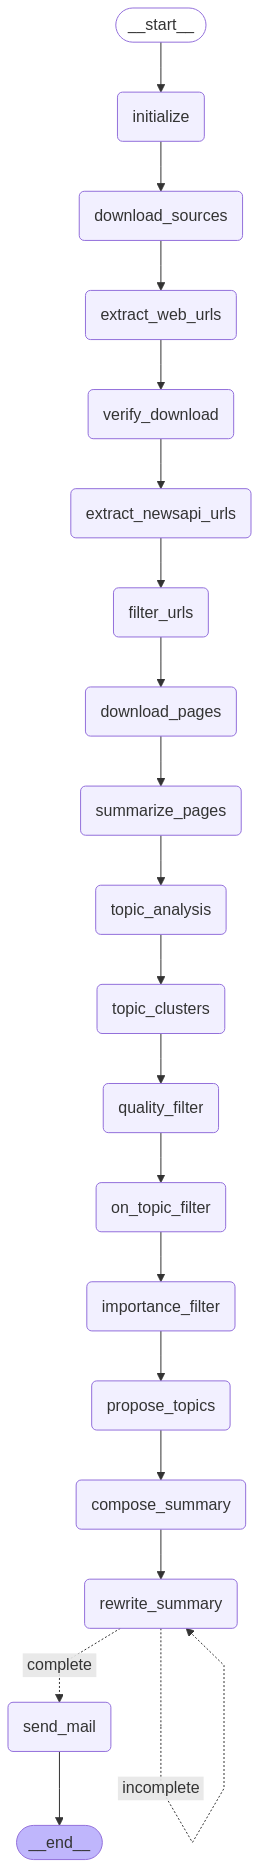

In [4]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

# before_date = None
before_date = '2025-04-24 18:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o3-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=4)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [11]:
lg_state = lg_agent.initialize_config(lg_state)


2025-04-25 13:33:45,712 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-04-25 13:33:45,713 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars Technica.html
2025-04-25 13:33:45,714 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-04-25 13:33:45,714 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business Insider.html
2025-04-25 13:33:45,714 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-04-25 13:33:45,715 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly AI.html
2025-04-25 13:33:45,715 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [12]:
lg_state = lg_agent.download_sources(lg_state)


2025-04-25 13:33:47,132 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-04-25 13:33:47,133 - AInewsbot - INFO - Found 16 previously downloaded files
2025-04-25 13:33:47,133 - AInewsbot - INFO - htmldata/Techmeme (04_25_2025 01_14_05 PM).html
2025-04-25 13:33:47,134 - AInewsbot - INFO - htmldata/VentureBeat (04_25_2025 01_14_25 PM).html
2025-04-25 13:33:47,134 - AInewsbot - INFO - htmldata/New York Times (04_25_2025 01_14_03 PM).html
2025-04-25 13:33:47,134 - AInewsbot - INFO - htmldata/Hacker News 2 (04_25_2025 01_13_51 PM).html
2025-04-25 13:33:47,135 - AInewsbot - INFO - htmldata/Reddit (04_25_2025 01_14_23 PM).html
2025-04-25 13:33:47,135 - AInewsbot - INFO - htmldata/Washington Post (04_25_2025 01_14_39 PM).html
2025-04-25 13:33:47,135 - AInewsbot - INFO - htmldata/Ars Technica (04_25_2025 01_13_39 PM).html
2025-04-25 13:33:47,135 - AInewsbot - INFO - htmldata/HackerNoon (04_25_2025 01_13_53 PM).html
2025-04-25 13:33:47,136 - AInewsbot - INFO - htmlda

In [13]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-04-25 13:33:47,768 - AInewsbot - INFO - Parsing html files
2025-04-25 13:33:47,769 - AInewsbot - INFO - Ars Technica -> htmldata/Ars Technica (04_25_2025 01_13_39 PM).html
2025-04-25 13:33:47,818 - AInewsbot - INFO - parse_file - found 169 raw links
2025-04-25 13:33:47,821 - AInewsbot - INFO - parse_file - found 36 filtered links
2025-04-25 13:33:47,821 - AInewsbot - INFO - 36 links found
2025-04-25 13:33:47,822 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg (04_25_2025 01_13_41 PM).html
2025-04-25 13:33:47,846 - AInewsbot - INFO - parse_file - found 245 raw links
2025-04-25 13:33:47,848 - AInewsbot - INFO - parse_file - found 37 filtered links
2025-04-25 13:33:47,849 - AInewsbot - INFO - 37 links found
2025-04-25 13:33:47,849 - AInewsbot - INFO - Business Insider -> htmldata/Business Insider (04_25_2025 01_13_38 PM).html
2025-04-25 13:33:47,867 - AInewsbot - INFO - parse_file - found 217 raw links
2025-04-25 13:33:47,869 - AInewsbot - INFO - parse_file - found 22 filtered l

In [14]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,36
Bloomberg,31
Business Insider,22
FT,62
Feedly AI,36
Hacker News 1,25
Hacker News 2,24
HackerNoon,18
New York Times,19


number of missing sources 0


set()

In [15]:
lg_state = lg_agent.verify_download(lg_state)


2025-04-25 13:33:52,228 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [16]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-04-25 13:33:54,286 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-04-24T13:33:54 from NewsAPI


In [17]:
# filter by headlines that we haven't seen and that look like AI, we don't want to summarize all before filtering
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-04-25 13:33:56,044 - AInewsbot - INFO - Querying SQLite with where_clause: WHERE timestamp < '2025-04-24 18:00'
2025-04-25 13:33:56,682 - AInewsbot - INFO - URLs in orig_df: 921
2025-04-25 13:33:56,686 - AInewsbot - INFO - Existing URLs in DB: 249374
2025-04-25 13:33:56,748 - AInewsbot - INFO - New URLs in df filtered by URL: 415
2025-04-25 13:33:56,882 - AInewsbot - INFO - Existing src+title: 10
2025-04-25 13:33:56,883 - AInewsbot - INFO - New URLs in df filtered by src+title: 405
2025-04-25 13:33:56,897 - AInewsbot - INFO - Found 403 unique new headlines
2025-04-25 13:33:56,900 - AInewsbot - INFO - Found 401 unique cleaned new headlines
2025-04-25 13:33:58,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:34:03,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:34:03,286 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HT

,id
src,
Ars Technica,3
Bloomberg,5
Business Insider,4
FT,6
Feedly AI,30
Hacker News 1,3
Hacker News 2,3
HackerNoon,1
New York Times,3


2025-04-25 13:34:04,982 - AInewsbot - INFO - get_driver - Initializing webdriver, pid 11719
2025-04-25 13:34:23,678 - AInewsbot - INFO - get_driver - Initialized webdriver profile
2025-04-25 13:34:23,679 - AInewsbot - INFO - get_driver - Initialized webdriver service
2025-04-25 13:35:18,184 - AInewsbot - INFO - get_driver - Initialized webdriver
2025-04-25 13:35:18,188 - AInewsbot - INFO - get_driver - Resizing window


In [18]:
lg_state = lg_agent.download_pages(lg_state)


2025-04-25 13:34:04,979 - AInewsbot - INFO - Queuing URLs for scraping
2025-04-25 13:35:18,788 - AInewsbot - INFO - Processing page 0: https://economictimes.indiatimes.com/news/international/us/2025-nfl-draft-chatgpts-round-1-predictions-vs-reality-the-results-may-surprise-you/articleshow/120588923.cms
2025-04-25 13:35:18,793 - AInewsbot - INFO - Processing page 1: https://biztoc.com/x/526c3da5d9990fc1
2025-04-25 13:35:18,798 - AInewsbot - INFO - Processing page 2: https://scienceblog.com/neuroedge/2025/04/24/ai-fails-to-read-human-social-cues/
2025-04-25 13:35:18,798 - AInewsbot - INFO - Processing page 3: https://elearningindustry.com/ai-lms-how-to-pick-the-best-one-benefits-and-features
2025-04-25 13:35:18,799 - AInewsbot - INFO - get_url(https://economictimes.indiatimes.com/news/international/us/2025-nfl-draft-chatgpts-round-1-predictions-vs-reality-the-results-may-surprise-you/articleshow/120588923.cms) - starting get_url https://economictimes.indiatimes.com/news/international/us/

2025-04-25 13:35:24,223 - AInewsbot - INFO - get_url(https://www.neowin.net/news/adobe-launches-major-firefly-update-featuring-new-image-generation-models-and-more/) - starting get_url https://www.neowin.net/news/adobe-launches-major-firefly-update-featuring-new-image-generation-models-and-more/
2025-04-25 13:35:26,420 - AInewsbot - INFO - get_url(AI-generated images are a legal mess - and still a very human process) - Saving AI-generated_images_are_a_legal_mess_-_and_still_a_very_human_process.html as utf-8
2025-04-25 13:35:26,421 - AInewsbot - INFO - Processing page 14: https://www.reuters.com/business/adobe-adds-ai-models-openai-google-its-firefly-app-2025-04-24/
2025-04-25 13:35:26,421 - AInewsbot - INFO - get_url(https://www.reuters.com/business/adobe-adds-ai-models-openai-google-its-firefly-app-2025-04-24/) - starting get_url https://www.reuters.com/business/adobe-adds-ai-models-openai-google-its-firefly-app-2025-04-24/
2025-04-25 13:35:26,503 - AInewsbot - INFO - get_url(AI to g

2025-04-25 13:35:31,209 - AInewsbot - INFO - get_url(https://t.co/5XBdSbUNg1) - starting get_url https://t.co/5XBdSbUNg1
2025-04-25 13:35:31,521 - AInewsbot - INFO - get_url(As ChatGPT scores B- in engineering, professors scramble to update coursesNow that AI is invading classrooms and homework assignment, students need to learn reasoning more than ever) - Saving As_ChatGPT_scores_B-_in_engineering__professors_scramble_to_update_coursesNow_that_AI_is_invading_classrooms_and_homework_assignment__students_need_to_learn_reasoning_more_than_ever.html as utf-8
2025-04-25 13:35:31,523 - AInewsbot - INFO - Processing page 27: https://www.ft.com/content/c462fbd1-1672-4d8f-bd91-c3aa185d2418
2025-04-25 13:35:31,523 - AInewsbot - INFO - get_url(https://www.ft.com/content/c462fbd1-1672-4d8f-bd91-c3aa185d2418) - starting get_url https://www.ft.com/content/c462fbd1-1672-4d8f-bd91-c3aa185d2418
2025-04-25 13:35:31,651 - AInewsbot - INFO - get_url(Automated Stunning Faceless Videos Creation on a Budget

2025-04-25 13:35:35,631 - AInewsbot - INFO - Processing page 39: https://www.androidheadlines.com/2025/04/deepseek-illegally-sent-data-to-china-south-korean-regulator-says.html
2025-04-25 13:35:35,632 - AInewsbot - INFO - get_url(https://www.androidheadlines.com/2025/04/deepseek-illegally-sent-data-to-china-south-korean-regulator-says.html) - starting get_url https://www.androidheadlines.com/2025/04/deepseek-illegally-sent-data-to-china-south-korean-regulator-says.html
2025-04-25 13:35:35,862 - AInewsbot - INFO - get_url(Chinas Baidu Upgrades Ernie AI Models and Slashes Prices) - Saving Chinas_Baidu_Upgrades_Ernie_AI_Models_and_Slashes_Prices.html as utf-8
2025-04-25 13:35:35,865 - AInewsbot - INFO - Processing page 40: https://www.globenewswire.com/news-release/2025/04/24/3067587/0/en/ESO-Appoints-Silicon-Valley-Tech-Veteran-John-Basmadjian-as-Chief-Product-and-Technology-Officer.html
2025-04-25 13:35:35,867 - AInewsbot - INFO - get_url(https://www.globenewswire.com/news-release/2025/

2025-04-25 13:35:41,723 - AInewsbot - INFO - get_url(Googles AI search numbers are growing, and thats by design) - Saving Googles_AI_search_numbers_are_growing__and_thats_by_design.html as UTF-8
2025-04-25 13:35:41,732 - AInewsbot - INFO - get_url(Generative AI: the catalyst for business transformation) - Saving Generative_AI__the_catalyst_for_business_transformation.html as utf-8
2025-04-25 13:35:41,734 - AInewsbot - INFO - Processing page 51: https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203
2025-04-25 13:35:41,745 - AInewsbot - INFO - get_url(https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203) - starting get_url https://www.wsj.com/tech/ai/ibm-generative-ai-business-f3bf8203
2025-04-25 13:35:41,738 - AInewsbot - INFO - Processing page 52: https://www.theverge.com/news/656044/ziff-davis-sues-openai-ign-cnet-pcmag
2025-04-25 13:35:41,763 - AInewsbot - INFO - get_url(https://www.theverge.com/news/656044/ziff-davis-sues-openai-ign-cnet-pcmag) - starting get_ur

2025-04-25 13:35:51,640 - AInewsbot - INFO - get_url(https://venturebeat.com/games/intels-new-ceo-signals-streamlining-efforts-but-does-not-spell-out-exact-layoff-numbers/) - starting get_url https://venturebeat.com/games/intels-new-ceo-signals-streamlining-efforts-but-does-not-spell-out-exact-layoff-numbers/
2025-04-25 13:35:52,308 - AInewsbot - INFO - get_url(Intel confirms layoffs as it tries to 'make engineers more productive') - Saving Intel_confirms_layoffs_as_it_tries_to__make_engineers_more_productive.html as utf-8
2025-04-25 13:35:52,313 - AInewsbot - INFO - Processing page 64: https://www.ft.com/content/a6ab628b-2218-439a-8ec8-25845cae117a
2025-04-25 13:35:52,315 - AInewsbot - INFO - get_url(https://www.ft.com/content/a6ab628b-2218-439a-8ec8-25845cae117a) - starting get_url https://www.ft.com/content/a6ab628b-2218-439a-8ec8-25845cae117a
2025-04-25 13:35:52,323 - AInewsbot - INFO - get_url(Intel's new CEO signals streamlining efforts but does not spell out exact layoff numbers

2025-04-25 13:35:58,787 - AInewsbot - INFO - get_url(https://www.cnbc.com/2025/04/25/ai-space-meta-llama-iss-booz-allen.html) - starting get_url https://www.cnbc.com/2025/04/25/ai-space-meta-llama-iss-booz-allen.html
2025-04-25 13:35:58,931 - AInewsbot - INFO - get_url(Luminar Neos Spring Update Adds Workflow-Focused AI Enhancements) - Saving Luminar_Neos_Spring_Update_Adds_Workflow-Focused_AI_Enhancements.html as UTF-8
2025-04-25 13:35:58,933 - AInewsbot - INFO - Processing page 77: https://www.talkandroid.com/505430-meta-wants-whatsapp-to-become-your-ai-assistant-heres-why-it-matters/
2025-04-25 13:35:58,933 - AInewsbot - INFO - get_url(https://www.talkandroid.com/505430-meta-wants-whatsapp-to-become-your-ai-assistant-heres-why-it-matters/) - starting get_url https://www.talkandroid.com/505430-meta-wants-whatsapp-to-become-your-ai-assistant-heres-why-it-matters/
2025-04-25 13:35:59,972 - AInewsbot - INFO - get_url(Meta and Booz Allen partner on 'Space Llama' AI program with Nvidia an

2025-04-25 13:36:12,032 - AInewsbot - INFO - get_url(Musks Colossus AI data center is spewing methane from portable gas turbines: report) - Saving Musks_Colossus_AI_data_center_is_spewing_methane_from_portable_gas_turbines__report.html as utf-8
2025-04-25 13:36:12,038 - AInewsbot - INFO - Processing page 89: https://www.theverge.com/news/655784/netflix-subtitle-option-spoken-dialogue-only-english
2025-04-25 13:36:12,042 - AInewsbot - INFO - get_url(https://www.theverge.com/news/655784/netflix-subtitle-option-spoken-dialogue-only-english) - starting get_url https://www.theverge.com/news/655784/netflix-subtitle-option-spoken-dialogue-only-english
2025-04-25 13:36:13,807 - AInewsbot - INFO - get_url(NVIDIA Corporation (NVDA): Among Louis Navelliers Stock Picks with Huge Upside Potential) - Saving NVIDIA_Corporation__NVDA___Among_Louis_Navelliers_Stock_Picks_with_Huge_Upside_Potential.html as utf-8
2025-04-25 13:36:13,815 - AInewsbot - INFO - Processing page 90: https://www.sciencedaily.co

2025-04-25 13:36:23,417 - AInewsbot - INFO - Processing page 101: https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html
2025-04-25 13:36:23,421 - AInewsbot - INFO - get_url(https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html) - starting get_url https://www.nytimes.com/2025/04/24/technology/chatgpt-alexa-please-thank-you.html
2025-04-25 13:36:23,921 - AInewsbot - INFO - get_url(Perplexity will come to Moto phones after exec testified Google limited access) - Saving Perplexity_will_come_to_Moto_phones_after_exec_testified_Google_limited_access.html as utf-8
2025-04-25 13:36:23,929 - AInewsbot - INFO - Processing page 102: https://www.theregister.com/2025/04/24/delinea_securing_genai/
2025-04-25 13:36:23,934 - AInewsbot - INFO - get_url(https://www.theregister.com/2025/04/24/delinea_securing_genai/) - starting get_url https://www.theregister.com/2025/04/24/delinea_securing_genai/
2025-04-25 13:36:25,643 - AInewsbot - INFO - get_url

2025-04-25 13:36:30,970 - AInewsbot - INFO - get_url(https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-google-expands-ai-and-generative-ghosts-are-coming/) - starting get_url https://www.pymnts.com/artificial-intelligence-2/2025/this-week-in-ai-google-expands-ai-and-generative-ghosts-are-coming/
2025-04-25 13:36:32,241 - AInewsbot - INFO - get_url(Teaching AI morality like a child: DeepMind CEO Demis Hassabis talks of ethical use of AI) - Saving Teaching_AI_morality_like_a_child__DeepMind_CEO_Demis_Hassabis_talks_of_ethical_use_of_AI.html as utf-8
2025-04-25 13:36:32,249 - AInewsbot - INFO - Processing page 114: https://www.bloomberg.com/news/articles/2025-04-25/trump-administration-pressures-europe-to-reject-ai-rulebook
2025-04-25 13:36:32,252 - AInewsbot - INFO - get_url(https://www.bloomberg.com/news/articles/2025-04-25/trump-administration-pressures-europe-to-reject-ai-rulebook) - starting get_url https://www.bloomberg.com/news/articles/2025-04-25/trump-administ

2025-04-25 13:36:38,077 - AInewsbot - INFO - Processing page 125: https://www.zdnet.com/article/want-to-try-chatgpts-deep-research-tool-for-free-check-out-the-lightweight-version/
2025-04-25 13:36:38,087 - AInewsbot - INFO - get_url(https://www.zdnet.com/article/want-to-try-chatgpts-deep-research-tool-for-free-check-out-the-lightweight-version/) - starting get_url https://www.zdnet.com/article/want-to-try-chatgpts-deep-research-tool-for-free-check-out-the-lightweight-version/
2025-04-25 13:36:38,226 - AInewsbot - INFO - get_url(Verana Health Launches Qdata Cataracts, the Largest Dataset of Its Kind for Cataract Research) - Saving Verana_Health_Launches_Qdata_Cataracts__the_Largest_Dataset_of_Its_Kind_for_Cataract_Research.html as UTF-8
2025-04-25 13:36:38,227 - AInewsbot - INFO - Processing page 126: https://www.theverge.com/news/656267/waymo-self-driving-car-personal-long-term-business-earnings
2025-04-25 13:36:38,227 - AInewsbot - INFO - get_url(https://www.theverge.com/news/656267/w

In [19]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-04-25 13:37:16,752 - AInewsbot - INFO - Starting summarize
2025-04-25 13:37:16,755 - AInewsbot - INFO - Fetching summaries for all articles
2025-04-25 13:37:16,919 - AInewsbot - INFO - clean_html - Page title: NFL Draft Round 1 predictions: 2025 NFL Draft: ChatGPT’s Round 1 predictions vs. reality — The results may surprise you - The Economic Times
Social card title: 2025 NFL Draft: ChatGPT’s Round 1 predictions vs. reality — The results may surprise you
Social card description: Fans of the National Football League are keenly waiting for Round 1 of the NFL Draft 2025, which will begin on April 24. After this, the second and third rounds will take place on Friday, April 25, followed by the remaining rounds (4-7) on Saturday.

2025-04-25 13:37:17,368 - AInewsbot - INFO - Queuing 0: Page title: NFL Draft Round 1 predictions: 2025 NF...
2025-04-25 13:37:17,373 - AInewsbot - INFO - clean_html - Page title: A16z Unleashes $20 Billion AI Fund Fueled By 20,000 Nvidia GPUs As Marc Andreess

2025-04-25 13:37:18,661 - AInewsbot - INFO - Queuing 14: Page title: Adobe adds AI models from OpenAI, Goog...
2025-04-25 13:37:18,676 - AInewsbot - INFO - clean_html - Page title: Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE
Social card title: Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE
Social card description: Adobe unveils new Firefly generative AI models and creative tools - SiliconANGLE

2025-04-25 13:37:18,697 - AInewsbot - INFO - Queuing 15: Page title: Adobe unveils new Firefly generative A...
2025-04-25 13:37:18,701 - AInewsbot - INFO - clean_html - Page title: Aivre slashes appraisal time by 50% with
Social card title: Aivre slashes appraisal time by 50% with Restb.ai's computer vision tech, saving over 3 hours per report
Social card description: Appraisal software company Aivre has cut the time to complete an appraisal by more than half by integrating with Restb.ai’s computer vision tech....

2025-04-25

2025-04-25 13:37:19,254 - AInewsbot - INFO - Queuing 32: Page title: ChatGPT Is Crushing Google in AI. Unle...
2025-04-25 13:37:19,268 - AInewsbot - INFO - clean_html - Page title: ChatGPT is getting a ‘lightweight’ version of its deep research tool | The Verge
Social card title: ChatGPT is getting a ‘lightweight’ version of its deep research tool
Social card description: Deep but light.

2025-04-25 13:37:19,290 - AInewsbot - INFO - Queuing 33: Page title: ChatGPT is getting a ‘lightweight’ ver...
2025-04-25 13:37:19,309 - AInewsbot - INFO - clean_html - Page title: ChatGPT’s Massively Popular Image Generation Available Via API for Verified Users’ Creations | TechRepublic
Social card title: ChatGPT’s Massively Popular Image Generation Available Via API for Verified Users’ Creations | TechRepublic
Social card description: OpenAI recently integrated ChatGPT’s image generation functionality into its API for use in custom tools and platforms.

2025-04-25 13:37:19,322 - AInewsbot - INFO - Q

2025-04-25 13:37:19,931 - AInewsbot - INFO - clean_html - Page title: wsj.com

2025-04-25 13:37:20,007 - trafilatura.core - WARNING - discarding data: None
2025-04-25 13:37:20,008 - AInewsbot - INFO - Queuing 51: Page title: wsj.com
...
2025-04-25 13:37:20,030 - AInewsbot - INFO - clean_html - Page title: IGN and CNET owner Ziff Davis sues OpenAI | The Verge
Social card title: IGN and CNET owner Ziff Davis sues OpenAI
Social card description: The maker of ChatGPT is facing another lawsuit.

2025-04-25 13:37:20,055 - AInewsbot - INFO - Queuing 52: Page title: IGN and CNET owner Ziff Davis sues Ope...
2025-04-25 13:37:20,062 - AInewsbot - INFO - clean_html - Page title: If A.I. Systems Become Conscious, Should They Have Rights? - The New York Times
Social card title: If A.I. Systems Become Conscious, Should They Have Rights?
Social card description: As artificial intelligence systems become smarter, one A.I. company is trying to figure out what to do if they become conscious.

2025-04-25

2025-04-25 13:37:20,477 - AInewsbot - INFO - Queuing 68: Page title: Israel’s A.I. Experiments in Gaza War ...
2025-04-25 13:37:20,497 - AInewsbot - INFO - clean_html - Page title: ChatGPT price: Free tier might get ads soon
Social card title: It sure looks like ChatGPT Free is getting ads soon
Social card description: OpenAI is apparently considering bringing ads to the ChatGPT Free tier, and it might happen sooner than you think.

2025-04-25 13:37:20,517 - AInewsbot - INFO - Queuing 69: Page title: ChatGPT price: Free tier might get ads...
2025-04-25 13:37:20,532 - AInewsbot - INFO - clean_html - Page title: Jericho Security raises $15M to enhance AI-powered employee cybersecurity training - SiliconANGLE
Social card title: Jericho Security raises $15M to enhance AI-powered employee cybersecurity training - SiliconANGLE
Social card description: Jericho Security raises $15M to enhance AI-powered employee cybersecurity training - SiliconANGLE

2025-04-25 13:37:20,551 - AInewsbot - INFO 

2025-04-25 13:37:21,105 - AInewsbot - INFO - Queuing 86: Page title: Musk’s “Colossus” AI data center is sp...
2025-04-25 13:37:21,141 - AInewsbot - INFO - clean_html - Page title: MyPillow CEO in Hot Water for Disastrous AI-Generated Legal Filing | The New Republic
Social card title: MyPillow CEO in Hot Water for Disastrous AI-Generated Legal Filing
Social card description: A judge reprimanded Mike Lindell and his lawyers for the mistake-riddled document.

2025-04-25 13:37:21,183 - AInewsbot - INFO - Queuing 87: Page title: MyPillow CEO in Hot Water for Disastro...
2025-04-25 13:37:21,219 - AInewsbot - INFO - clean_html - Page title: NVIDIA Corporation (NVDA): Among Louis Navellier’s Stock Picks with Huge Upside Potential
Social card title: NVIDIA Corporation (NVDA): Among Louis Navellier’s Stock Picks with Huge Upside Potential
Social card description: We recently published a list of Louis Navellier’s 10 Stock Picks with Huge Upside Potential. In this article, we are going to take a 

2025-04-25 13:37:22,059 - AInewsbot - INFO - Queuing 100: Page title: [2503.19779] PyGraph: Robust Compiler ...
2025-04-25 13:37:22,066 - AInewsbot - INFO - clean_html - Page title: Saying ‘Thank You’ to ChatGPT Is Costly. But Maybe It’s Worth the Price. - The New York Times
Social card title: Saying ‘Thank You’ to ChatGPT Is Costly. But Maybe It’s Worth the Price.
Social card description: Adding words to our chatbot can apparently cost tens of millions of dollars. But some fear the cost of not saying please or thank you could be higher.

2025-04-25 13:37:22,078 - AInewsbot - INFO - Queuing 101: Page title: Saying ‘Thank You’ to ChatGPT Is Costl...
2025-04-25 13:37:22,085 - AInewsbot - INFO - clean_html - Page title: A strategic framework for leaders to secure generative AI • The Register
Social card title: A strategic framework for leaders to secure generative AI
Social card description: Partner content: Navigate the complexities of GenAI adoption with a comprehensive framework that i

2025-04-25 13:37:22,650 - AInewsbot - INFO - Queuing 118: Page title: AI's toll on humanity, the environment...
2025-04-25 13:37:22,657 - AInewsbot - INFO - clean_html - Page title: UPDATE -- Rezolve Ai Smashes Past $50 Billion in GMV in
Social card title: UPDATE -- Rezolve Ai Smashes Past $50 Billion in GMV in Explosive Start to 2025, Over 50 Major Enterprises Now Live and Scaling
Social card description: Now embedded on over 41.9 million consumer devices with 16.5 million monthly active usersDelivering 8 billion+ API calls and 27.9 million GeoZone triggers...

2025-04-25 13:37:22,669 - AInewsbot - INFO - Queuing 119: Page title: UPDATE -- Rezolve Ai Smashes Past $50 ...
2025-04-25 13:37:22,683 - AInewsbot - INFO - clean_html - Page title: Subscribe to read
Social card title: US to loosen rules on self-driving vehicles criticised by Elon Musk
Social card description: National Highway Traffic Safety Administration will make it easier to get autonomous cars on the road

2025-04-25 13:37

2025-04-25 13:37:23,355 - AInewsbot - INFO - Queuing 134: Page title: Publisher of PCMag and Mashable Sues O...
2025-04-25 13:37:24,291 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:24,346 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:24,392 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:24,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:24,415 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:24,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:24,479 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:24,489 - httpx - INFO - 

2025-04-25 13:37:26,399 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:26,401 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:26,405 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:26,412 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:26,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:26,447 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:26,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:26,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:26,472 - httpx 

2025-04-25 13:37:29,281 - AInewsbot - INFO - Received 135 summaries
2025-04-25 13:37:29,282 - AInewsbot - INFO - Summary for 0 (length 2942): • ChatGPT's predictions for the 2025 NFL Draft's first round included Jacksonville Jaguars selecting Travis Hunter, Tennessee Titans picking Cam Ward (predicted as No. 2 pick, though most mock drafts have him at No. 1), and New York Giants selecting Shedeur Sanders at No. 3 for his "accuracy" and "poise."
• Several predictions by ChatGPT were incorrect, such as the Carolina Panthers picking Carson Beck at No. 4 (despite not having that pick), and the New England Patriots picking Abdul Carter at No. 5 instead of their actual No. 4 spot.
• The 2025 NFL Draft will begin Round 1 at 8 PM ET on April 24, with subsequent rounds on April 25 and 26; live coverage will be available on NFL Network, ESPN, and Fubo.
2025-04-25 13:37:29,282 - AInewsbot - INFO - Summary for 1 (length 1492): • Andreessen Horowitz (a16z) is in early talks to raise a $20 billion f

2025-04-25 13:37:29,285 - AInewsbot - INFO - Summary for 10 (length 5050): • The UK's Copyright Licensing Agency (CLA) plans to launch a Generative AI Training Licence in Q3 2025, allowing large language model (LLM) developers to legally use copyrighted works for AI training while compensating authors and publishers.  
• The license aims to provide “legal certainty” for AI developers and ensure creators are paid, including those who cannot directly negotiate licensing deals; it will be supported by other UK licensing organizations.  
• The CLA argues that licensing is a practical alternative to government-proposed copyright exceptions for text and data mining, offering both prospective and retrospective rights coverage for AI developers using copyrighted content.  
• This development comes amid ongoing controversy regarding the alleged use of copyrighted materials for AI training by major tech companies, and UK government consultations proposing copyright exemptions for AI.
2025-04-25 

2025-04-25 13:37:29,289 - AInewsbot - INFO - Summary for 21 (length 519): no content
2025-04-25 13:37:29,289 - AInewsbot - INFO - Summary for 22 (length 5973): • Researchers at Mass General Brigham, Boston Children's Hospital, and Dana-Farber/Boston Children's developed and validated a deep learning model using temporal learning to predict recurrence of pediatric glioma from post-treatment brain scans with up to 89% accuracy.  
• The model was trained on nearly 4,000 MRI scans from 715 pediatric patients, with improved accuracy achieved by analyzing multiple scans over time rather than just single images.  
• "It is very difficult to predict who may be at risk of recurrence... We need better tools to identify early which patients are at the highest risk of recurrence," said corresponding author Dr. Benjamin Kann; further clinical validation is planned before implementation.
2025-04-25 13:37:29,290 - AInewsbot - INFO - Summary for 23 (length 9154): • A pilot study at the University of I

2025-04-25 13:37:29,291 - AInewsbot - INFO - Summary for 34 (length 3006): • OpenAI has integrated ChatGPT’s image generation capability into its API with the release of the gpt-image-1 model, allowing developers to add image generation to their own tools and platforms.
• Major companies such as Adobe, Figma, HeyGen, and Quora have already implemented gpt-image-1, while Canva, GoDaddy, and HubSpot are experimenting with the technology.
• The gpt-image-1 model includes safety controls to prevent harmful imagery, and pricing is structured per token: $5 per 1 million text input tokens, $10 per 1 million image input tokens, and $40 per 1 million image output tokens.
2025-04-25 13:37:29,292 - AInewsbot - INFO - Summary for 35 (length 937): no content
2025-04-25 13:37:29,292 - AInewsbot - INFO - Summary for 36 (length 519): no content
2025-04-25 13:37:29,292 - AInewsbot - INFO - Summary for 37 (length 519): no content
2025-04-25 13:37:29,292 - AInewsbot - INFO - Summary for 38 (length 6863):

2025-04-25 13:37:29,293 - AInewsbot - INFO - Summary for 46 (length 7036): • Generative AI is driving rapid business transformation, with 92% of companies planning to increase AI investments in the next three years (McKinsey & Co) and 93% of executives aiming to boost AI spending (OutSystems/KPMG report).
• Generative AI, especially when combined with low-code platforms, significantly accelerates software development and digital transformation, reducing timelines from years to months, but 52% of AI projects still fail to reach production (Gartner).
• The adoption of generative AI introduces risks such as technical debt, orphaned code, and security concerns, making robust governance and compliance frameworks essential for maintaining quality, security, and competitive edge.
2025-04-25 13:37:29,294 - AInewsbot - INFO - Summary for 47 (length 2490): • Google reports that its AI Overviews feature in Search is now used by over 1.5 billion users monthly in more than 100 countries, with expan

2025-04-25 13:37:29,296 - AInewsbot - INFO - Summary for 59 (length 13182): • Intel CEO Lip-Bu Tan announced that employees will be required to work in the office four days per week, up from three, effective September 1, as part of broader efforts to streamline the company and "flatten organization" by reducing bureaucracy and team layers.

• Tan stated that while there is no set headcount reduction target, workforce reductions will begin in Q2 2025 and be managed by individual leaders, emphasizing, "the best leaders get the most done with the fewest people."

• Intel reported a $0.4 billion loss on flat $12.7 billion revenue for Q1 2025, aims to save an extra $0.5 billion in 2025, and will focus on cost-cutting, engineering empowerment, and simplifying corporate administrative tasks as part of a new company strategy.
2025-04-25 13:37:29,296 - AInewsbot - INFO - Summary for 60 (length 3800): • Intel has confirmed it will lay off an unspecified number of employees as part of a restructu

2025-04-25 13:37:29,298 - AInewsbot - INFO - Summary for 72 (length 4535): • Koelis announced a partnership with Bot Image™ to integrate Bot Image's FDA-cleared ProstatID™ AI software into Koelis' Trinity® MRI-fusion guidance system, enhancing precision in prostate biopsy and treatment.
• The combined system offers automated MRI-based lesion detection, classification, 3D mapping, and segmentation, aiming to improve workflow efficiency for radiologists and urologists; it will be demonstrated at the AUA 2025 conference in Las Vegas.
• Dr. Jamil Syed described the integration as "a game changer" for urologists, while Bot Image CEO Dr. Randall Jones highlighted ProstatID™'s 93.6% sensitivity-specificity, stating its capability to provide comprehensive lesion analysis and risk assessment surpasses competing products.
2025-04-25 13:37:29,298 - AInewsbot - INFO - Summary for 73 (length 3012): • Skylum has released a Spring update for its Luminar Neo photo editing software, introducing new AI-

2025-04-25 13:37:29,300 - AInewsbot - INFO - Summary for 83 (length 1882): • Microsoft has officially released the Windows Recall feature to the public, nearly a year after announcing it, making it available only on Copilot+ PCs running Windows 11.
• Recall captures continuous screenshots of user activity and saves them in a searchable database, raising significant security and privacy concerns that led to criticism and delays in its rollout.
• After a major security overhaul and five months of Windows Insider beta testing, Microsoft now requires users to opt in to Recall, allows for its complete removal, and has improved, but not perfected, automated content filtering to avoid storing sensitive information.
2025-04-25 13:37:29,300 - AInewsbot - INFO - Summary for 84 (length 519): no content
2025-04-25 13:37:29,300 - AInewsbot - INFO - Summary for 85 (length 5051): • Microsoft has begun gradually rolling out the Recall feature and improved Windows Search to Copilot+ AI PCs, almost a ye

2025-04-25 13:37:29,301 - AInewsbot - INFO - Summary for 95 (length 5347): • Paradigm led a $50 million Series A funding round for decentralized AI startup Nous Research, raising the company's yet-to-launch token valuation to $1 billion.
• Nous Research, founded in 2023, is developing open-source, decentralized AI models leveraging blockchain (primarily Solana) to incentivize shared computing power and ensure transparent training, positioning itself as an alternative to centralized platforms like OpenAI.
• The company announced the testnet launch of its Psyche Network, which connects diverse GPU hardware for collaborative, censorship-resistant AI training, and will use the new funding to expand R&D, build out the Psyche infrastructure, and grow its engineering team.
2025-04-25 13:37:29,301 - AInewsbot - INFO - Summary for 96 (length 4570): • Perplexity AI announced a partnership to integrate its AI search engine into Motorola smartphones, making Motorola the first to embed Perplexity d

2025-04-25 13:37:29,303 - AInewsbot - INFO - Summary for 109 (length 3457): • The US National Highway Traffic Safety Administration (NHTSA) will loosen rules to make it easier to deploy self-driving cars, reducing crash reporting requirements and enabling exemptions for non-standard vehicles used in research and demonstrations.

• These regulatory changes were central demands of Tesla CEO Elon Musk, who has criticized the patchwork of state and local rules and stringent crash reporting as obstacles to scaling autonomous vehicles; the agency currently has eight open probes into Tesla crashes, five involving Autopilot and Full Self-Driving.

• US Transportation Secretary Sean Duffy stated, “Our new framework will slash red tape and move us closer to a single national standard that spurs innovation and prioritises safety,” as the administration aims to compete with China in autonomous vehicle development.
2025-04-25 13:37:29,303 - AInewsbot - INFO - Summary for 110 (length 17778): • Hidde

2025-04-25 13:37:29,304 - AInewsbot - INFO - Summary for 119 (length 9193): • Rezolve Ai (NASDAQ: RZLV) announced explosive early 2025 growth, with over $50 billion in gross merchandise value (GMV) processed year-to-date, 16.5 million monthly active users, and presence on 41.9 million consumer devices; the platform is now live with more than 50 major enterprise customers including Liverpool, KFC, Ace Hardware, and Coles.  
• The company converted $59 million in debt to equity, raised $15 million in growth capital, completed a NASDAQ listing in August 2024, and formed partnerships with Microsoft and Google, strengthening its financial position and strategic prospects.  
• Rezolve secured a $9.8 million annual contract with Liverpool Mexico and expects to reach its $100 million estimated Annual Recurring Revenue (ARR) target by the end of 2025, citing strong customer adoption and measurable uplifts in retail performance metrics.
2025-04-25 13:37:29,304 - AInewsbot - INFO - Summary for 12

2025-04-25 13:37:29,306 - AInewsbot - INFO - Summary for 131 (length 1883): • YouTube is testing an AI Overviews carousel in search results, which uses AI to highlight the most relevant video clips for certain queries and presents them in a carousel format.  
• The experiment is currently limited to a small group of U.S. YouTube Premium members and only applies to some English-language search queries.  
• YouTube will gather user feedback on the feature, and insights from the test will guide decisions on a potential broader rollout.
2025-04-25 13:37:29,306 - AInewsbot - INFO - Summary for 132 (length 2400): • YouTube is testing AI-generated highlight clip reels, called AI Overviews, for a limited number of YouTube Premium members in the US on select English search queries.

• The feature uses AI to highlight video clips most relevant to a user’s search, primarily for searches related to products or locations, according to a statement on YouTube Community forums.

• Google is collecting

In [20]:
# with open('my_dict.pkl', 'wb') as f:
#     pickle.dump(state, f)

# with open('my_dict.pkl', 'rb') as f:
#     state = pickle.load(f)


In [21]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered 
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-04-25 13:37:29,347 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-04-25 13:37:36,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:36,234 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:36,380 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:37,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:37,921 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:38,060 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:40,086 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:

2025-04-25 13:37:40,121 - AInewsbot - INFO - Canonical topic intel
2025-04-25 13:37:40,121 - AInewsbot - INFO - Canonical topic nvidia
2025-04-25 13:37:40,121 - AInewsbot - INFO - Canonical topic speech recognition & synthesis
2025-04-25 13:37:40,121 - AInewsbot - INFO - Canonical topic ai in healthcare
2025-04-25 13:37:40,122 - AInewsbot - INFO - Canonical topic reinforcement learning
2025-04-25 13:37:40,122 - AInewsbot - INFO - Canonical topic luminar neo
2025-04-25 13:37:40,122 - AInewsbot - INFO - Canonical topic supply chain optimization
2025-04-25 13:37:40,123 - AInewsbot - INFO - Canonical topic large language models
2025-04-25 13:37:40,123 - AInewsbot - INFO - Canonical topic ai doom
2025-04-25 13:37:40,124 - AInewsbot - INFO - Canonical topic market trends
2025-04-25 13:37:40,124 - AInewsbot - INFO - Canonical topic infrastructure
2025-04-25 13:37:40,124 - AInewsbot - INFO - Canonical topic corporate strategy
2025-04-25 13:37:40,124 - AInewsbot - INFO - Canonical topic venture

2025-04-25 13:37:47,312 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,360 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,382 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,383 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,426 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,447 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,474 - httpx 

2025-04-25 13:37:47,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,853 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,854 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,864 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,864 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:47,873 - httpx 

2025-04-25 13:37:48,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,067 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,073 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,074 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,075 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,081 - httpx 

2025-04-25 13:37:48,244 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,252 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,258 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,260 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,261 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,263 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,265 - httpx 

2025-04-25 13:37:48,407 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,409 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,413 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,418 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,422 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,423 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,427 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,428 - httpx 

2025-04-25 13:37:48,563 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,566 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,567 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,572 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,572 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,573 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,576 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,576 - httpx 

2025-04-25 13:37:48,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,719 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,720 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,720 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,723 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,731 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,732 - httpx 

2025-04-25 13:37:48,866 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,872 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,873 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,875 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:48,877 - httpx 

2025-04-25 13:37:49,055 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,058 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,071 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,082 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,092 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,097 - httpx 

2025-04-25 13:37:49,272 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,286 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,287 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,296 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,303 - httpx 

2025-04-25 13:37:49,568 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,572 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,574 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,605 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,608 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,616 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:49,617 - httpx 

2025-04-25 13:37:50,004 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,007 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,011 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,015 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,017 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,043 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,051 - httpx 

2025-04-25 13:37:50,609 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,613 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,623 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,636 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,643 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,645 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:50,668 - httpx 

2025-04-25 13:37:51,297 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:51,304 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:51,312 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:51,320 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:51,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:51,333 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:51,335 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:51,337 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:51,339 - httpx 

2025-04-25 13:37:52,238 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:52,241 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:52,312 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:52,322 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:52,357 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:52,367 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:52,371 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:52,377 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:52,394 - httpx 

2025-04-25 13:37:54,379 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:54,391 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:54,706 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:54,713 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:54,741 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:55,116 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:55,125 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:55,128 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:37:55,202 - httpx 

In [22]:
lg_state = lg_agent.topic_clusters(lg_state)


2025-04-25 13:37:59,158 - AInewsbot - INFO - Fetching embeddings for 135 headlines
2025-04-25 13:38:02,695 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-04-25 13:38:03,344 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-04-25 13:38:03,382 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-04-25 13:38:04,665 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-04-25 13:38:06,000 - AInewsbot - INFO - Cluster with DBSCAN
2025-04-25 13:38:06,109 - AInewsbot - INFO - Found 11 clusters


,title_topic_str
0,"ChatGPTs Massively Popular Image Generation Available Via API for Verified Users Creations (Topics: Adobe Firefly, AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Api Integration, Art & Design, Chatbots, Chatgpt, Computer Vision, Corporate Strategy, Creative Tools, Deals, Entertainment, Ethical AI, Finance, Gen AI, Generative AI, Gpt-Image-1, Image Generation, Language Models, Large Language Models, Machine Learning, Market Growth, Market Trends, Meta, OpenAI, Perplexity AI, Photo Editing, Products, Safety And Alignment, Safety Controls, Software Development, Software Update, Virtual & Augmented Reality, Virtual Assistants)"
1,"Evil Geniuses and Theta Labs launch AI chatbot based on esports mascot Meesh (Topics: AI Applications, AI Assistant, AI Automation, AI Chatbot, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Chatbots, Corporate Strategy, Customer Service, Entertainment, Esports, Evil Geniuses, Fan Engagement, Gaming, Gen AI, Generative AI, History, Infrastructure, Machine Learning, Safety And Alignment, Society & Culture, Sports, Theta Labs, Virtual Assistants)"
2,"ChatGPT is getting a lightweight version of its deep research tool (Topics: AI Accessibility, AI Applications, AI Assistant, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Chatbots, Chatgpt, Copilot Plus, Deep Research Tool, Education, Gen AI, Generative AI, Language Models, Large Language Models, Machine Learning, Meta, OpenAI, Operational Costs, Perplexity AI, Software Development, Software Update, Virtual Assistants)"
3,"ChatGPT is crushing Google in the AI race. Unless you look at the data differently. (Topics: AI Applications, AI Assistant, AI Automation, AI Competition, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Chatbots, Chatgpt, Corporate Strategy, Economics, Gen AI, Generative AI, Google Gemini, Governance, Language Models, Large Language Models, Legal Issues, Machine Learning, OpenAI, Opinion, Policy And Regulation, Politics, Regulatory Challenges, User Engagement, Virtual Assistants)"
4,"Saying Thank You to ChatGPT Is Costly. But Maybe Its Worth the Price. (Topics: AI Applications, AI Assistant, AI Automation, AI Economic Costs, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Chatbots, Chatgpt, Climate, Economics, Energy, Ethics, Finance, Gen AI, Generative AI, Language Models, Large Language Models, OpenAI, Opinion, Politeness In AI, Social Implications Of AI, Society & Culture, Sustainability, Virtual Assistants)"
5,"2025 NFL Draft: ChatGPTs Round 1 predictions vs. reality The results may surprise you (Topics: AI Assistant, AI Features, Chatbots, Chatgpt, Gen AI, Generative AI, Large Language Models, Nfl Draft, OpenAI, Predictions, Sports, Team Selections)"
6,"Want to try ChatGPT's Deep Research tool for free? Check out the lightweight version (Topics: AI Applications, AI Assistant, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Cognitive Science, Creative Tools, Deep Research Tool, Deepseek, Education, Gen AI, Generative AI, Language Models, Large Language Models, Lightweight Version, Machine Learning, Meta, OpenAI, Perplexity, Perplexity AI, Retrieval Augmented Generation, Software Development, Software Update, Speech Recognition & Synthesis, Subscription Model, Virtual Assistants)"
7,"It sure looks like ChatGPT Free is getting ads soon (Topics: Ads, AI Assistant, AI Research, AI Technology, Artificial General Intelligence, Chatbots, Chatgpt, Code Assistants, Corporate Strategy, Economics, Finance, Gen AI, Generative AI, Language Models, Large Language Models, Machine Learning, Market Growth, Market Trends, Monetization, OpenAI, Perplexity, Products, User Growth, Virtual Assistants)"
8,"As ChatGPT scores B- in engineering, professors scramble to update 

2025-04-25 13:38:06,846 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:06,871 - AInewsbot - INFO - I dub this cluster: Recent Developments in ChatGPT and AI


,title_topic_str
9,"Avoiding Skill Atrophy in the Age of AI (Topics: AI Applications, AI Assistant, AI Automation, AI Coding Assistants, AI Doom, AI Features, AI Integration, AI Limitations, AI Overviews, AI Research, AI Technology, Code Assistants, Cognitive Science, Critical Thinking, Developer Skills, Economics, Ethical AI, Ethics, Gen AI, Generative AI, Job Automation, Jobs & Careers, Labor Market, Machine Learning, Microsoft, Opinion, Problem-Solving, Recall, Review, Safety And Alignment, Skill Atrophy, Society & Culture, Software Development, Software Update, Virtual Assistants)"
10,"AI LMS: How To Pick The Best One, Benefits And Features (Topics: Adaptive Learning, AI Applications, AI Automation, AI Features, AI Integration, AI Learning Management Systems, AI Overviews, AI Research, AI Technology, Corporate Strategy, Corporate Training, Creative Tools, Data-Driven Insights, Education, Gen AI, Job Automation, Jobs & Careers, Labor Market, Machine Learning, Personalized Learning, Products, Recommendation Systems, Review, Software Development, Testing)"
11,"Inflexion Group partners with AI&Beyond to launch AI literacy training (Topics: AI Applications, AI Automation, AI Features, AI Integration, AI Literacy, AI Overviews, AI Research, AI Technology, AI Training, Bias And Fairness, Corporate Strategy, Critical Thinking, Education, Ethical AI, Ethics, Gen AI, Gen AI, Generative AI, Governance, India, Inflexion Group, Jobs & Careers, Machine Learning, Perplexity, Policy And Regulation, Safety And Alignment)"


2025-04-25 13:38:07,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:07,512 - AInewsbot - INFO - I dub this cluster: Advancing AI Skills and Education


,title_topic_str
12,"AI Supercomputers May Run Into Power Constraints by 2030 (Topics: AI Applications, AI Automation, AI Features, AI Limitations, AI Overviews, AI Research, AI Supercomputers, AI Technology, Artificial General Intelligence, Chip Requirements, Computational Performance, Decentralized AI, Decentralized Training, Energy, Gen AI, Hardware, Machine Learning, Market Growth, Nuclear, Power Constraints, Semiconductor Chips)"
13,"Meta's data center could be 'transformative' for Louisiana, utility saysas long as customers pay the $5 billion power bill (Topics: AI Applications, AI Automation, AI Data Center, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Climate, Corporate Strategy, Economics, Energy, Energy Infrastructure, Entergy Louisiana, Finance, Funding, Gen AI, Governance, Hardware, Inequality, Infrastructure, Legal Issues, Machine Learning, Market Growth, Market Trends, Meta, Policy And Regulation, Politics, Power Costs, Regulatory Challenges, Sustainability)"
14,U.S. Needs More Power for AIbut Critical Equipment Is Pricey and Scarce (Topics: )


2025-04-25 13:38:08,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:08,128 - AInewsbot - INFO - I dub this cluster: Power Challenges for AI Infrastructure


,title_topic_str
15,"Artificial intelligence tool helps predict relapse of pediatric brain cancer (Topics: AI Applications, AI Automation, AI Features, AI In Healthcare, AI Integration, AI Overviews, AI Research, AI Technology, Cognitive Science, Computer Vision, Deep Learning, Gen AI, Health & Fitness, Healthcare, Machine Learning, Mass General Brigham, Medical Imaging, Pediatric Brain Cancer, Recurrence Prediction, Testing)"
16,"ChatGPT Diagnoses Woman With Cancer, Year Later, Doctors Confirm It (Topics: AI Applications, AI Assistant, AI Automation, AI Features, AI In Healthcare, AI Integration, AI Overviews, AI Research, AI Technology, Cancer Detection, Chatbots, Chatgpt, Cognitive Science, Consciousness, Ethical AI, Ethics, European Union, Gen AI, Generative AI, Health & Fitness, Health Diagnostics, Healthcare, Language Models, Large Language Models, Machine Learning, OpenAI, Opinion, Patient Case Study, Society & Culture, Virtual Assistants)"
17,"Verana Health Launches Qdata Cataracts, the Largest Dataset of Its Kind for Cataract Research (Topics: AI Applications, AI Automation, AI Features, AI In Healthcare, AI Integration, AI Overviews, AI Research, AI Techniques, AI Technology, Cataract Research, Clinical Outcomes, Deep Research Tool, Funding, Gen AI, Generative AI, Health & Fitness, Healthcare, Machine Learning, Market Growth, Qdata Cataracts, Testing, Verana Health)"
18,"AI algorithm can help identify high-risk heart patients to quickly diagnose, expedite, and improve care (Topics: AI Applications, AI Automation, AI Features, AI In Healthcare, AI Integration, AI Overviews, AI Research, AI Technology, Cardiology, Deep Research Tool, Gen AI, Health & Fitness, Healthcare, Heart Disease, Machine Learning, Risk Stratification, Safety And Alignment)"


2025-04-25 13:38:09,554 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:09,561 - AInewsbot - INFO - I dub this cluster: AI Transforming Healthcare Diagnosis


,title_topic_str
19,"Adobe unveils new Firefly generative AI models and creative tools (Topics: Adobe Firefly, AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Art & Design, Artificial General Intelligence, Bias And Fairness, Chatgpt, Code Assistants, Computer Vision, Content Authentication, Creative App, Creative Tools, Data Privacy, Entertainment, Gen AI, Generative AI, Generative AI Models, Hardware, Image Generation, Machine Learning, Market Trends, OpenAI, Photo Editing, Privacy, Privacy Concerns, Products, Review, Safety And Alignment, Software Development, Software Update, Streaming, Tv & Film & Movies, Video Generation, Virtual & Augmented Reality)"
20,"Adobe launches major Firefly update featuring new image generation models and more (Topics: Adobe Firefly, AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Art & Design, Artificial General Intelligence, Chatgpt, Code Assistants, Computer Vision, Creative Tools, Entertainment, Gen AI, Generative AI, Hardware, Image Generation, Machine Learning, Market Trends, OpenAI, Photo Editing, Products, Review, Software Development, Software Update, Streaming, Tv & Film & Movies, Virtual & Augmented Reality)"
21,"Luminar Neo Update Brings AI Auto Adjust, Realistic Fog, and Speed Boosts (Topics: AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Art & Design, Computer Vision, Creative Tools, Gen AI, Image Generation, Lifestyle & Travel, Luminar Neo, Machine Learning, Photo Editing, Products, Review, Software Development, Software Update, Workflow Enhancements)"
22,"Adobe says Firefly users can now generate images using OpenAI's GPT, Google's Imagen 3 and Veo 2, and Flux 1.1 Pro, in addition to its own Firefly image models (Topics: Adobe Firefly, AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Art & Design, Artificial General Intelligence, Chatgpt, Code Assistants, Collaborative Tools, Computer Vision, Creative Tools, Deals, Entertainment, Gen AI, Generative AI, Hardware, Image Generation, Machine Learning, Market Trends, Mobile Integration, OpenAI, Photo Editing, Products, Review, Software Development, Streaming, Third-Party AI Models, Tv & Film & Movies, Virtual & Augmented Reality)"
23,"How a Photojournalist Used Generative AI to Illustrate a Classic Story (Topics: Adobe Firefly, AI Applications, AI Automation, AI Features, AI Integration, AI Limitations, AI Overviews, AI Research, AI Technology, Art & Design, Authors & Writing, Books & Publishing, Creative Tools, Critical Thinking, Cultural Accuracy, Education, Entertainment, Gen AI, Generative AI, Historic Research, History, Image Generation, India, Language Models, Large Language Models, Machine Learning, Opinion, Perplexity, Photo Editing, Photojournalism, Society & Culture, Tv & Film & Movies)"
24,"Luminar Neos Spring Update Adds Workflow-Focused AI Enhancements (Topics: AI Applications, AI Automation, AI Enhancements, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Art & Design, Computer Vision, Creative Tools, Gen AI, Image Generation, Lifestyle & Travel, Luminar Neo, Machine Learning, Photo Editing, Products, Review, Software Development, Software Update, User Features)"


2025-04-25 13:38:10,198 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:10,218 - AInewsbot - INFO - I dub this cluster: Generative AI Updates for Creative Tools


,title_topic_str
25,"US to loosen rules on self-driving vehicles criticised by Musk (Topics: AI Automation, Autonomous Vehicles, Elon Musk, Job Automation, Policy And Regulation, Regulatory Challenges, Robots, Self-Driving Cars, Tesla, Transportation)"
26,"Insiders reveal how Tesla is preparing for its June robotaxi launch (Topics: AI Applications, AI Automation, AI Features, AI Overviews, AI Research, AI Technology, Artificial General Intelligence, Autonomous Vehicles, Autopilot Department, Computer Vision, Deals, Elon Musk, Energy, Hardware, Internet Of Things, Job Automation, Machine Learning, Products, Robotaxi Service, Robots, Safety And Alignment, Self-Driving Cars, Tesla, Testing, Testing And Rollout, Transportation, Travel)"
27,"Uber CEO Dara Khosrowshahi says self-driving on his Tesla is 'delightful' and welcomes Elon Musk's competition in autonomous taxis (Topics: AI Applications, AI Automation, AI Technology, Autonomous Vehicles, Computer Vision, Corporate Strategy, Dara Khosrowshahi, Economics, Elon Musk, Hardware, Internet Of Things, Job Automation, Market Growth, Market Trends, Products, Review, Robotaxi Industry, Robots, Safety And Alignment, Self-Driving Cars, Self-Driving Vehicles, Tesla, Transportation, Uber)"
28,"The NHTSA plans to ease rules for autonomous vehicles, including loosening crash reporting requirements and simplifying approvals, in changes championed by Musk (Topics: AI Applications, AI Automation, AI Technology, Autonomous Vehicles, China, Computer Vision, Corporate Strategy, Elon Musk, Governance, Hardware, Infrastructure, Internet Of Things, Job Automation, Legal Issues, Machine Learning, Manufacturing, Nhtsa, Policy And Regulation, Politics, Regulatory Challenges, Regulatory Changes, Robots, Safety And Alignment, Self-Driving Cars, Tesla, Transportation)"


2025-04-25 13:38:10,884 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:10,892 - AInewsbot - INFO - I dub this cluster: Advancements and Regulation of Autonomous Vehicles


,title_topic_str
29,"Intel confirms layoffs as it tries to 'make engineers more productive' (Topics: AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, AI Workloads, Corporate Strategy, Economics, Engineering Productivity, Gen AI, Governance, Hardware, Intel, Job Automation, Jobs & Careers, Labor Market, Layoffs, Products, Restructuring, Software Development)"
30,"Intel's new CEO signals streamlining efforts but does not spell out exact layoff numbers (Topics: Ceo Lip-Bu Tan, Company Reorganization, Corporate Strategy, Critical Thinking, Economics, Finance, Governance, Hardware, Intel, Job Automation, Jobs & Careers, Labor Market, Market Growth, Market Trends, Operating Expenses, Policy And Regulation, Products, Software Development, Stocks, Supply Chain Optimization, Workforce Reduction)"
31,"Intuit, Google Cloud Partner to Streamline Tax Filing (Topics: AI Applications, AI Assistant, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Code Assistants, Computer Vision, Creative Tools, Customer Service, Data Privacy, Deals, Economics, Ethical AI, Finance, Fintech, Gen AI, Generative AI, Google Cloud, Intuit, Job Automation, Language Models, Large Language Models, Legal Issues, Machine Learning, Perplexity, Privacy Concerns, Products, Reinforcement Learning, Retrieval Augmented Generation, Safety And Alignment, Software Development, Speech Recognition & Synthesis, Tax Filing, Testing, Turbotax, Virtual Assistants)"


2025-04-25 13:38:11,397 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:11,403 - AInewsbot - INFO - I dub this cluster: Corporate Restructuring and AI Integration


,title_topic_str
32,"Microsoft launches Recall and AI-powered Windows search for Copilot Plus PCs (Topics: AI Applications, AI Assistant, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, AI-Powered Windows Search, Code Assistants, Copilot Plus, Cybersecurity, Data Privacy, European Union, Gen AI, Generative AI, Machine Learning, Microsoft, Photo Editing, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Recall, Safety And Alignment, Software Development, Speech Recognition & Synthesis, Testing, Virtual Assistants)"
33,"Microsoft adds three new AI features to Copilot+ PCs - including the controversial Recall (Topics: AI Applications, AI Assistant, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Artificial General Intelligence, Code Assistants, Copilot Plus, Copilot+ Pcs, Creative Tools, Data Privacy, Ethical AI, Ethics, Gen AI, Generative AI, Language Models, Large Language Models, Machine Learning, Market Trends, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Recall, Safety And Alignment, Software Development, Software Update, Speech Recognition & Synthesis, Virtual Assistants, Windows Update)"
34,"Windows 11s Most Controversial AI Feature Is Back, and Itll Never Be Secure (Topics: AI Applications, AI Automation, AI Features, AI Integration, AI Limitations, AI Overviews, AI Research, AI Technology, Bias And Fairness, Copilot Plus, Copilot Recall Feature, Creative Tools, Cybersecurity, Data Privacy, Data Security, Ethical AI, Ethics, Gen AI, Generative AI, Governance, Image Generation, Legal Issues, Machine Learning, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Recall, Regulatory Challenges, Safety And Alignment, Software Update, Windows 11)"
35,"Microsoft rolls Windows Recall out to the public nearly a year after announcing it (Topics: AI Assistant, AI Automation, AI Features, AI Integration, AI Technology, Code Assistants, Copilot Plus, Cybersecurity, Data Privacy, Ethical AI, Ethics, Gen AI, Machine Learning, Microsoft, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Recall, Regulatory Challenges, Safety And Alignment, Security Features, Software Development, Software Update, Testing, Virtual Assistants, Windows Recall)"
36,"Microsoft's Recall and improved Windows search start rolling out to Copilot+ AI PCs today (Topics: AI Applications, AI Assistant, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, AI-Powered Actions, Code Assistants, Copilot Plus, Cybersecurity, Data Privacy, Ethical AI, Ethics, European Union, Gen AI, Generative AI, Hardware, Intel, Machine Learning, Microsoft, Photo Editing, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Recall, Regulatory Challenges, Safety And Alignment, Software Development, Software Update, Speech Recognition & Synthesis, Testing, Virtual Assistants, Windows Search)"


2025-04-25 13:38:12,053 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:12,060 - AInewsbot - INFO - I dub this cluster: Microsoft's AI Recall Feature Updates


,title_topic_str
37,"Chinese AI Startup Manus Scores Funding at $500 Million Value (Topics: China, Deals, Funding, Series A Funding, Venture Capital)"
38,"Paradigm leads $50 million Series A round for decentralized AI project Nous Research (Topics: AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Artificial General Intelligence, Bias And Fairness, Blockchain, Corporate Strategy, Cryptocurrency, Deals, Decentralized AI, Deepseek, Economics, Ethical AI, Ethics, Finance, Fintech, Funding, Gen AI, Generative AI, Hardware, Infrastructure, Ipos, Language Models, Machine Learning, Market Growth, Market Trends, Mergers And Acquisitions, Nous Research, Open Source, OpenAI, Paradigm, Policy And Regulation, Series A Funding, Venture Capital)"
39,"Jericho Security raises $15M to enhance AI-powered employee cybersecurity training (Topics: AI Applications, AI Automation, AI Features, AI Integration, AI Limitations, AI Overviews, AI Research, AI Technology, AI-Powered Solutions, Cognitive Science, Critical Thinking, Customer Service, Cybersecurity, Cybersecurity Training, Data Privacy, Deals, Deepfakes, Deepseek, Disinformation, Economics, Education, Finance, Funding, Funding Expansion, Gen AI, Generative AI, Ipos, Jericho Security, Jobs & Careers, Large Language Models, Legal Issues, Machine Learning, Market Growth, Phishing Simulations, Privacy, Privacy & Surveillance, Privacy Concerns, Products, Retrieval Augmented Generation, Safety And Alignment, Scams, Series A Funding, Testing, Venture Capital)"
40,"Nous, which plans to launch an AI training system on Solana using people's idle computing power, raised a $50M Series A, a source says at a $1B token valuation (Topics: AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, AI Training System, Artificial General Intelligence, Blockchain, Corporate Strategy, Cryptocurrency, Deals, Decentralized AI, Deepseek, Economics, Ethical AI, Finance, Fintech, Funding, Gen AI, Generative AI, Ipos, Language Models, Machine Learning, Market Growth, Market Trends, Mergers And Acquisitions, Nous Research, Open Source, Series A Funding, Solana, Venture Capital)"


2025-04-25 13:38:12,857 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:12,863 - AInewsbot - INFO - I dub this cluster: Recent Series A AI Funding Rounds


,title_topic_str
41,"Perplexity CEO says its browser will track everything users do online to sell 'hyper personalized' ads | TechCrunch (Topics: Bias And Fairness, Browser Tracking, Data Privacy, Disinformation, Economics, Ethics, Governance, Opinion, Perplexity, Perplexity AI, Personalized Ads, Policy And Regulation, Privacy, Privacy & Surveillance, Privacy Concerns, Scams)"
42,"Perplexity AI enters the smartphone market with Motorola partnership (Topics: AI Applications, AI Assistant, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Search Engine, AI Technology, Artificial General Intelligence, Chatbots, Code Assistants, Deep Research Tool, Funding, Gen AI, Generative AI, Hardware, India, Machine Learning, Market Growth, Market Trends, Motorola Partnership, Perplexity, Perplexity AI, Products, Smartphone Integration, Speech Recognition & Synthesis, User Adoption, Virtual Assistants)"
43,"Perplexity will come to Moto phones after exec testified Google limited access (Topics: AI Applications, AI Assistant, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Antitrust Trial, Bias And Fairness, Chatbots, Code Assistants, Default Assistant, Ethics, Gen AI, Generative AI, Google Contracts, Governance, Hardware, Legal Issues, Machine Learning, Motorola Phones, Opinion, Perplexity, Perplexity AI, Policy And Regulation, Politics, Products, Regulatory Challenges, Society & Culture, Speech Recognition & Synthesis, Virtual Assistants)"


2025-04-25 13:38:13,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:13,543 - AInewsbot - INFO - I dub this cluster: Perplexity AI's Growth and Privacy Issues


,title_topic_str
44,"YouTube is testing its own version of AI Overviews (Topics: AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Creative Tools, Deals, Entertainment, Gen AI, Generative AI, Highlight Clips, Machine Learning, Market Trends, Premium Subscriber Testing, Products, Recommendation Systems, Search Relevance, Streaming, Testing, Tv & Film & Movies, Youtube)"
45,"Automated Stunning Faceless Videos Creation on a Budget Using AI (Topics: AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Content Creation, Creative Tools, Entertainment, Gen AI, Generative AI, Job Automation, Machine Learning, Music, Open Source, Open-Source Tools, Software Development, Streaming, Tv & Film & Movies, Video Production, Youtube)"
46,"YouTube is testing a new AI Overviews carousel in its search results for queries focused on products and location information, for some US Premium subscribers (Topics: AI Applications, AI Automation, AI Features, AI Integration, AI Overviews, AI Research, AI Technology, Creative Tools, Deals, Entertainment, Gen AI, Generative AI, Machine Learning, Market Trends, Products, Recommendation Systems, Search Queries, Streaming, Testing, Tv & Film & Movies, User Feedback, Video Search Results, Youtube)"


2025-04-25 13:38:14,364 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:14,372 - AInewsbot - INFO - I dub this cluster: YouTube's AI Features and Automation
2025-04-25 13:38:14,490 - AInewsbot - INFO - Sending bullet points email
2025-04-25 13:38:15,889 - AInewsbot - INFO - ['Recent Developments in ChatGPT and AI', 'Advancing AI Skills and Education', 'Power Challenges for AI Infrastructure', 'AI Transforming Healthcare Diagnosis', 'Generative AI Updates for Creative Tools', 'Advancements and Regulation of Autonomous Vehicles', 'Corporate Restructuring and AI Integration', "Microsoft's AI Recall Feature Updates", 'Recent Series A AI Funding Rounds', "Perplexity AI's Growth and Privacy Issues", "YouTube's AI Features and Automation"]


In [23]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

NameError: name 'config' is not defined

In [31]:
lg_state = lg_agent.graph.get_state(config).values
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)


In [5]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)
    
lg_state


{'AIdf': [{'id': 0,
   'url': 'https://www.techrepublic.com/article/news-openai-chatgpt-image-generation-api/',
   'src': 'Feedly AI',
   'title': 'ChatGPTs Massively Popular Image Generation Available Via API for Verified Users Creations',
   'isAI': True,
   'actual_url': 'https://www.techrepublic.com/article/news-openai-chatgpt-image-generation-api/',
   'hostname': 'www.techrepublic.com',
   'site_name': 'TechRepublic',
   'path': 'htmlpages/ChatGPTs_Massively_Popular_Image_Generation_Available_Via_API_for_Verified_Users_Creations.html',
   'summary': '• OpenAI has integrated ChatGPT’s image generation capability into its API with the release of the gpt-image-1 model, allowing developers to add image generation to their own tools and platforms.\n• Major companies such as Adobe, Figma, HeyGen, and Quora have already implemented gpt-image-1, while Canva, GoDaddy, and HubSpot are experimenting with the technology.\n• The gpt-image-1 model includes safety controls to prevent harmful im

In [6]:
lg_agent.state = lg_state 


In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [24]:
lg_state = lg_agent.quality_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['low_quality'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["low_quality"]==1][["summary"]]


2025-04-25 13:38:46,806 - AInewsbot - INFO - Starting quality filter
2025-04-25 13:38:53,111 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:38:59,196 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:39:05,300 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:39:05,339 - AInewsbot - INFO - value counts: {0: 115, 1: 20}
2025-04-25 13:39:05,340 - AInewsbot - INFO - retained 135 articles after applying quality filter


{0: 115, 1: 20}

In [27]:
lg_state = lg_agent.on_topic_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['on_topic'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["on_topic"]==0][["summary"]]


2025-04-25 13:40:56,232 - AInewsbot - INFO - Starting on-topic filter
2025-04-25 13:41:01,894 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:41:08,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:41:09,573 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:41:09,585 - AInewsbot - INFO - value counts: {1: 113, 0: 22}
2025-04-25 13:41:09,586 - AInewsbot - INFO - retained 135 articles after applying on-topic filter


{1: 113, 0: 22}

,summary
5,• ChatGPT's predictions for the 2025 NFL Draft...
14,no content
21,• Skylum has released a Spring update for its ...
23,• Photojournalist Sankha Kar used generative A...
24,• Skylum Software has released a Spring update...
25,no content
41,• Perplexity CEO announced that the company's ...
45,• A new workflow using open-source tools MCP s...
50,• Netflix has introduced a new dialogue-only s...
53,no content


In [7]:
lg_state = lg_agent.importance_filter(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
counts_dict = aidf['importance'].value_counts().to_dict()
display(counts_dict)
aidf.loc[aidf["importance"]==0][["summary"]]


2025-04-25 13:45:58,121 - AInewsbot - INFO - Starting importance filter
2025-04-25 13:46:02,597 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:46:03,019 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:46:05,247 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-04-25 13:46:05,256 - AInewsbot - INFO - value counts: {1: 86, 0: 49}
2025-04-25 13:46:05,256 - AInewsbot - INFO - retained 135 articles after applying importance filter


{1: 86, 0: 49}

,summary
1,• Evil Geniuses has launched an AI chatbot bas...
4,• OpenAI CEO Sam Altman stated that extra word...
5,• ChatGPT's predictions for the 2025 NFL Draft...
10,• AI-powered Learning Management Systems (LMS)...
11,• Inflexion Group has partnered with AI litera...
14,no content
16,"• Marly Garnreiter, a 27-year-old woman in Fra..."
21,• Skylum has released a Spring update for its ...
23,• Photojournalist Sankha Kar used generative A...
24,• Skylum Software has released a Spring update...


In [ ]:
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


In [ ]:
counts_dict = aidf['low_quality'].value_counts().to_dict()
counts_dict

In [ ]:
aidf.loc[aidf["low_quality"]==1][["bullet"]]


In [ ]:
aidf.loc[aidf["on_topic"]==0][["bullet"]]


In [ ]:
qdf = aidf[["id", "bullet"]].copy().rename( columns={"bullet": "summary"})
qdf.to_json(orient="records") 


In [ ]:
# flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state, model_str='o3-mini')


In [ ]:
# compose and rewrite summary
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))
      

In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",            
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))
    

In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
"ColPali: EFFICIENT DOCUMENT RETRIEVAL WITH VISION LANGUAGE MODELS".title()